## Imports

In [1]:
%matplotlib inline

import os
import certifi
import arcpy

# set default gdal and ertifi envs (non-dev)
try:
    install_dir = arcpy.GetInstallInfo().get('InstallDir')  # get arcgis install dir
    os.environ['GDAL_DATA'] = os.path.join(install_dir, 'Resources\pedata\gdaldata')  # join to gdal install
    os.environ.setdefault("CURL_CA_BUNDLE", certifi.where())  # set certifi
except:
    arcpy.AddError('Could not get install directory for ArcGIS Pro or set certifi.')
    raise
    
# globals (dev)
FOLDER_MODULES = r'C:\Users\Lewis\Documents\GitHub\tenement-tools\modules'  
FOLDER_SHARED = r'C:\Users\Lewis\Documents\GitHub\tenement-tools\shared'
GRP_LYR_FILE = r"C:\Users\Lewis\Documents\GitHub\tenement-tools\arc\lyr\group_template.lyrx"

# set gdal global environ
import os
os.environ['GDAL_DISABLE_READDIR_ON_OPEN'] = 'EMPTY_DIR'
os.environ['CPL_VSIL_CURL_ALLOWED_EXTENSIONS '] = 'tif'
os.environ['VSI_CACHE '] = 'TRUE'
os.environ['GDAL_HTTP_MULTIRANGE '] = 'YES'
os.environ['GDAL_HTTP_MERGE_CONSECUTIVE_RANGES '] = 'YES'

# also set rasterio env variables
rasterio_env = {
    'GDAL_DISABLE_READDIR_ON_OPEN': 'EMPTY_DIR',
    'CPL_VSIL_CURL_ALLOWED_EXTENSIONS': 'tif',
    'VSI_CACHE': True,
    'GDAL_HTTP_MULTIRANGE': 'YES',
    'GDAL_HTTP_MERGE_CONSECUTIVE_RANGES': 'YES'
}

# disable future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# safe imports
import sys                  # arcgis comes with these
import datetime                 # arcgis comes with these
import numpy as np              # arcgis comes with these
import arcpy                    # arcgis comes with these
import matplotlib.pyplot as plt
from datetime import datetime   # arcgis comes with these

# risky imports (not native to arcgis)
try:
    from osgeo import gdal
    from osgeo import ogr
    from osgeo import osr
    import tempfile
    import xarray as xr
    import dask
    import rasterio
    import pystac_client
    from odc import stac
except:
    arcpy.AddError('Python libraries xarray, dask, rasterio, pystac, or odc not installed.')
    raise

# import tools
try:
    # shared folder
    sys.path.append(FOLDER_SHARED)
    import arc, satfetcher, tools

    # module folder
    sys.path.append(FOLDER_MODULES)
    import nrt, cog_odc, cog
except:
    arcpy.AddError('Could not find tenement tools python scripts (modules, shared).')
    raise

## Create monitoring project

## Create monitoring areas

## Monitor simulation

### Load raw vege, raw change time series

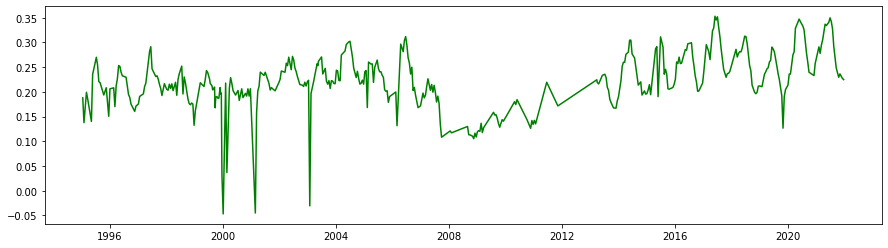

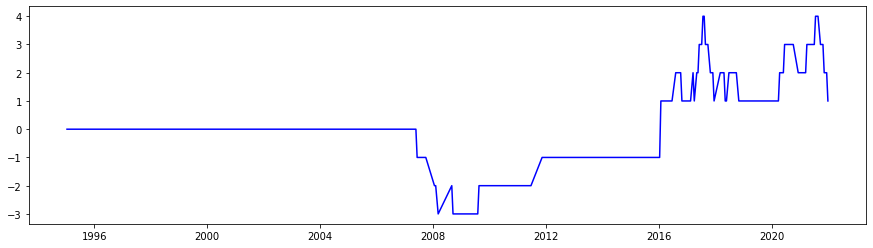

In [70]:
#ds_change = xr.open_dataset(r"C:\Users\Lewis\Desktop\test_change\change_A01.nc")  # big impact 2007 ophtha dam area
#ds_change = xr.open_dataset(r"C:\Users\Lewis\Desktop\test_change\change_A02.nc")  # big impact 2007 ophtha dam area, but training done 2013, so recovery is shown
ds_change = xr.open_dataset(r"C:\Users\Lewis\Desktop\test_change\change_A03.nc")  # near impact 2007 ophtha dam area, less impact in 2007
#ds_change = xr.open_dataset(r"C:\Users\Lewis\Desktop\test_change\change_A04.nc")  # open shrubland with wo euc? training period bad
#ds_change = xr.open_dataset(r"C:\Users\Lewis\Desktop\test_change\change_A05.nc")  # mulga area on road side? training period bad
#ds_change = xr.open_dataset(r"C:\Users\Lewis\Desktop\test_change\change_A06.nc")  # euc vic east yandi. gradual increasing... odd result? try train period
#ds_change = xr.open_dataset(r"C:\Users\Lewis\Desktop\test_change\change_A07.nc")  # yandi discharge south veg... good, but change in training period?
#ds_change = xr.open_dataset(r"C:\Users\Lewis\Desktop\test_change\change_A08.nc")   # yandi elephatn graveyard. good - 2007 decline

vec_summary = ds_change['summary'].median(['x', 'y']).data
fig = plt.figure(figsize=(15, 4))
plt.plot(ds_change['time'].data, vec_summary, color='green')
plt.show()

vec_static = ds_change['static'].median(['x', 'y']).data
fig = plt.figure(figsize=(15, 4))
plt.plot(ds_change['time'].data, vec_static, color='blue')
plt.show()

### Smooth data (savitsky)

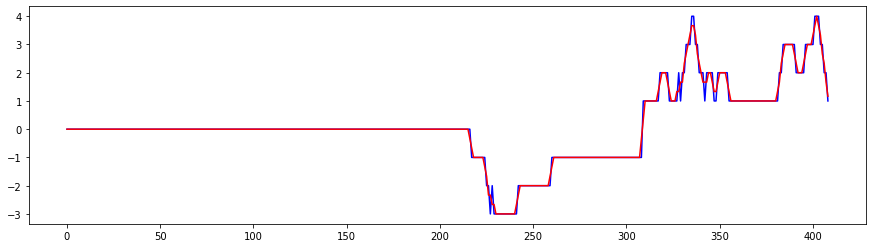

In [71]:
# smooth static change gently
vec_static_smooth = nrt.smooth_change(arr=vec_static)

#for i in np.arange(0, len(vec_static_smooth)):
    #if i > 3: 
        #vec_raw = vec_static[0:i]
        #vec_smooth = vec_static_smooth[0:i]
        
        #fig = plt.figure(figsize=(15, 4))
        #plt.plot(vec_raw, color='blue')
        #plt.plot(vec_smooth, color='red', marker='o', alpha=0.75)
        #plt.axvline(i - 2, color='black', linestyle='dashed')
        #plt.show()
        
fig = plt.figure(figsize=(15, 4))
plt.plot(vec_static, color='blue')
plt.plot(vec_static_smooth, color='red')
plt.show()

## Apply rule 1: consequtives

In [72]:
# todo
# ignore small increases of 1 in counting of conseqs?
# include plateaus following decline period

In [75]:
from importlib import reload
reload(nrt)

<module 'nrt' from 'C:\\Users\\Lewis\\Documents\\GitHub\\tenement-tools\\modules\\nrt.py'>

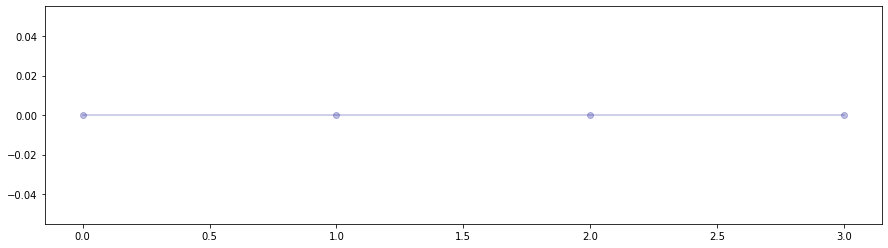

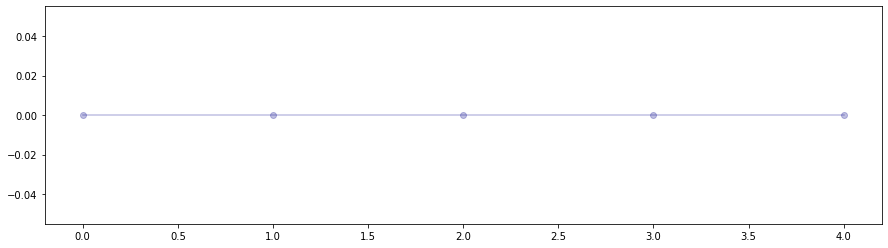

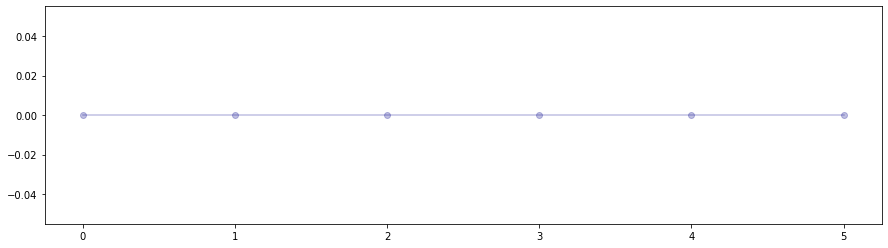

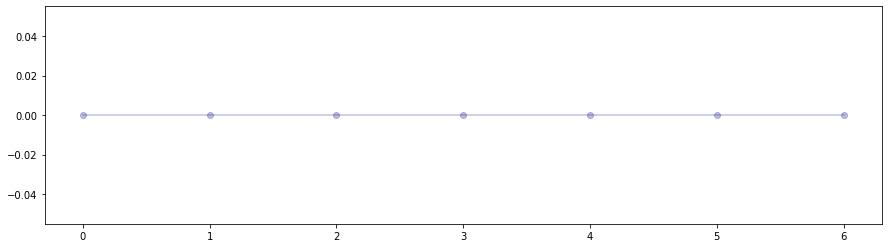

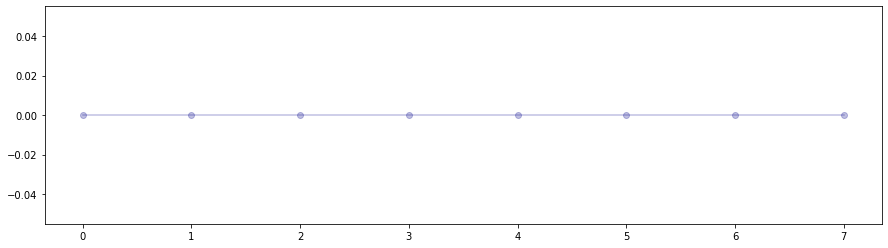

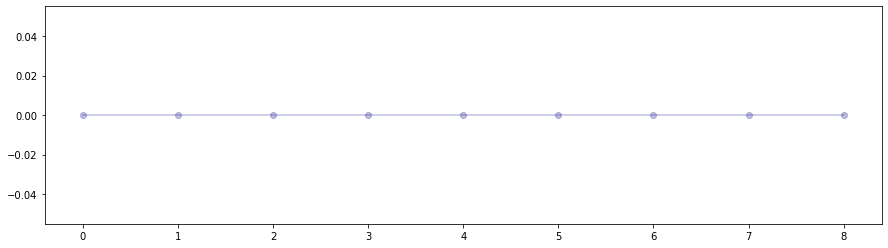

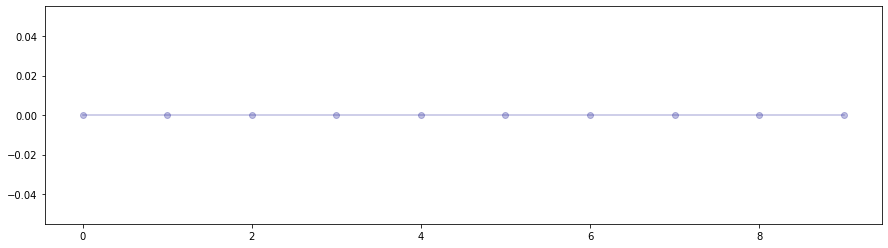

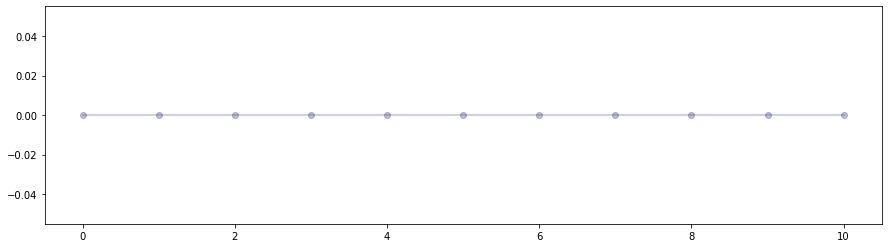

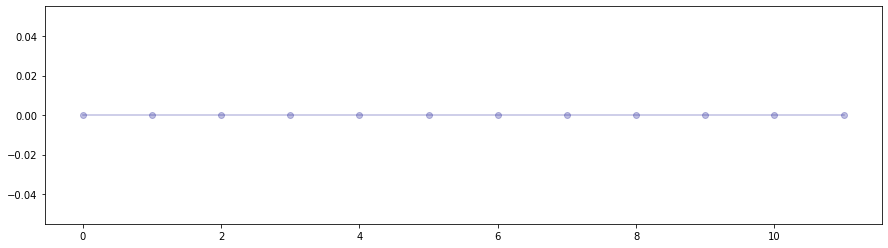

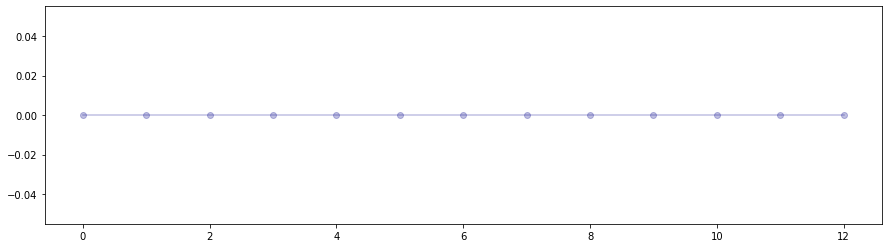

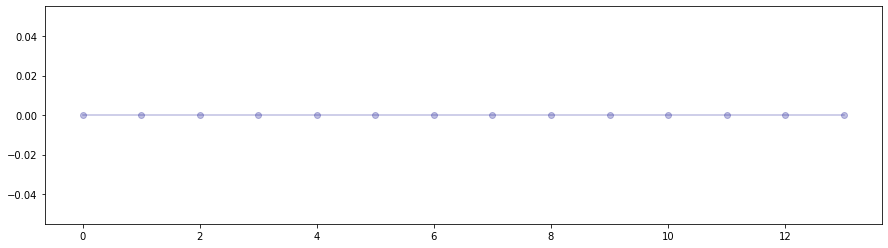

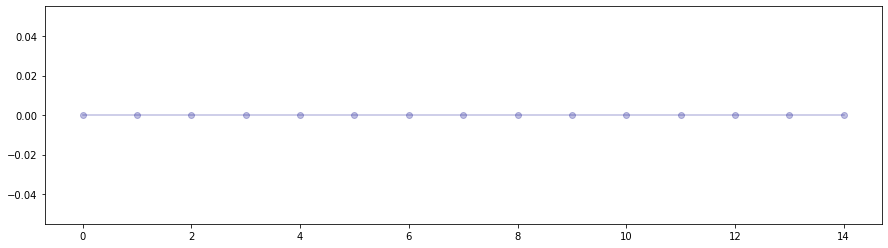

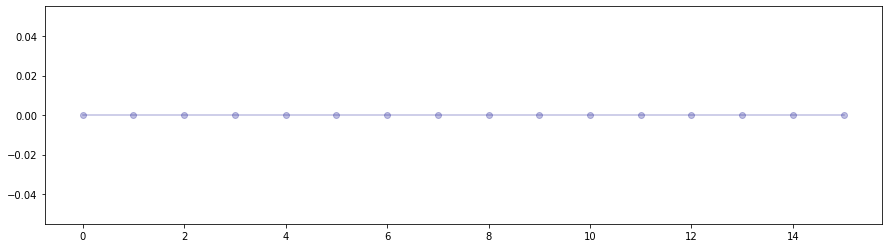

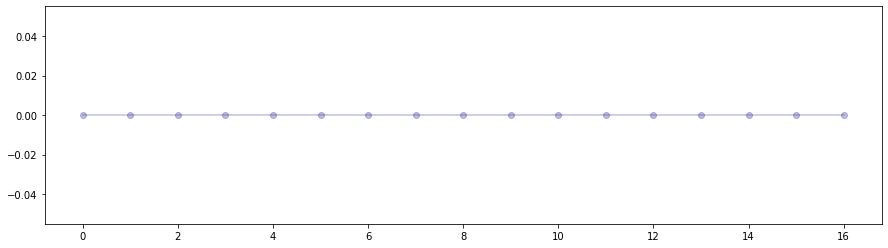

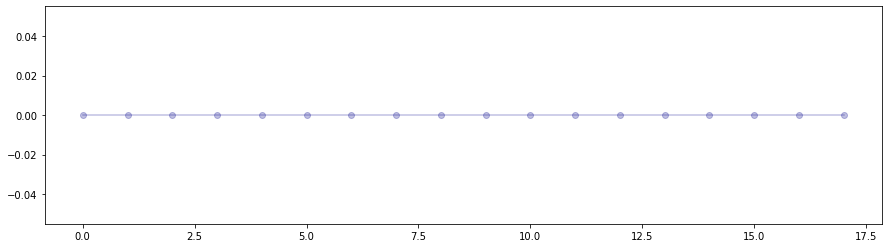

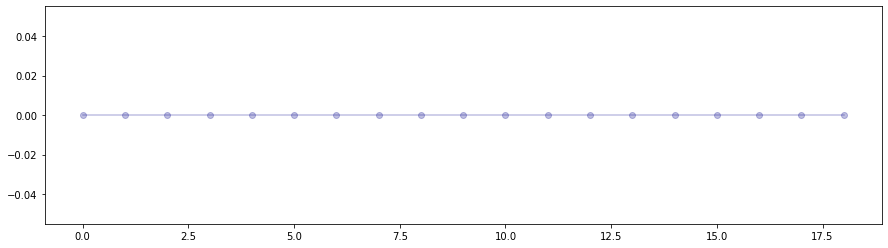

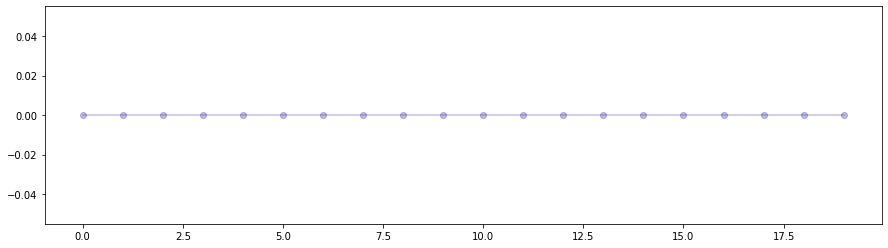

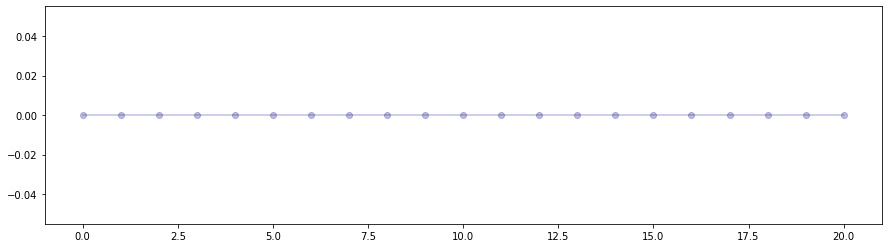

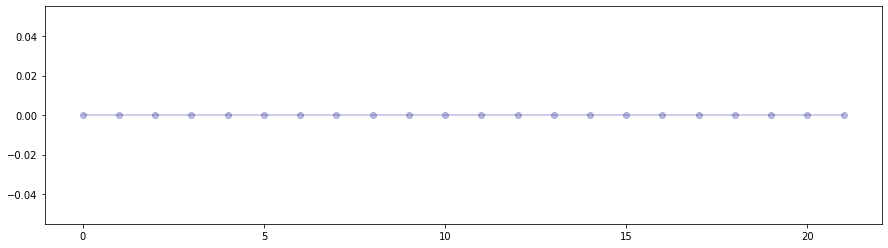

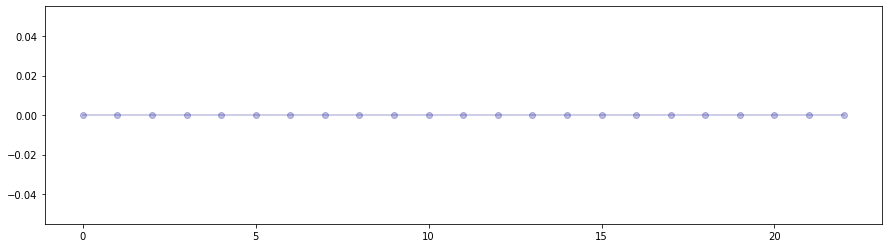

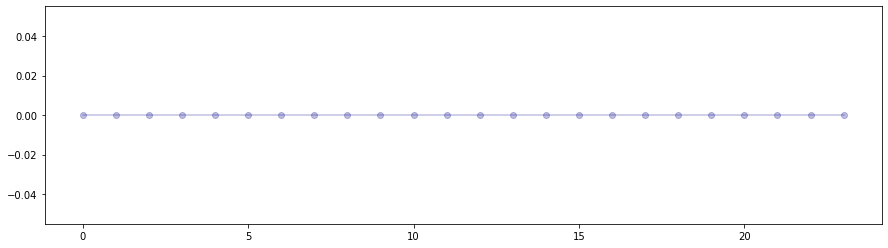

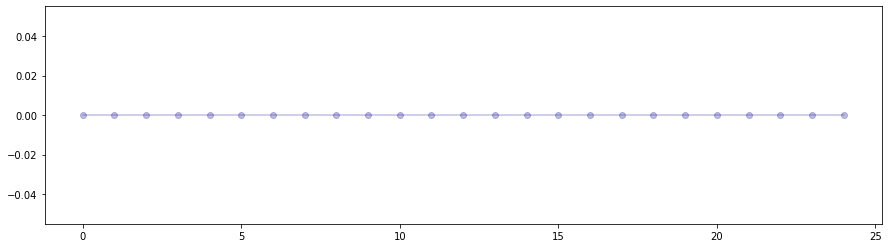

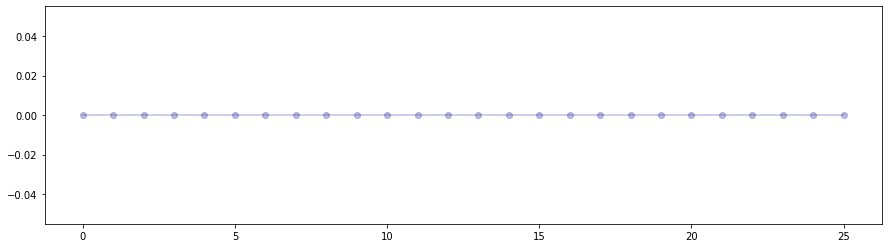

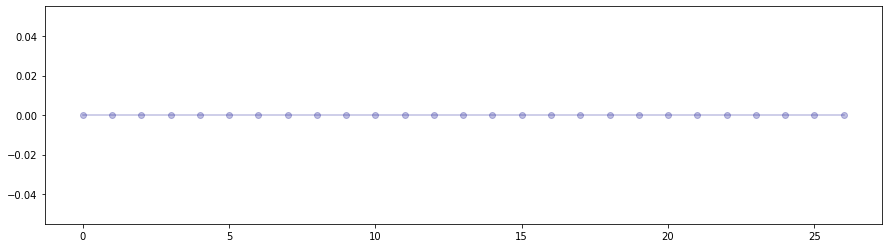

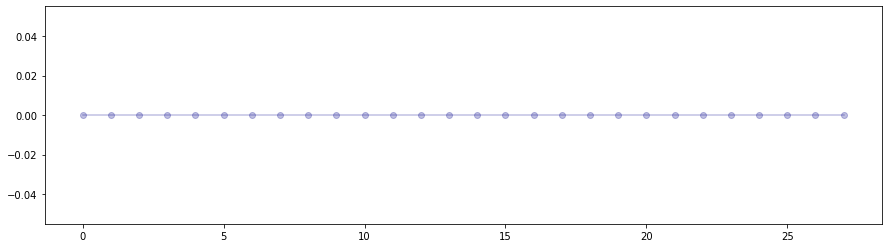

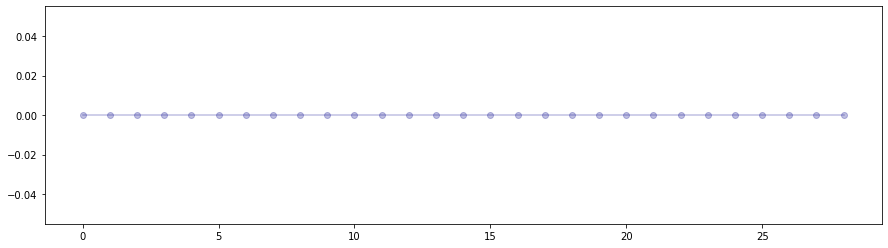

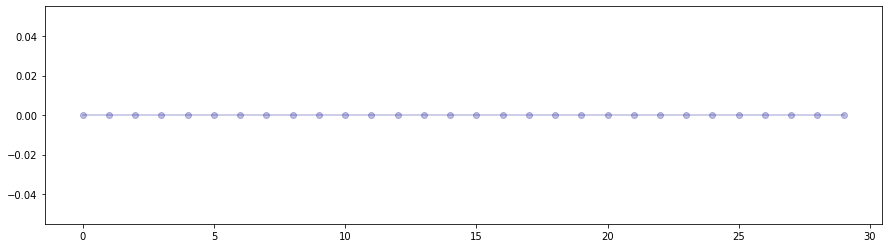

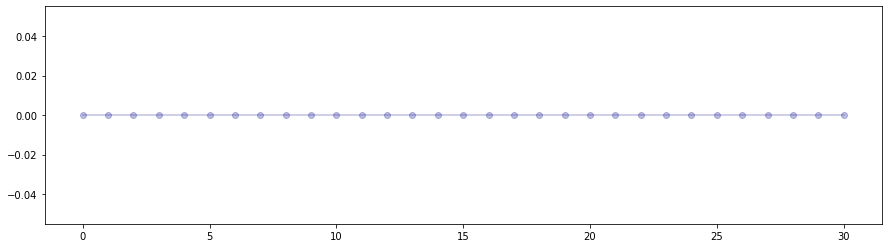

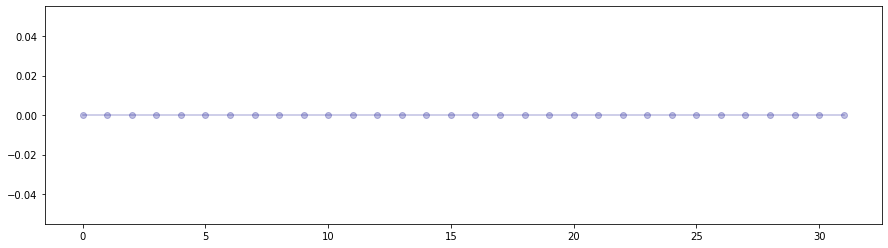

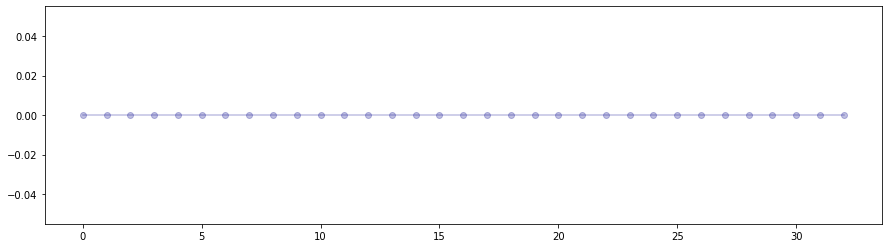

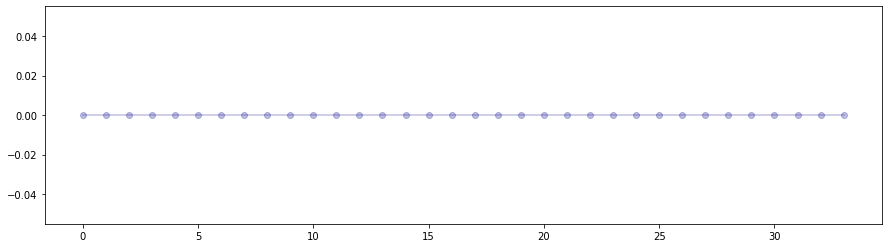

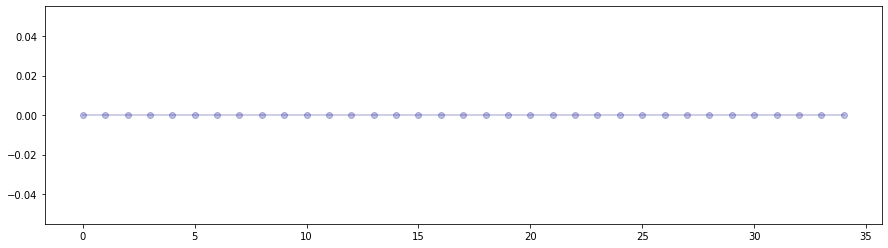

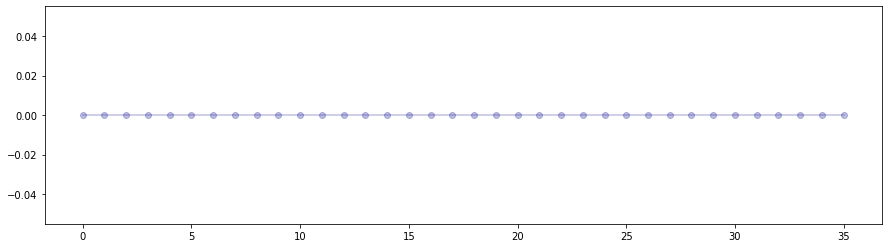

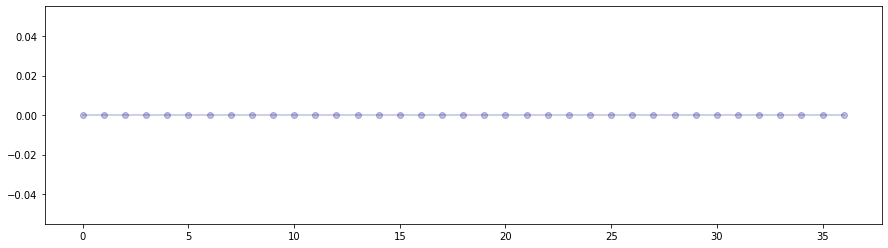

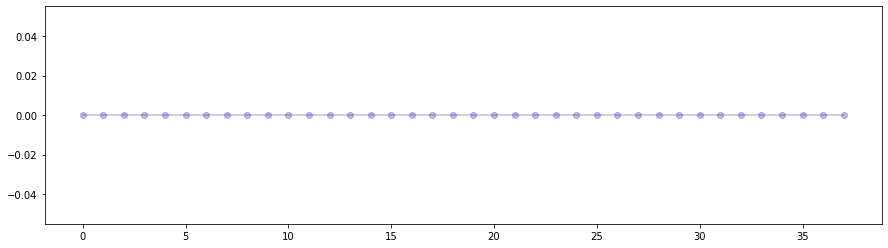

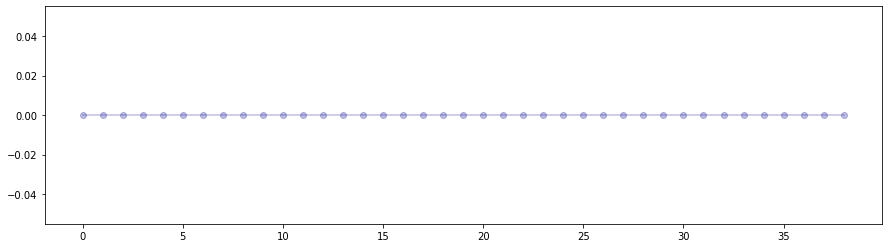

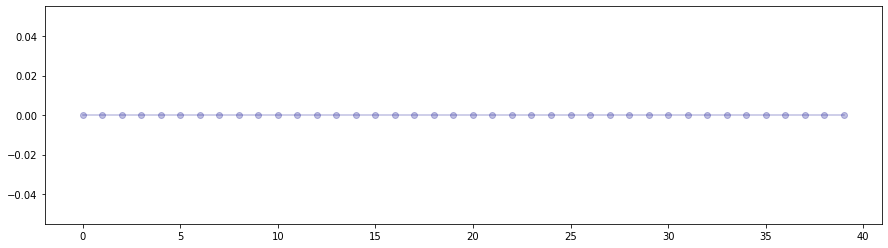

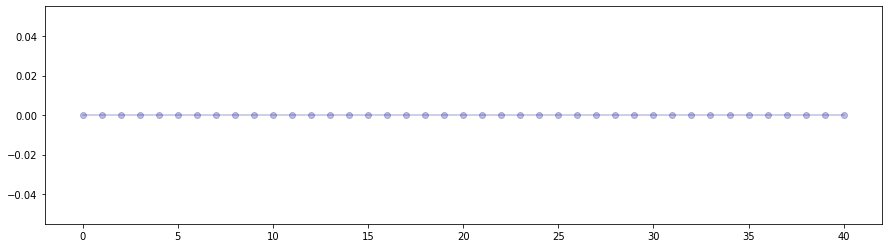

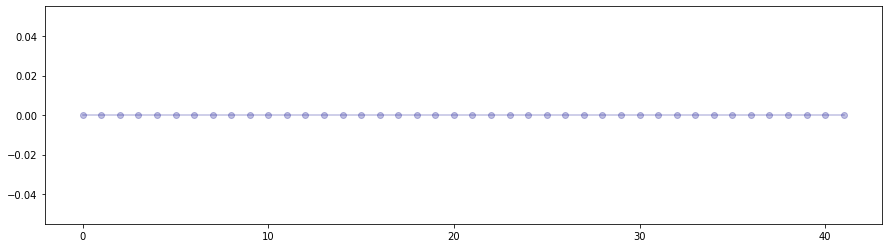

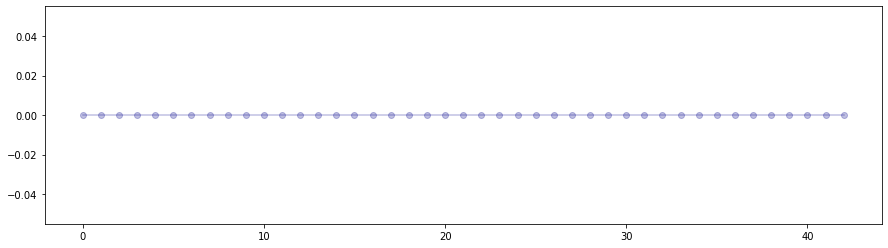

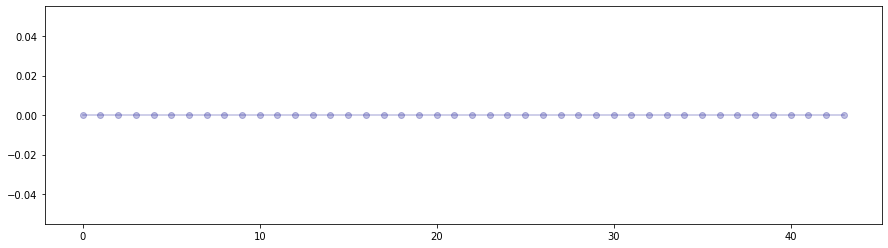

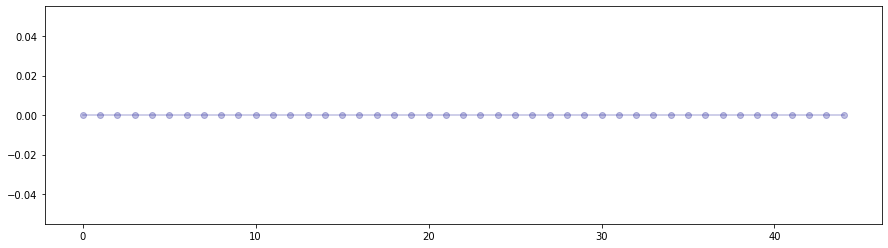

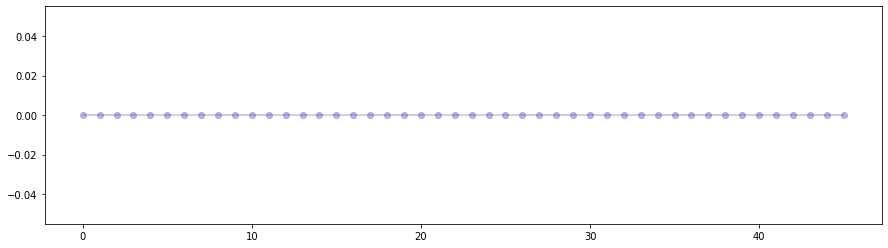

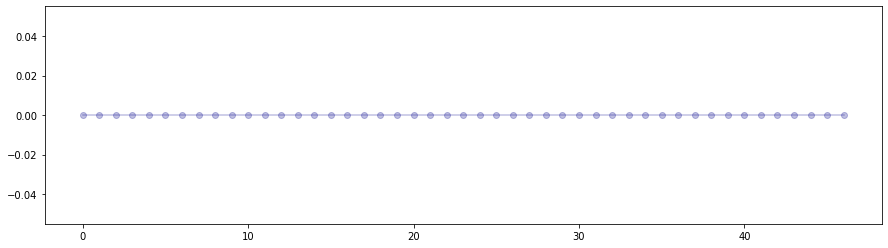

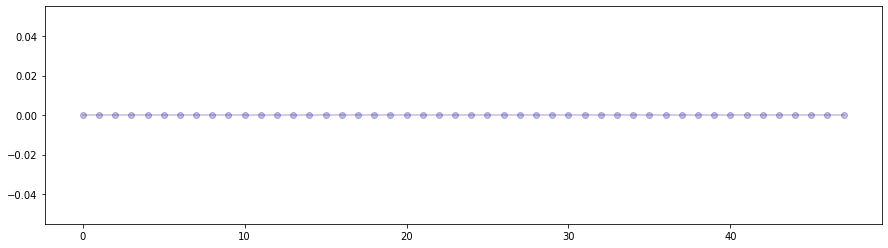

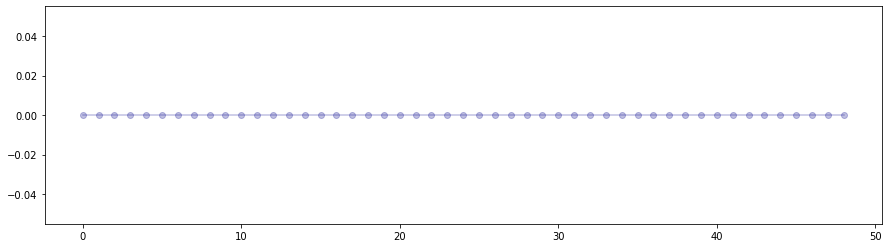

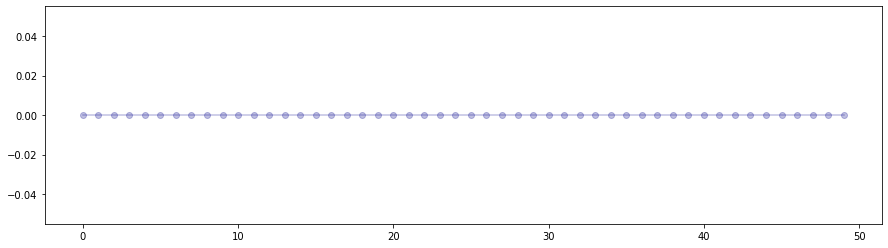

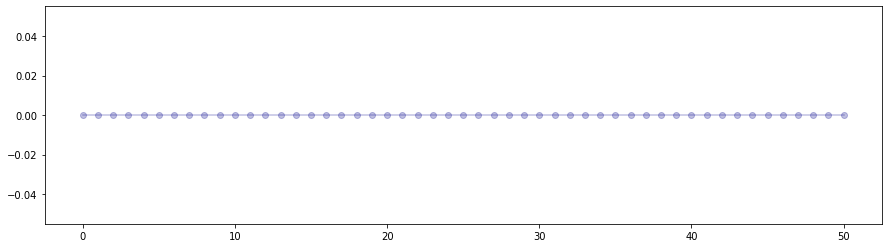

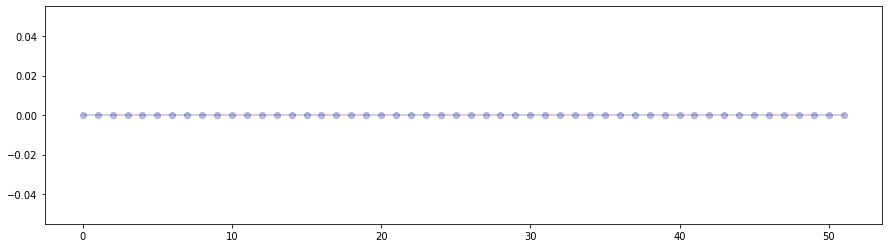

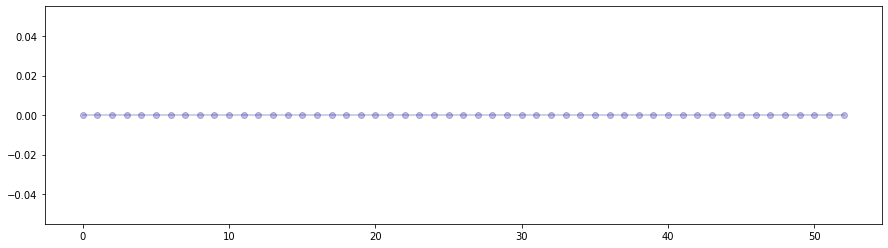

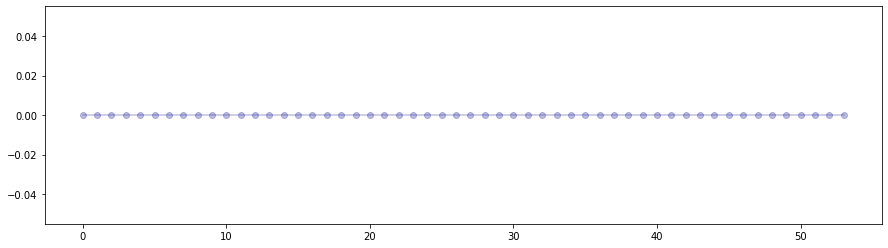

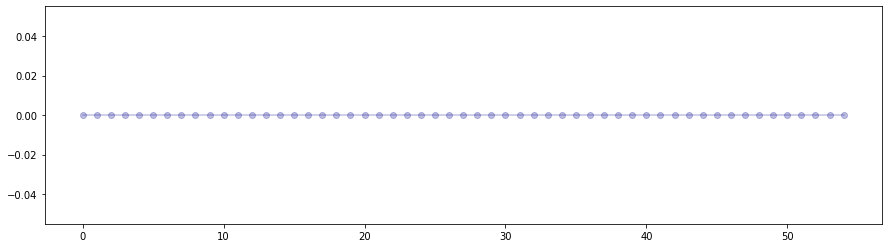

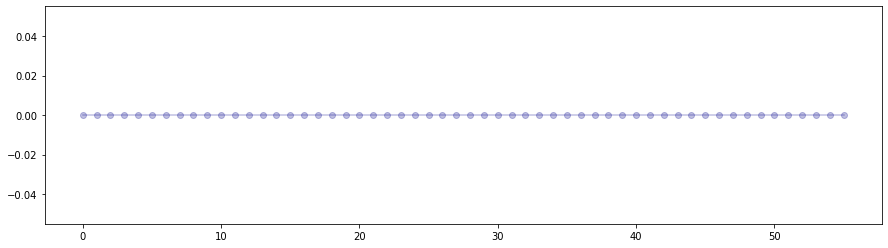

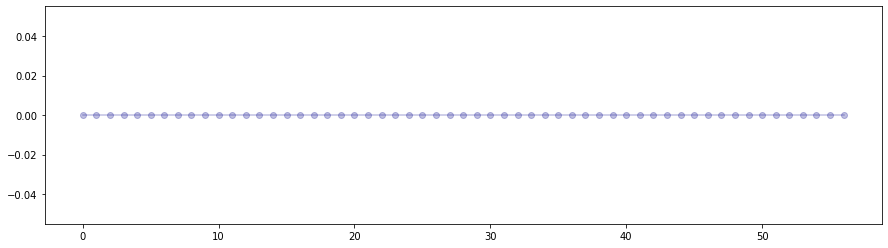

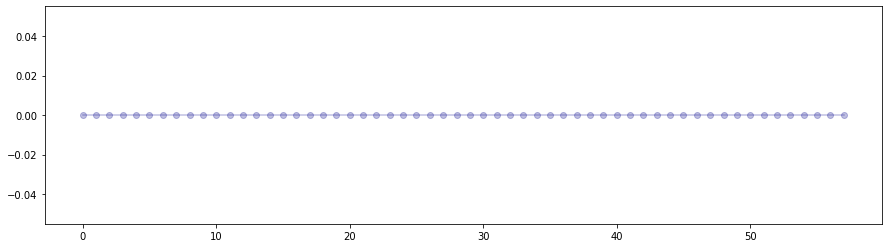

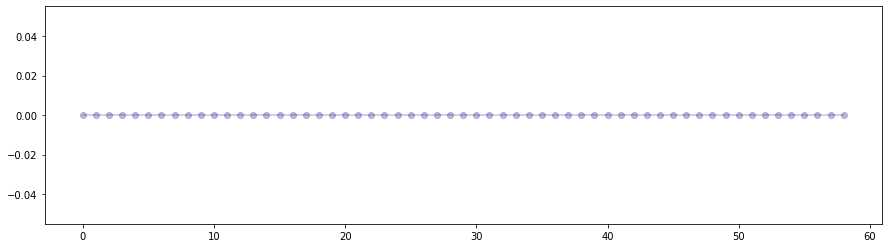

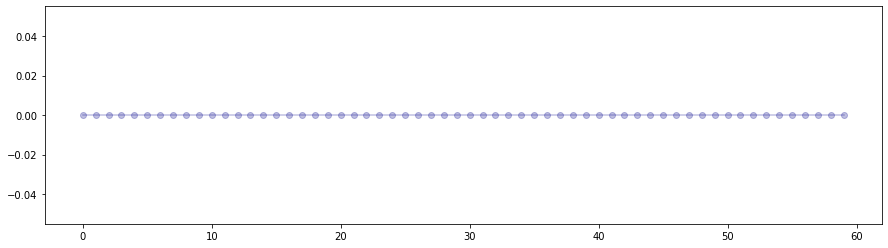

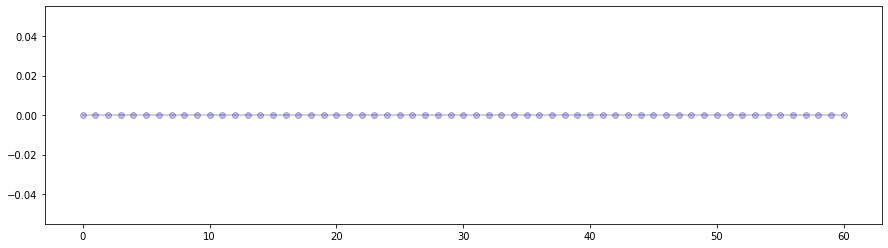

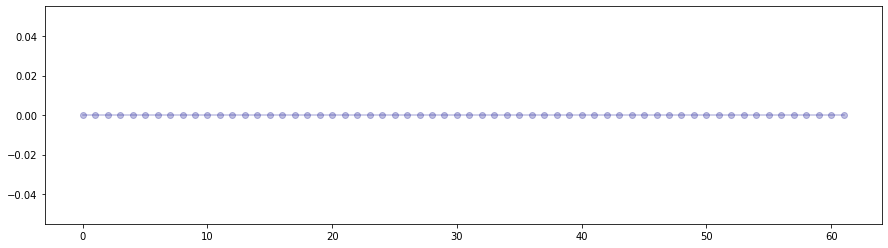

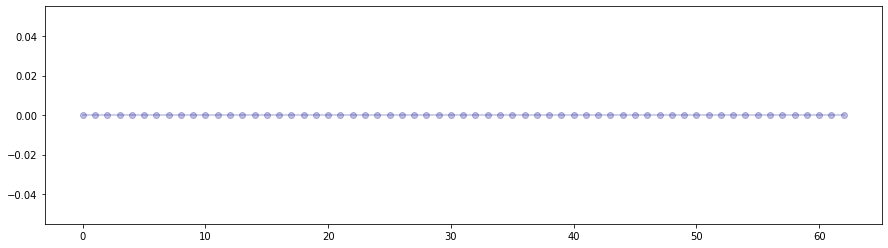

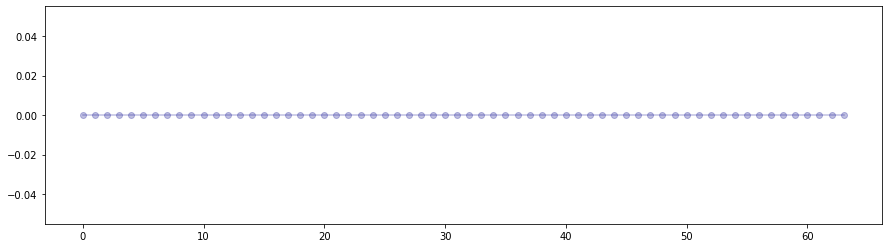

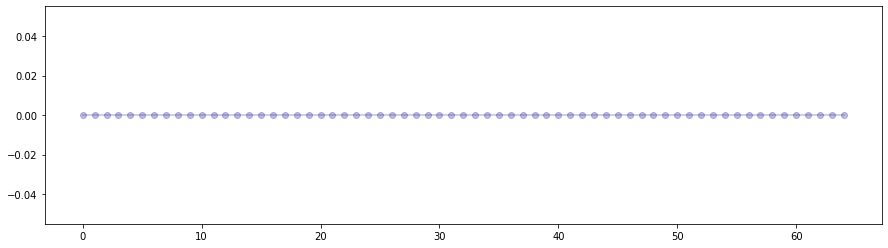

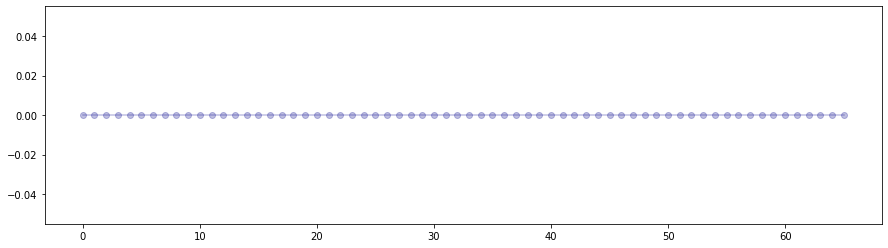

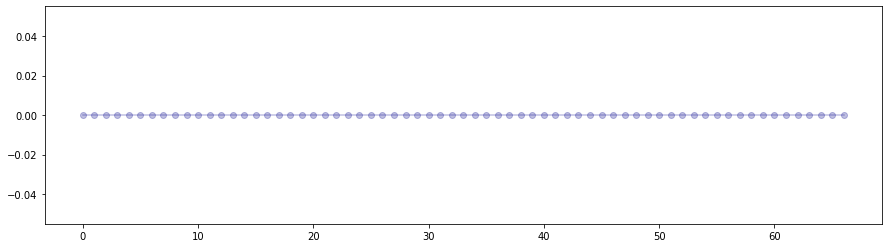

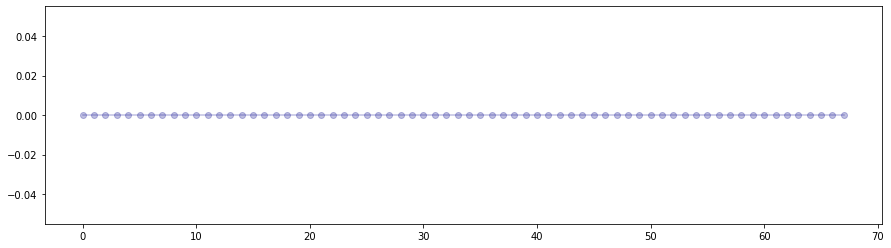

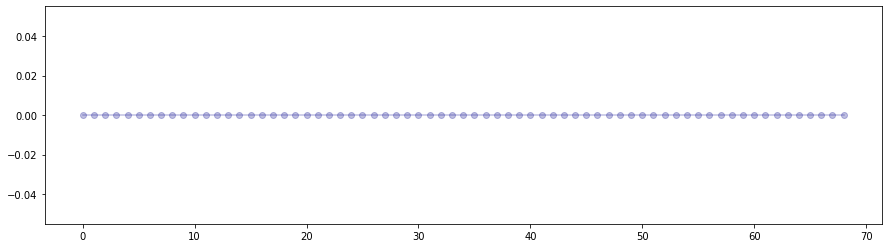

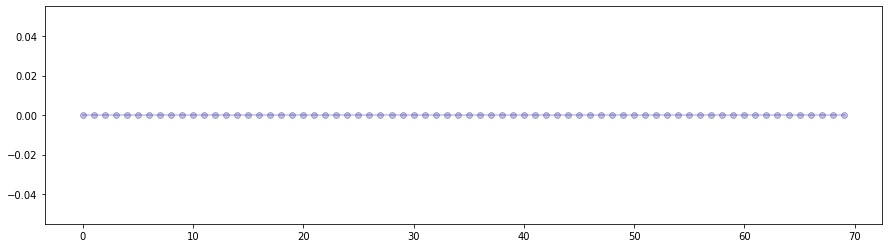

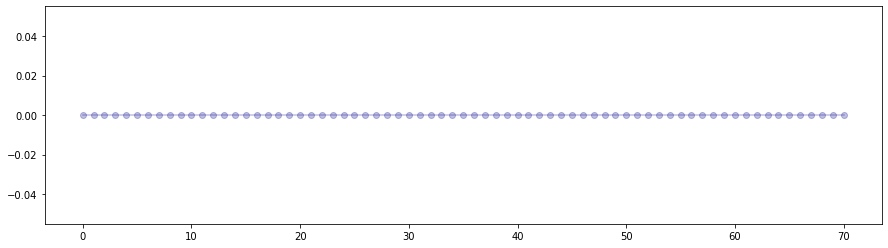

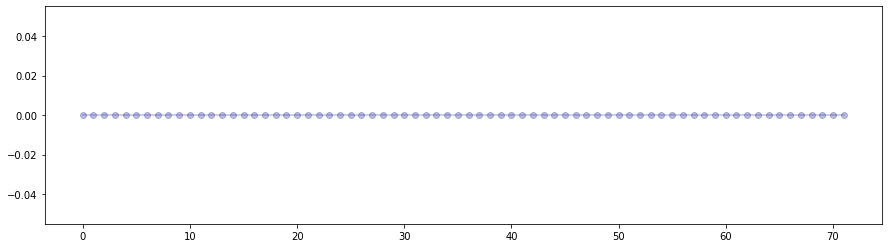

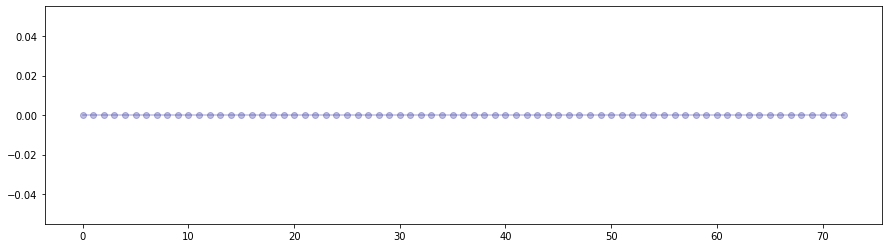

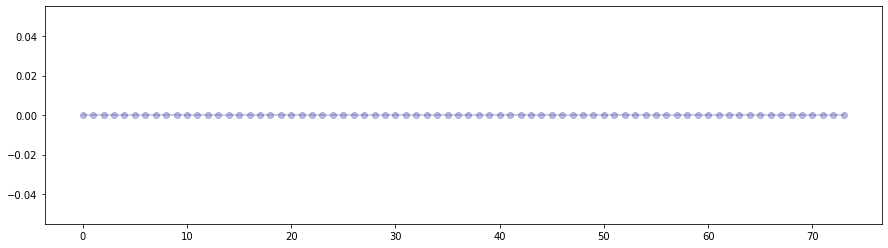

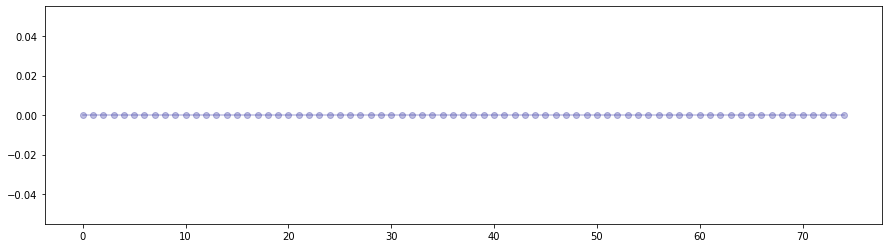

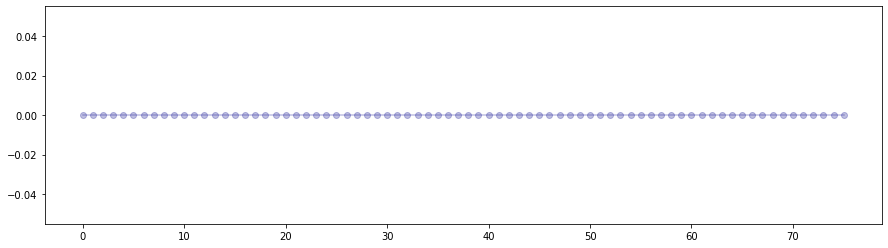

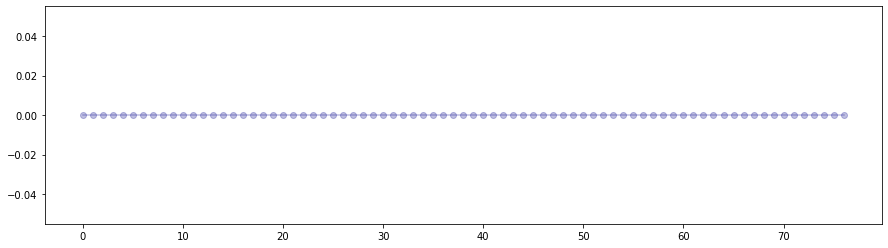

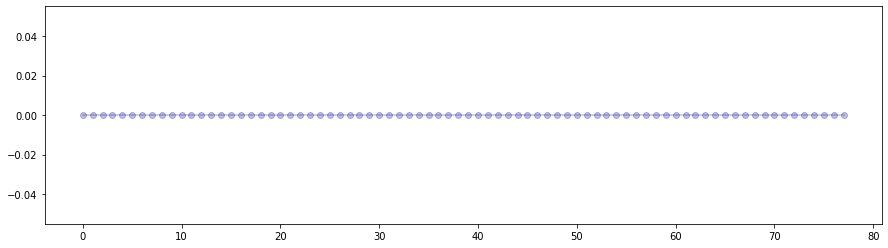

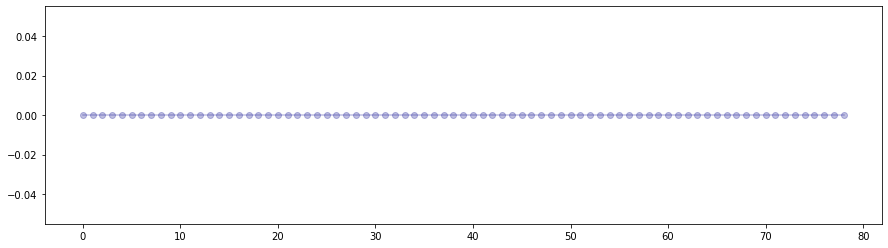

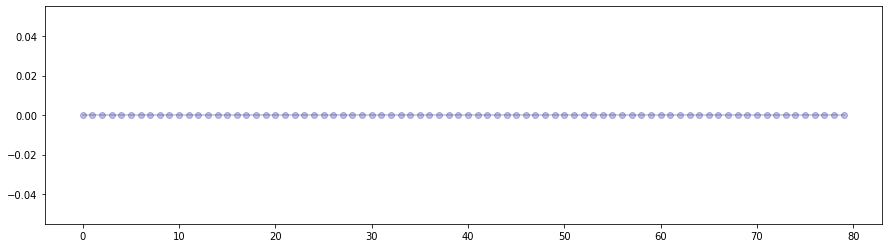

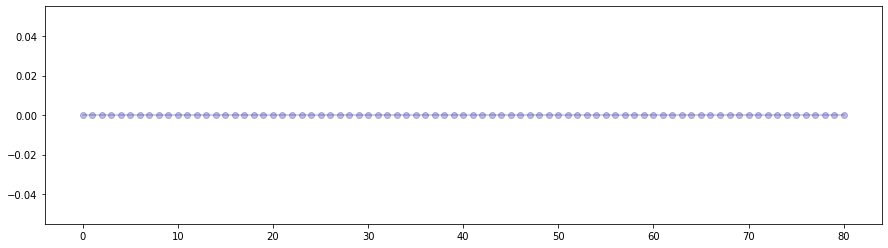

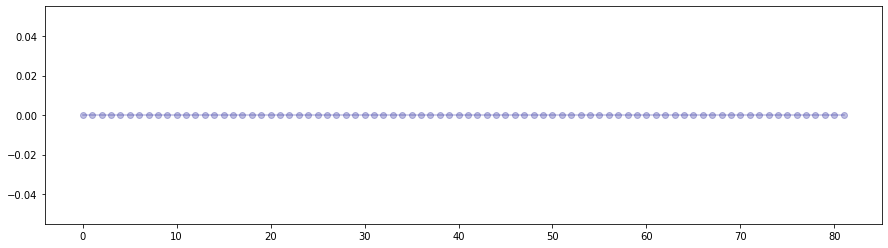

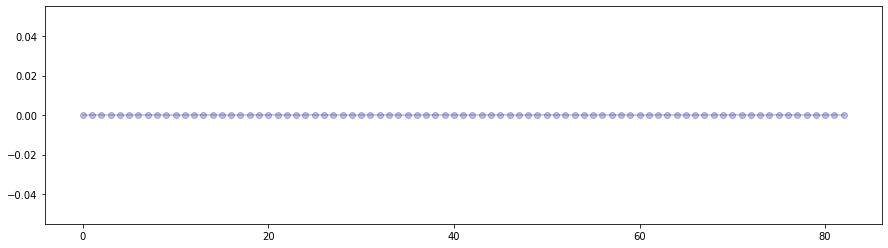

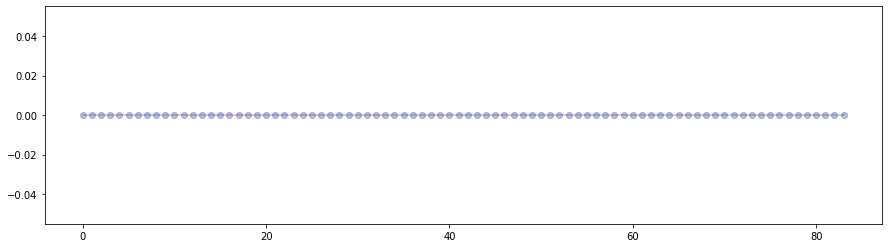

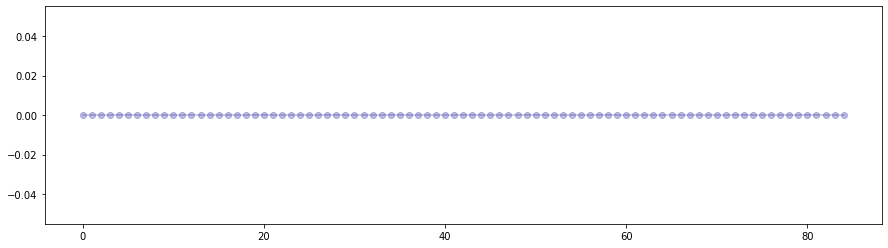

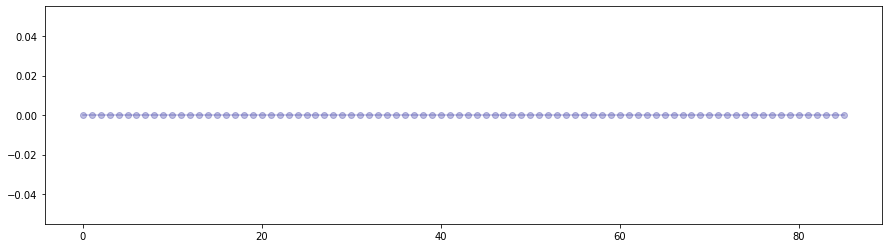

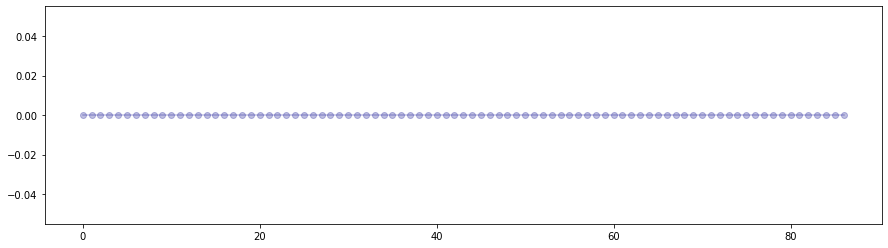

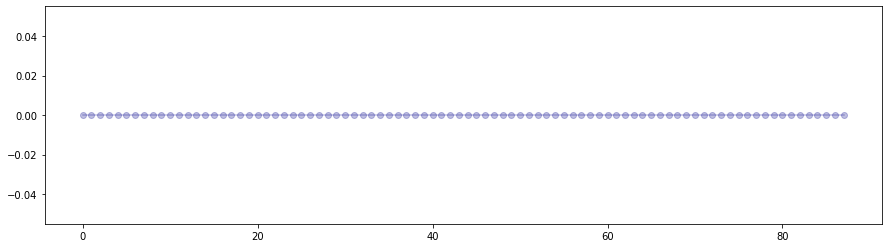

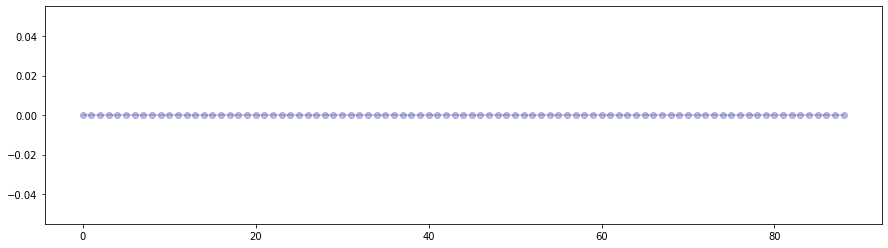

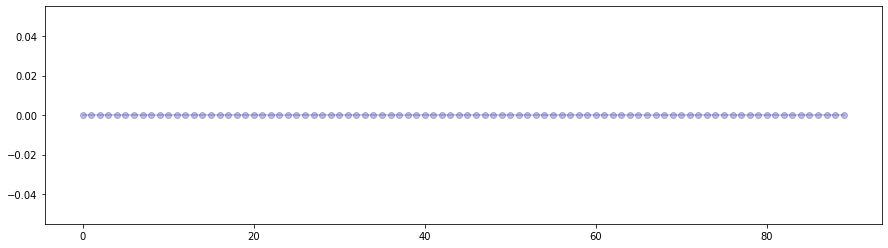

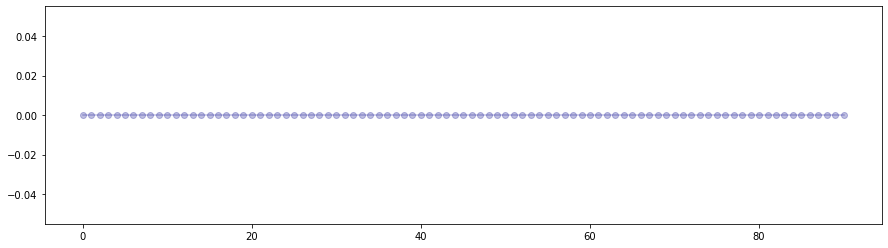

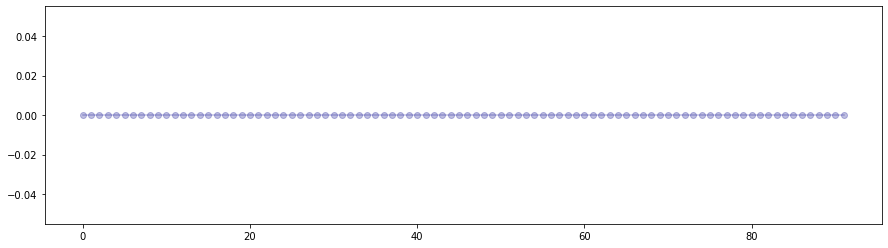

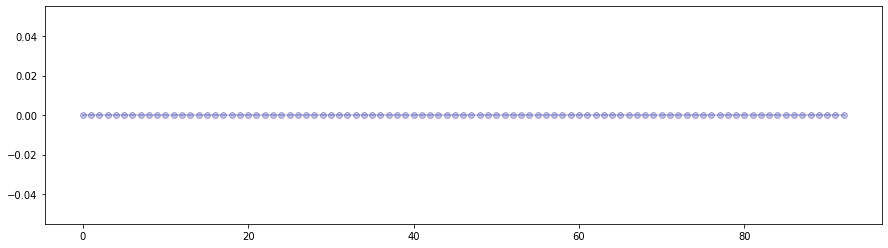

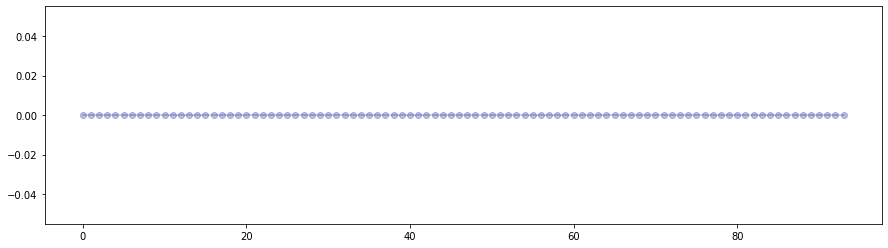

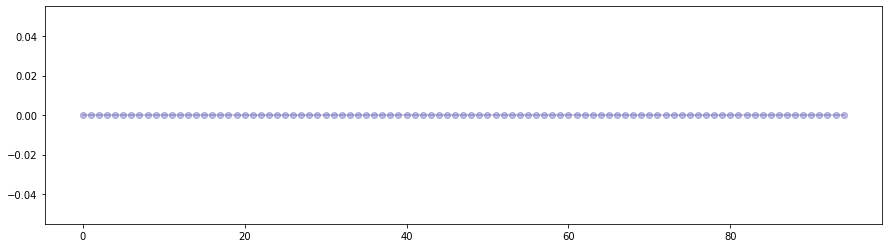

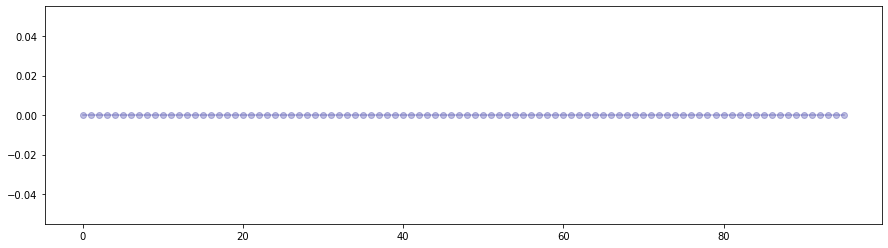

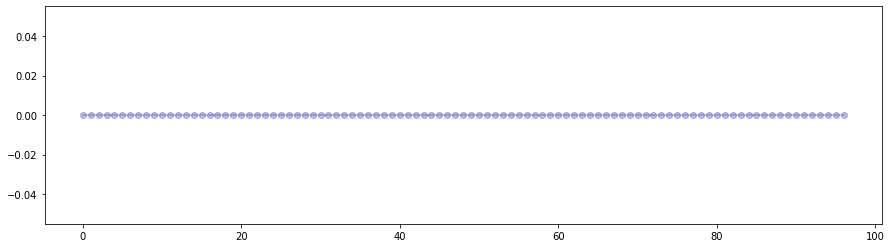

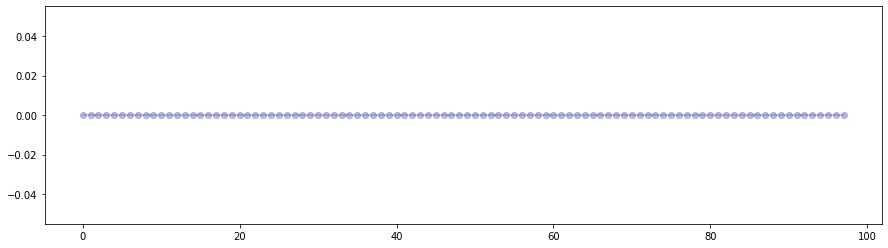

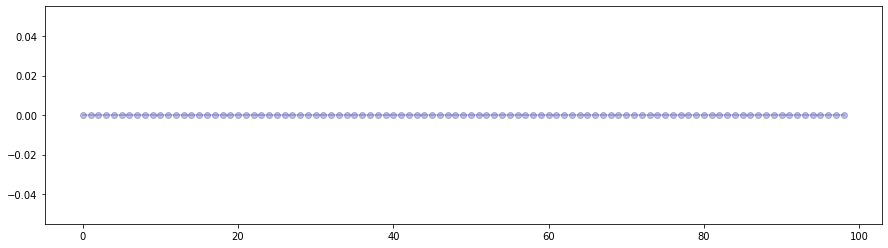

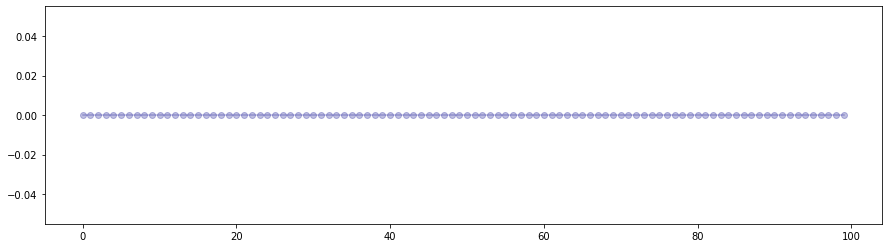

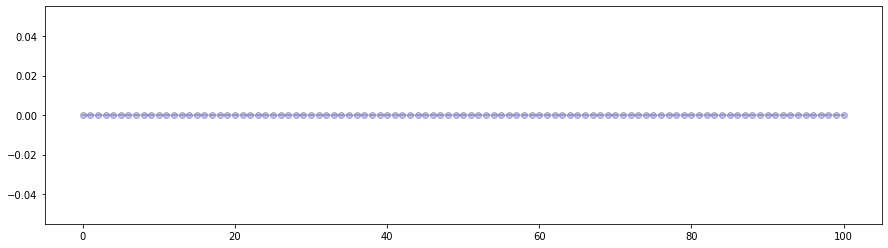

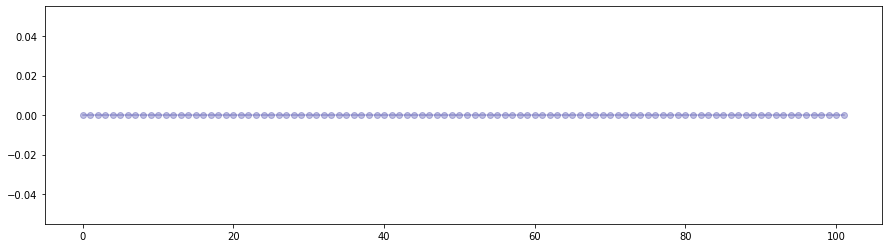

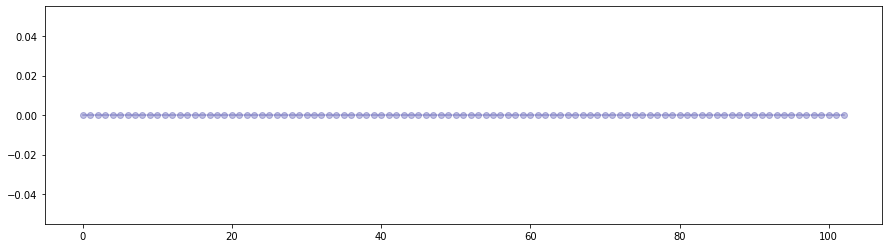

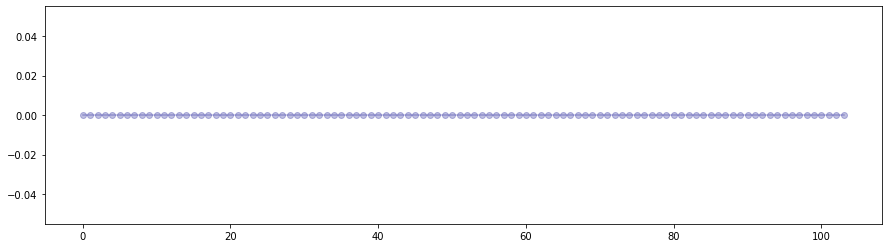

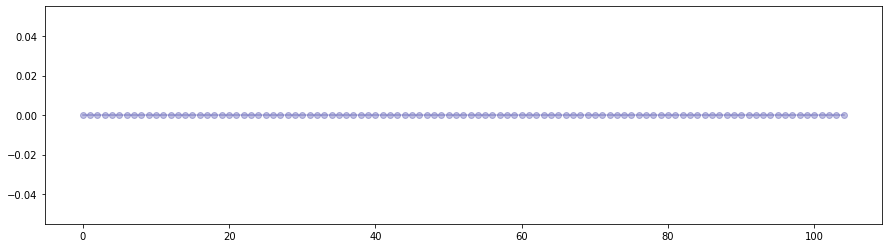

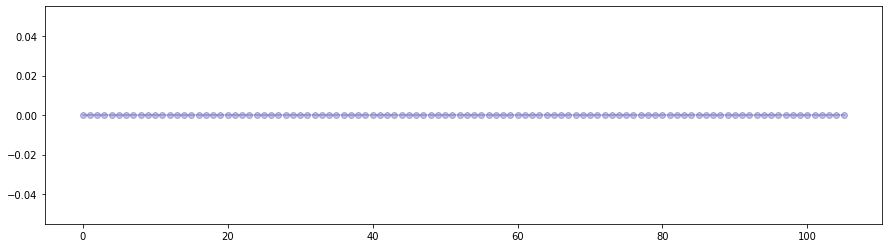

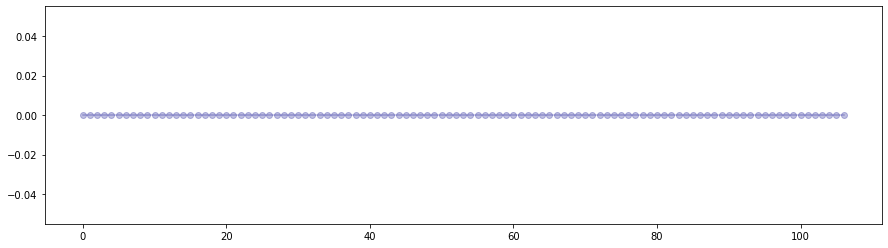

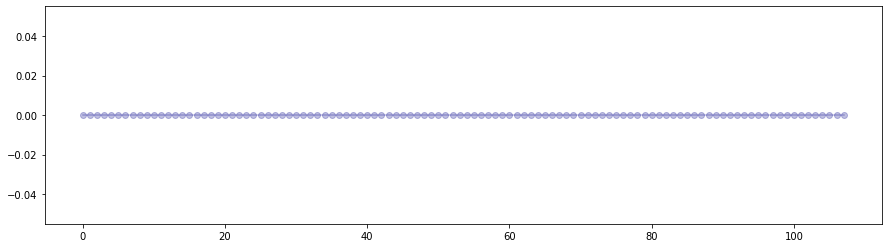

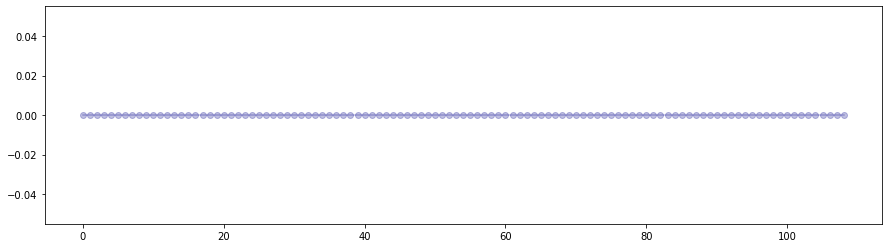

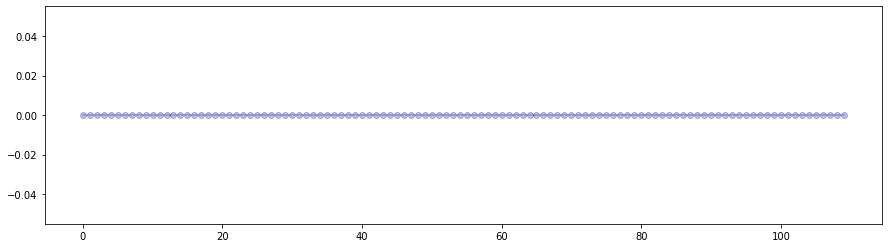

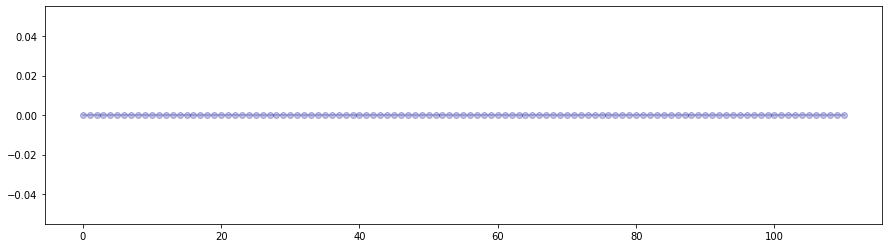

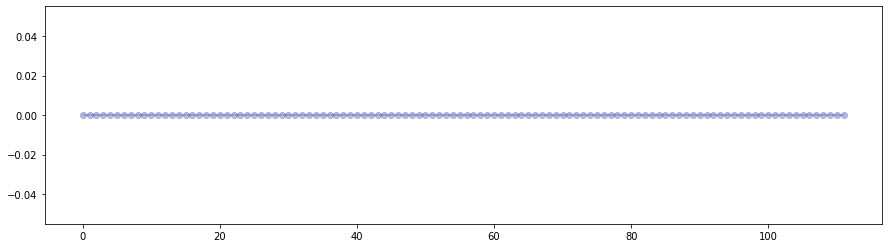

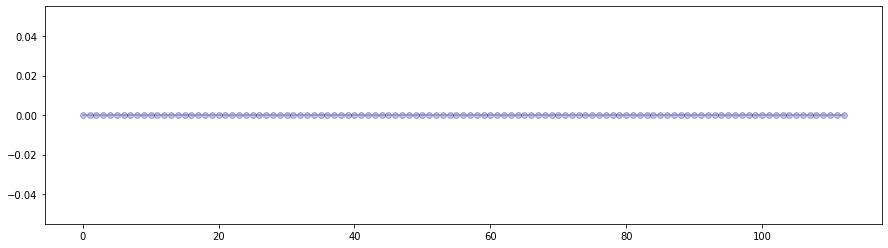

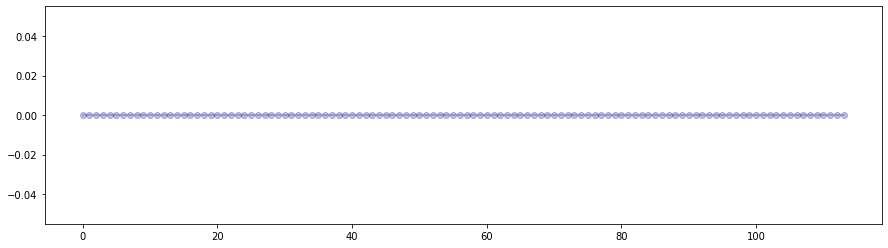

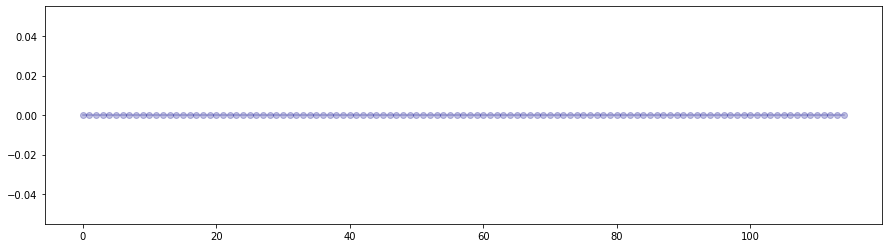

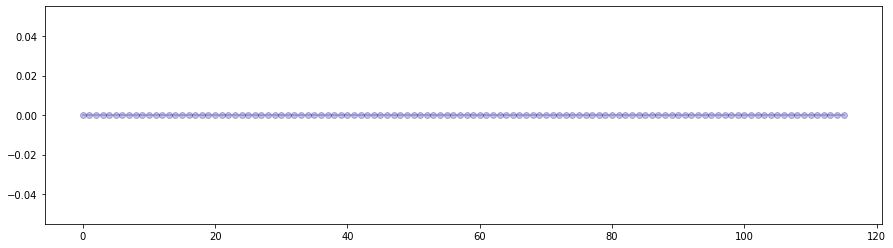

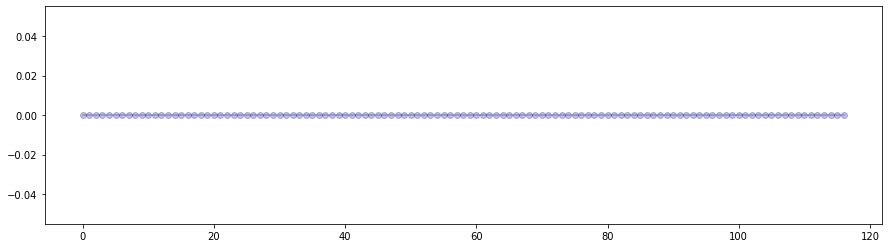

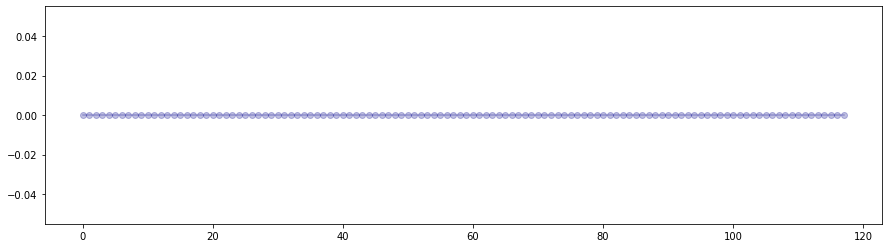

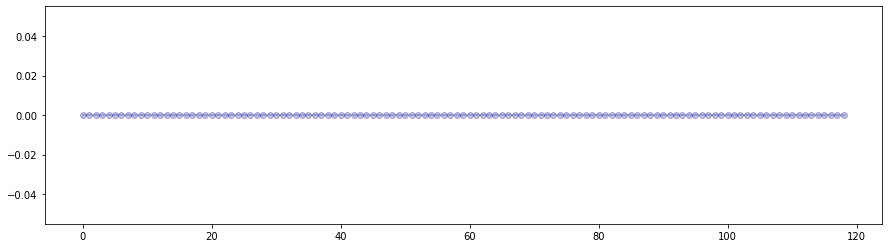

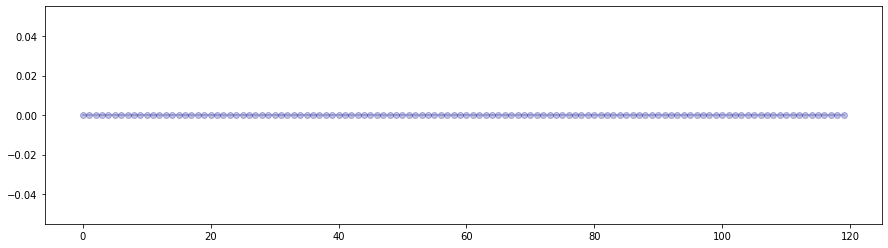

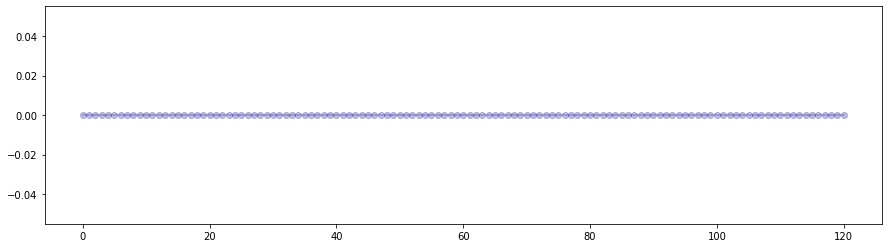

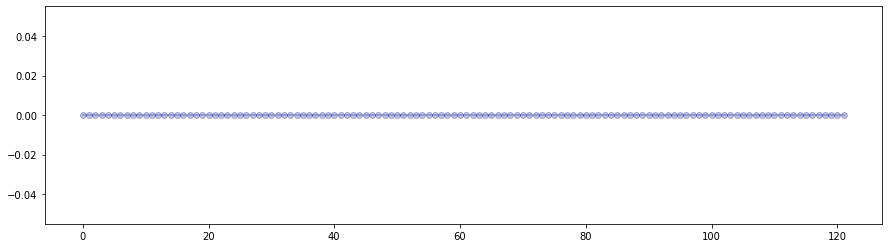

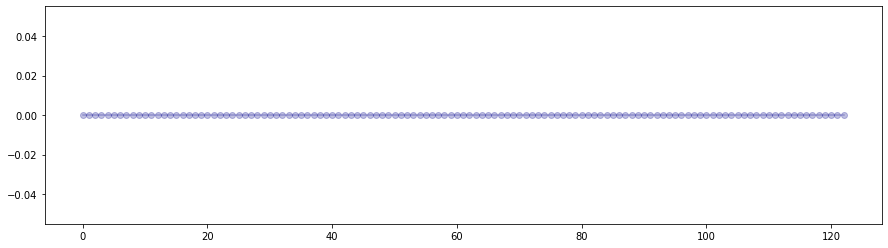

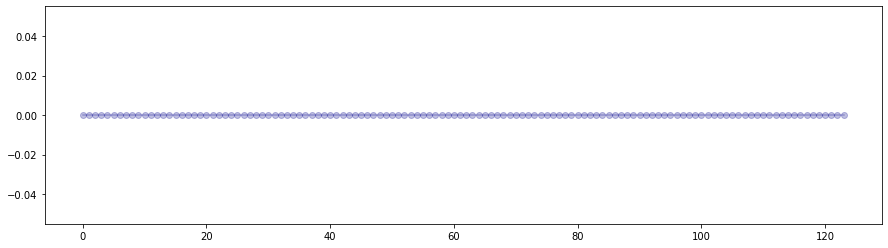

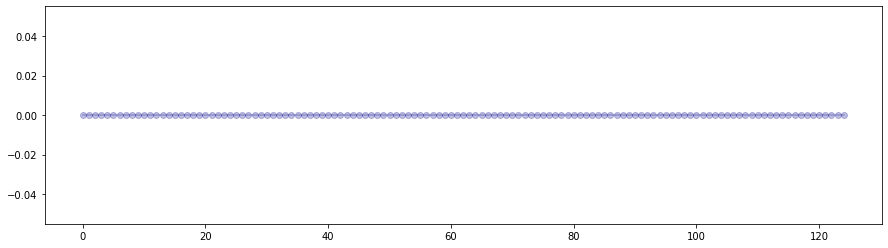

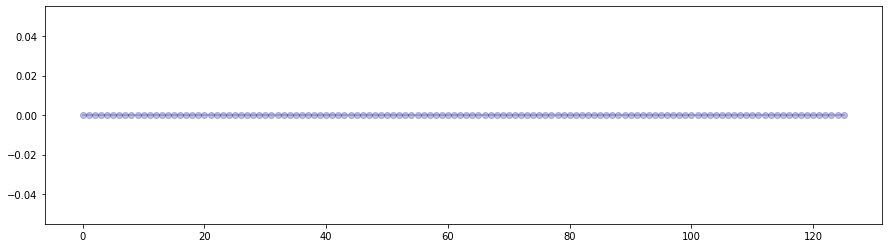

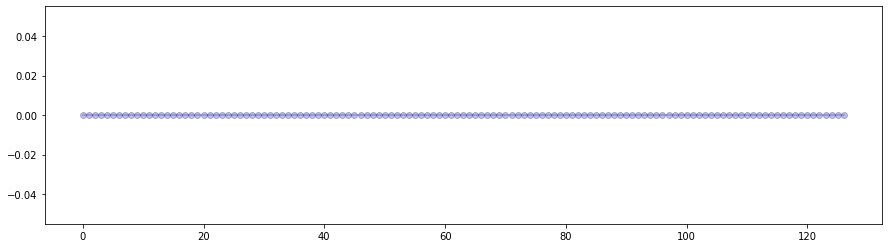

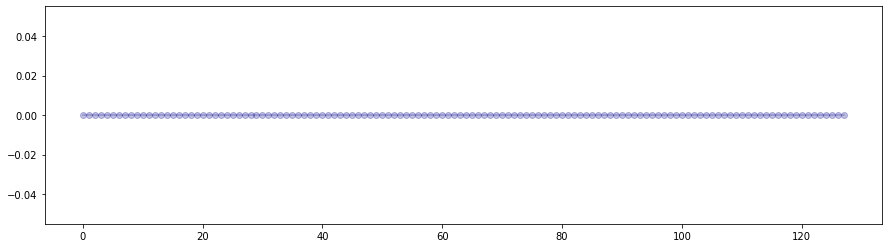

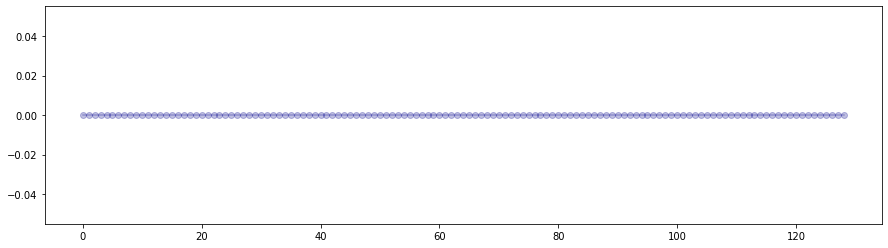

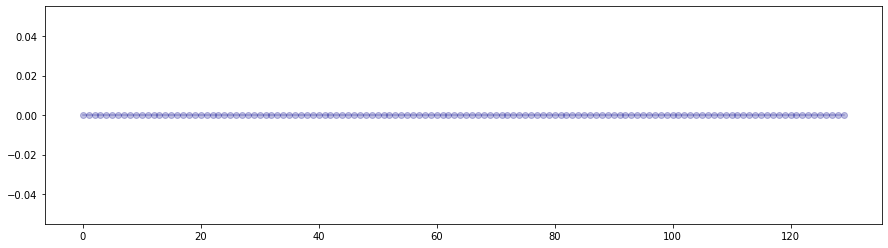

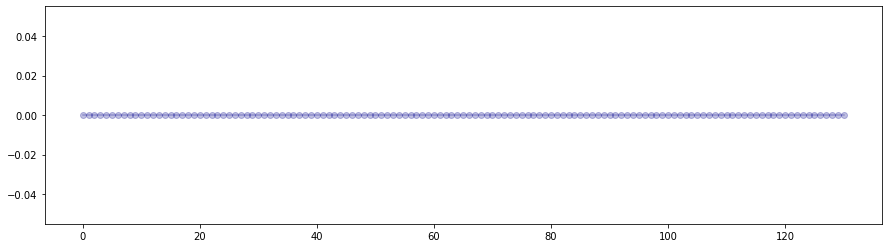

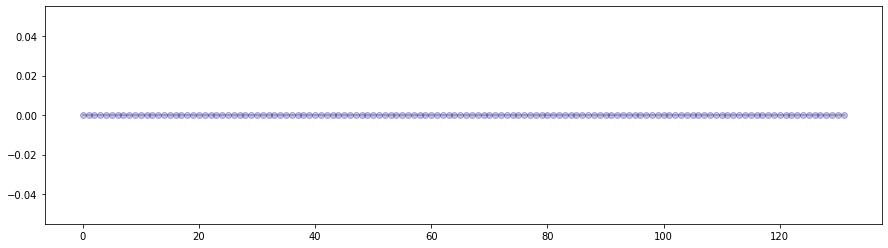

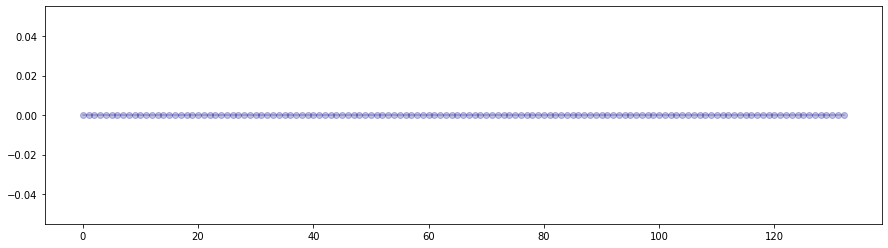

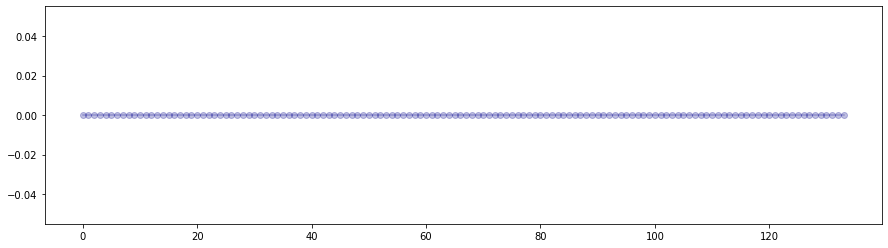

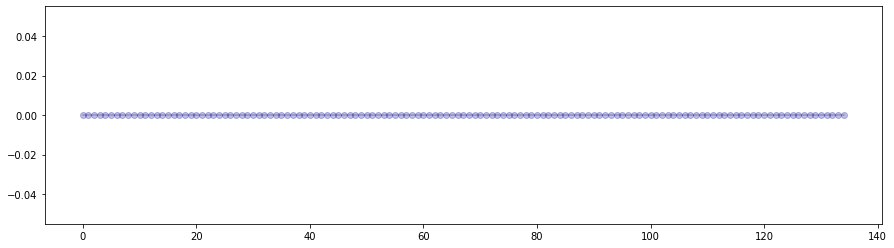

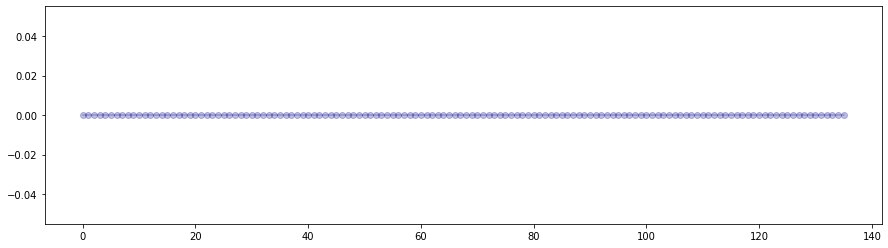

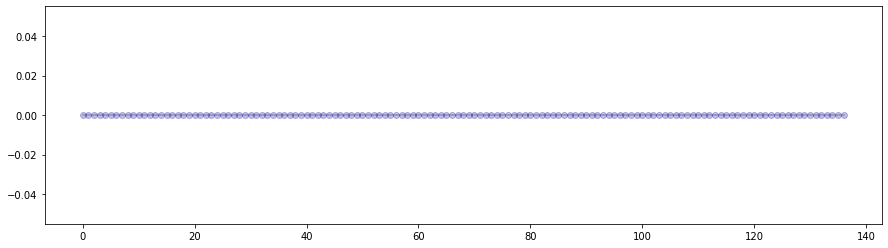

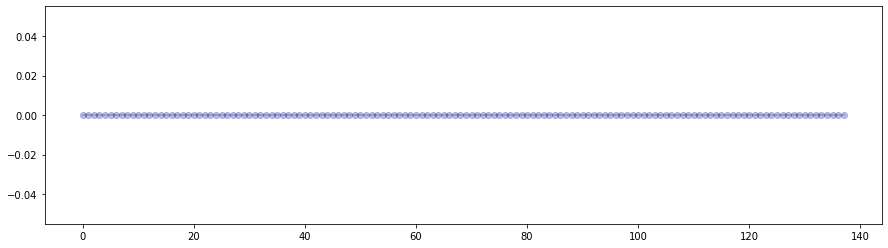

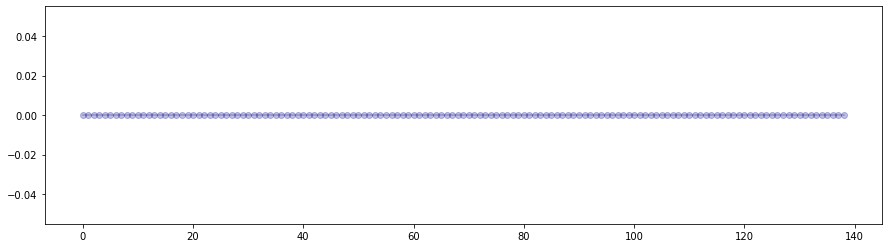

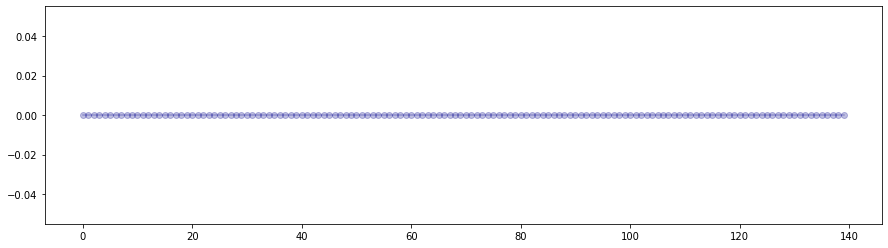

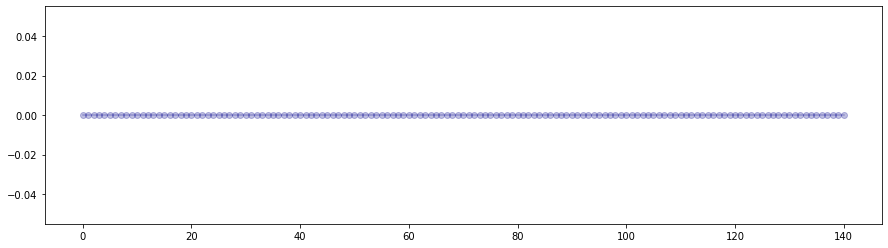

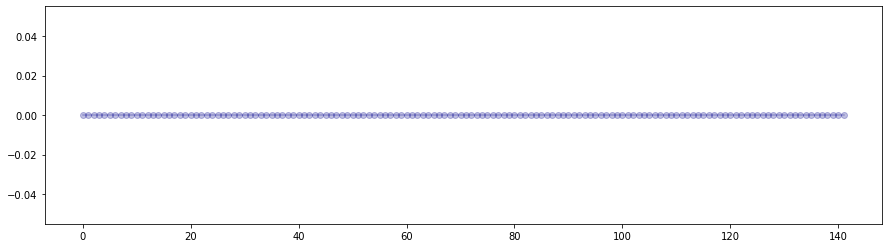

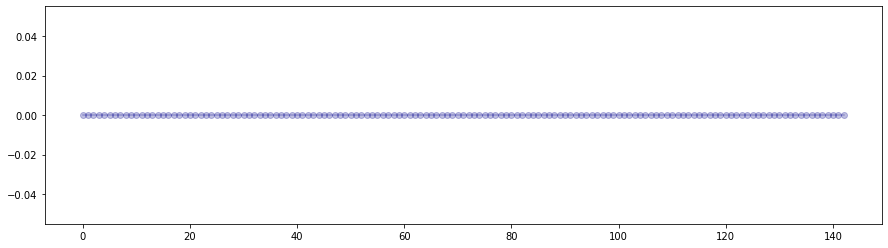

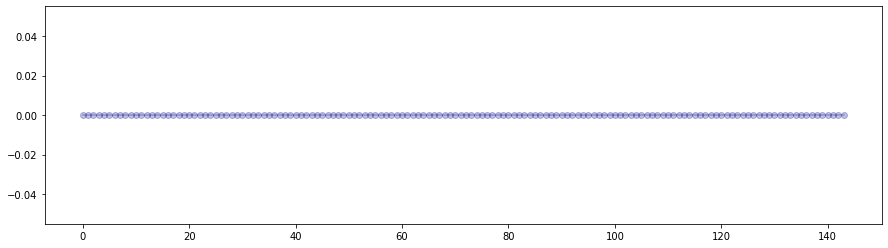

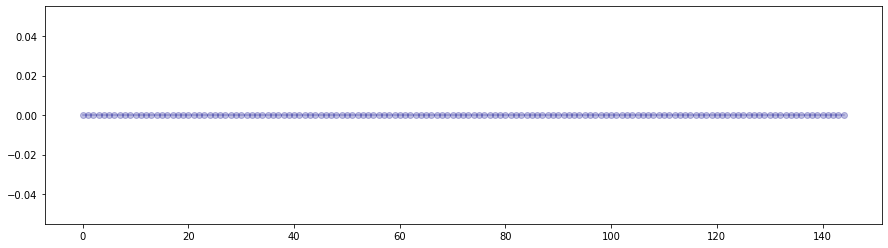

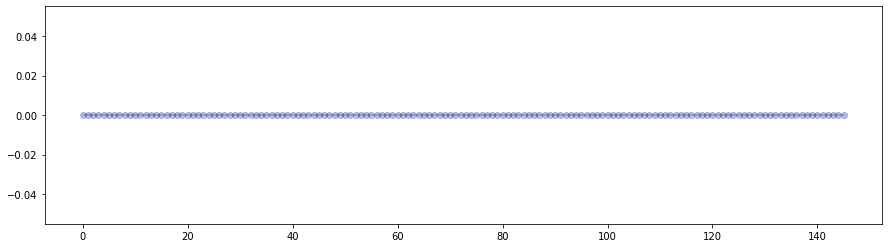

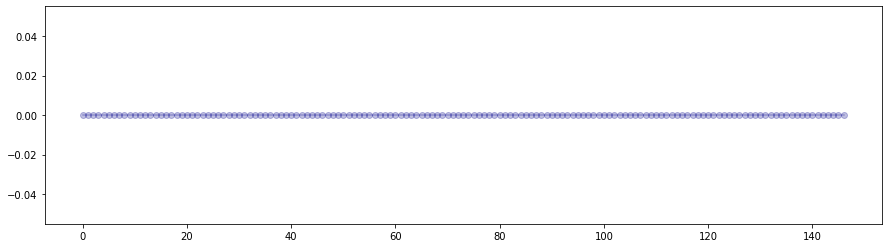

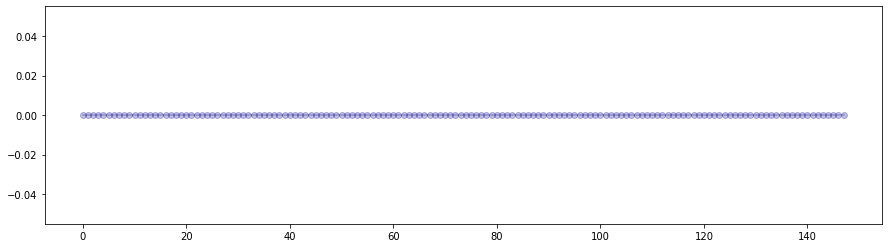

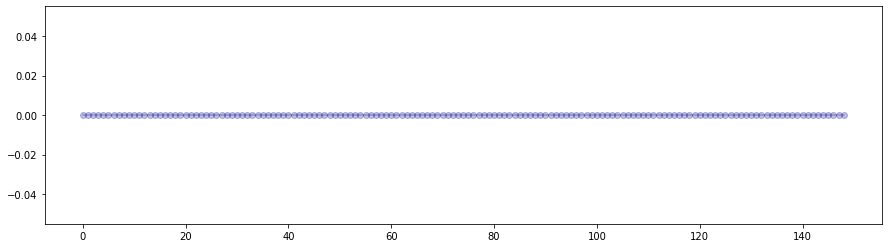

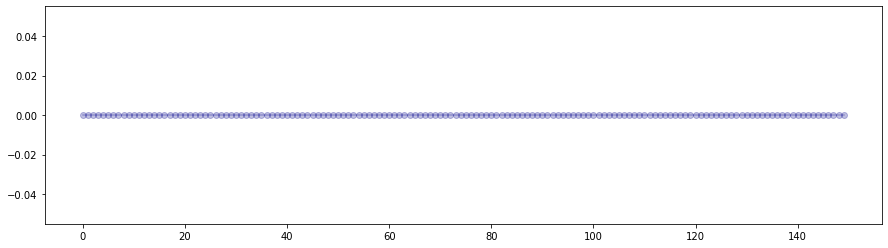

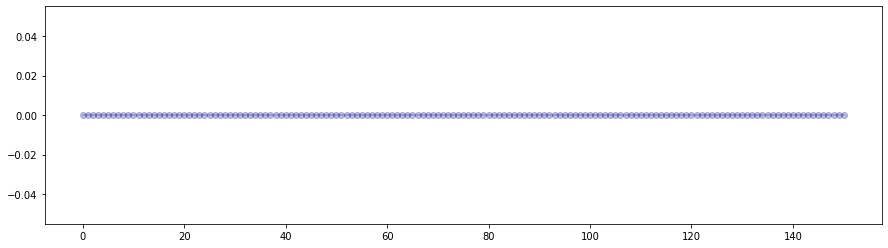

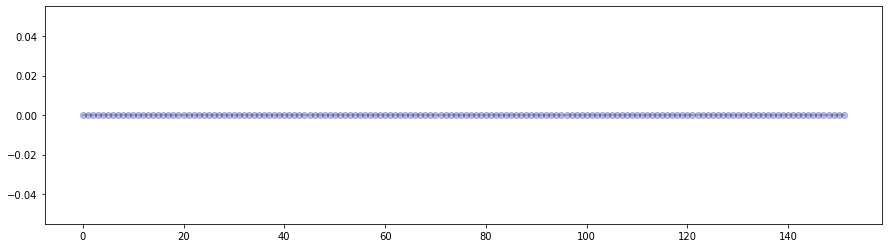

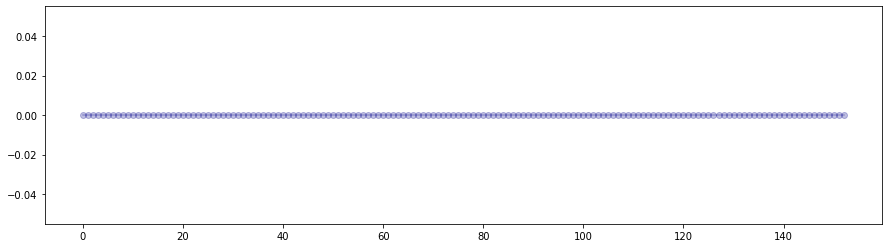

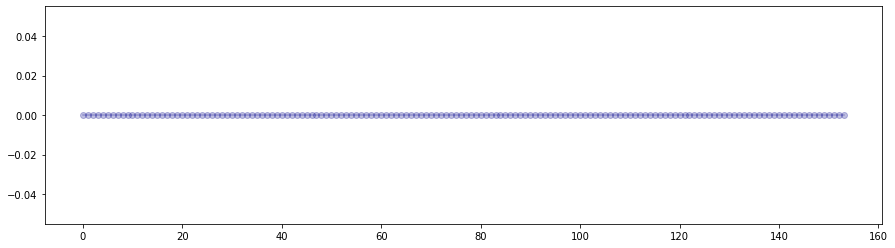

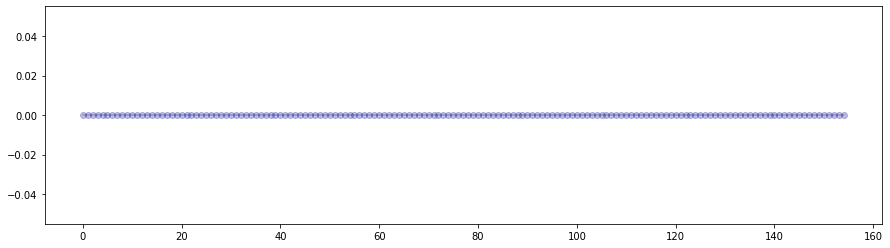

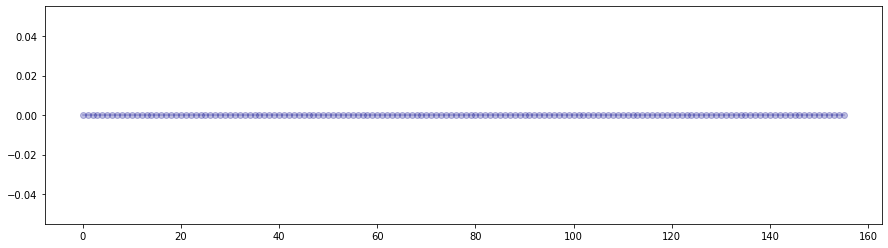

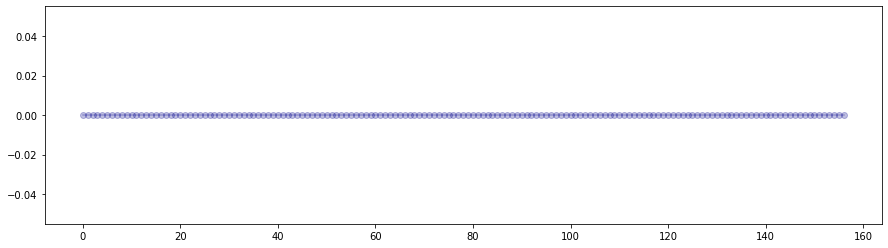

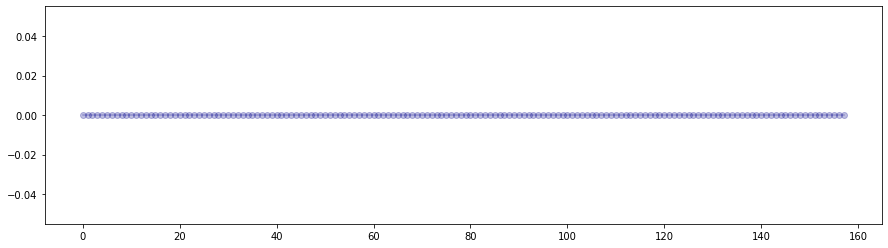

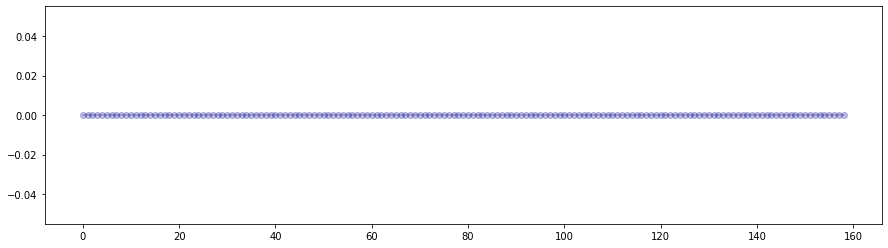

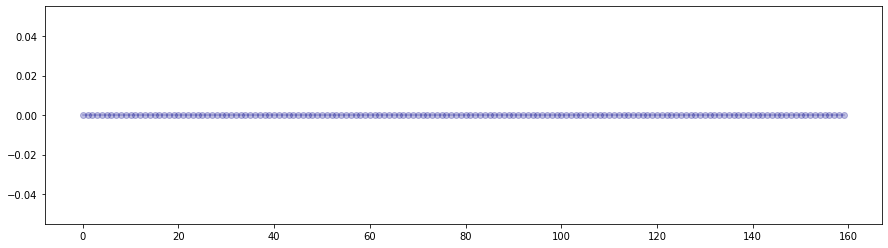

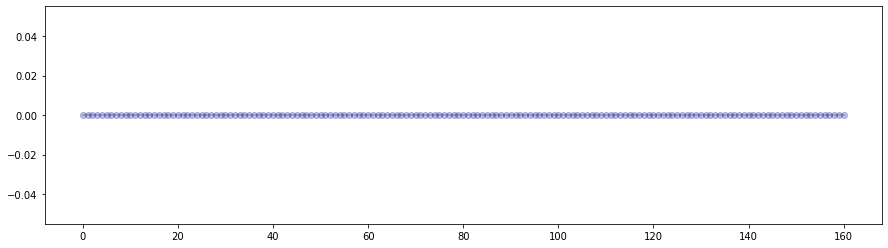

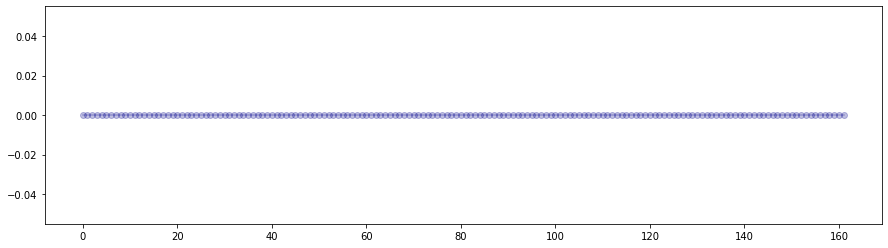

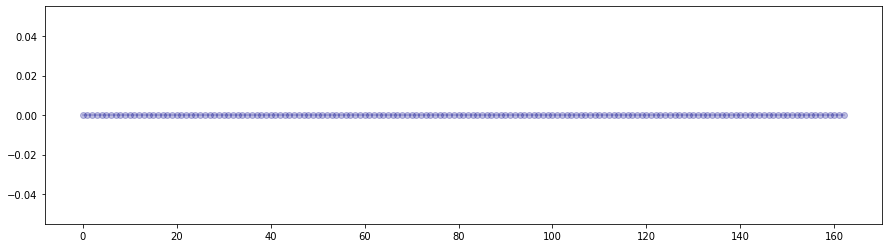

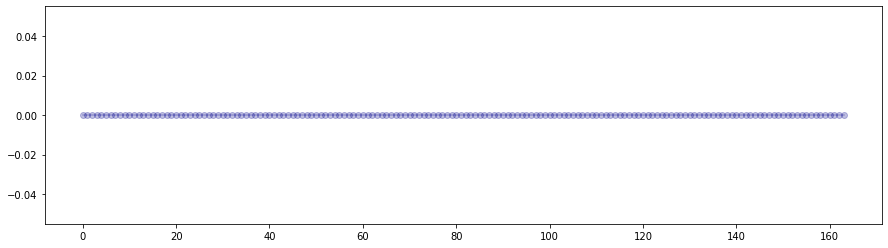

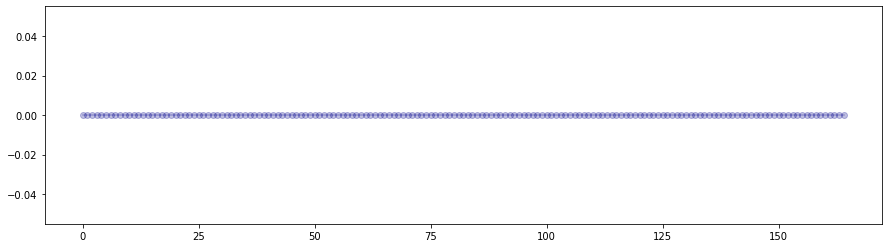

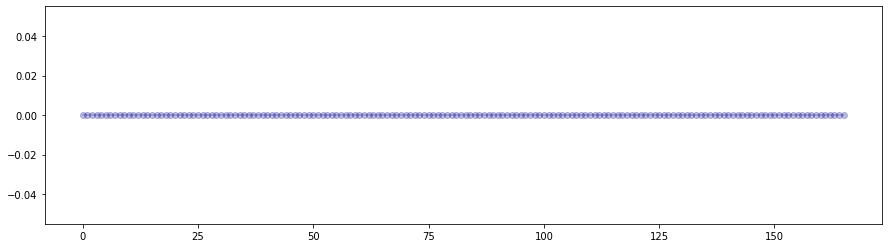

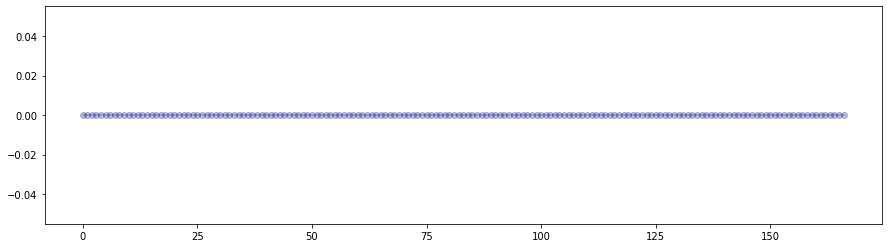

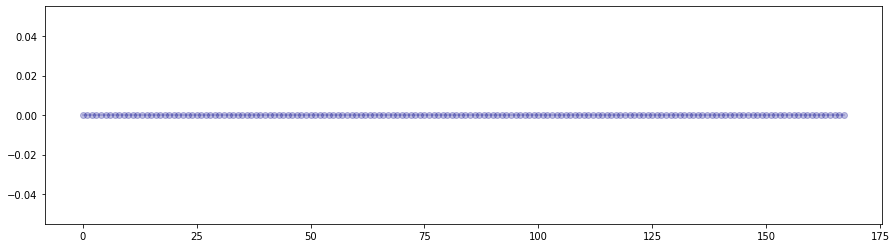

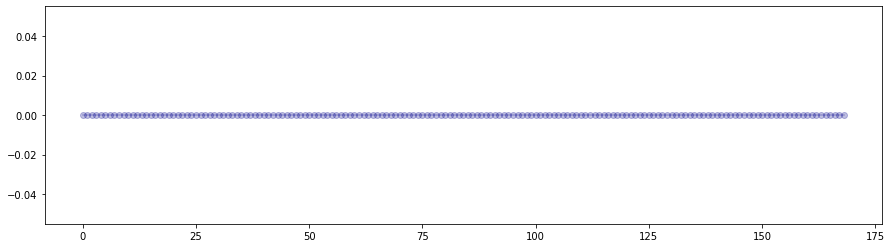

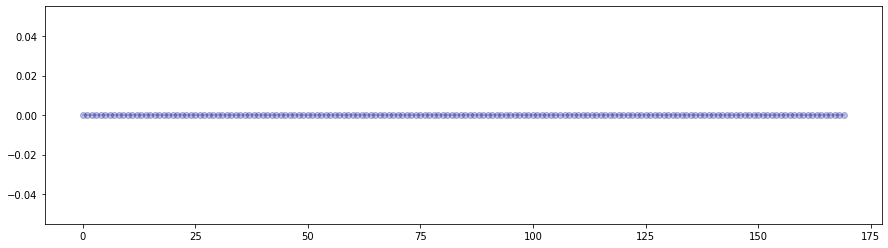

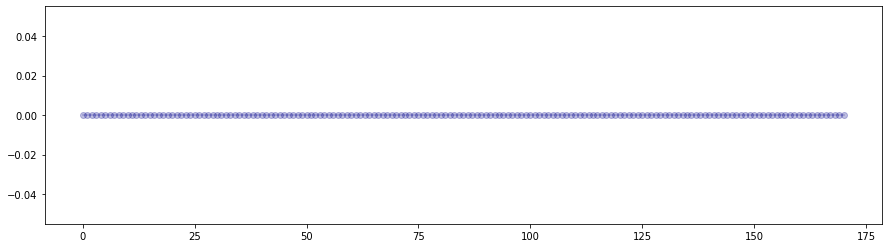

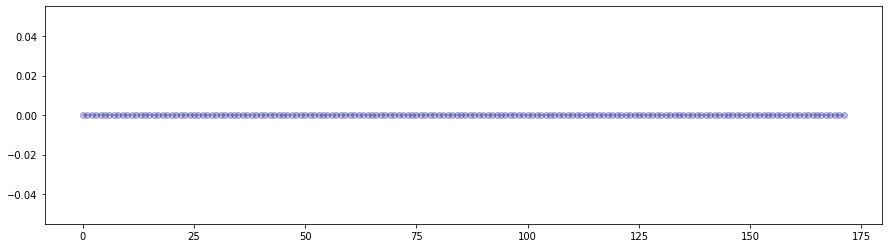

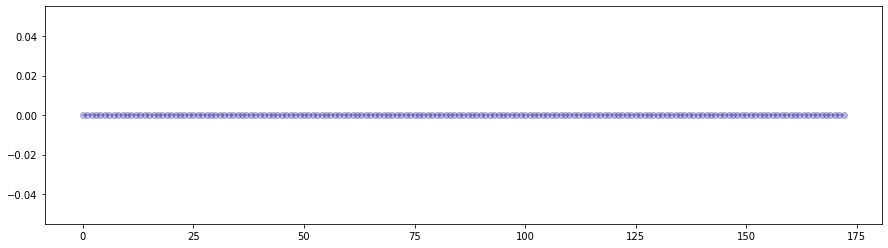

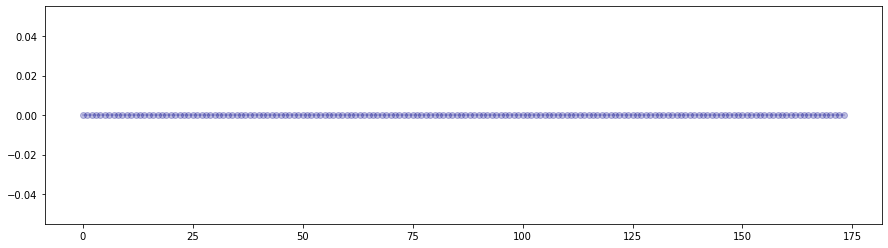

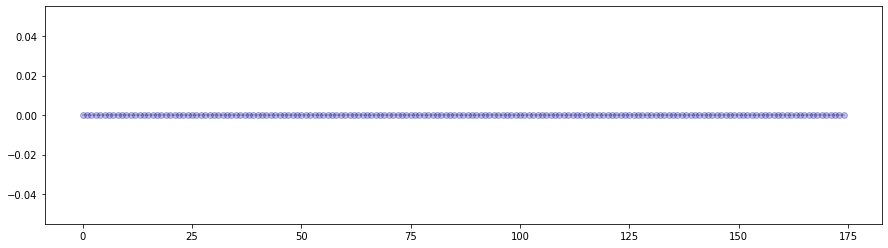

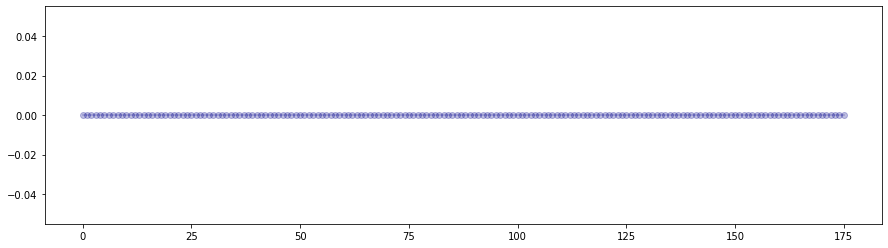

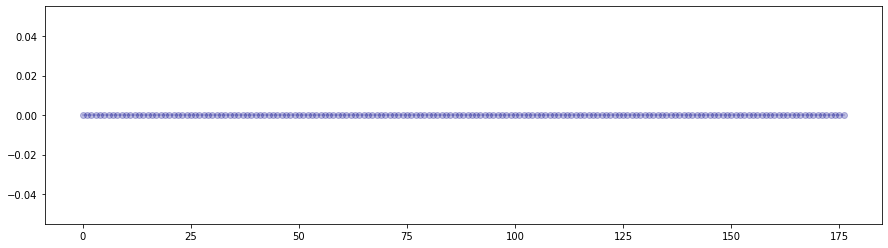

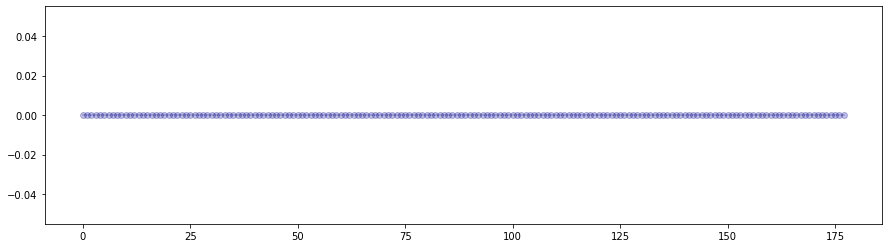

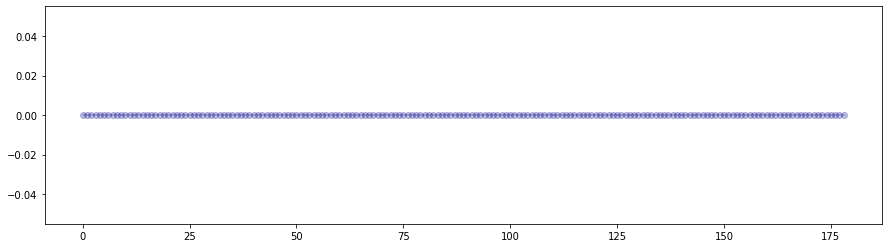

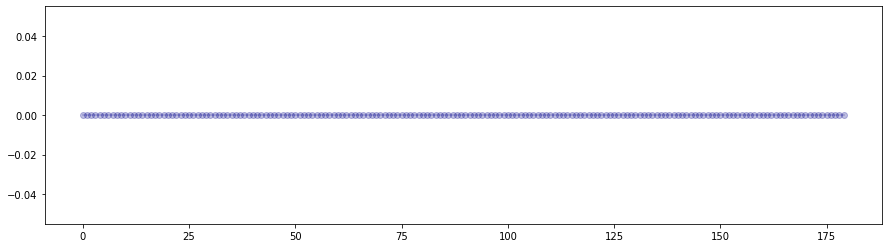

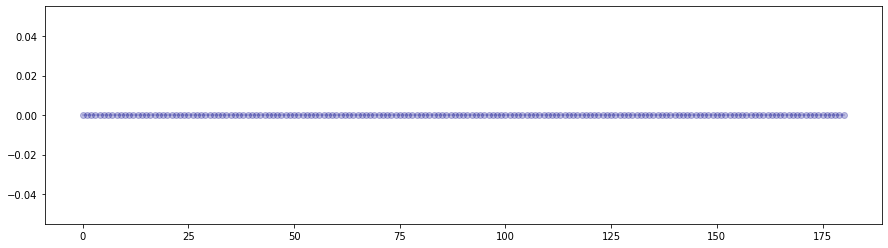

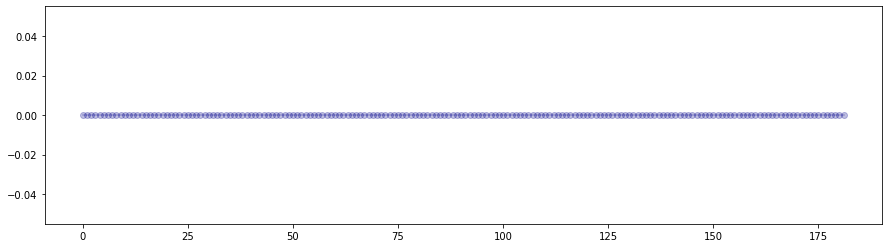

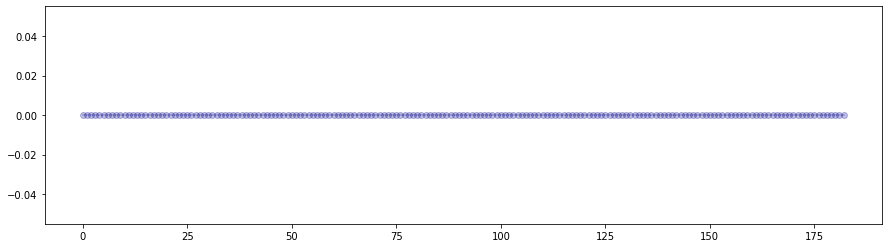

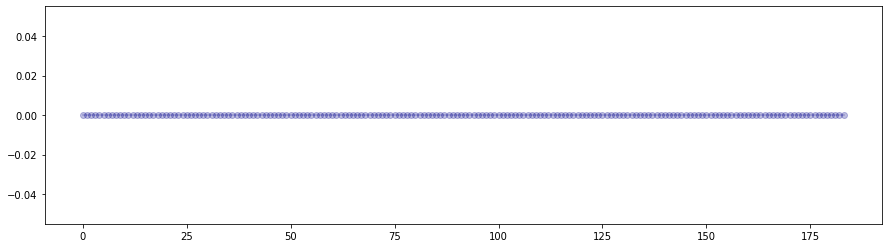

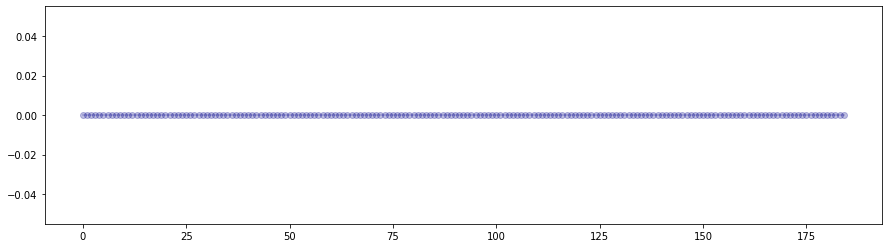

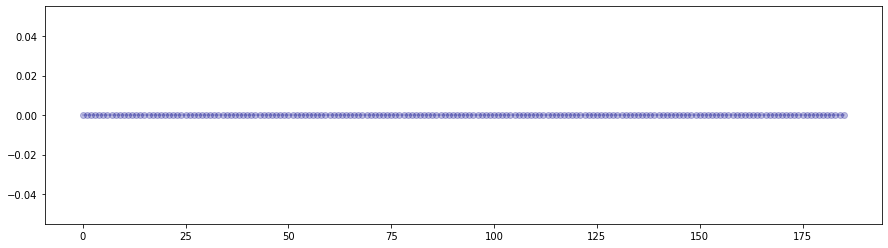

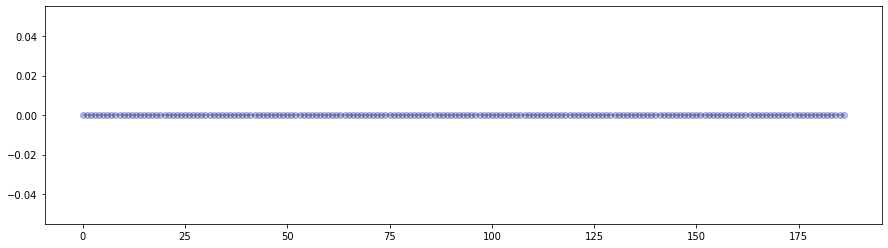

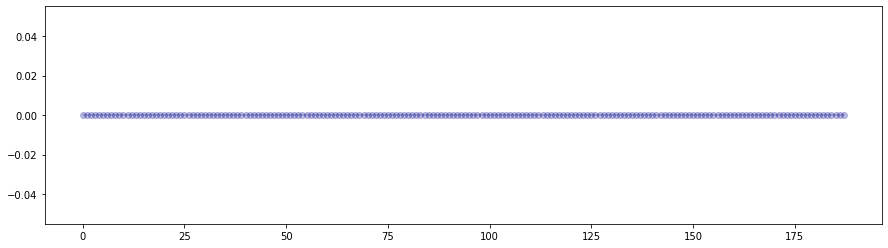

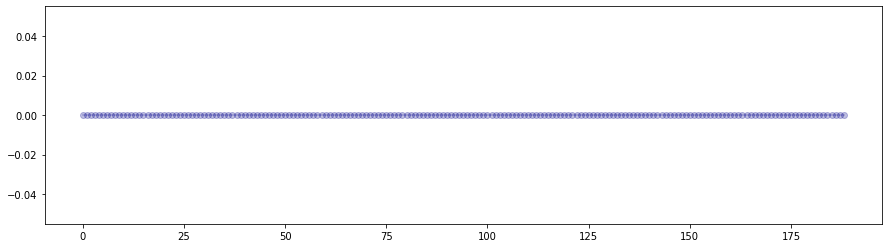

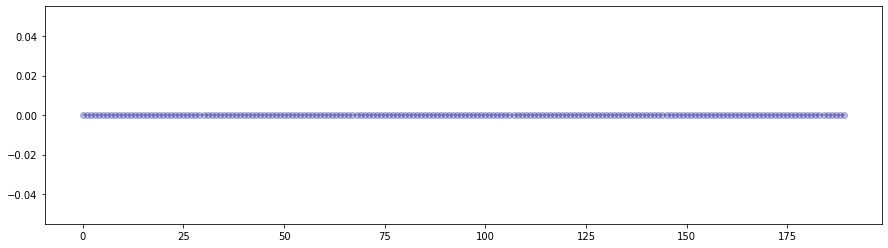

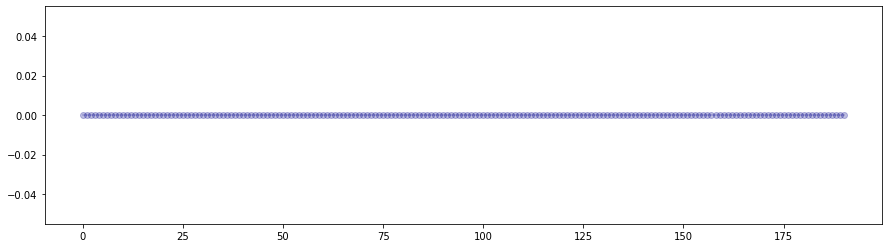

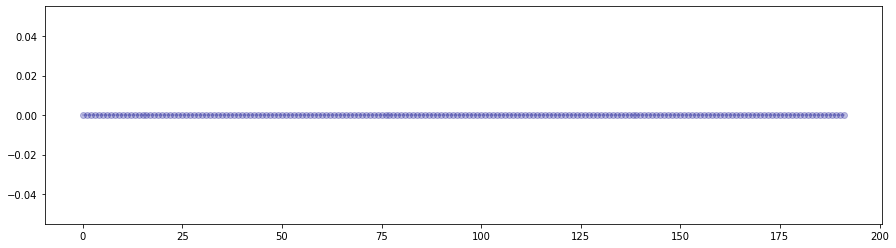

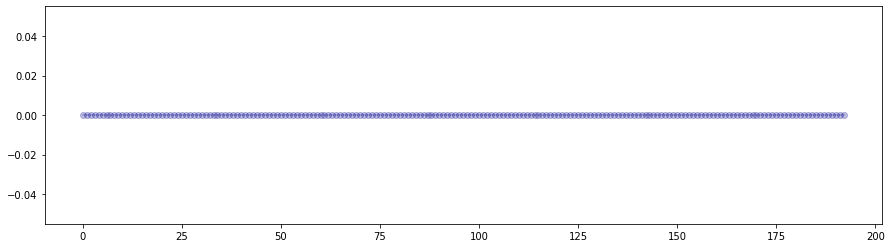

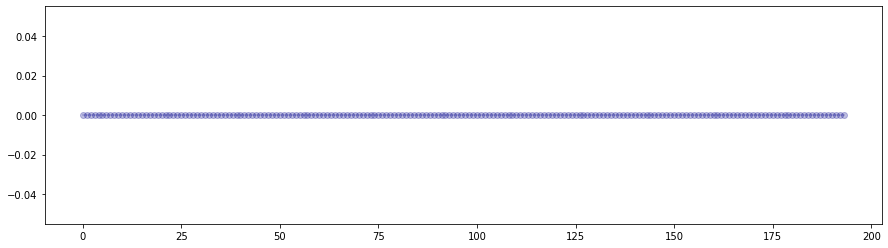

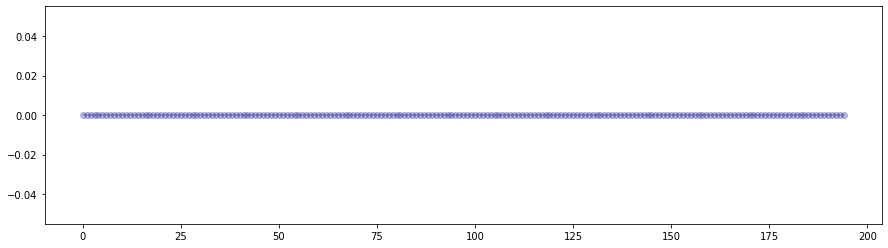

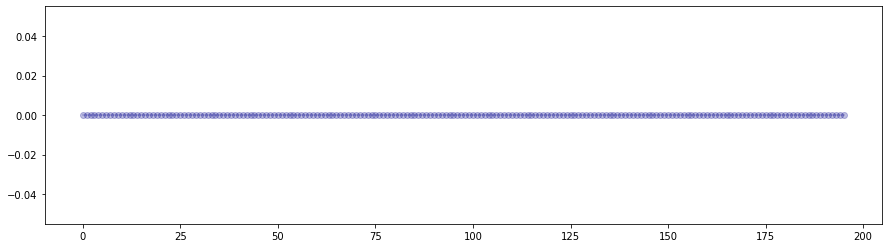

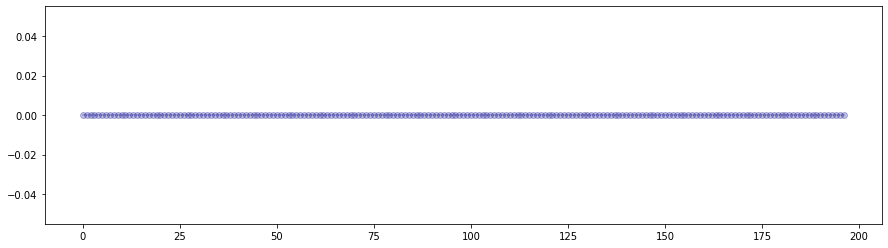

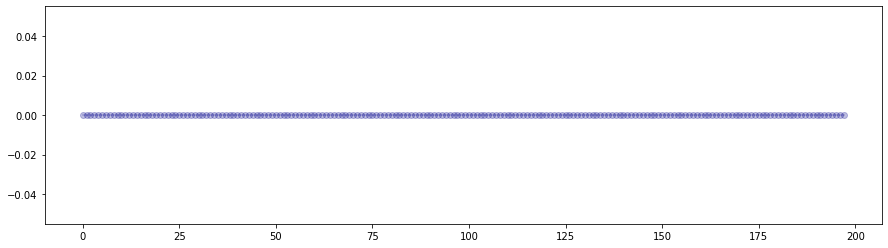

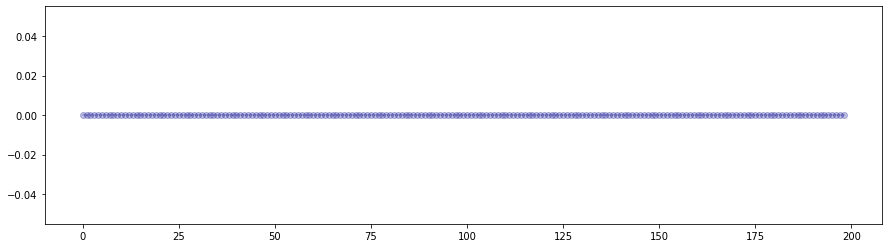

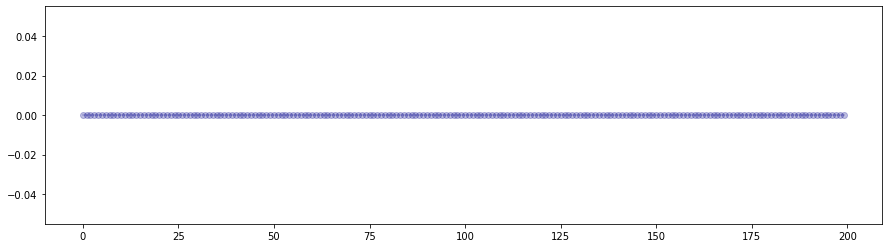

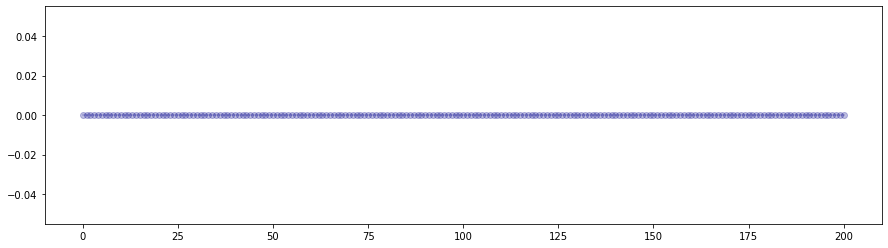

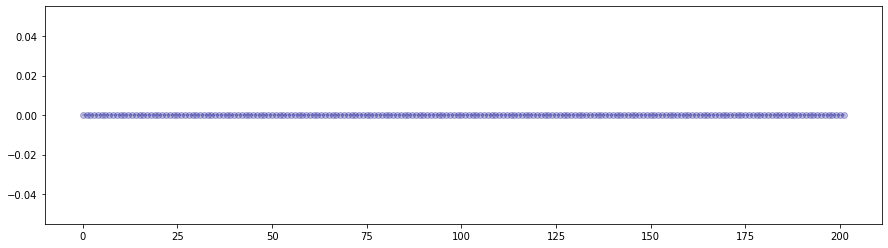

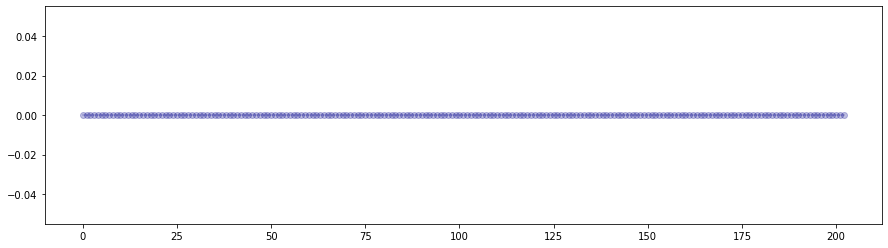

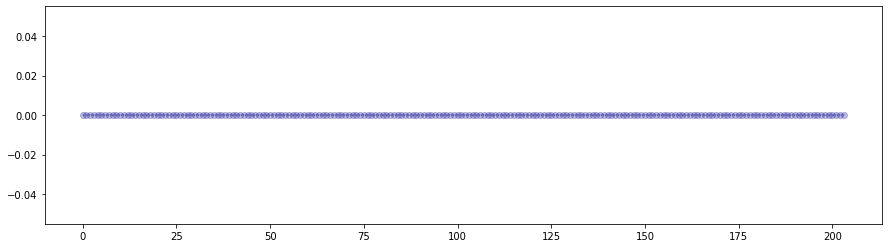

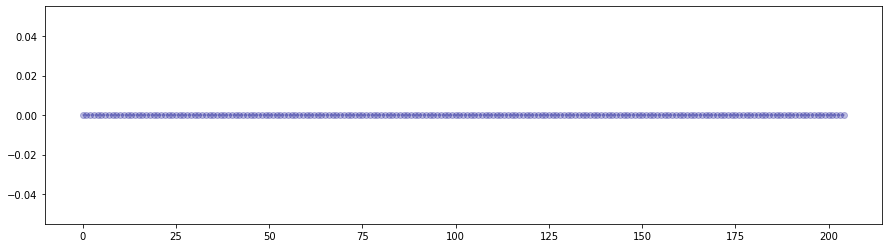

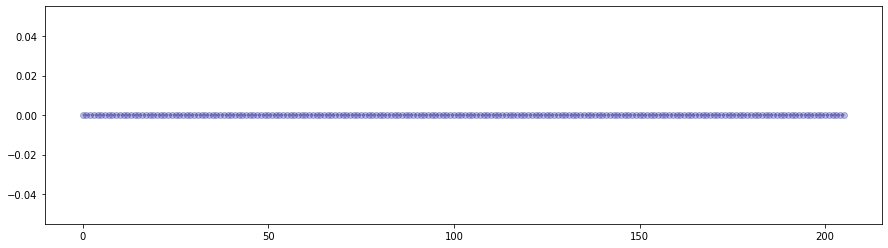

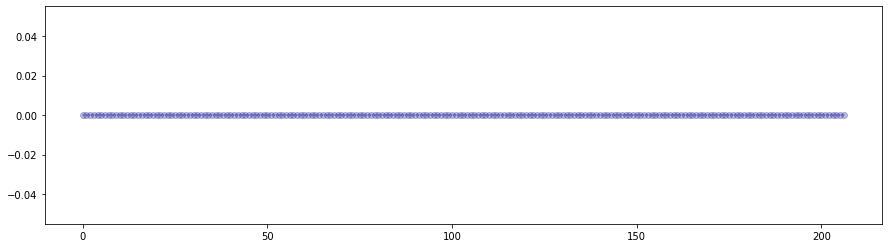

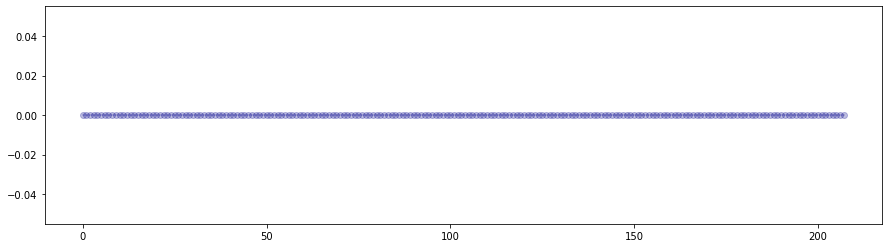

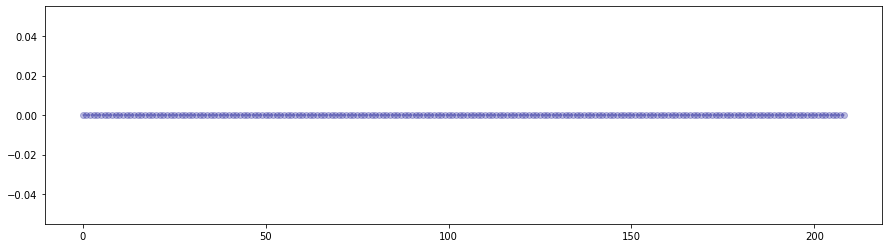

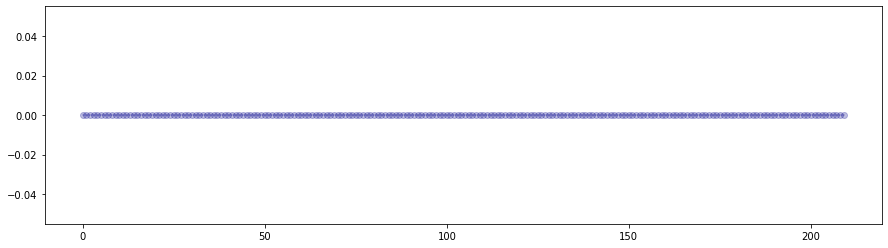

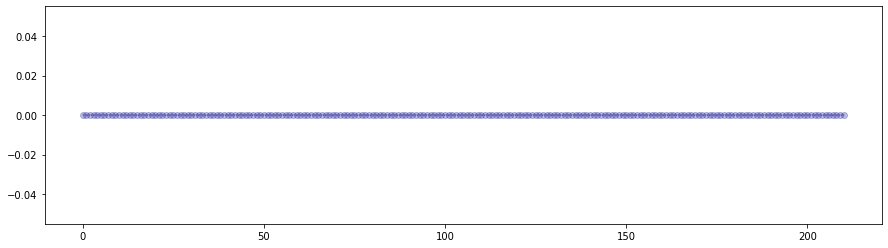

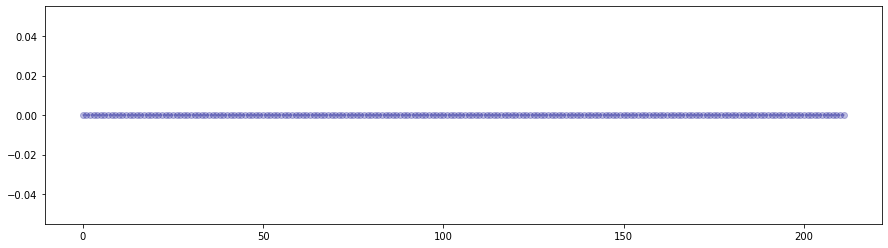

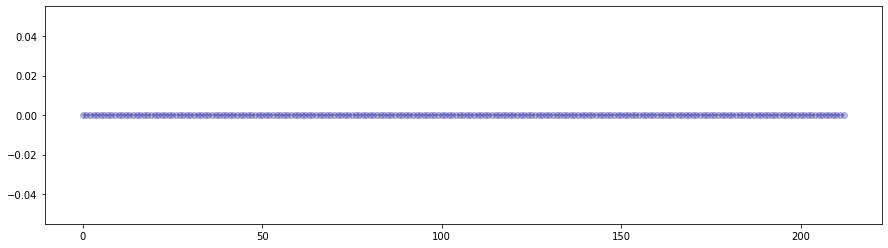

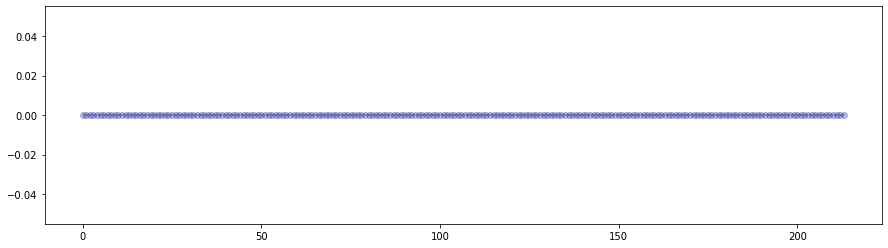

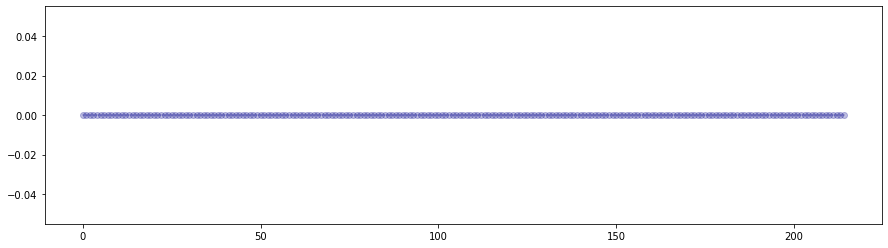

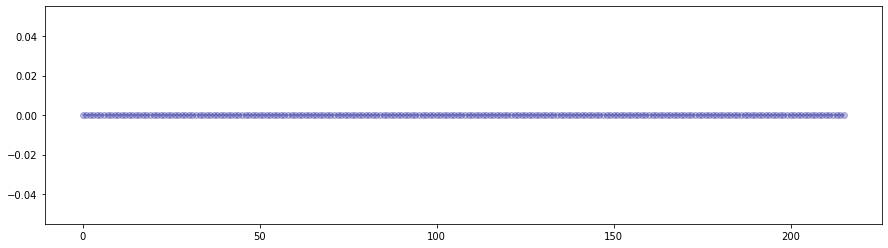

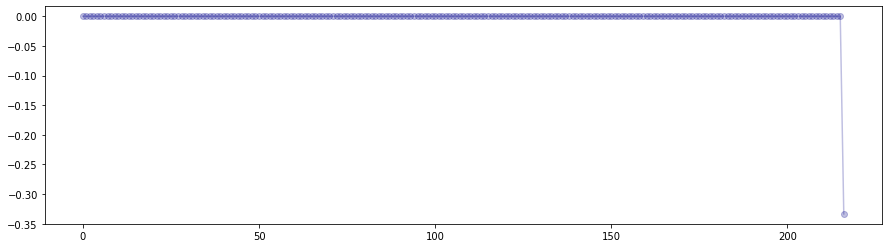

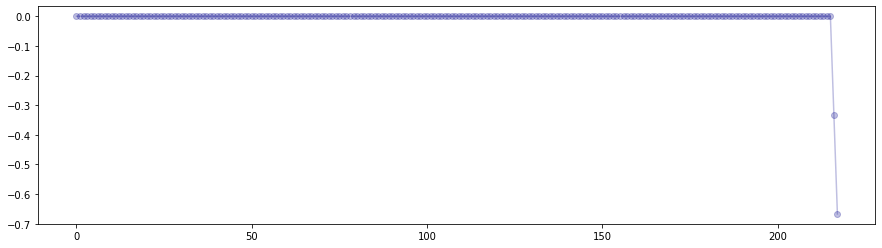

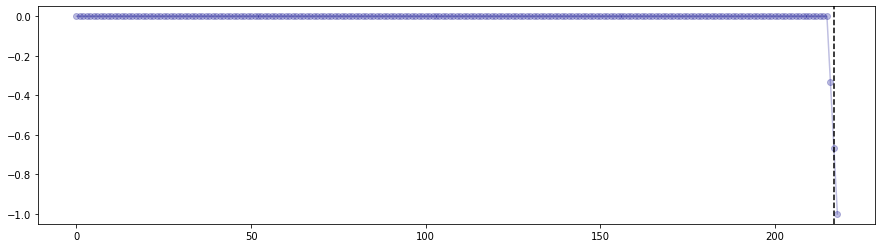

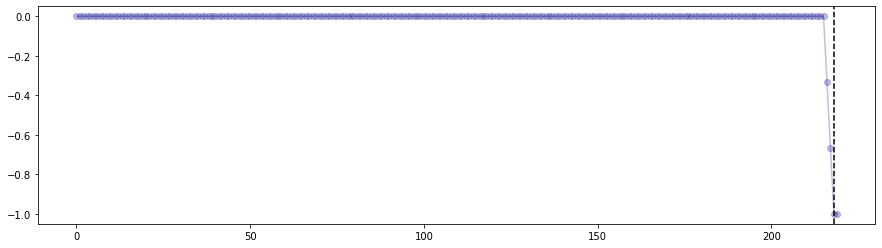

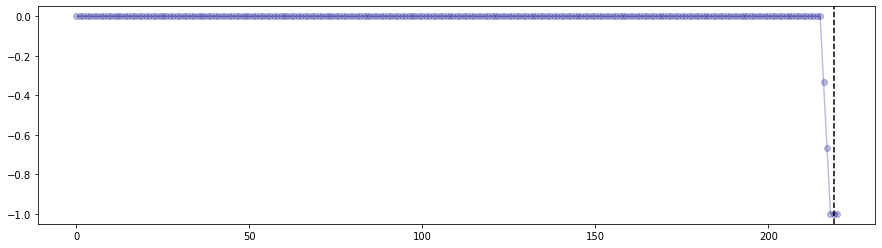

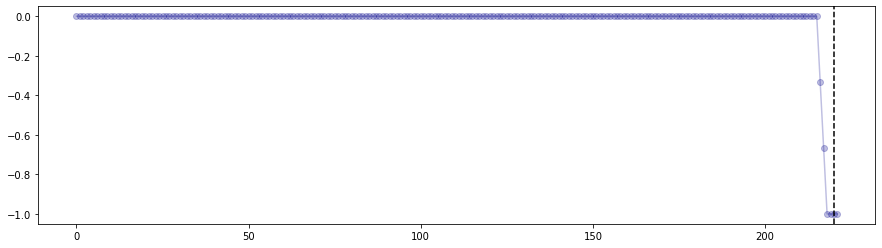

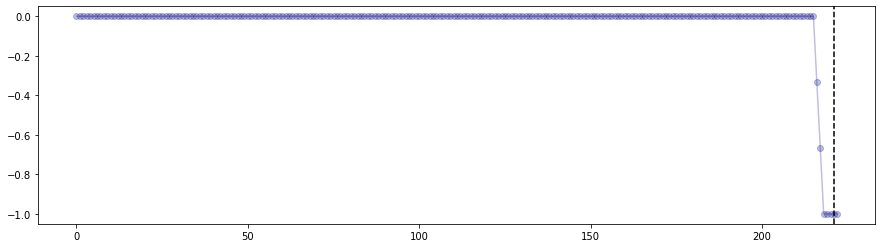

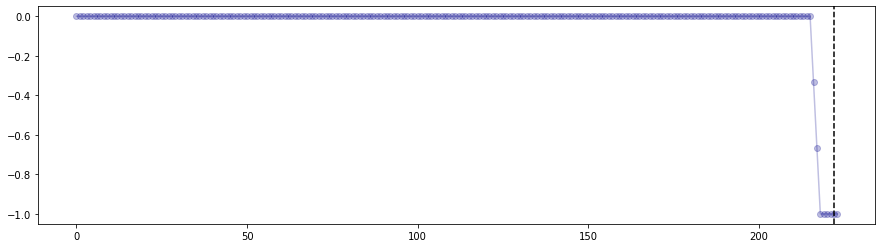

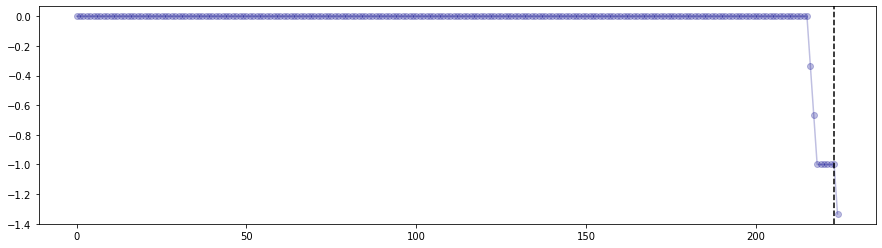

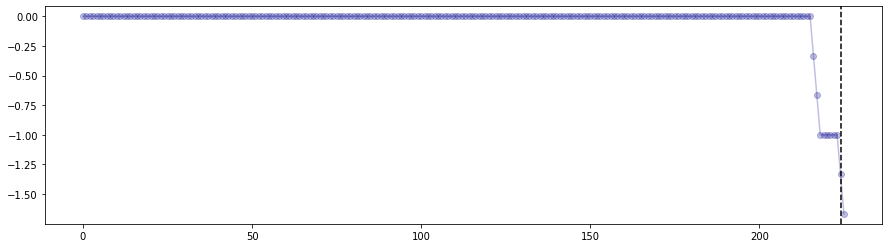

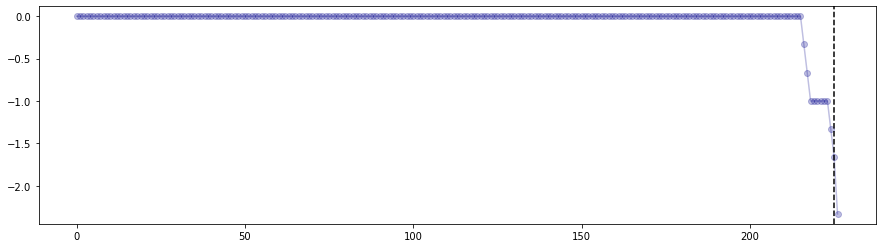

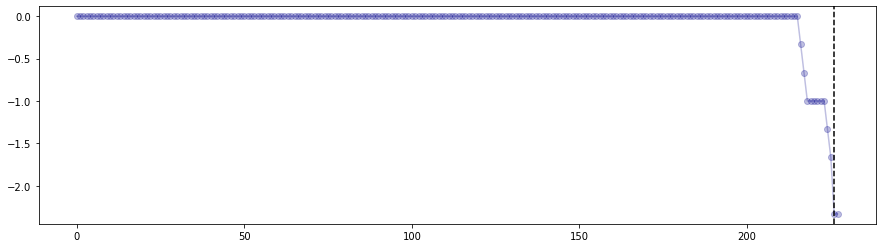

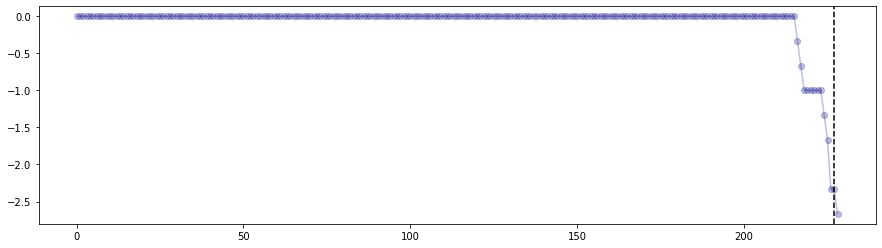

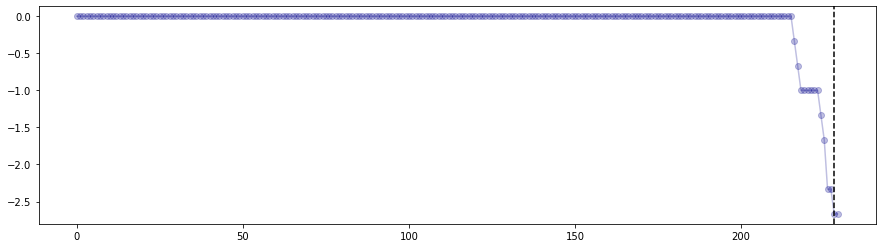

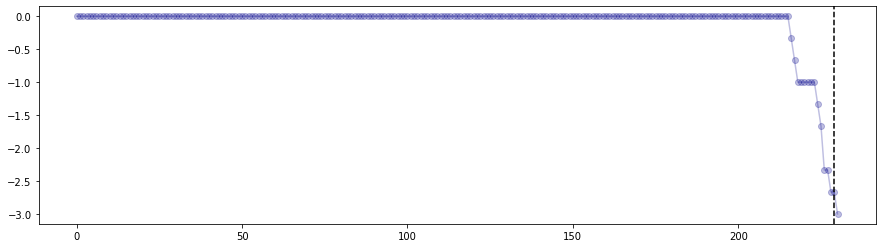

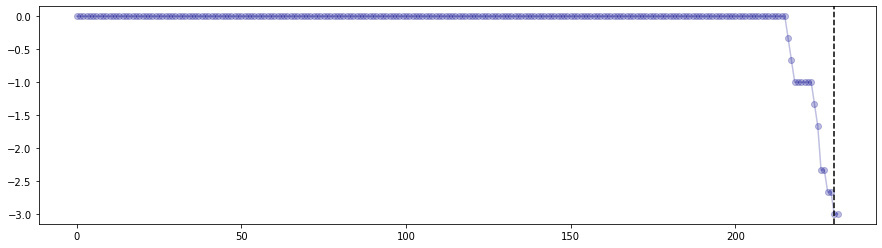

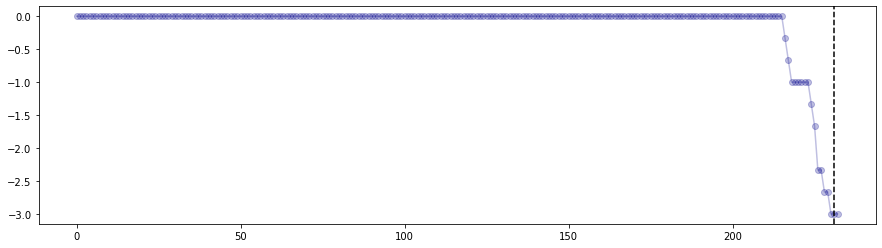

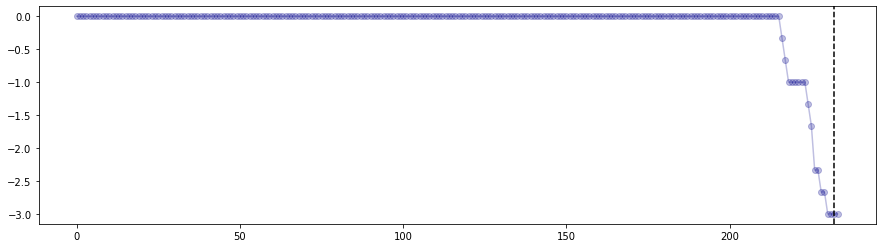

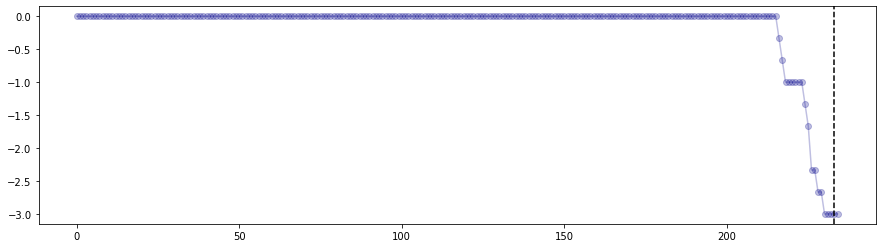

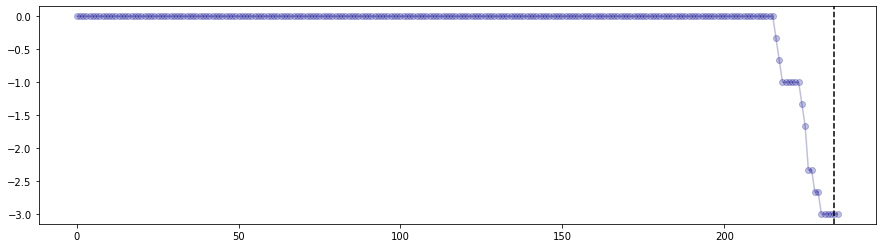

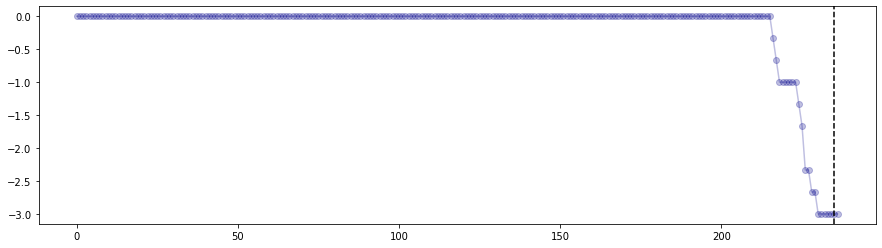

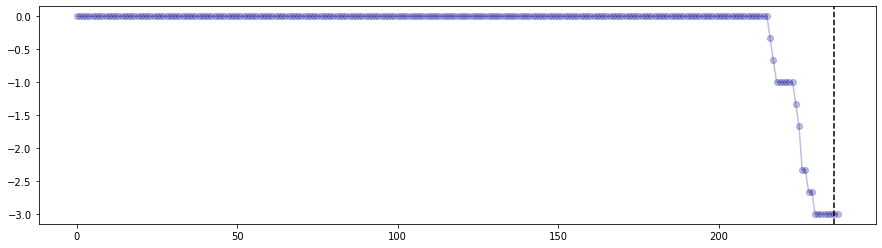

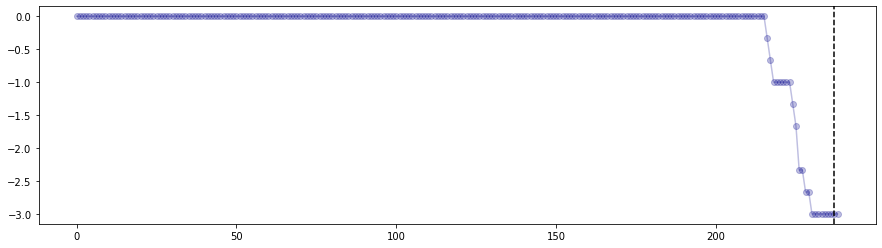

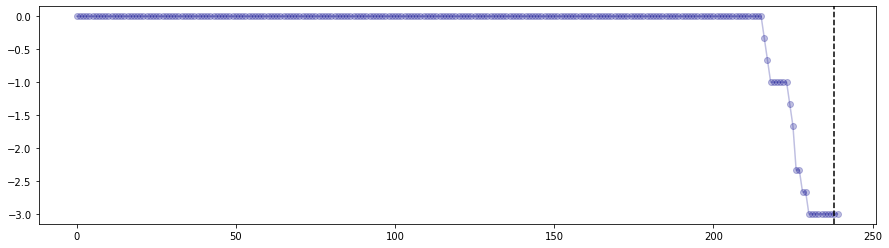

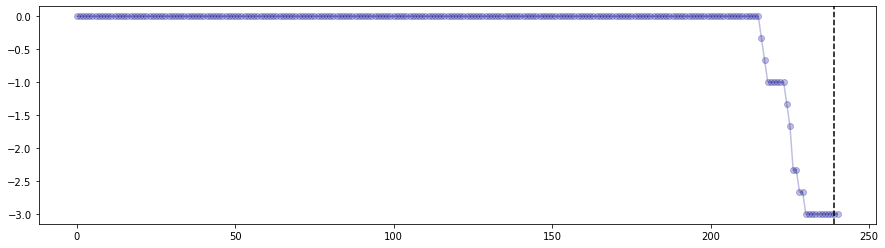

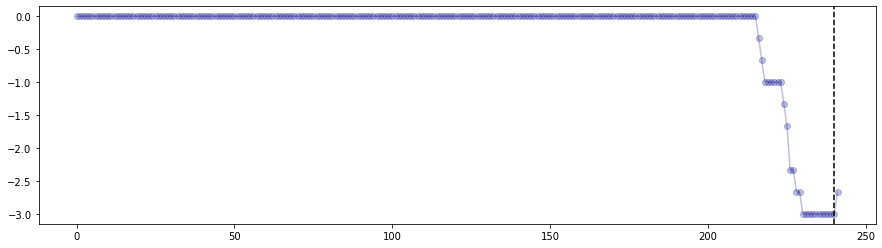

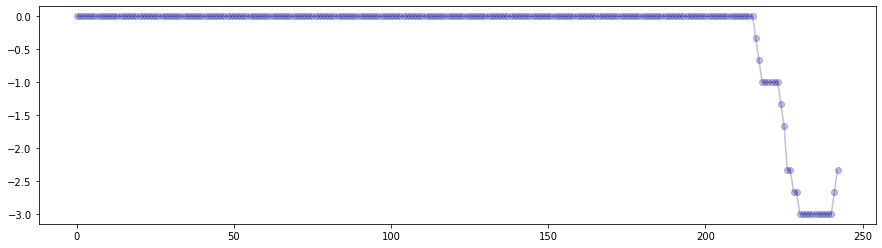

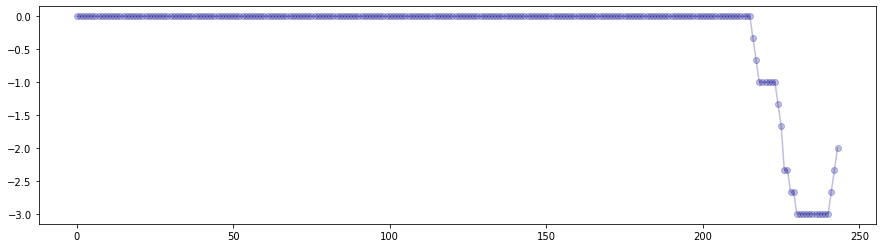

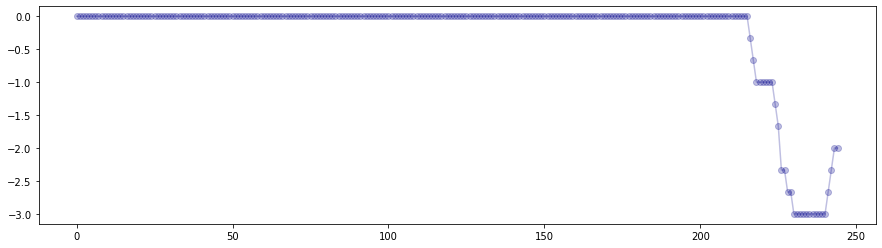

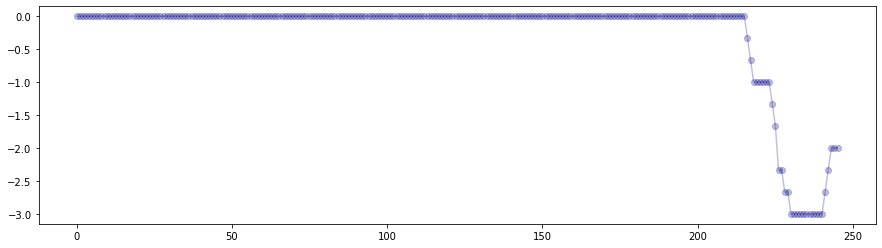

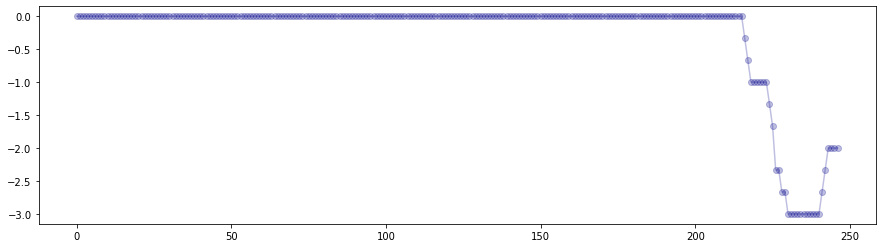

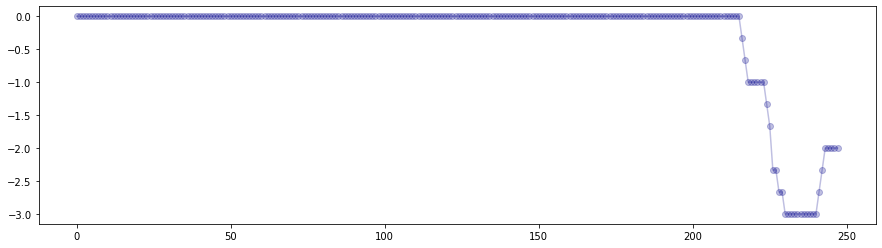

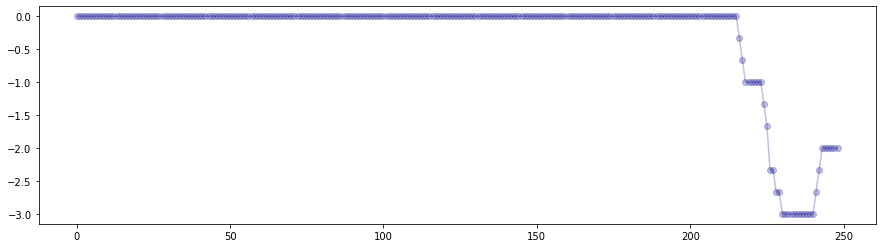

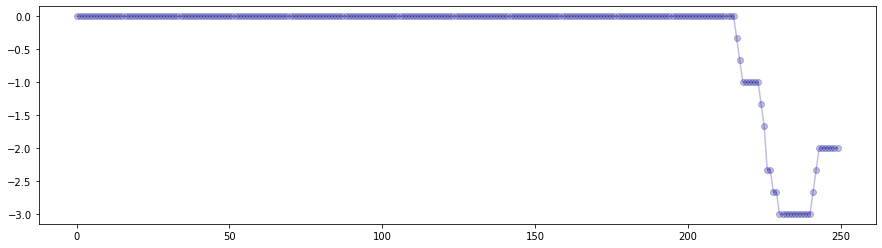

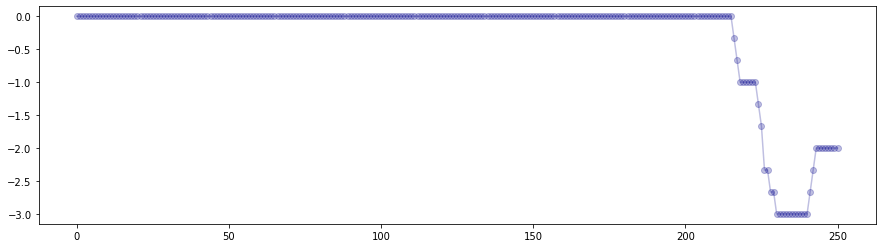

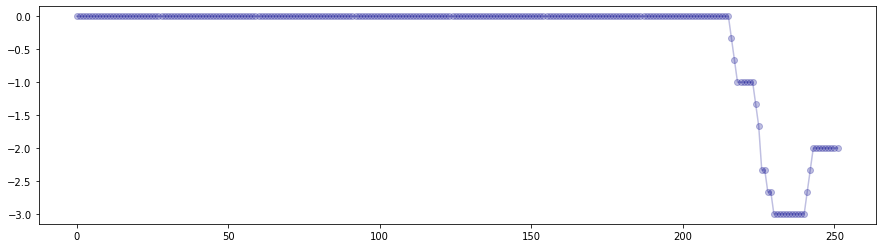

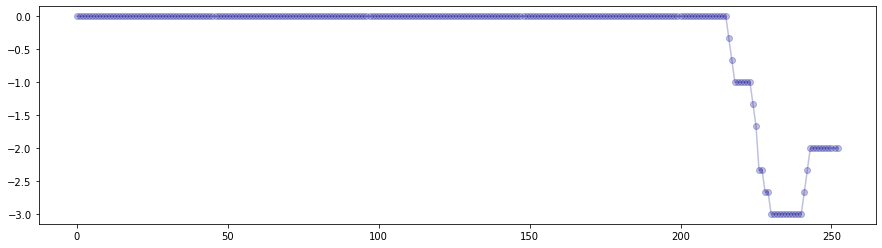

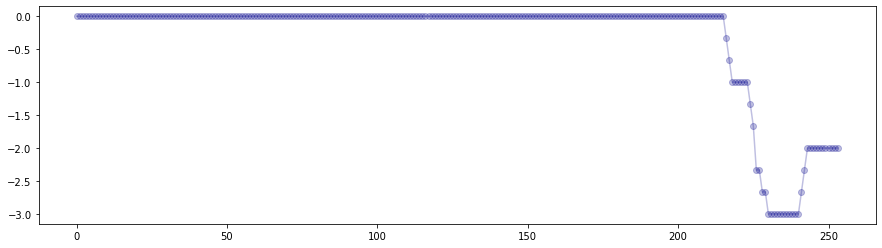

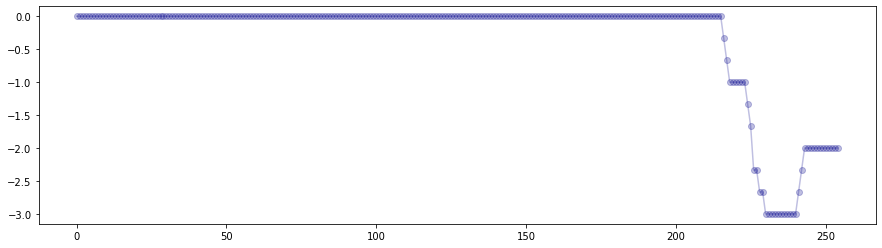

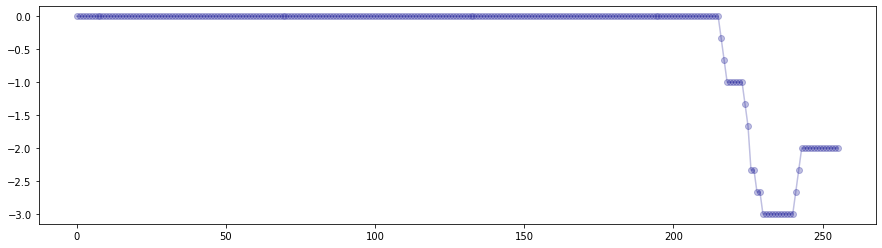

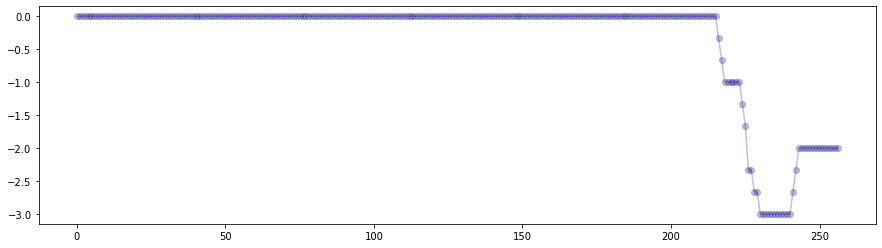

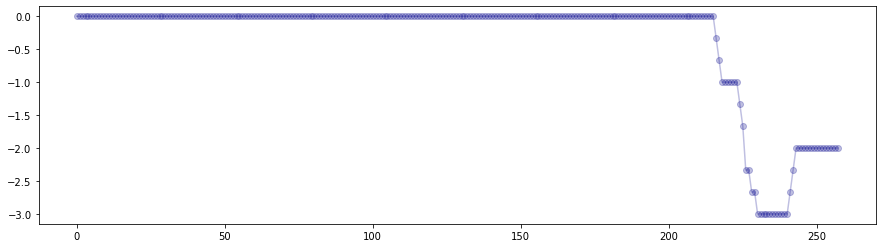

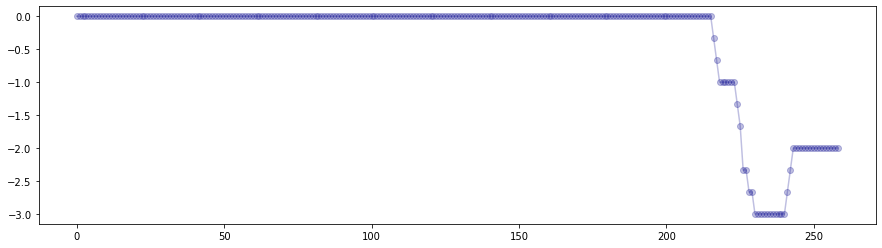

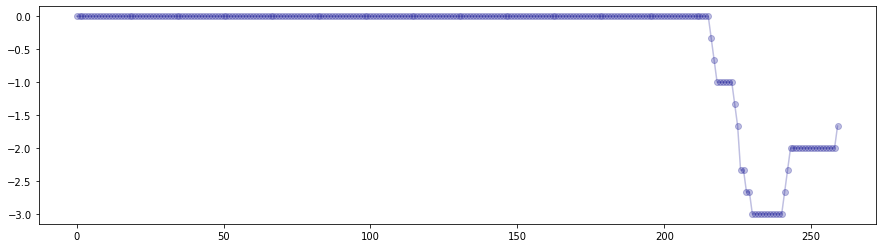

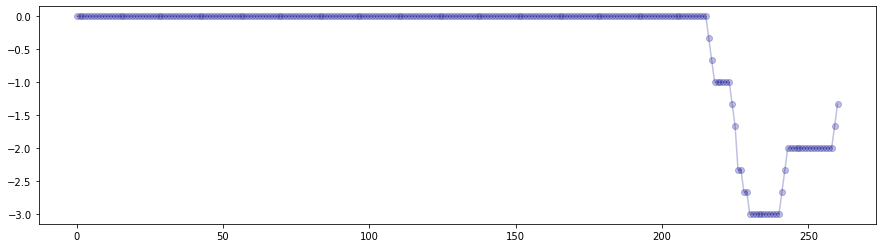

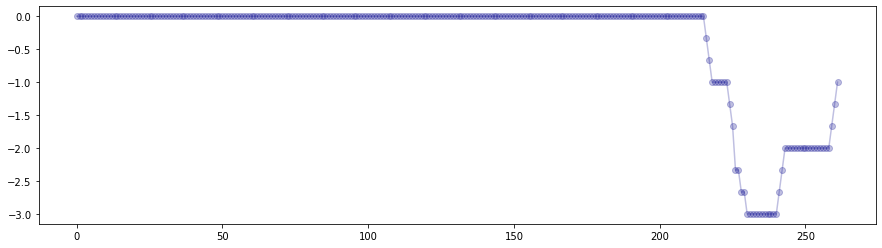

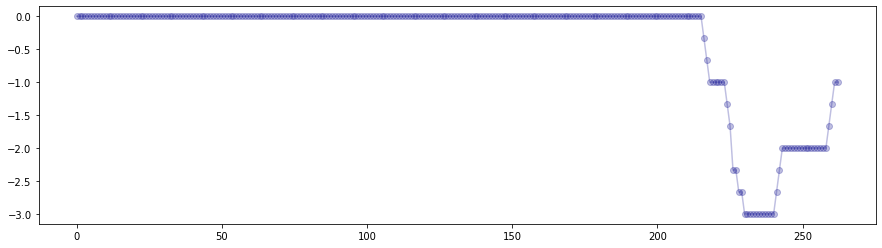

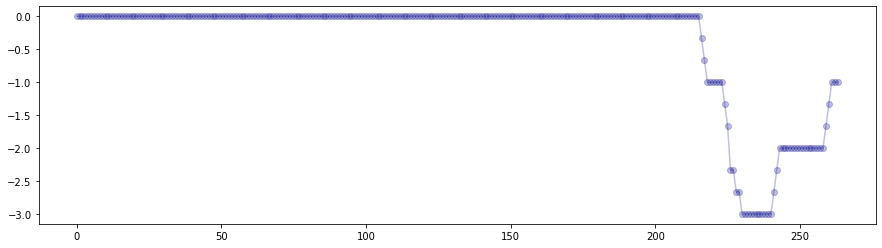

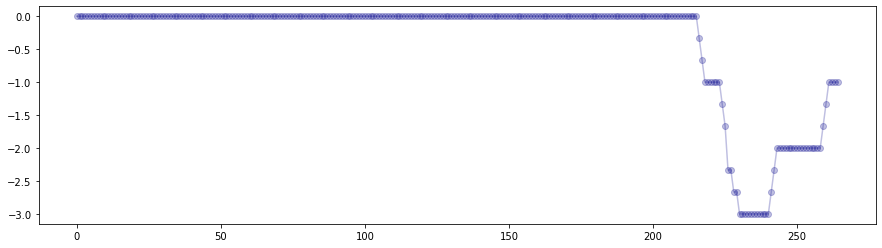

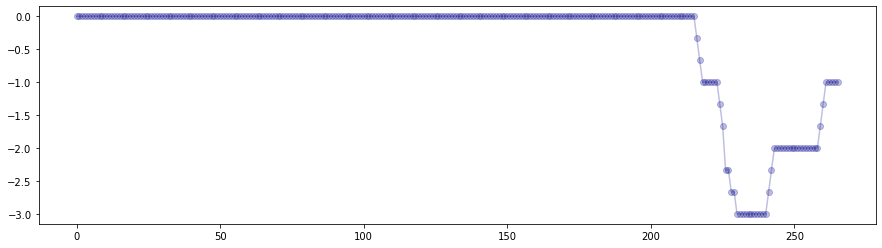

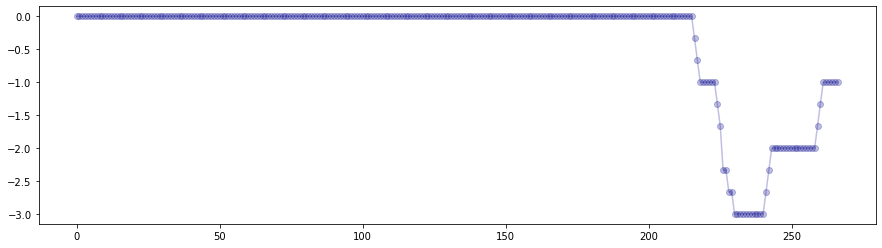

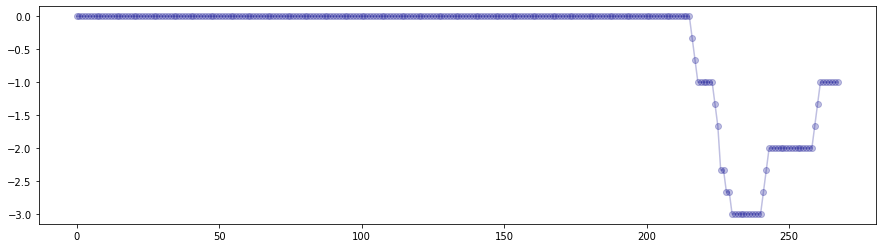

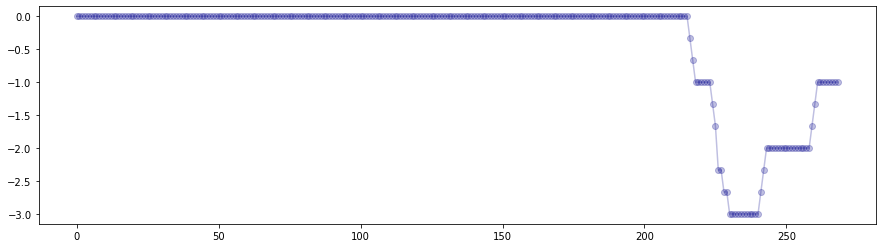

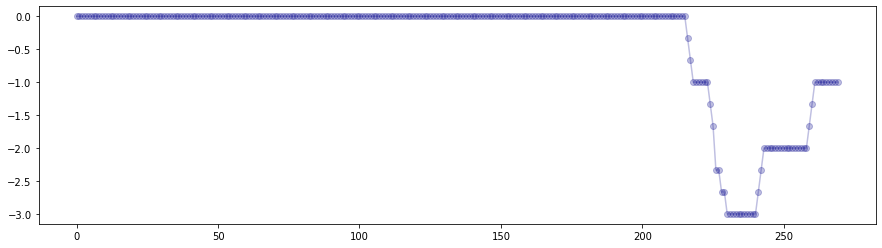

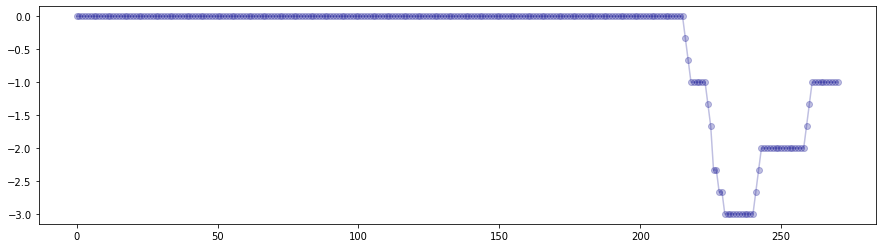

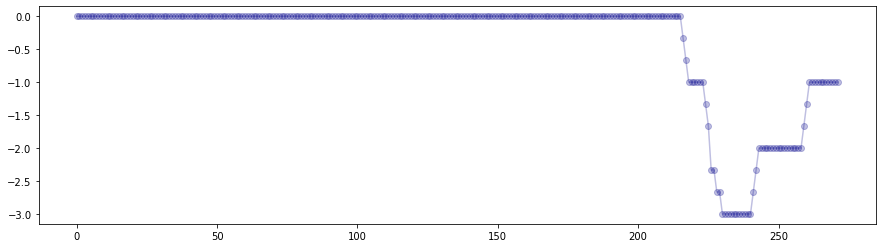

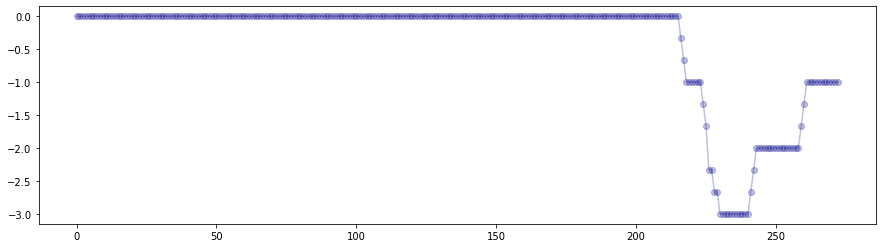

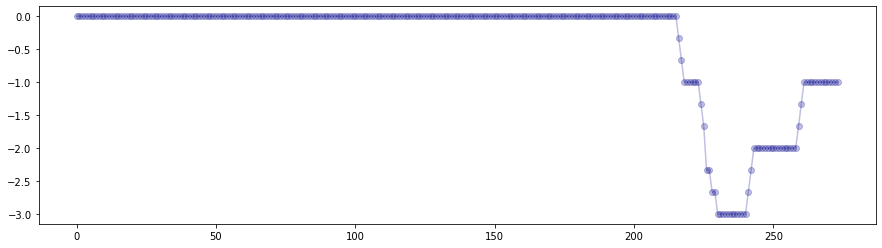

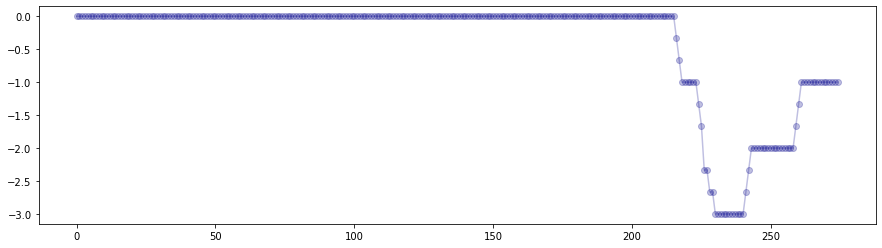

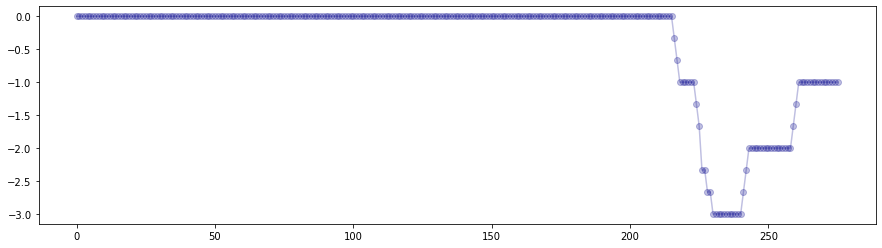

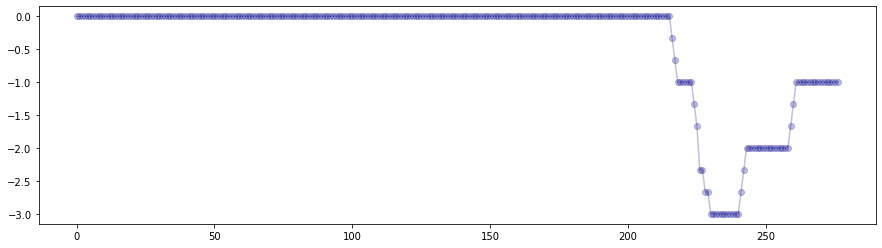

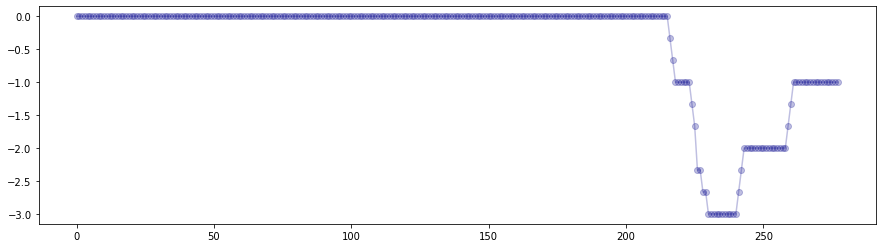

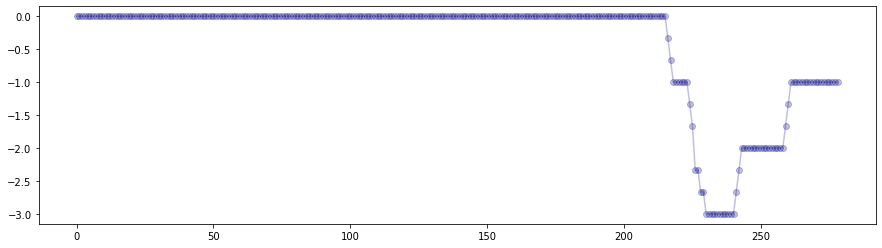

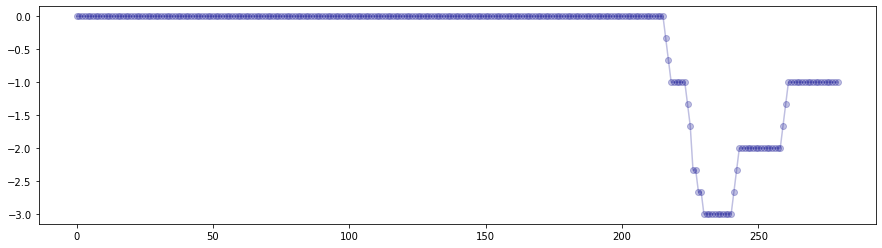

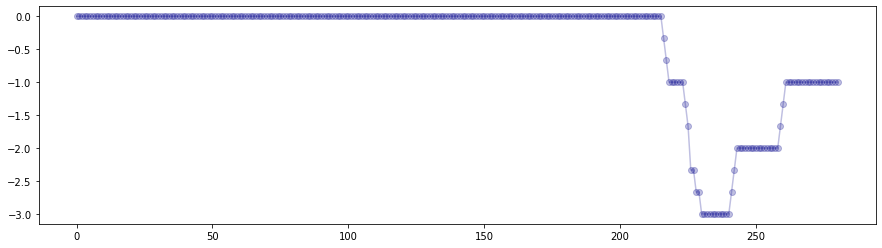

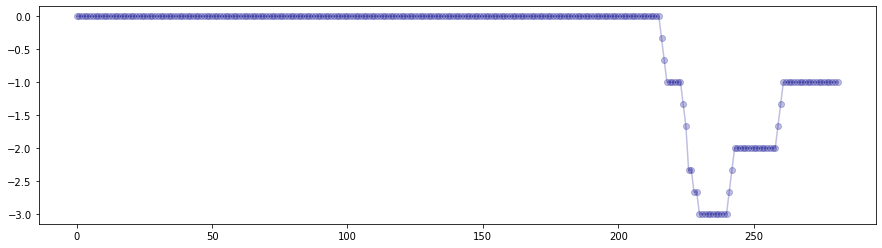

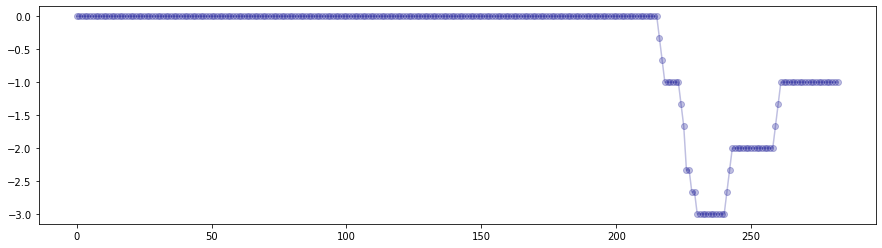

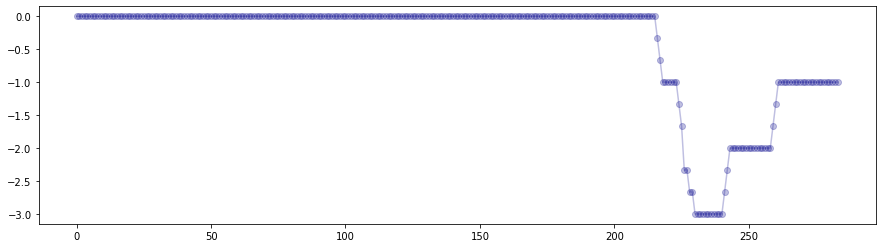

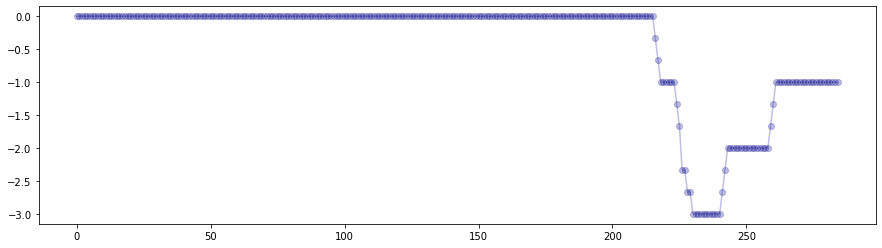

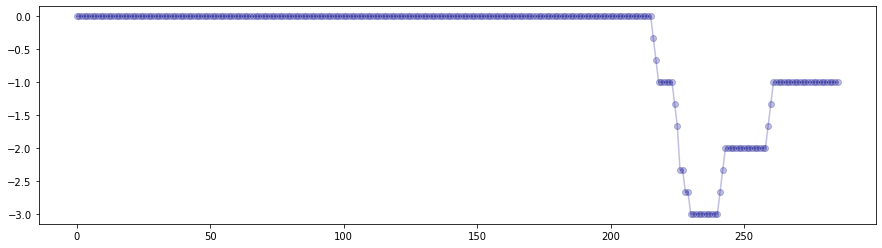

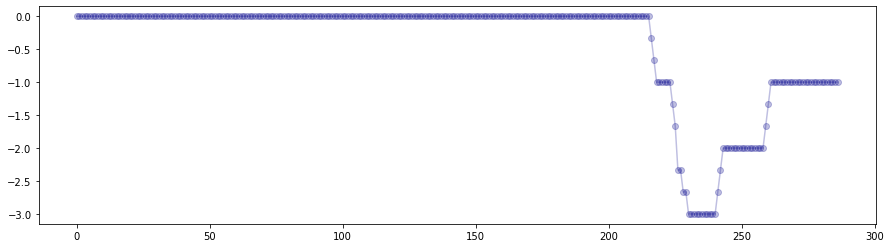

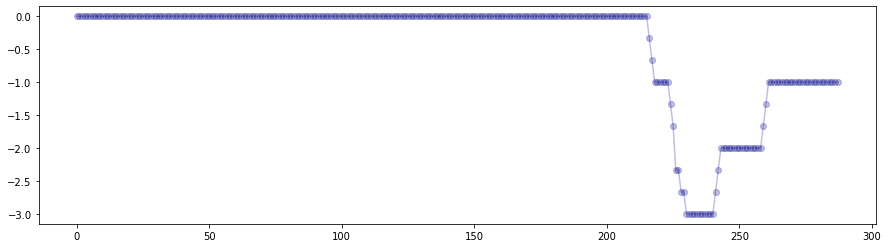

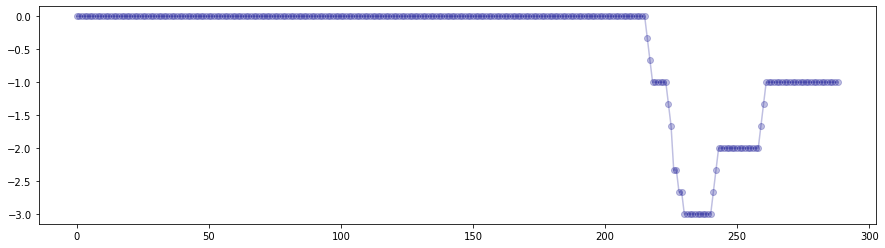

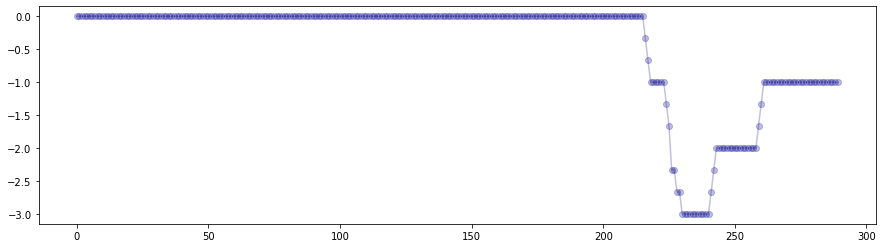

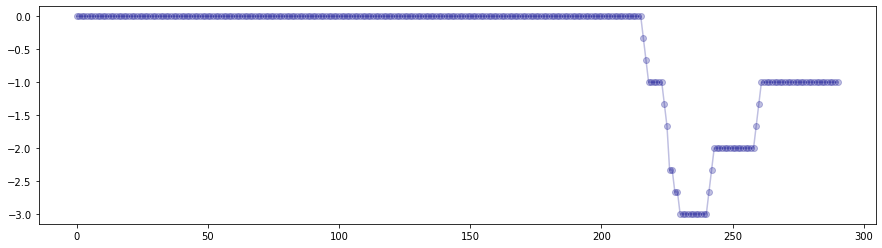

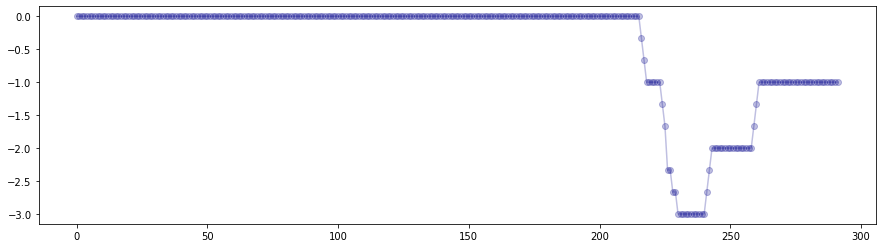

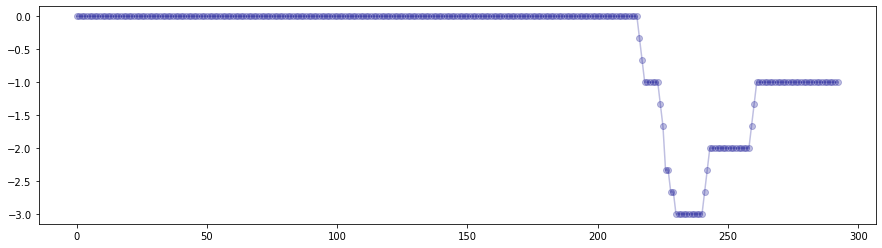

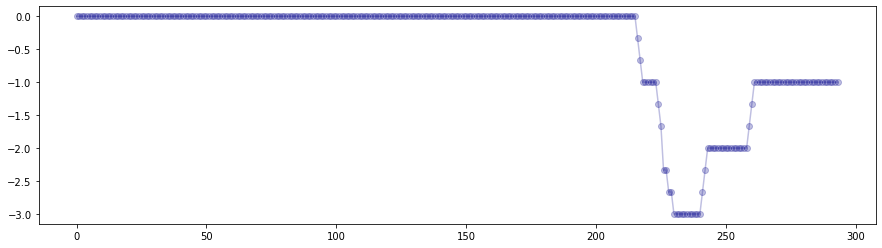

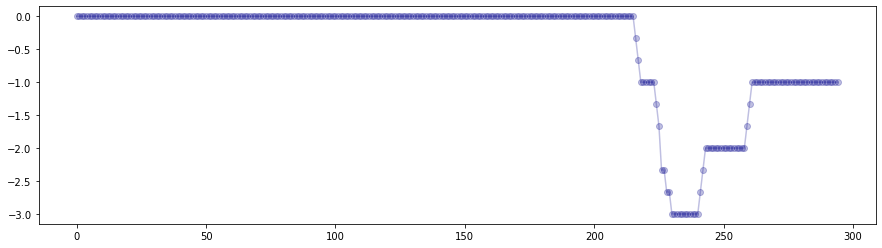

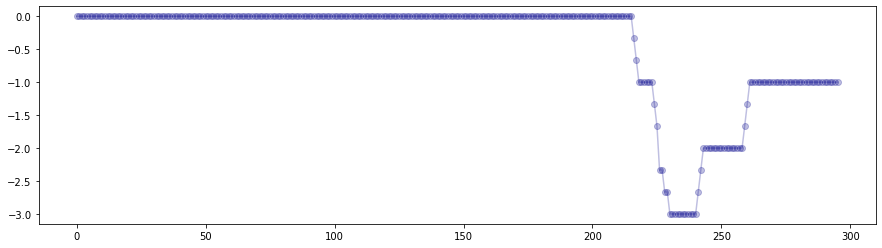

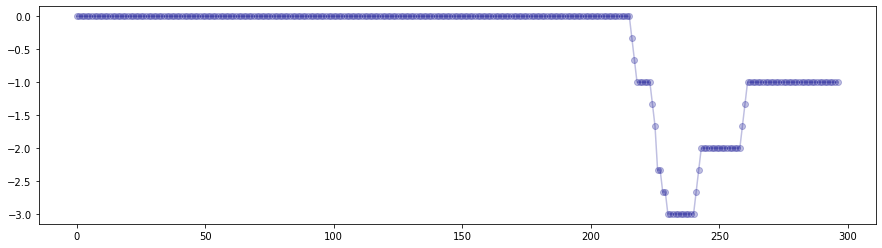

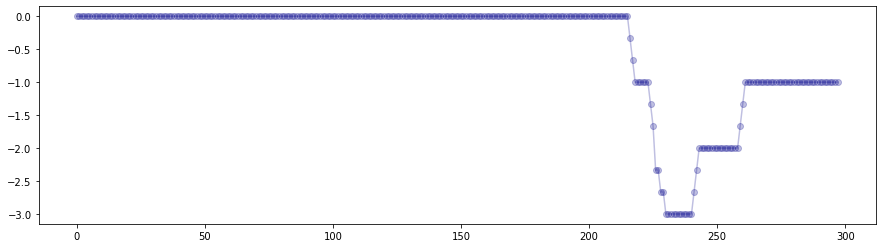

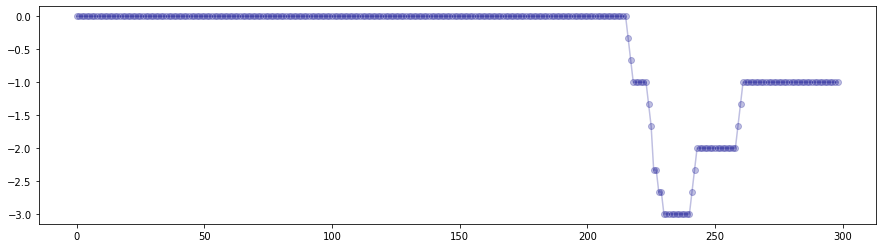

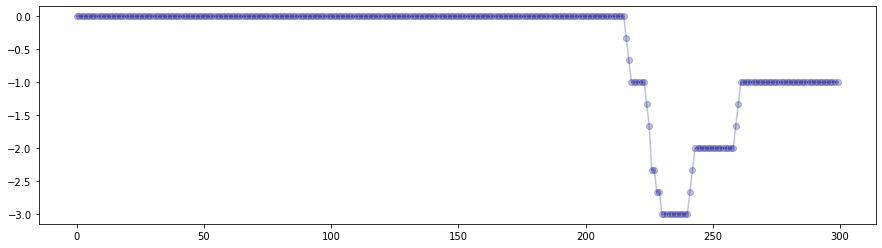

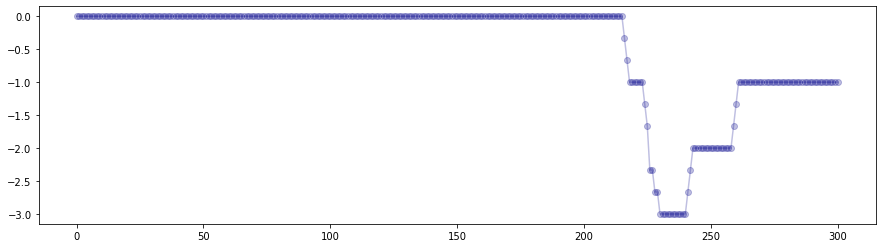

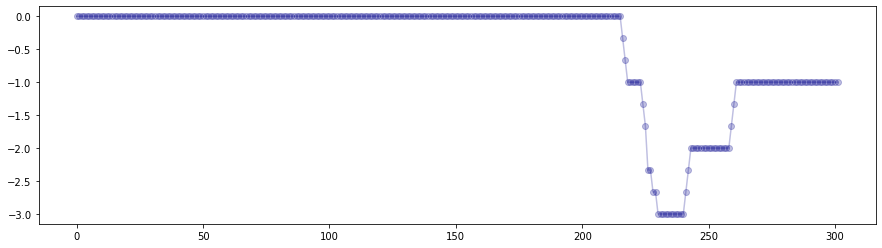

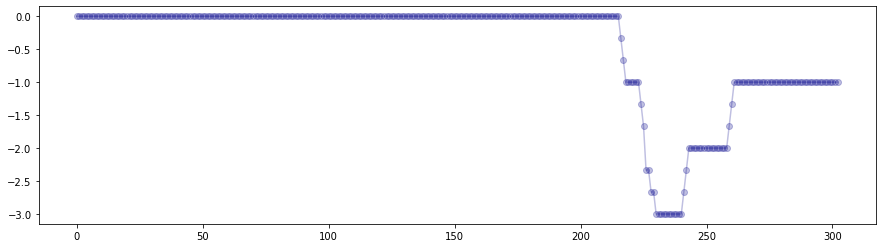

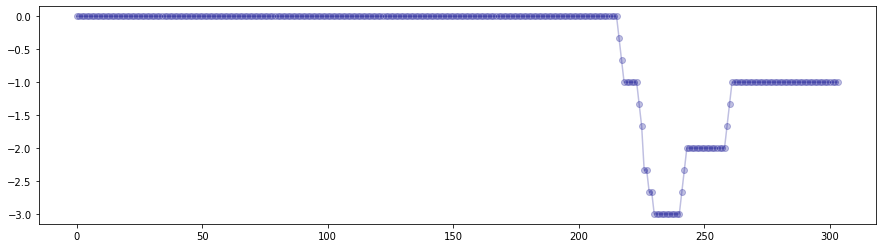

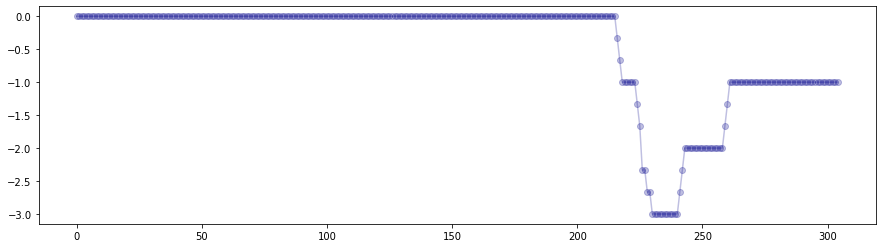

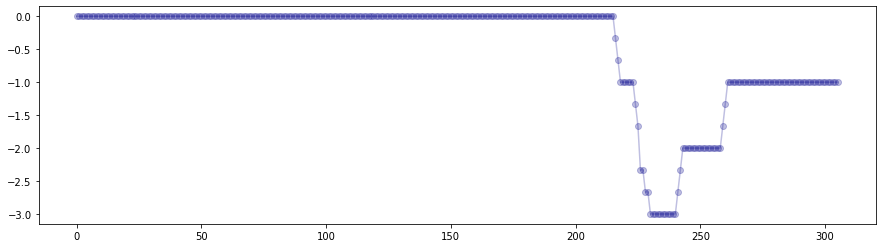

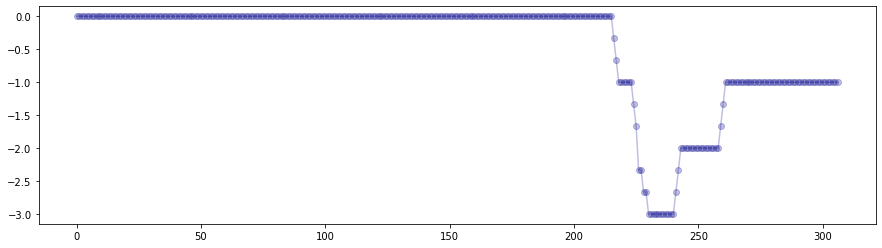

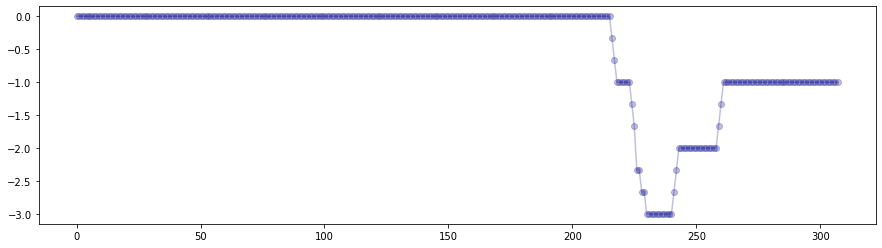

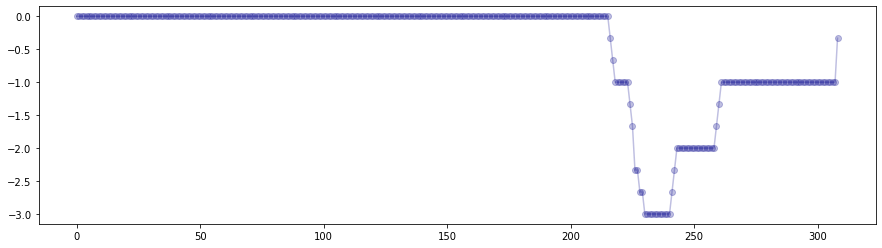

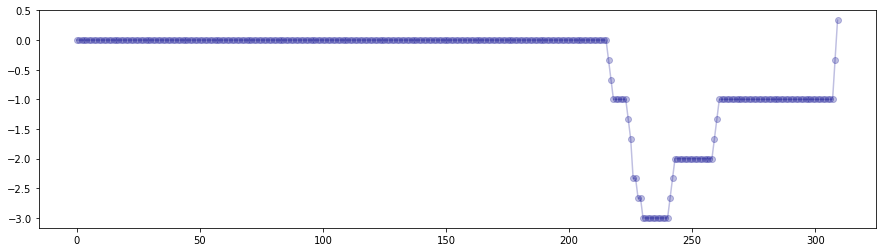

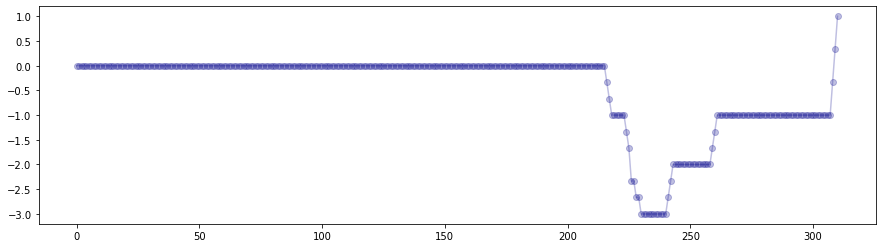

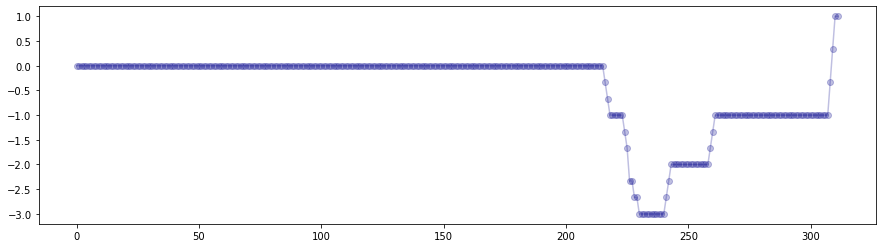

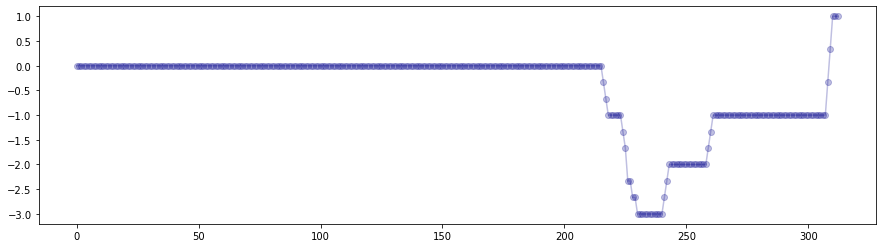

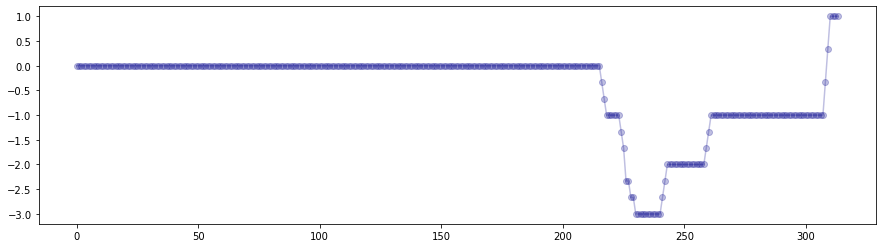

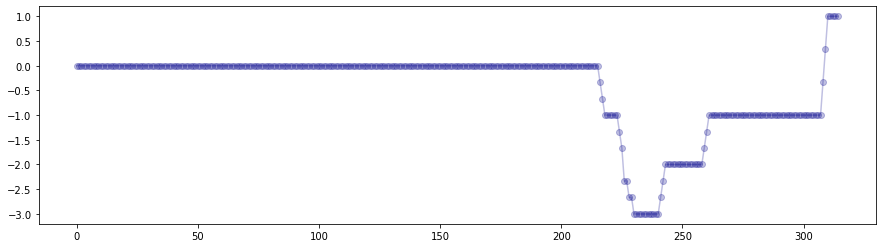

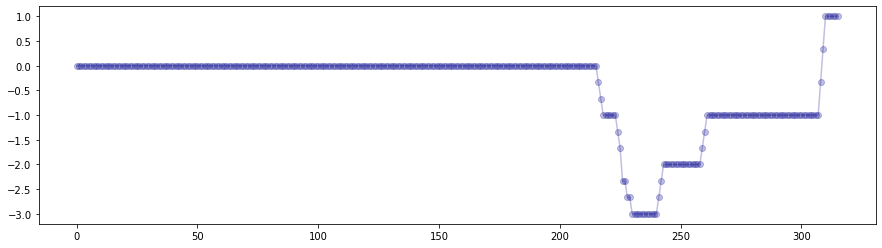

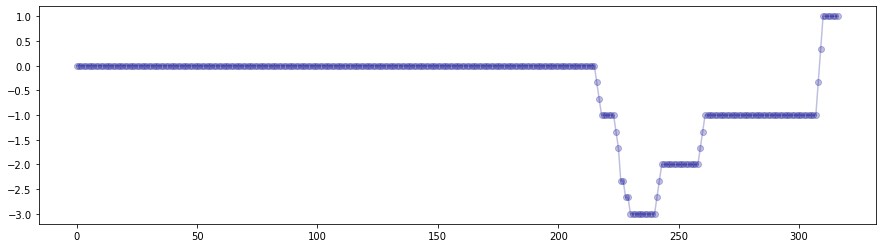

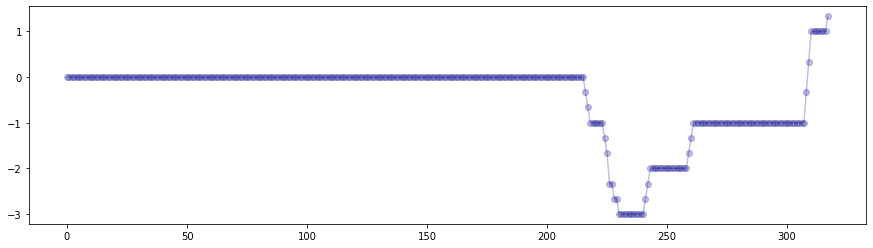

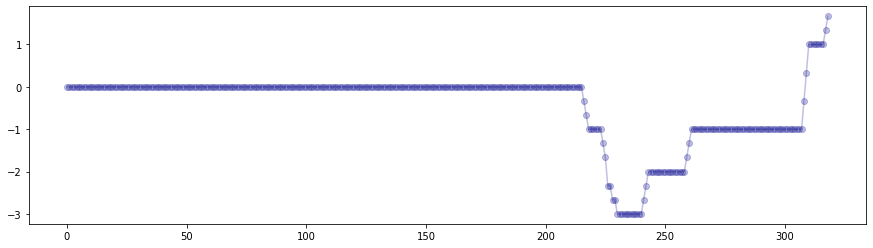

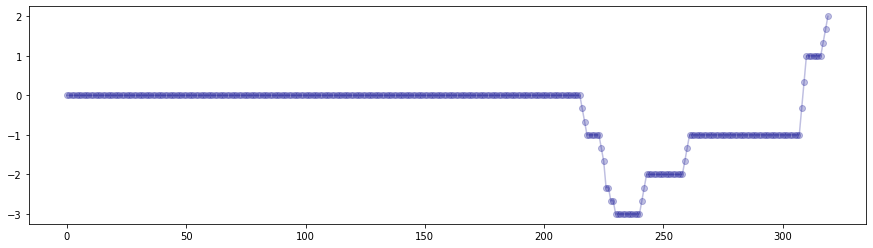

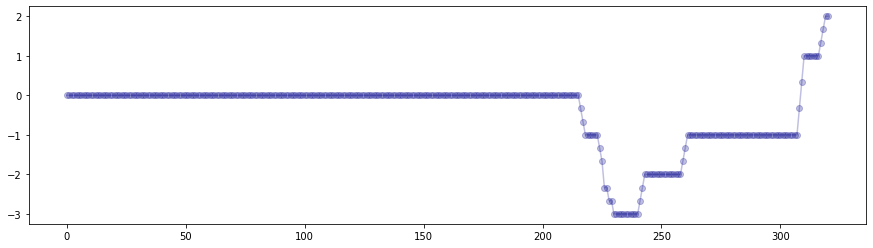

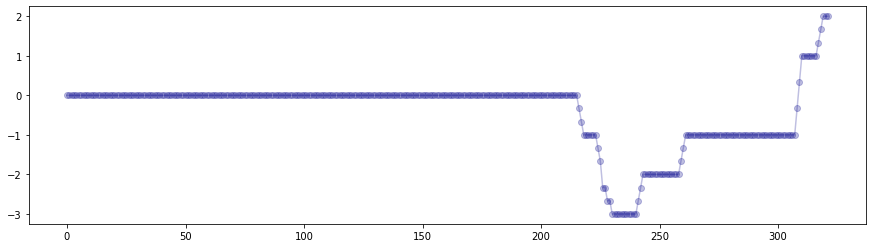

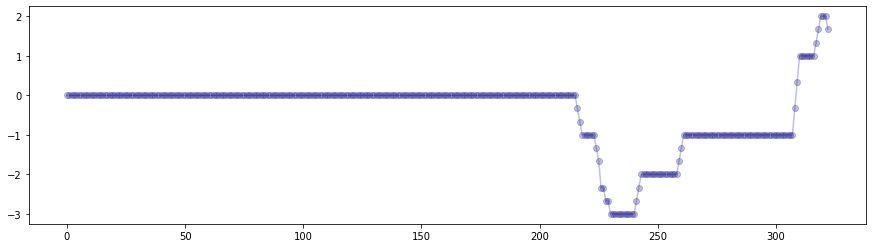

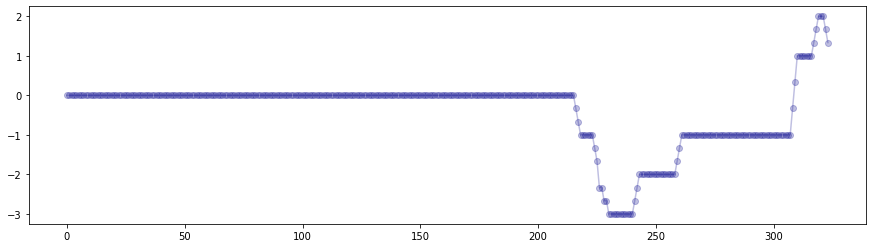

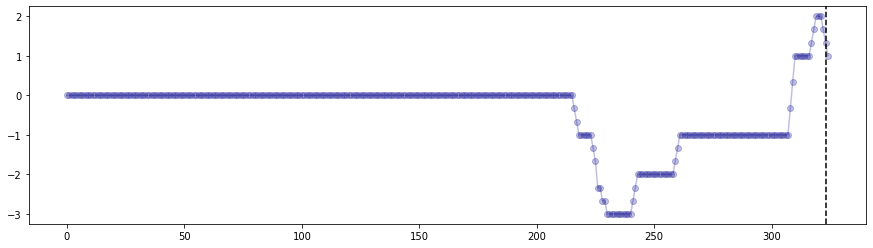

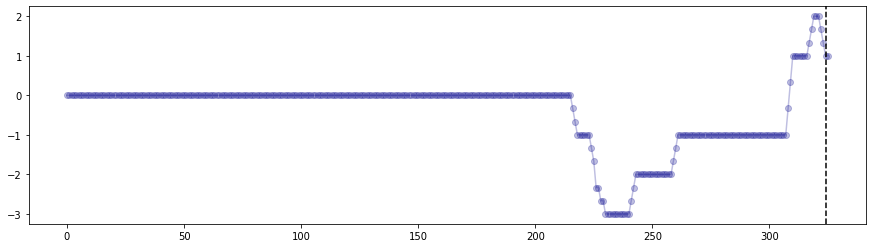

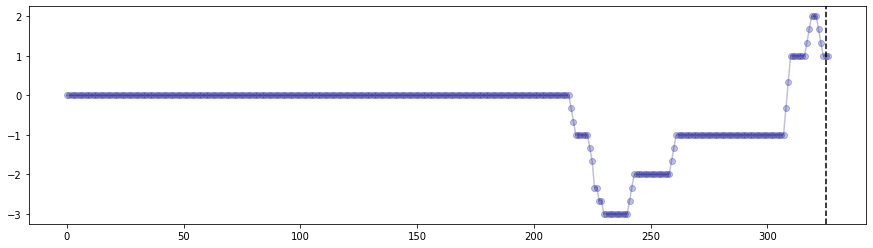

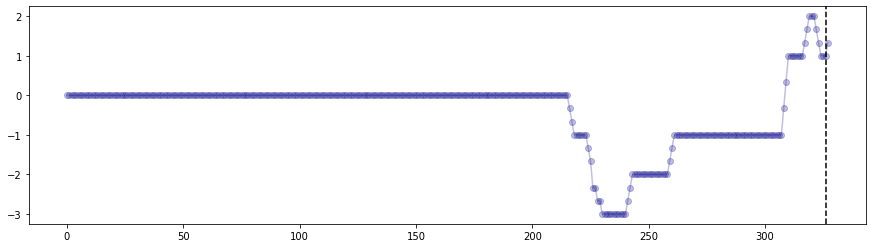

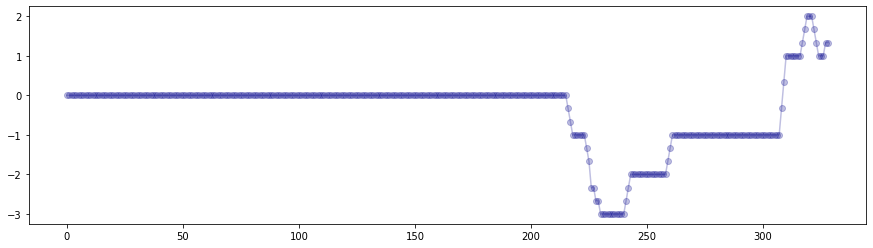

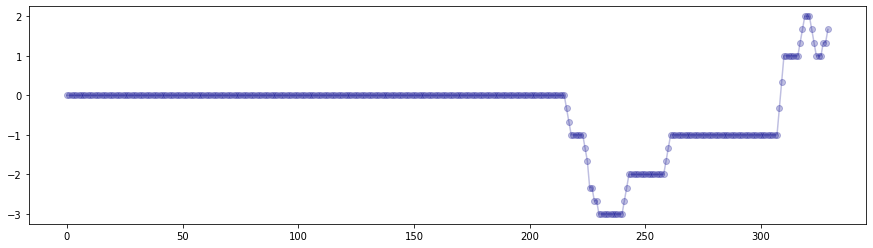

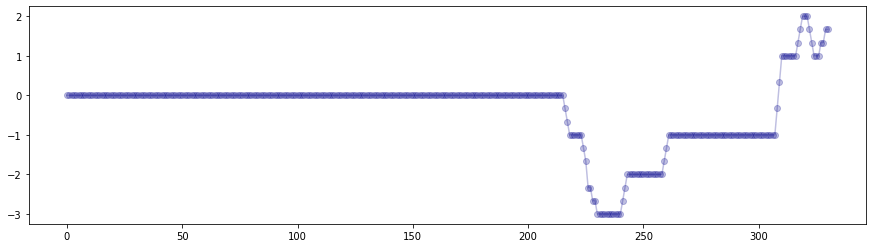

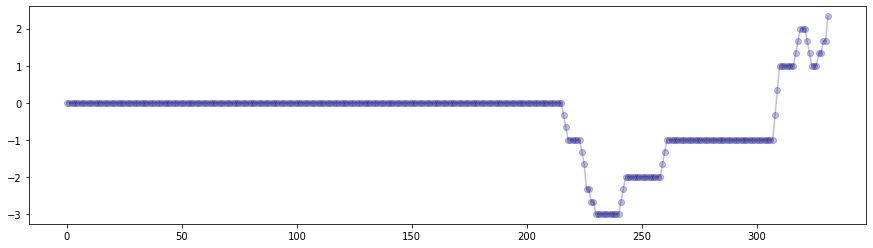

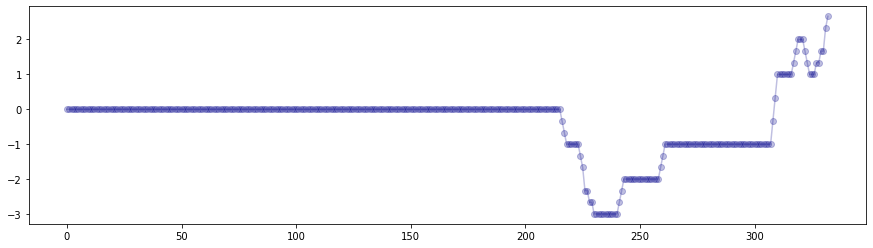

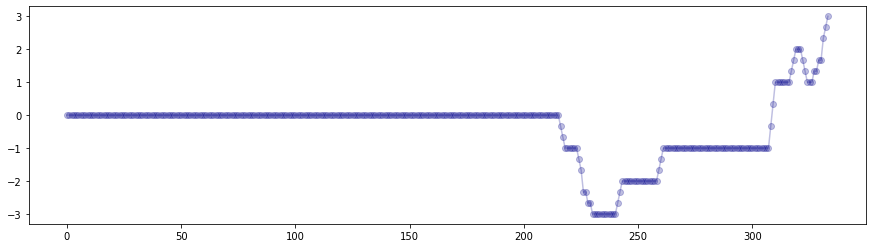

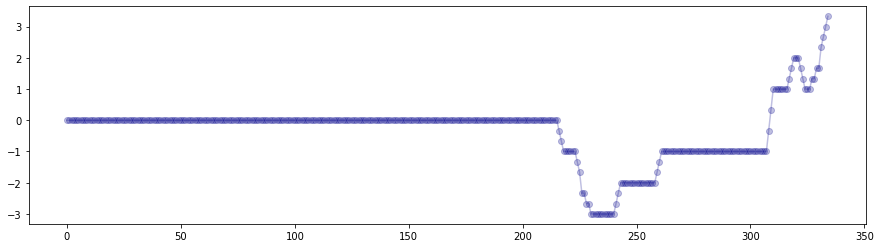

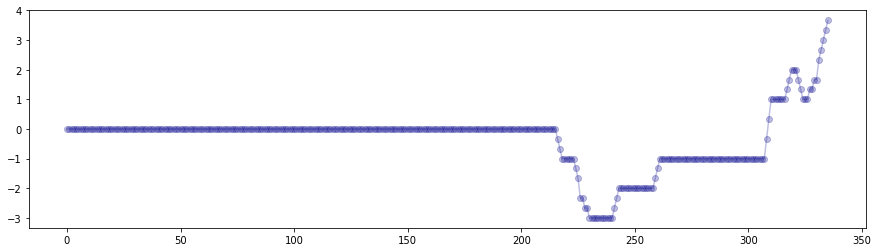

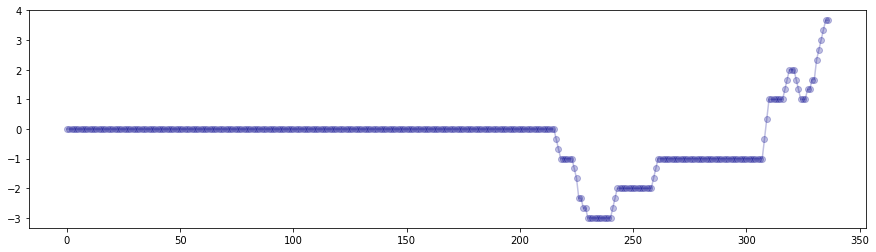

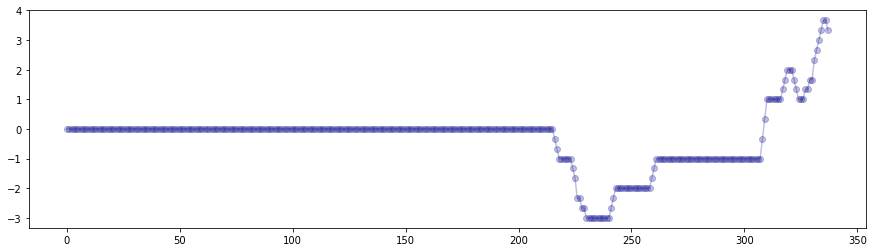

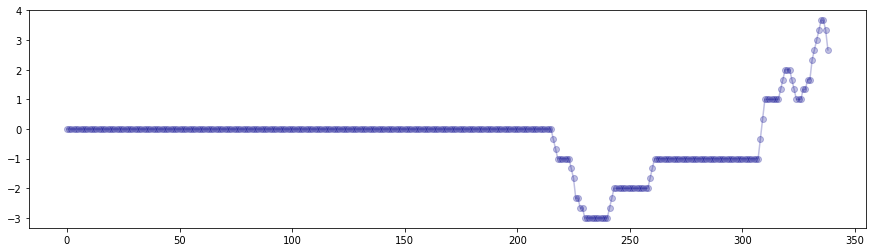

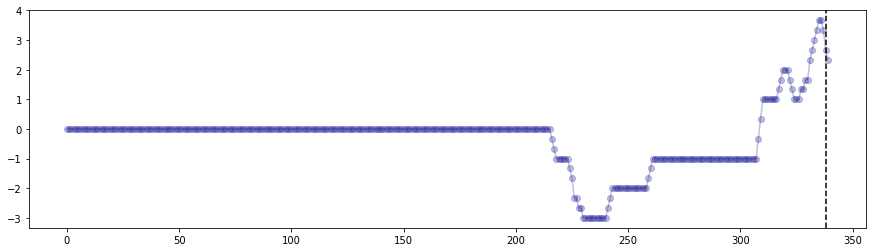

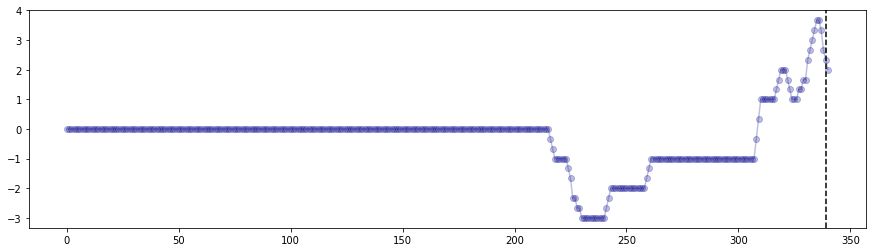

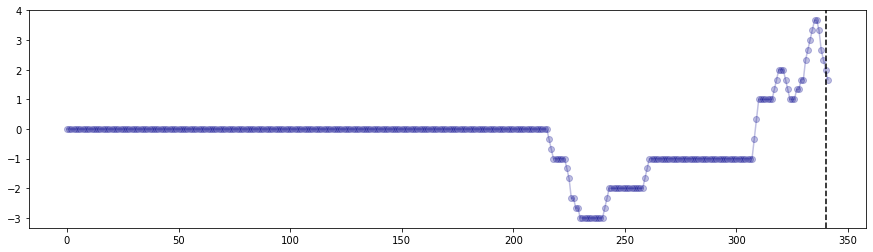

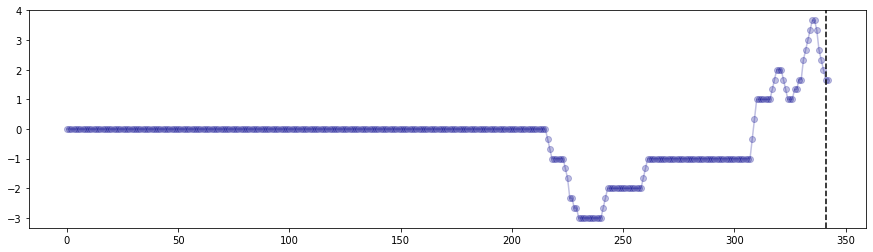

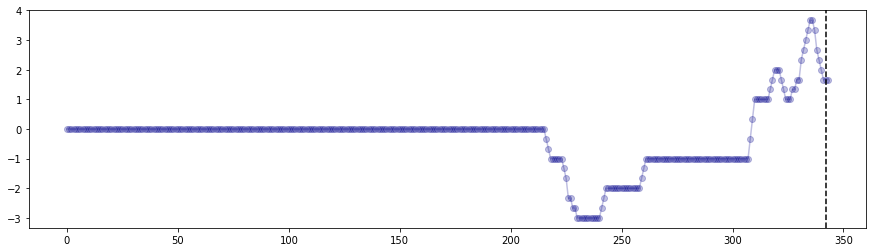

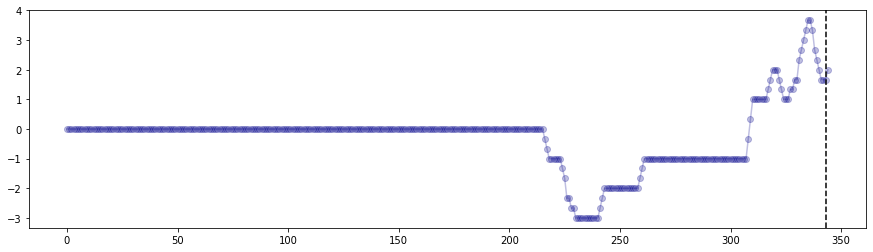

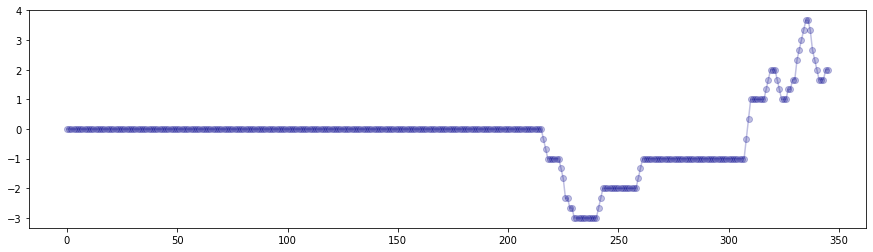

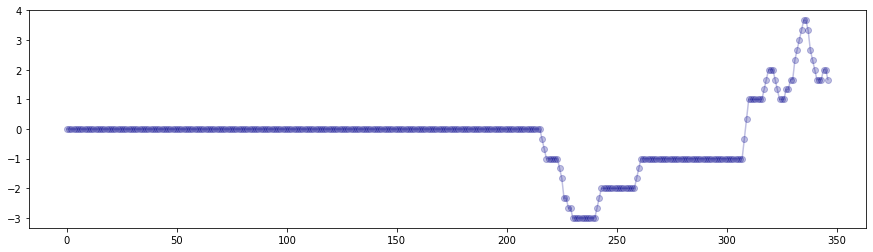

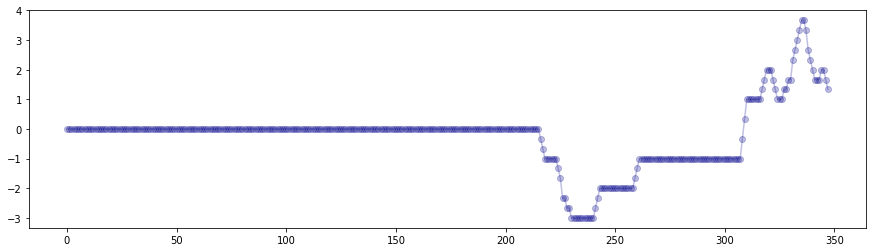

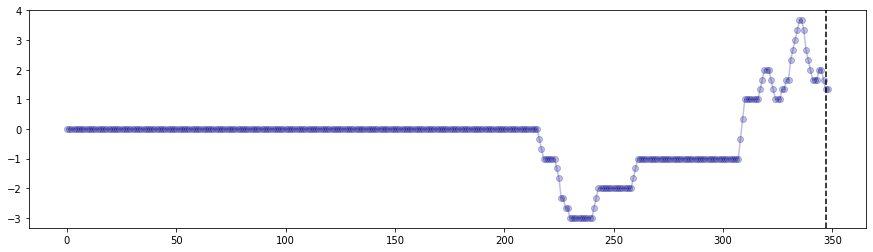

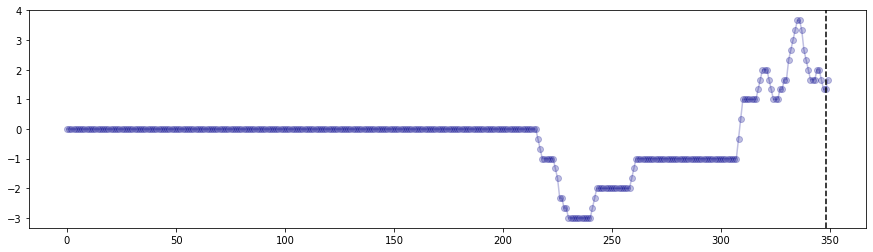

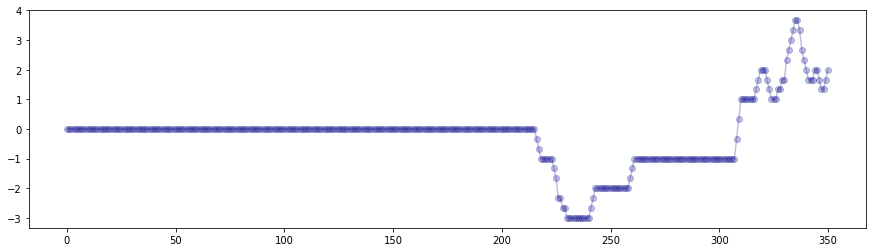

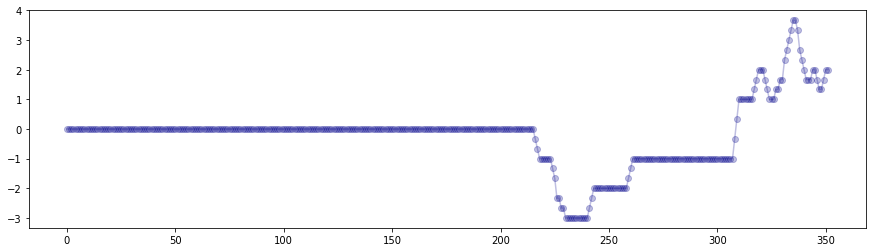

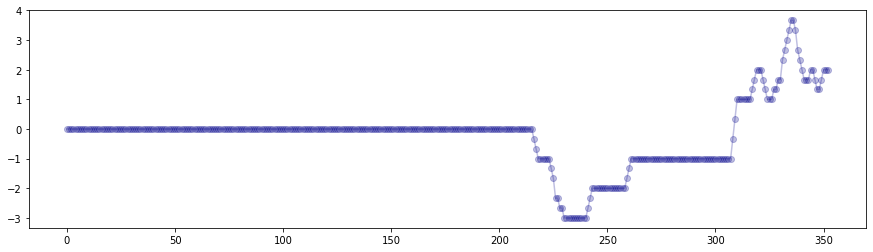

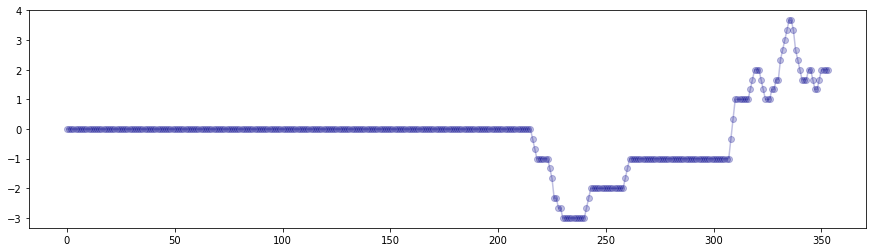

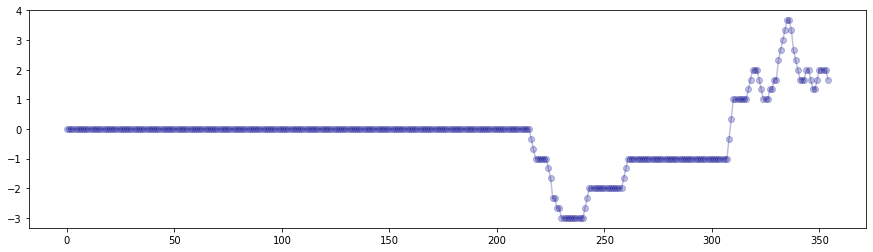

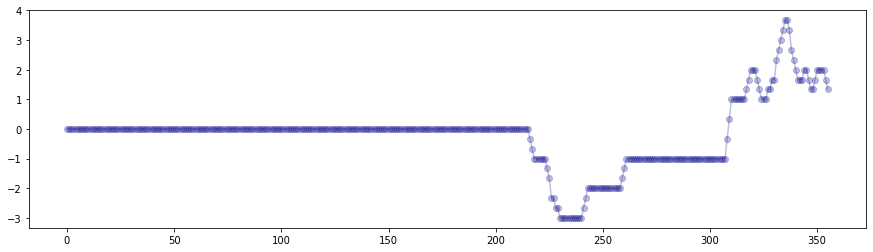

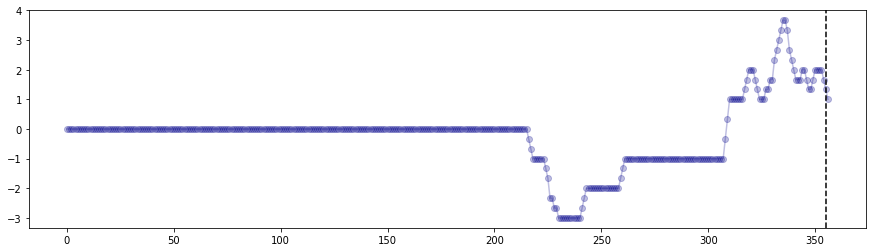

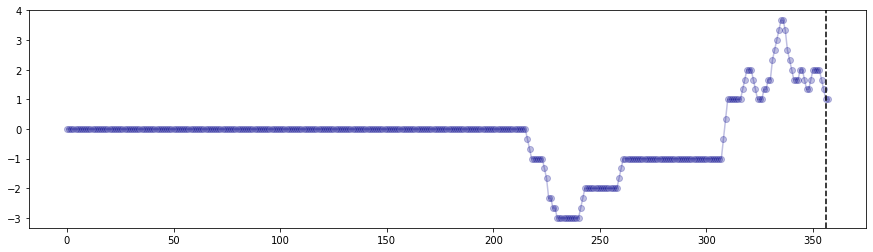

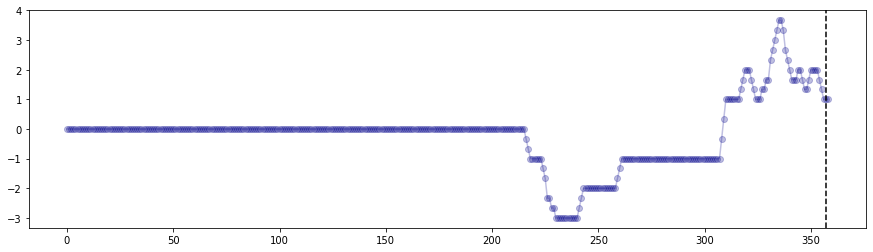

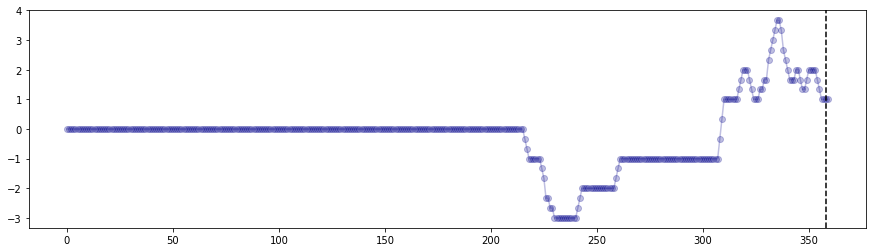

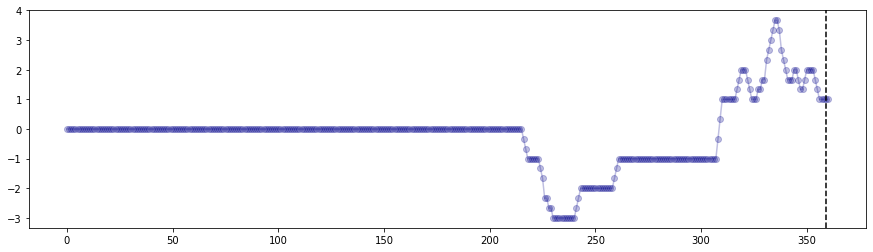

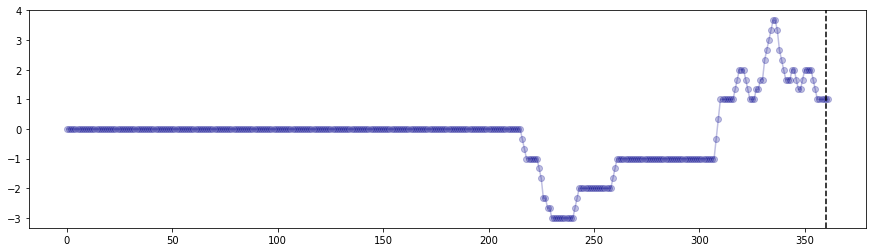

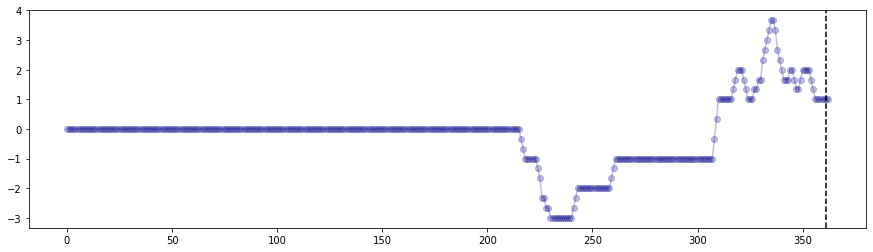

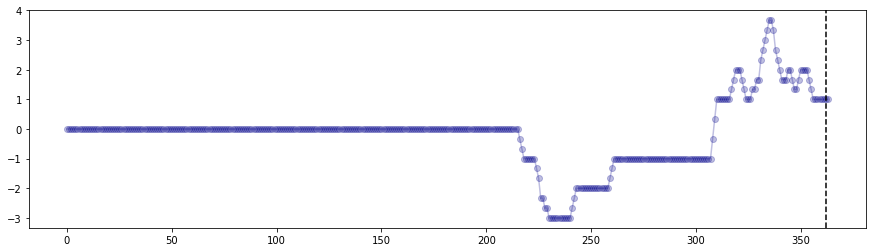

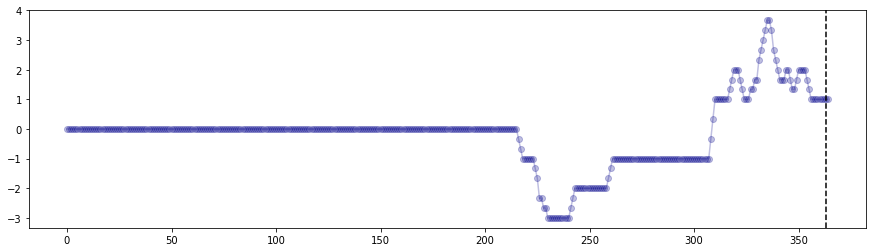

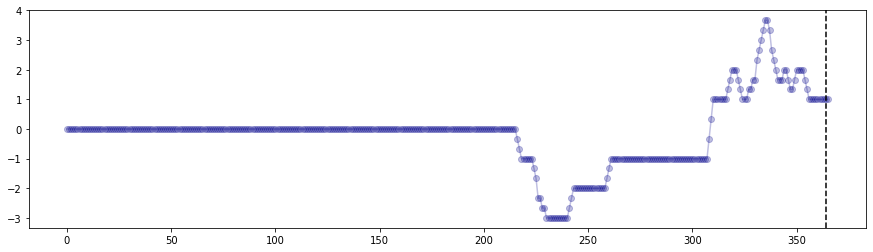

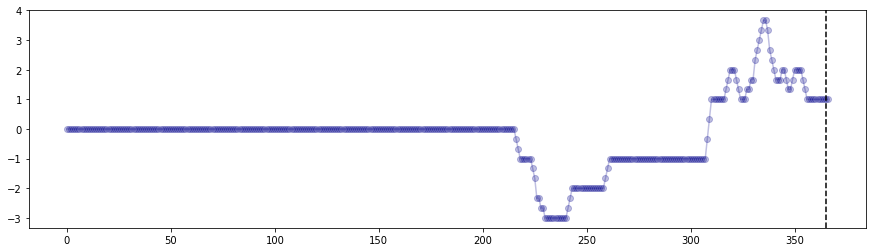

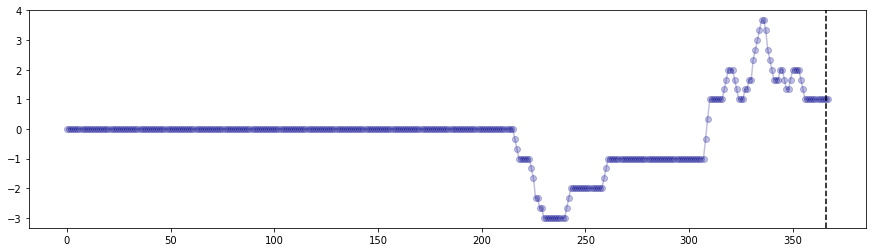

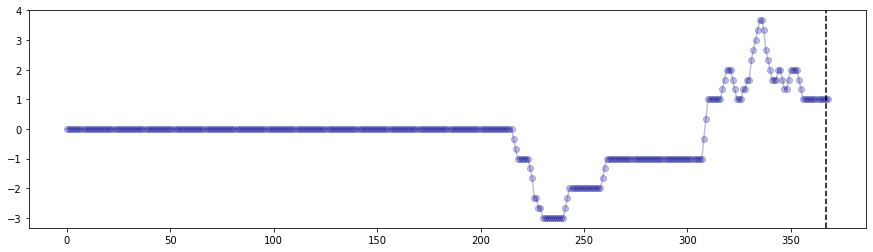

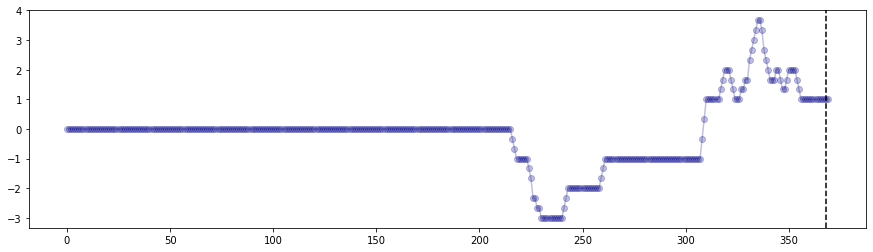

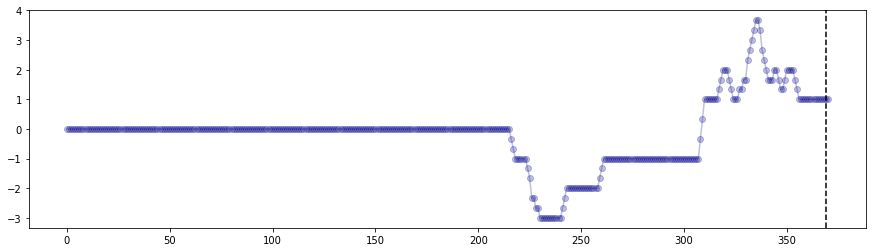

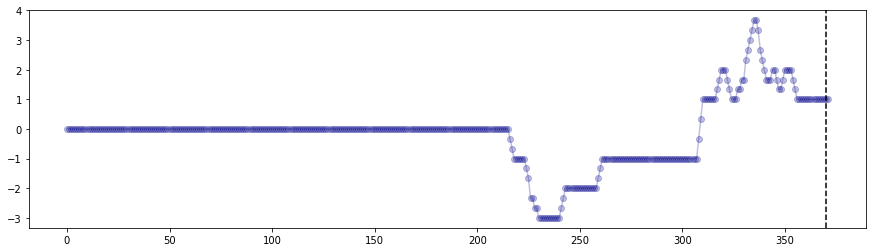

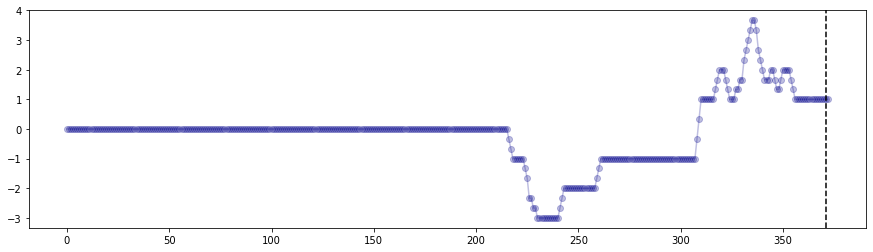

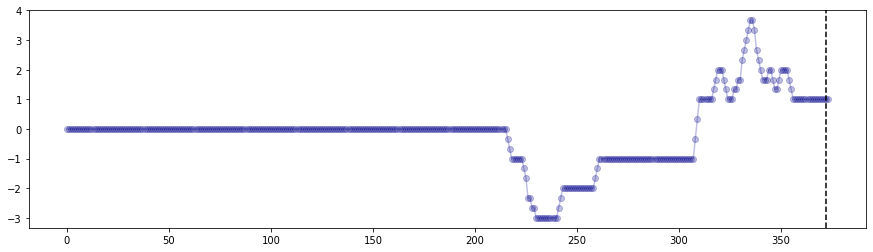

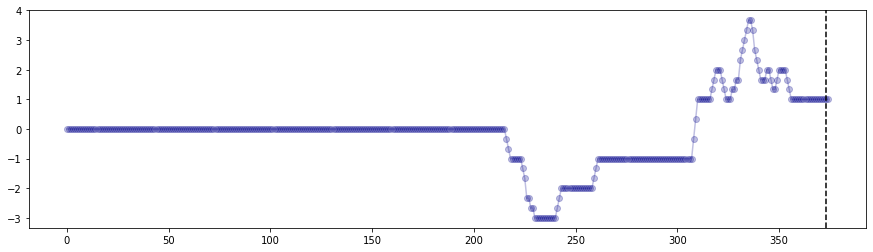

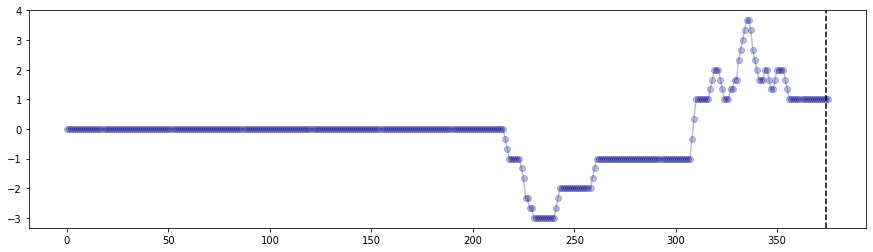

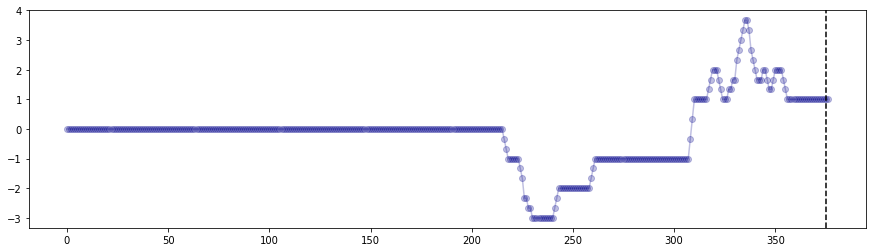

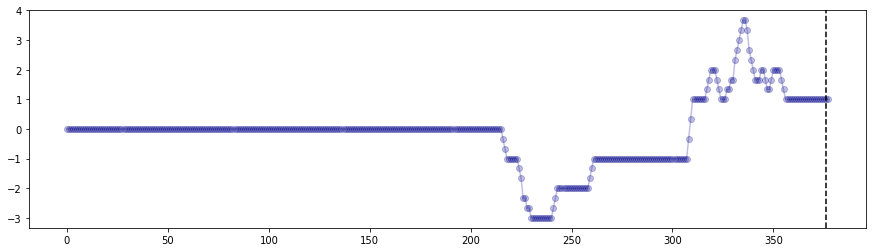

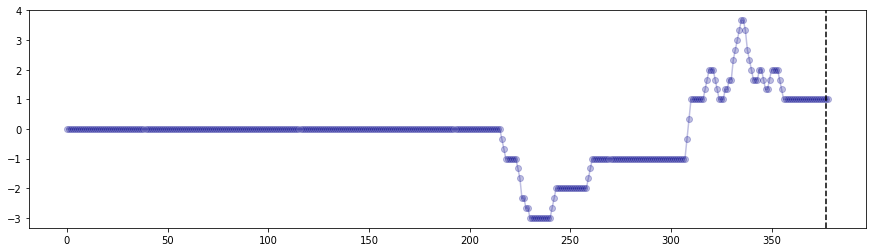

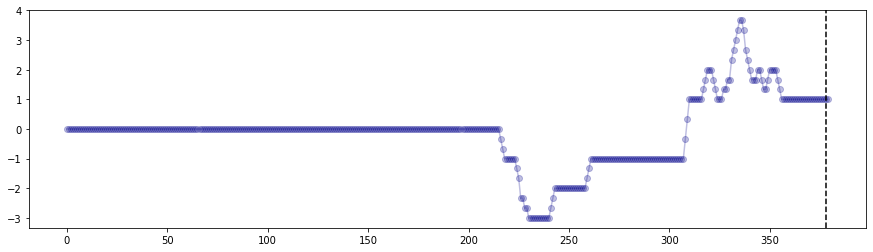

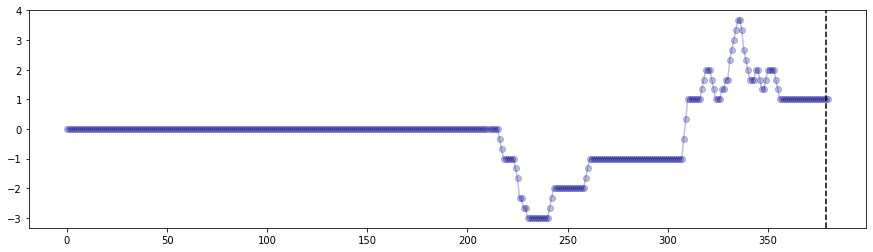

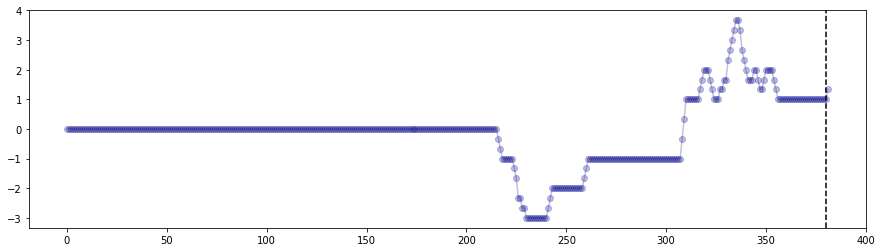

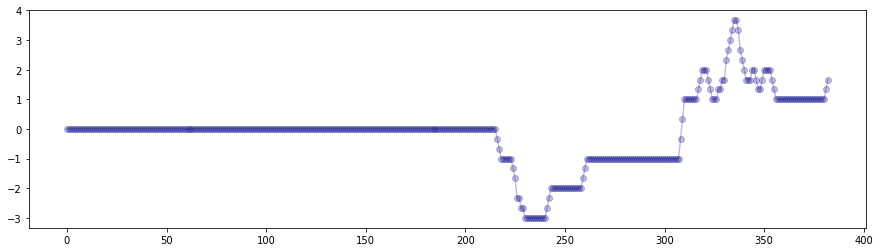

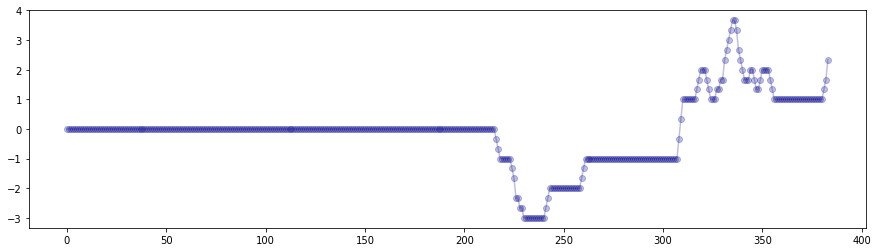

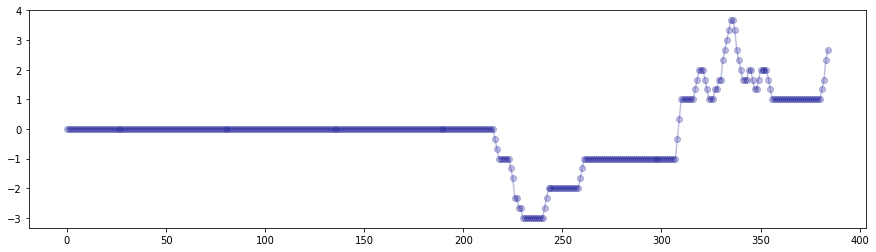

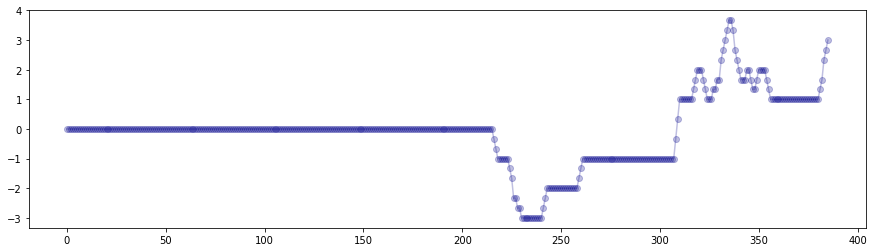

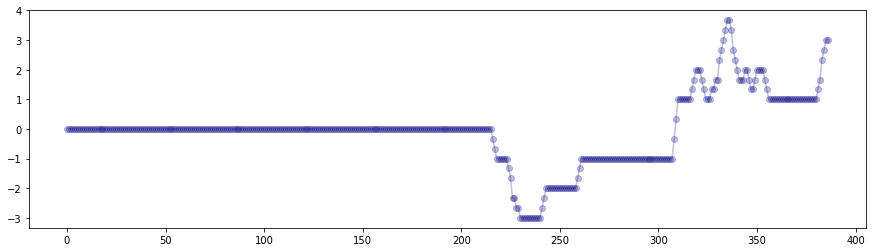

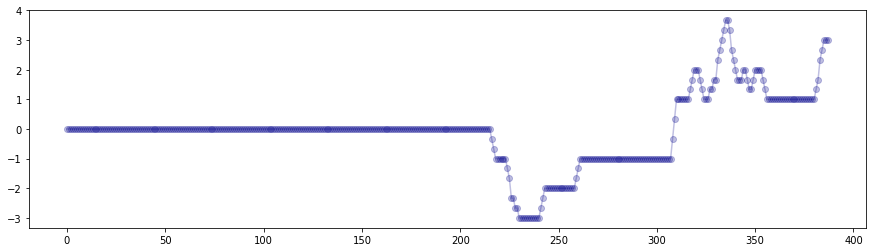

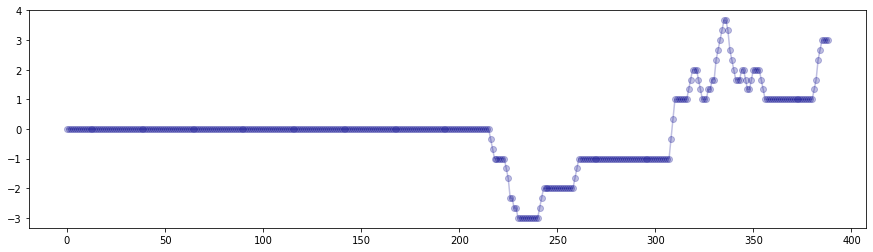

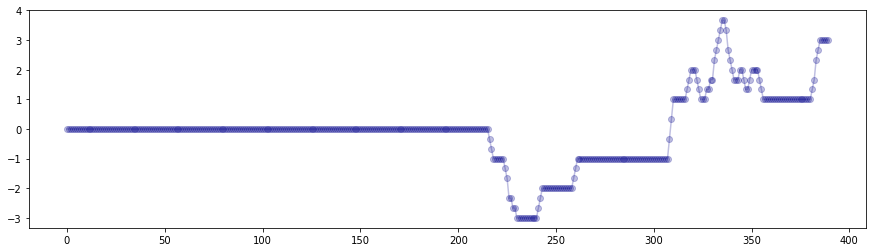

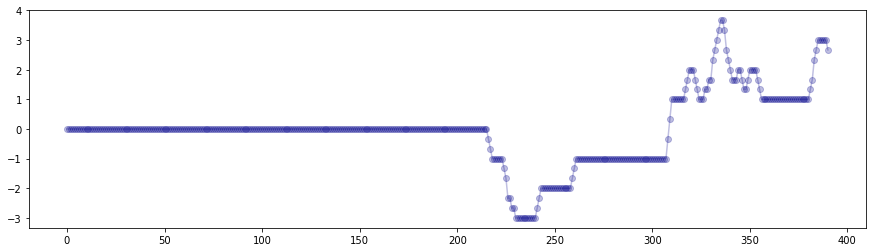

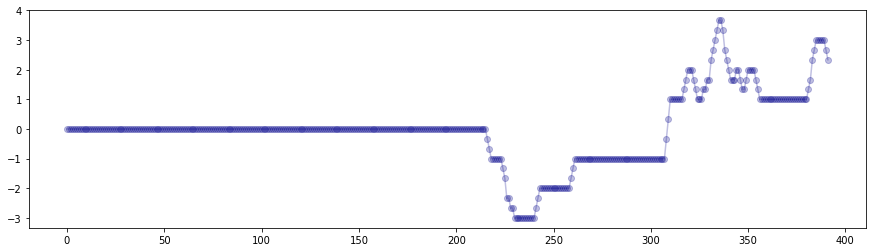

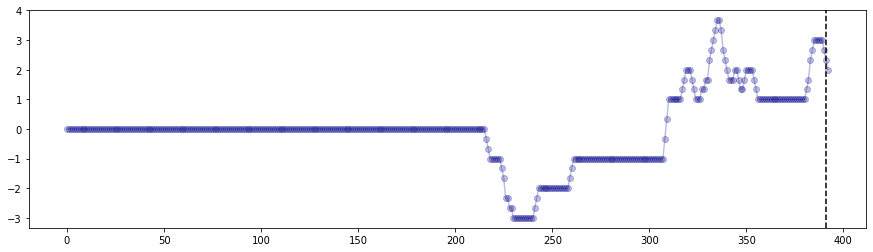

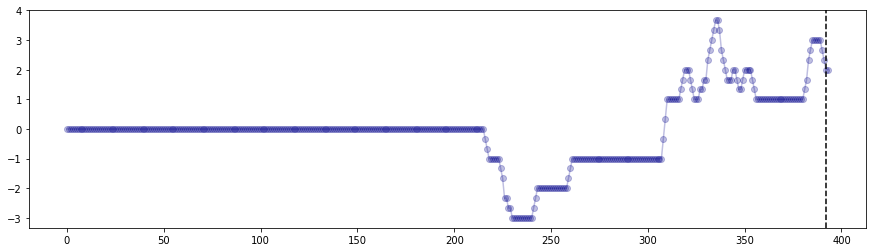

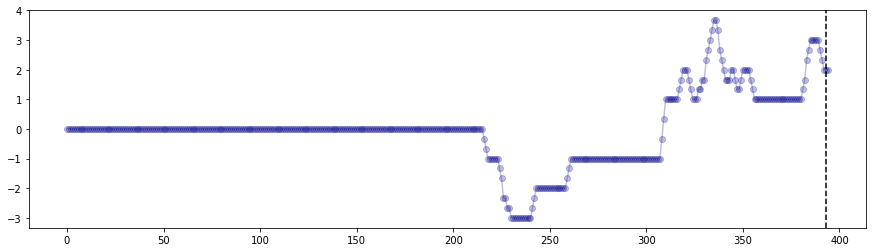

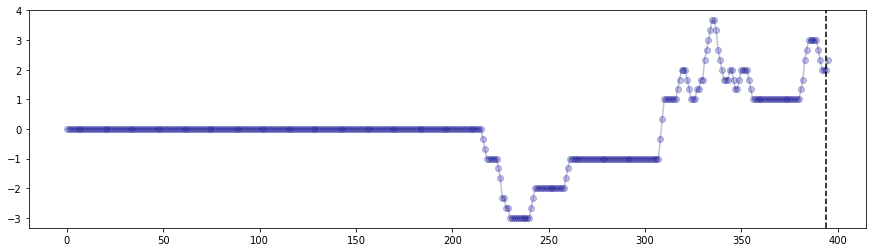

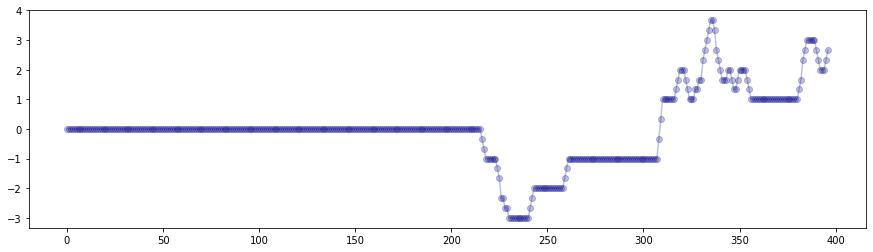

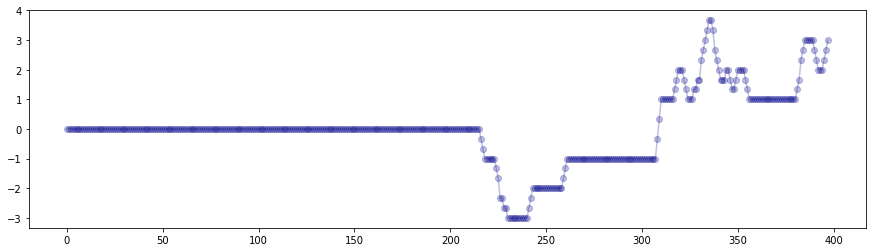

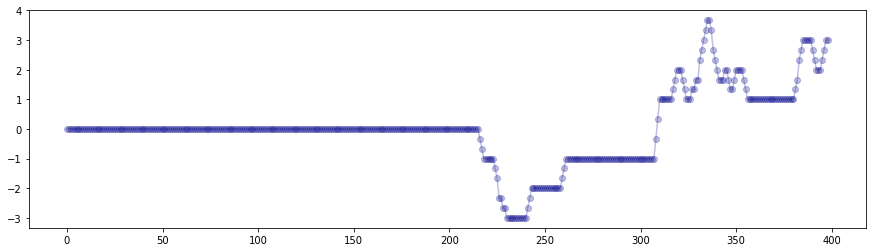

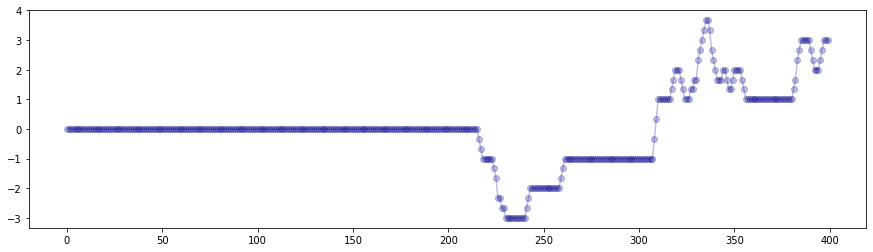

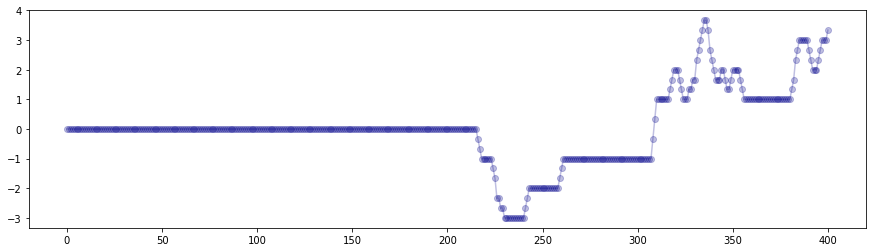

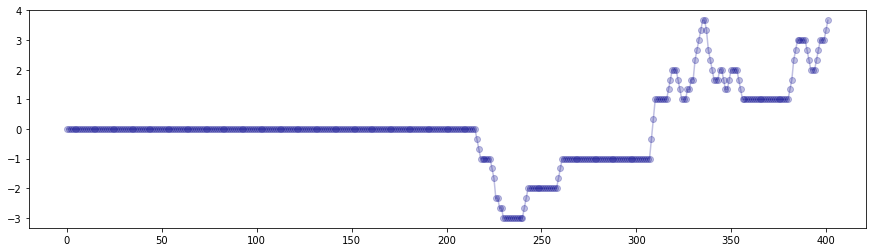

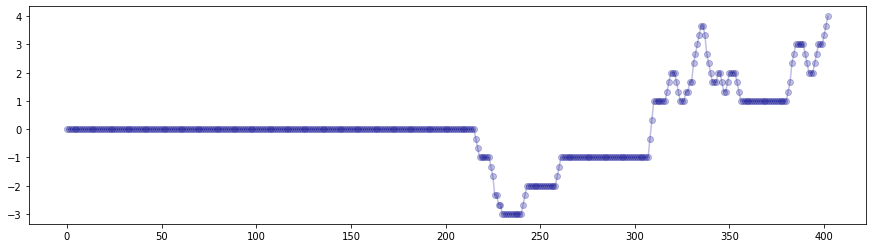

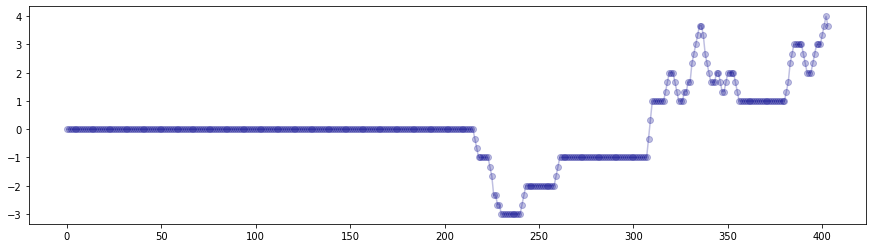

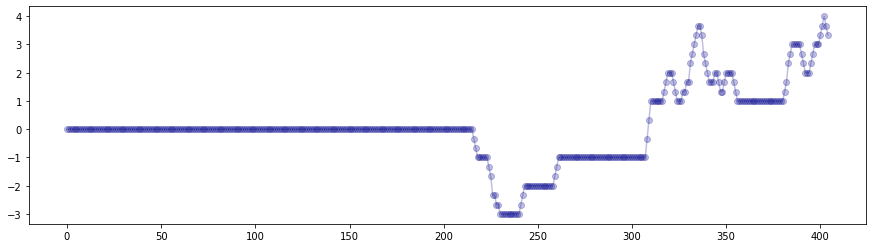

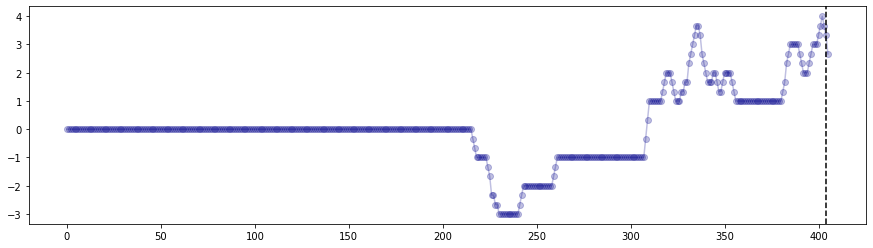

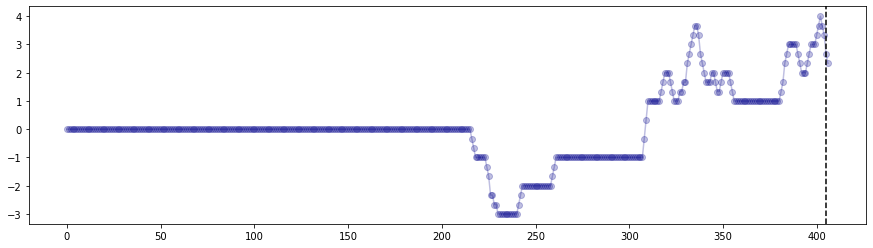

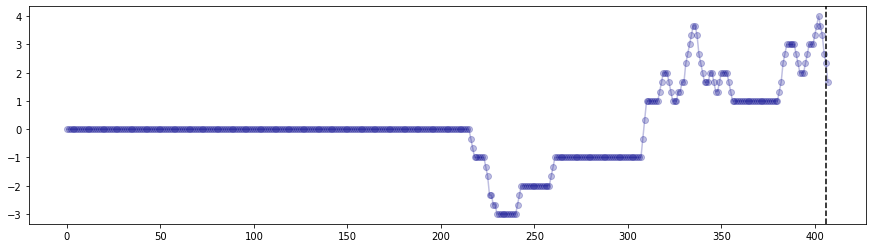

In [78]:
min_consequtives = 2

# get inc, dec and stable counts
vec_rule_1_decline = nrt.apply_rule_one(arr=vec_static_smooth, 
                                        vector_value=-1, 
                                        min_consequtives=min_consequtives, 
                                        inc_plateaus_in_runs=True)

#vec_rule_1_stable = nrt.apply_rule_one(vec_static_smooth, vector_value=0, min_consequtives=min_consequtives)
#vec_rule_1_incline = nrt.apply_rule_one(vec_static_smooth, vector_value=1, min_consequtives=min_consequtives)

for i in np.arange(0, len(vec_rule_1_decline)):
    if i > 3:
    
        vec_smooth = vec_static_smooth[0:i]
        vec_rule = vec_rule_1_decline[0:i]
        
        alarm = False
        if vec_rule[-2] >= 1:
            alarm = True
            
        fig = plt.figure(figsize=(15, 4))
        plt.plot(vec_smooth, color='darkblue', marker='o', alpha=0.25)
        
        if alarm: 
            plt.axvline(i - 2, color='black', linestyle='dashed')
        
        plt.show()
        plt.close()

#fig = plt.figure(figsize=(15, 4))
#plt.plot(vec_static_smooth, color='darkblue', marker='o', alpha=0.25)
#plt.plot(np.where(vec_rule_1_decline >= 1, vec_static_smooth, np.nan), color='red', marker='o', alpha=0.25)
#plt.show()

## Apply rule 2: threshold

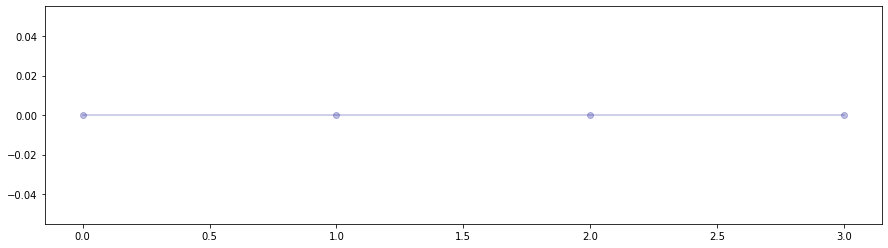

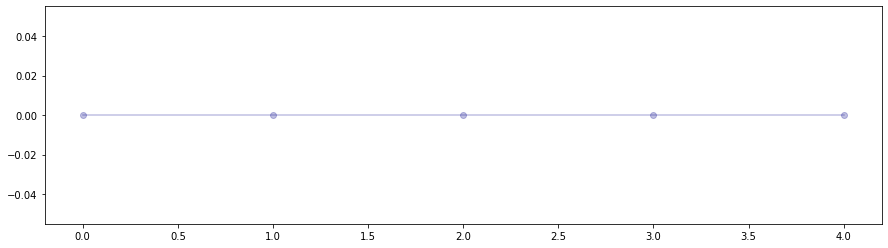

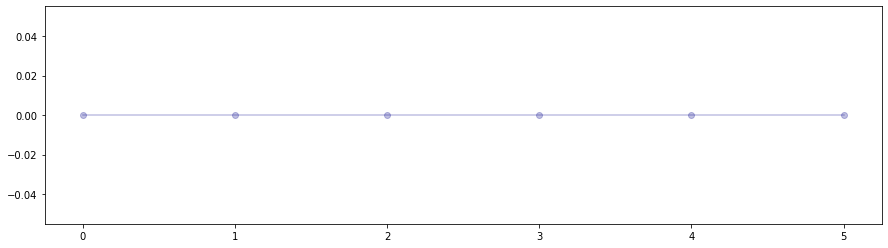

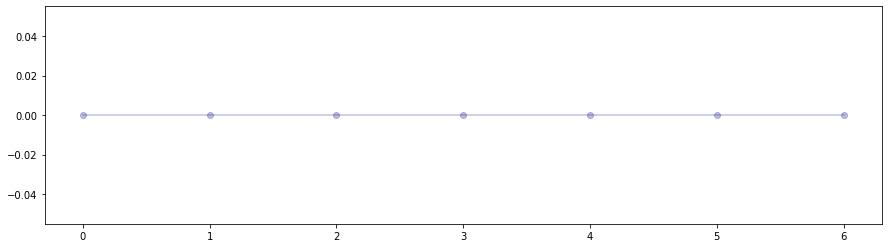

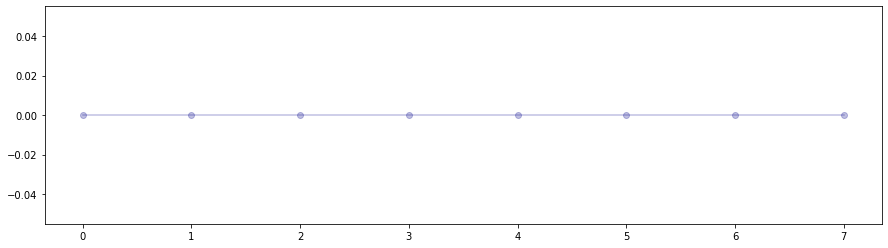

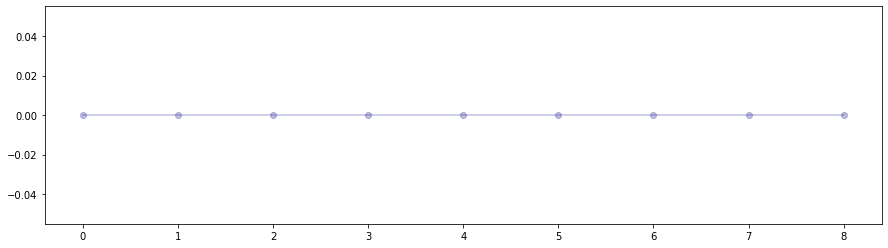

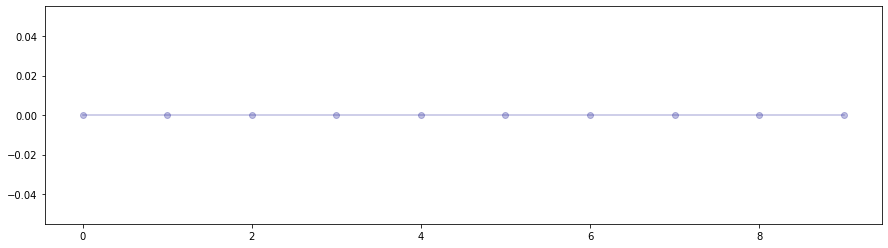

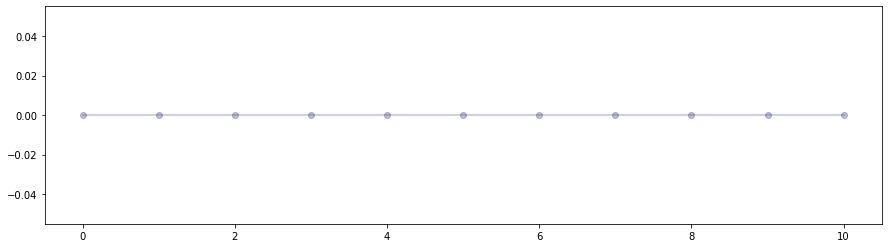

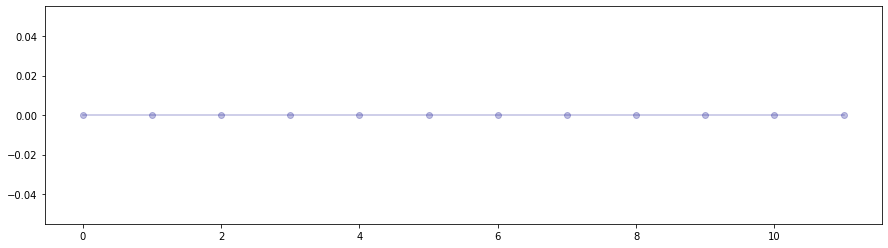

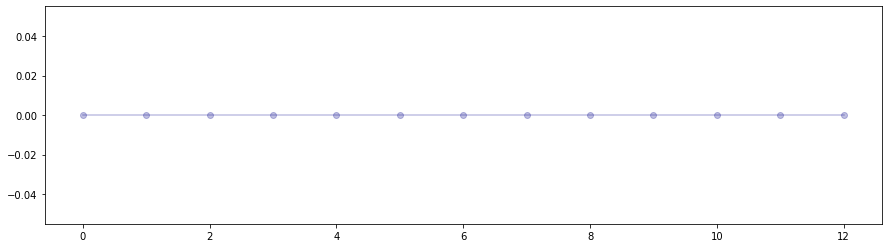

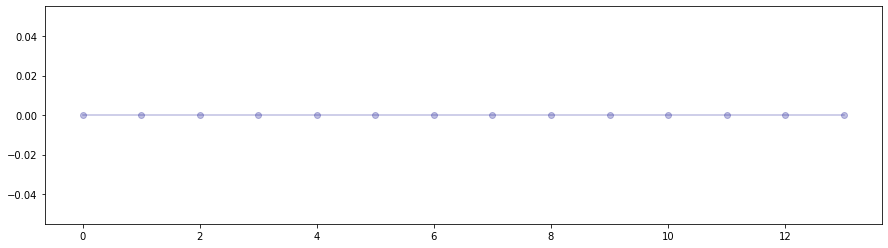

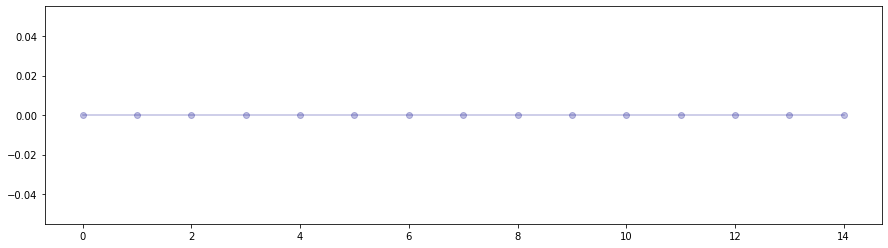

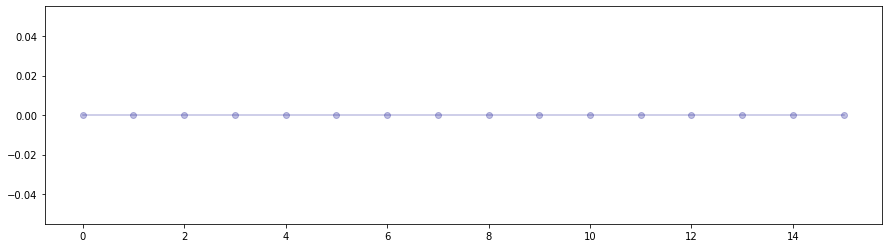

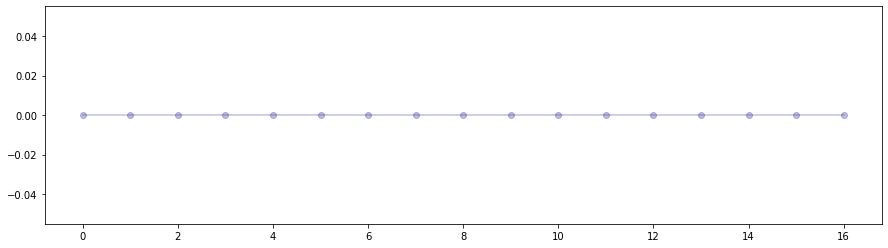

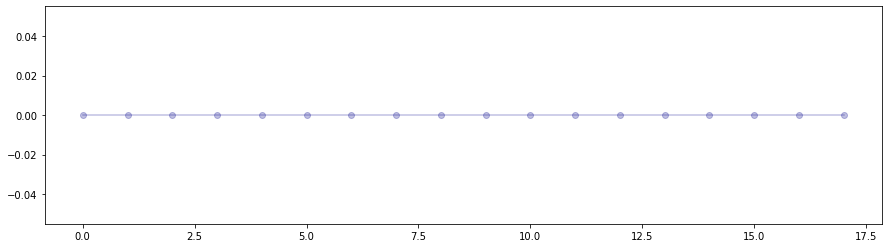

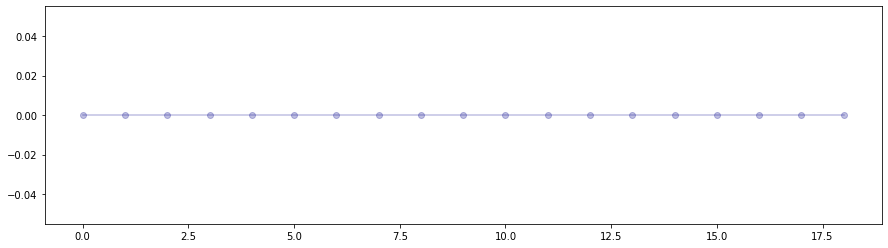

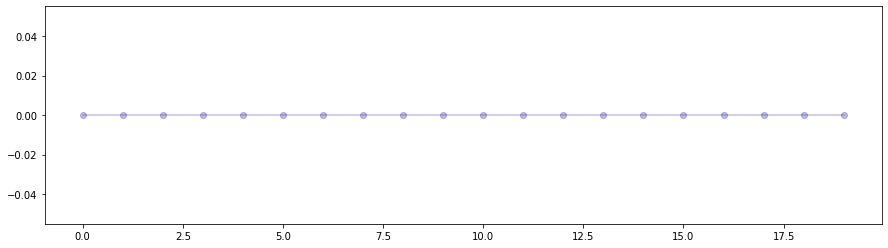

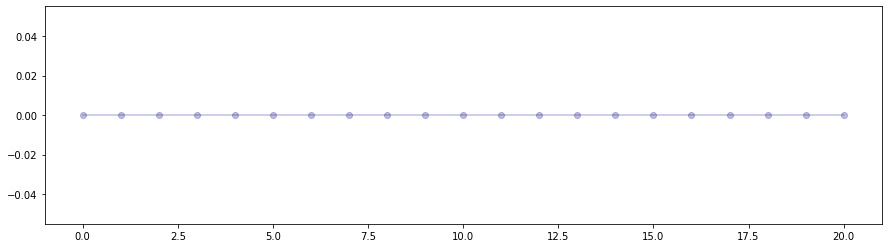

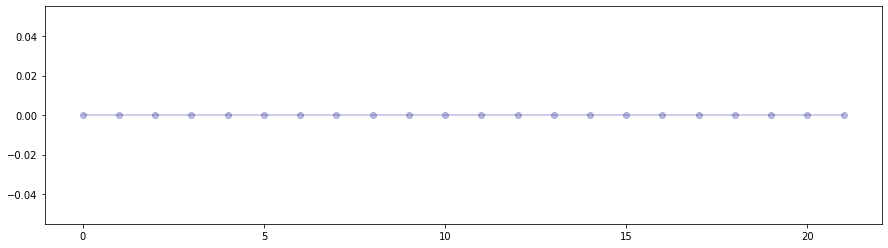

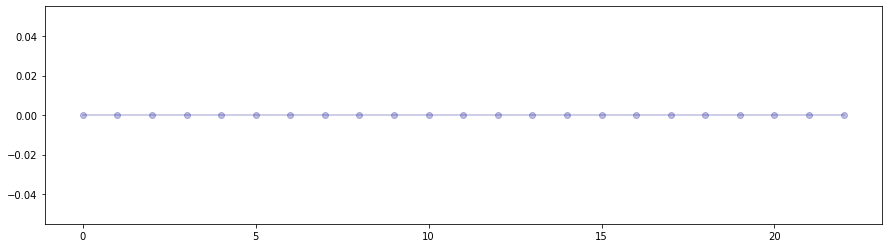

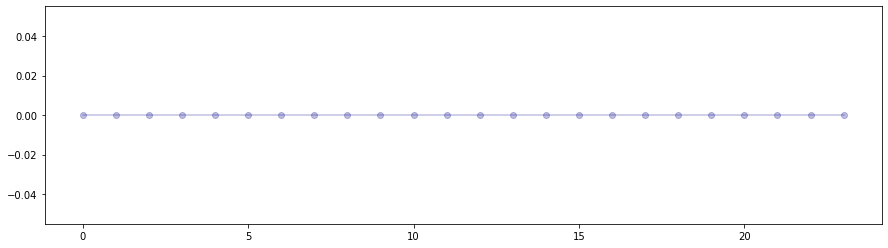

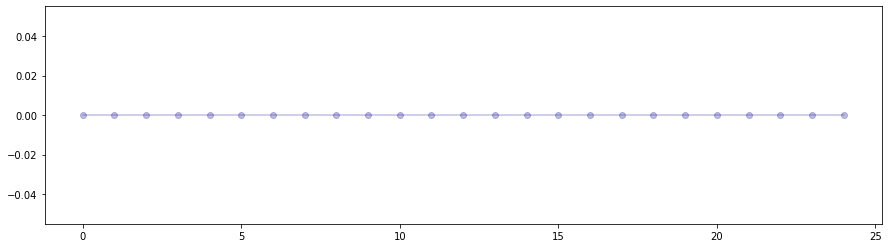

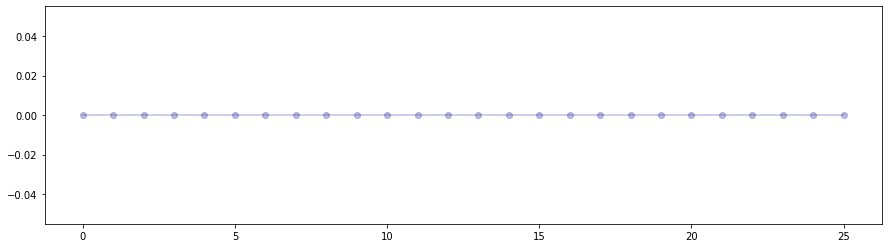

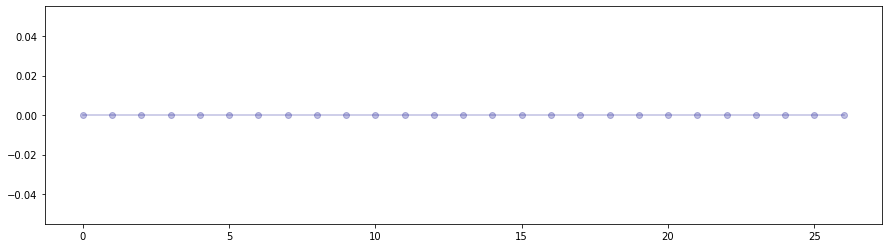

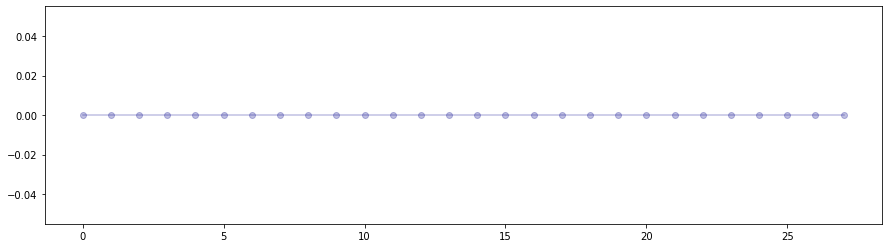

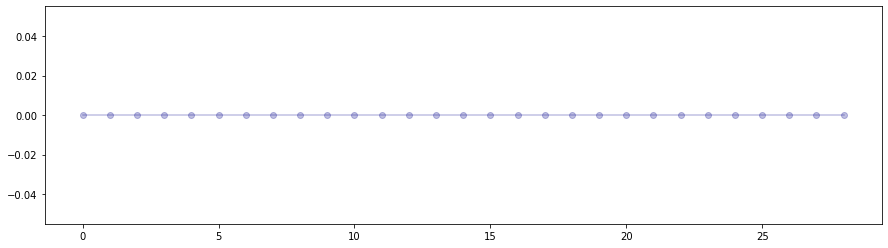

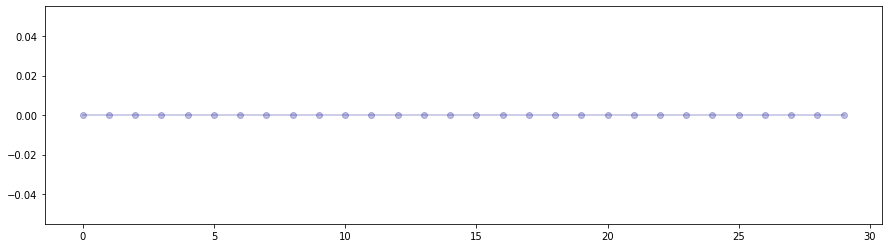

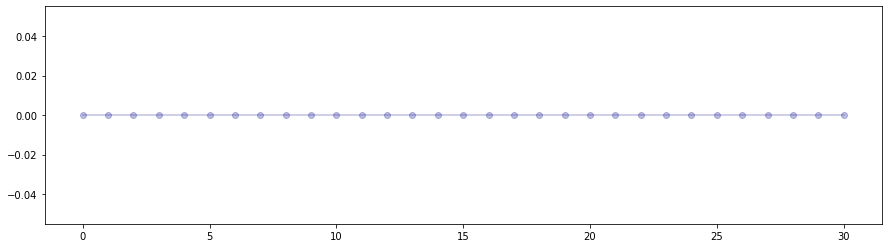

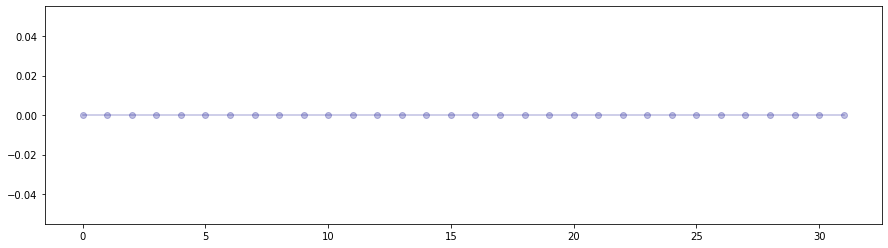

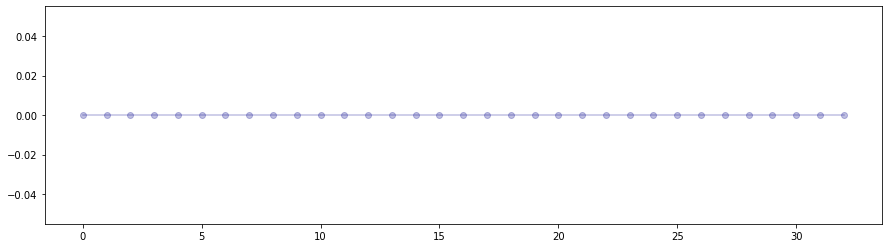

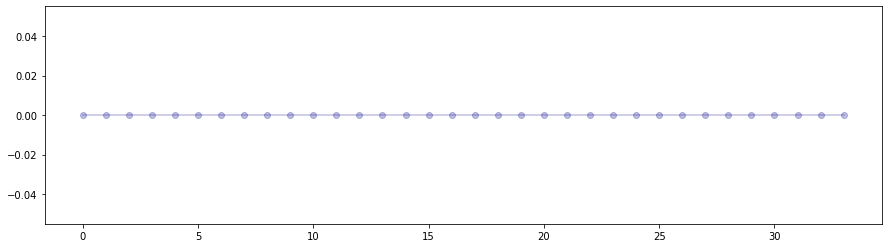

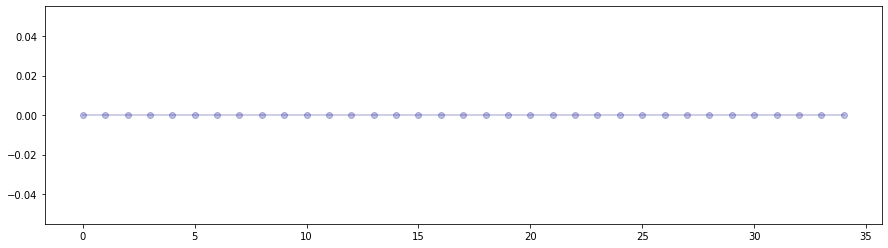

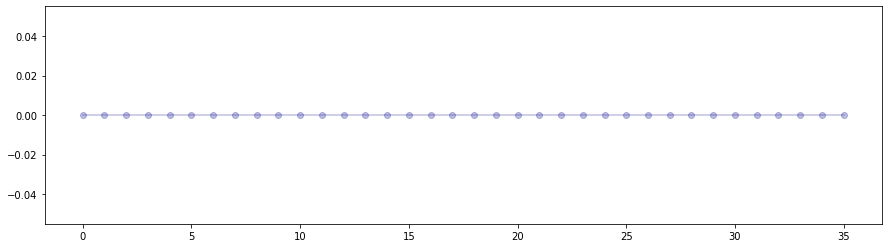

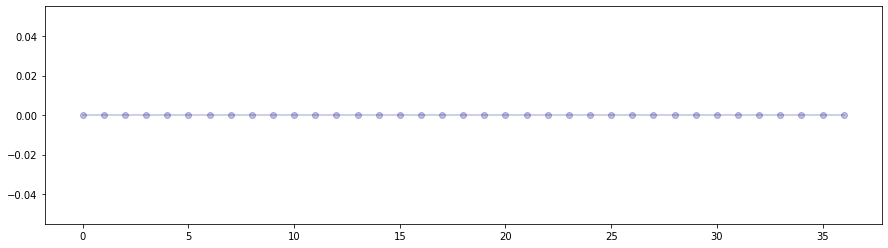

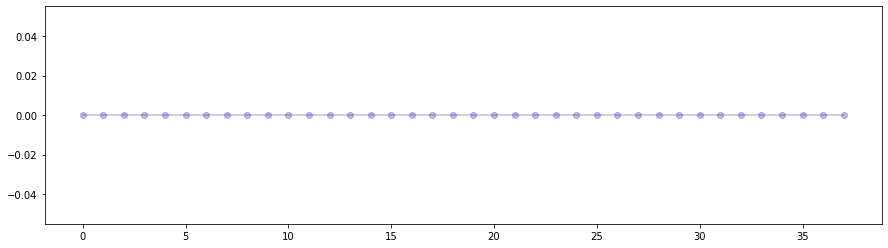

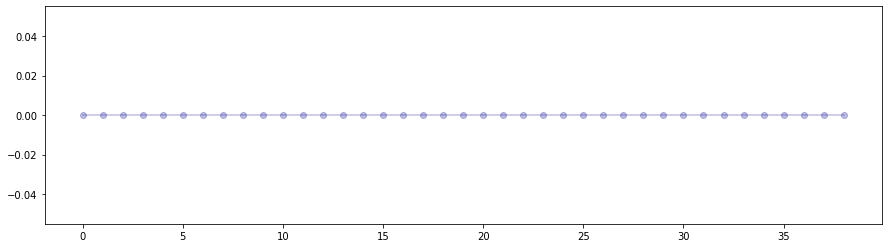

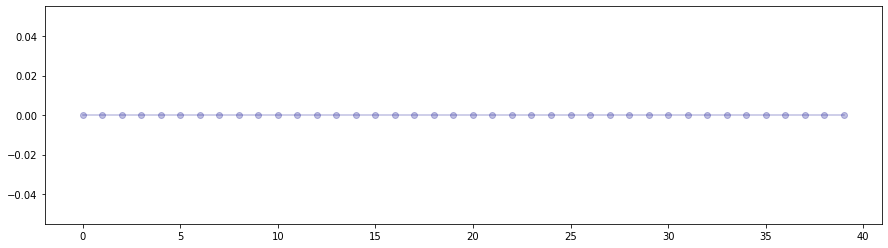

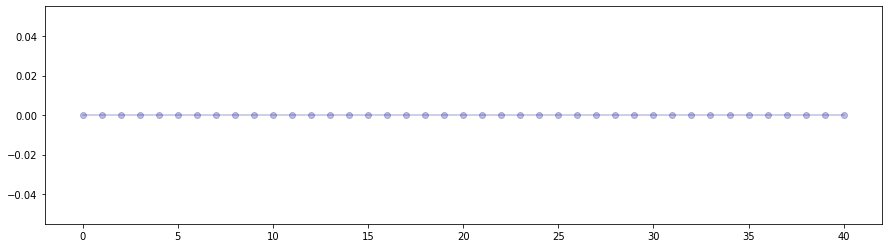

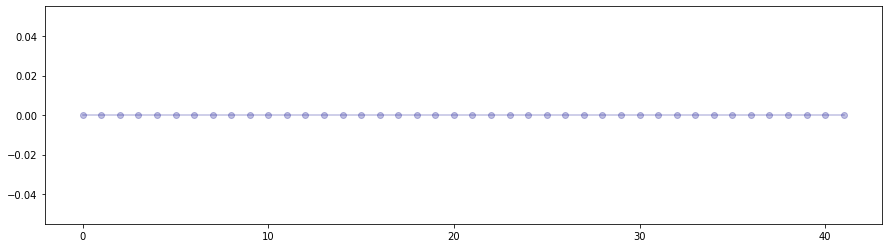

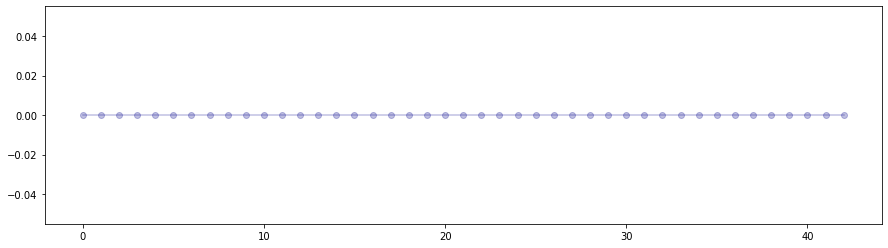

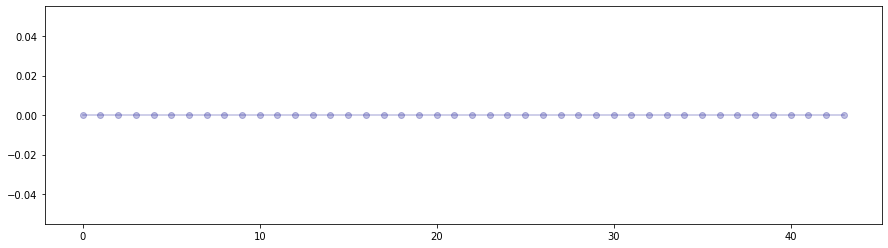

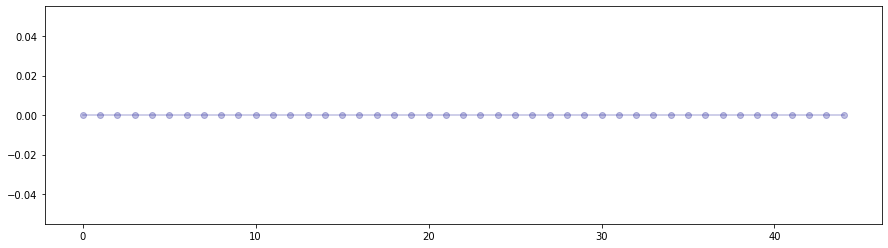

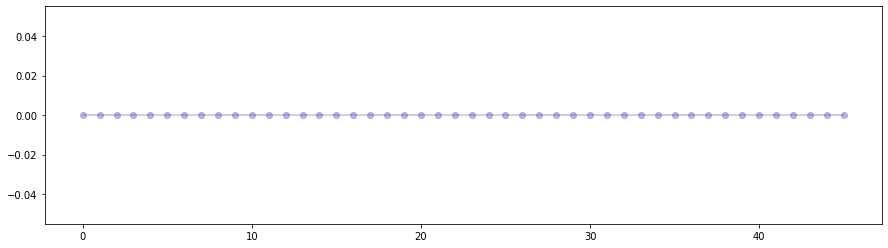

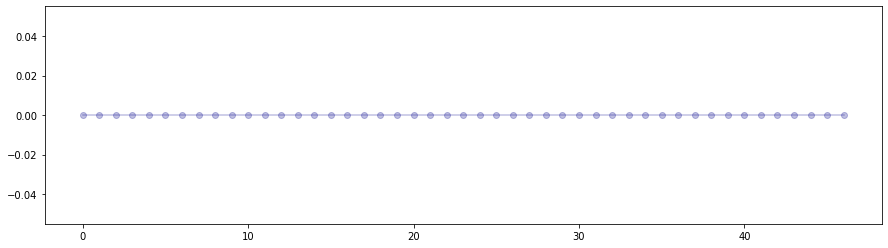

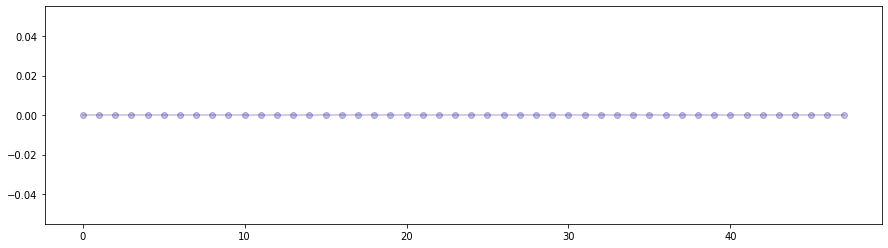

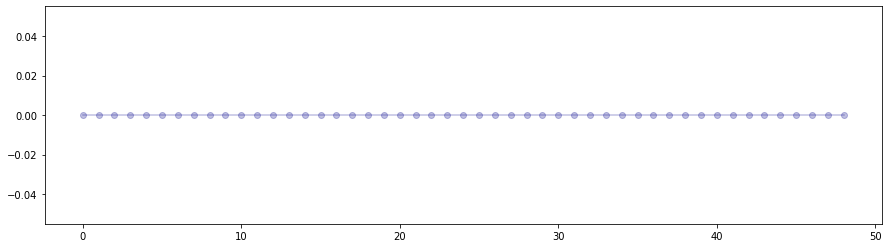

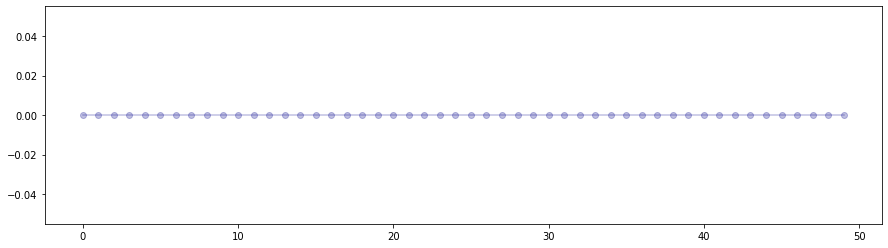

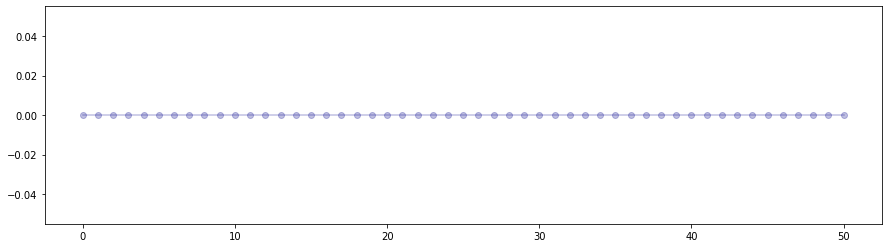

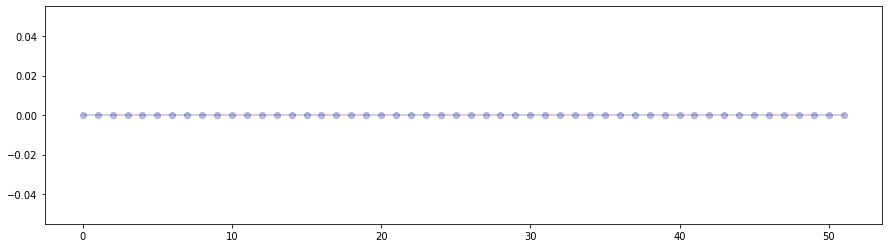

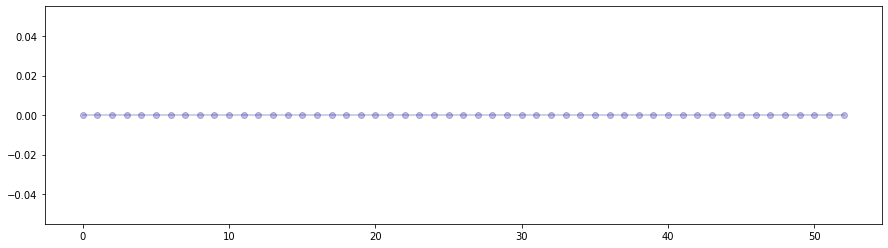

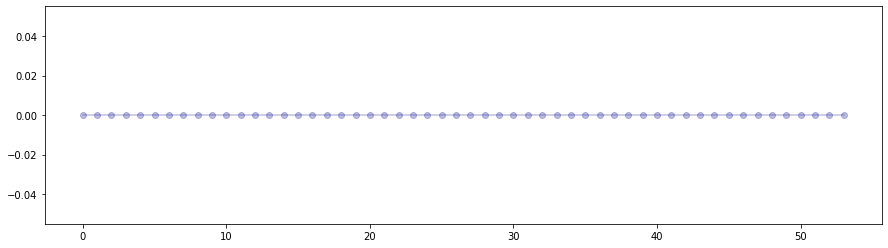

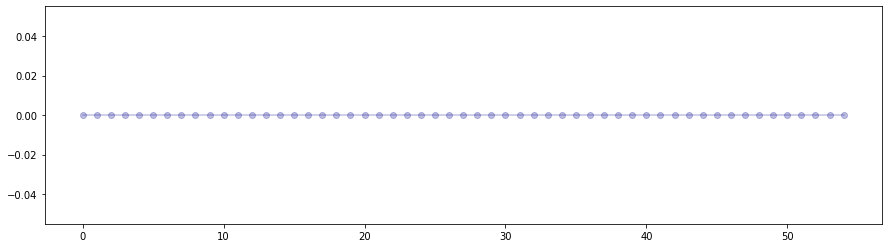

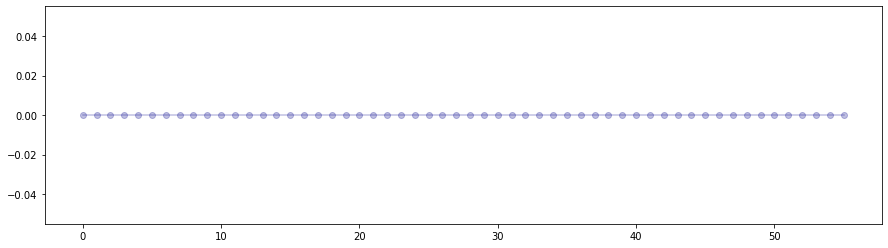

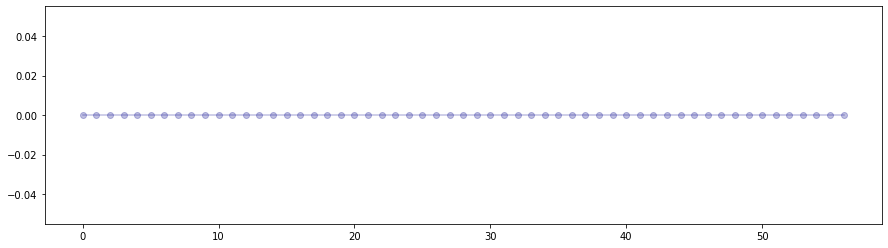

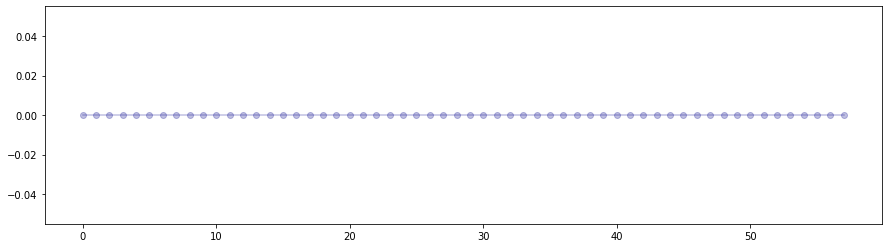

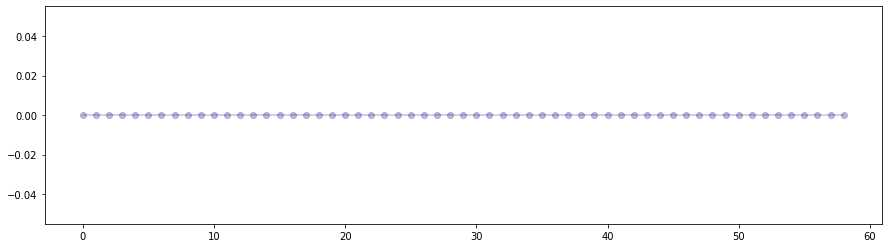

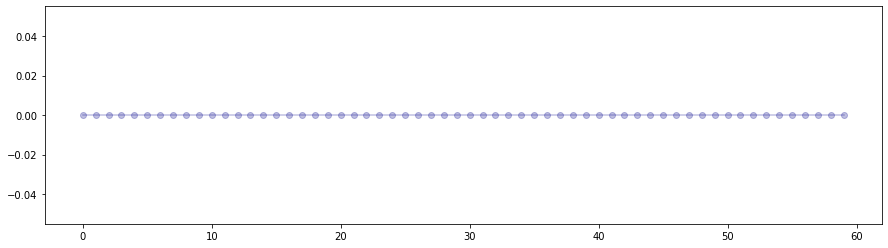

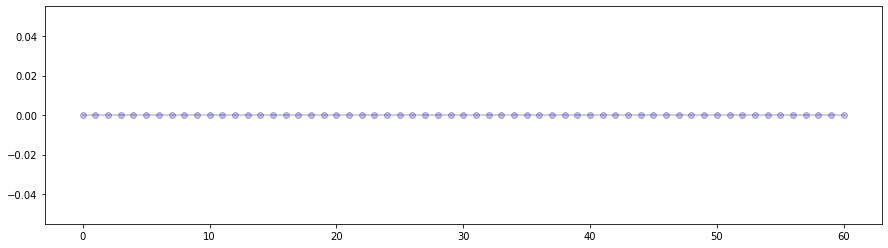

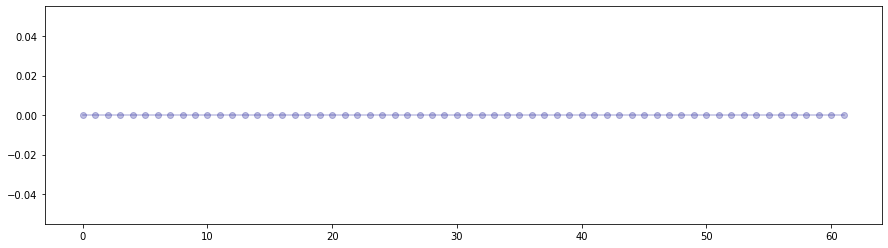

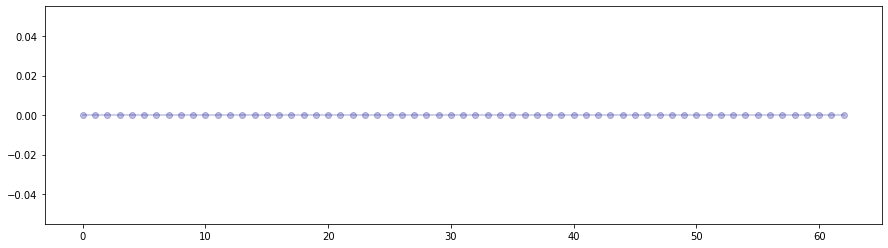

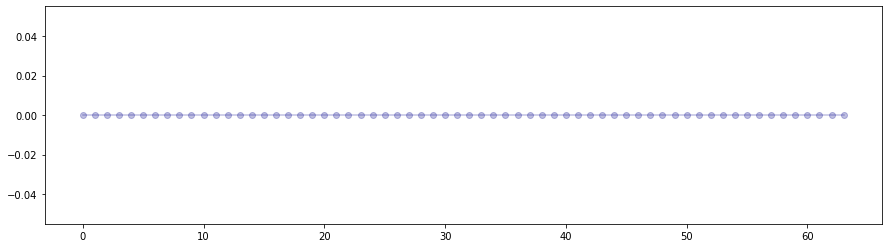

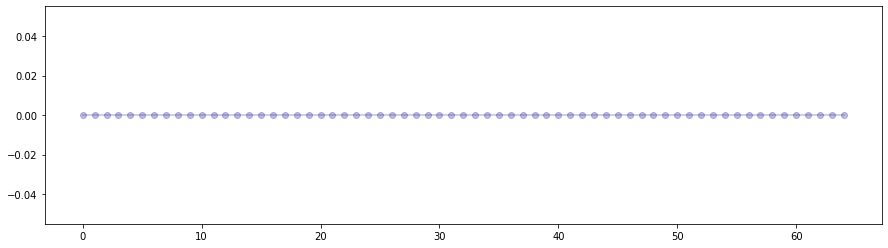

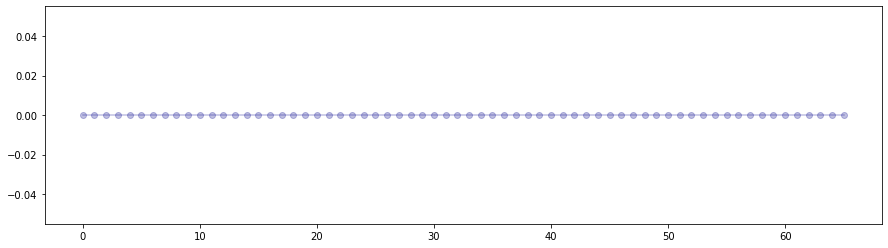

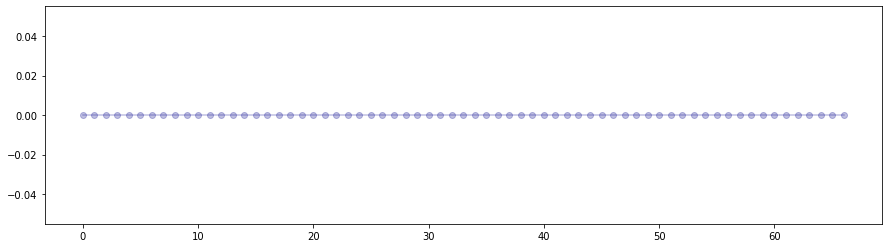

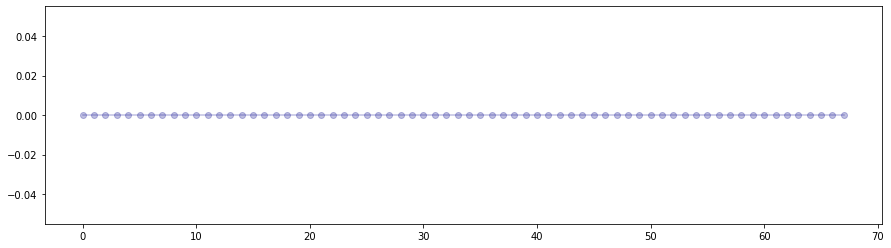

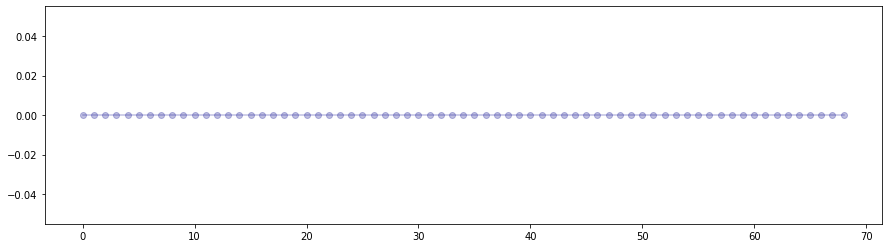

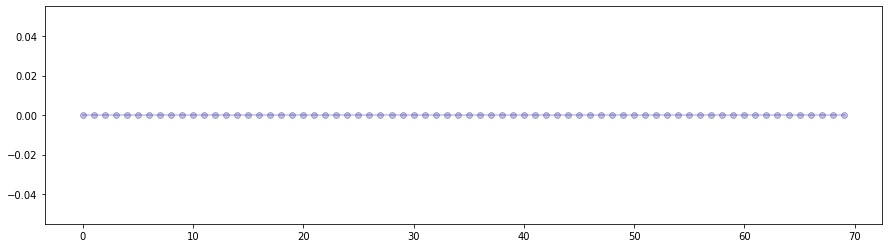

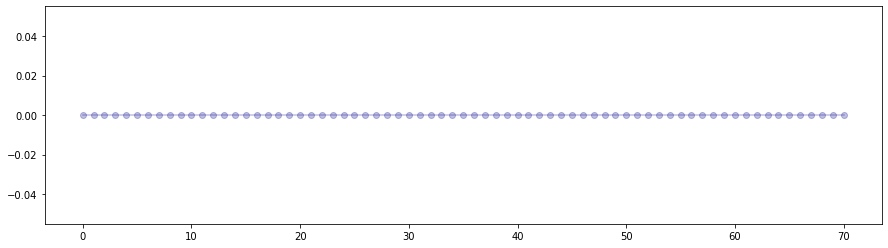

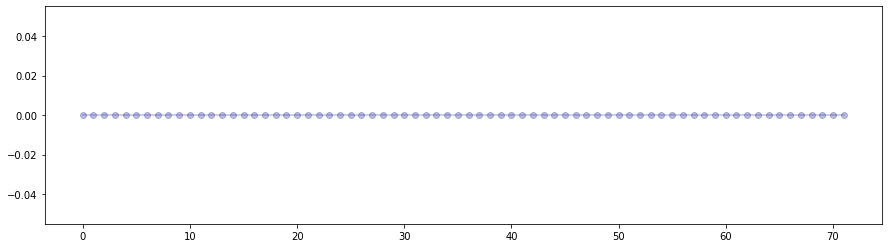

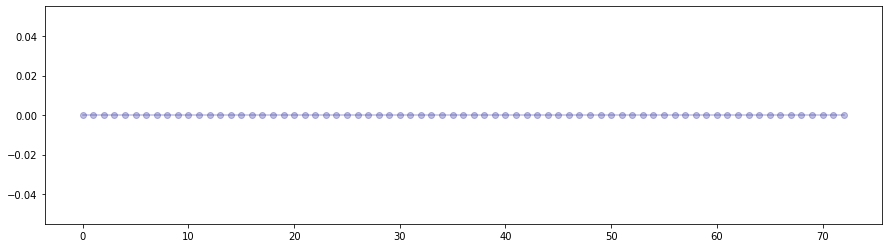

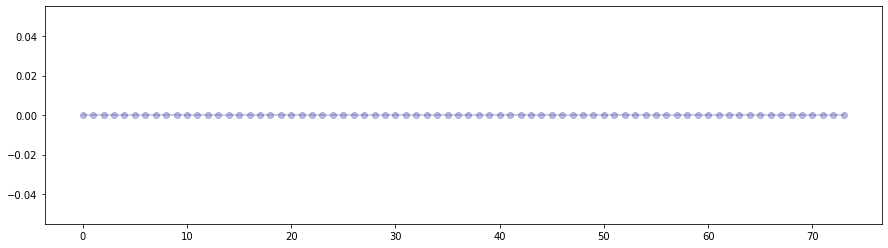

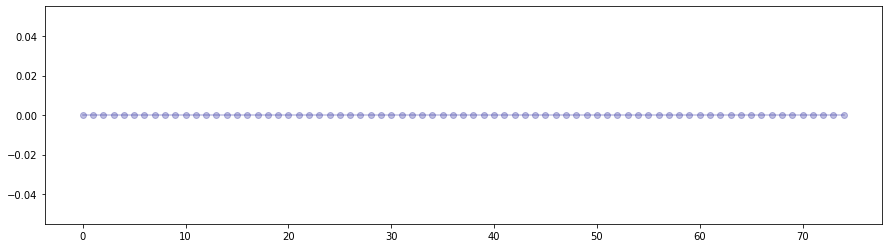

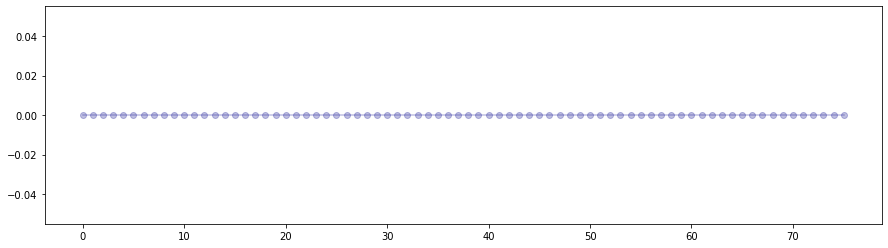

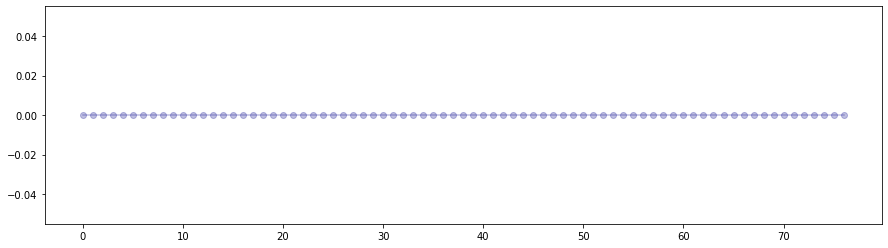

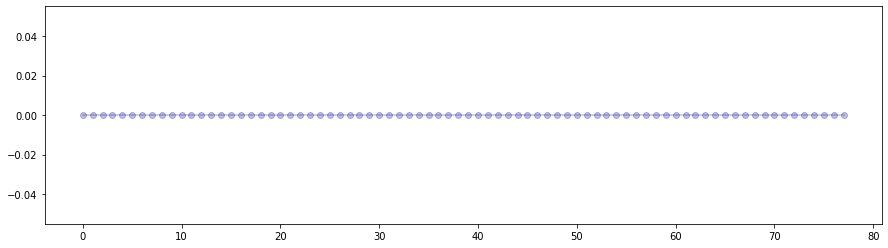

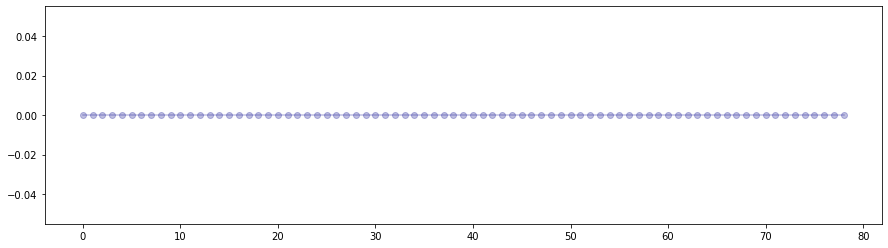

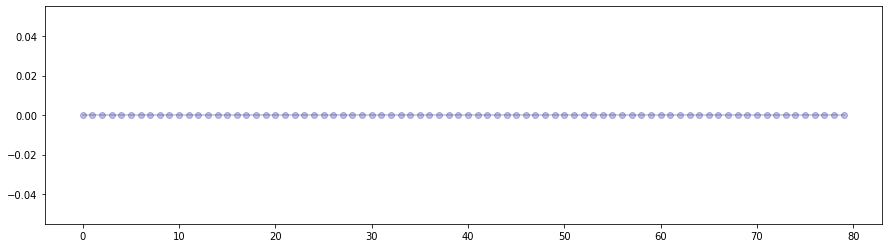

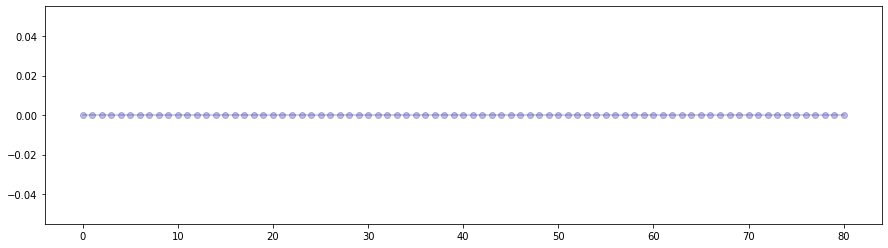

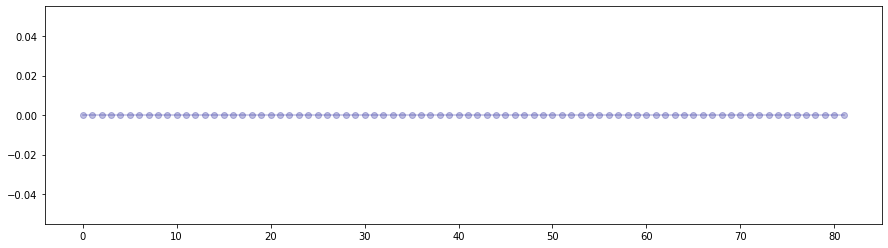

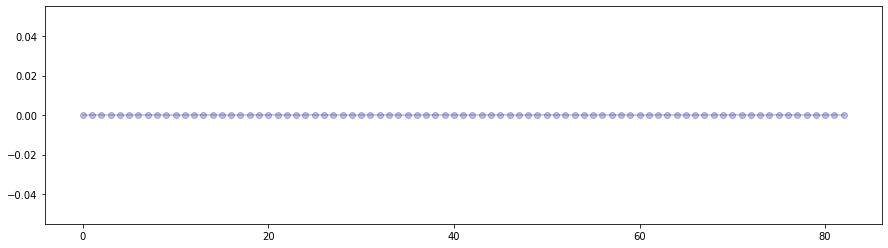

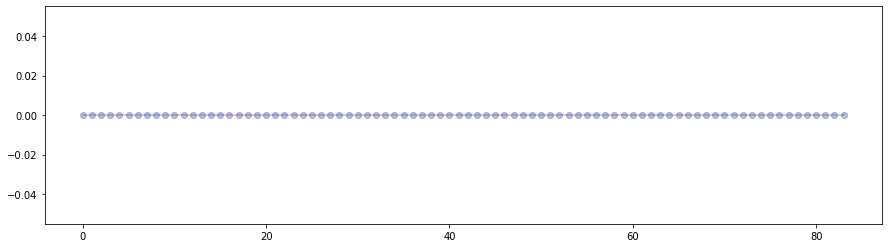

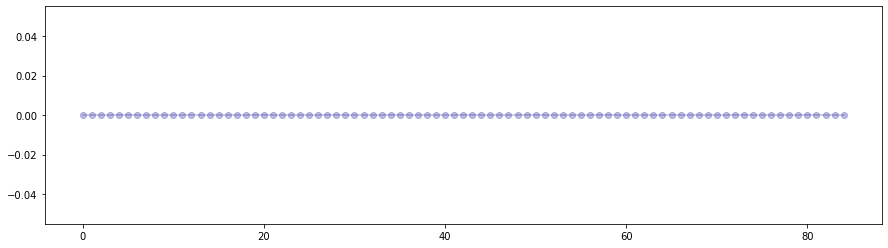

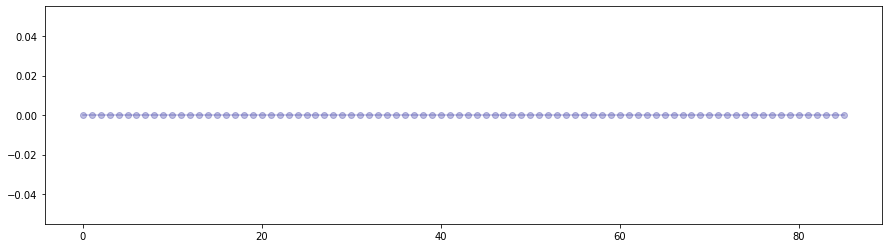

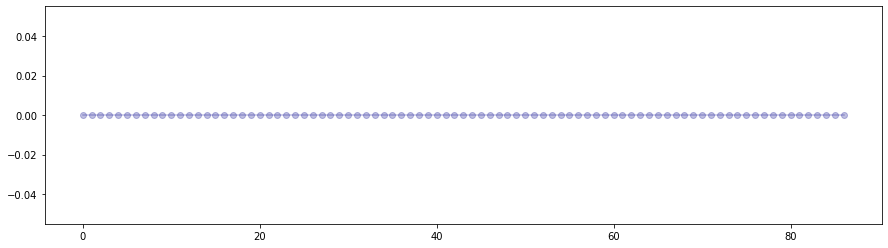

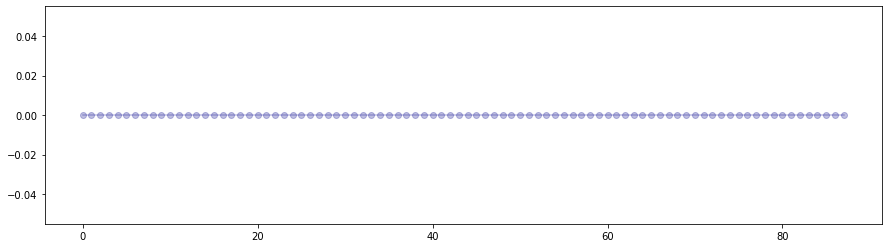

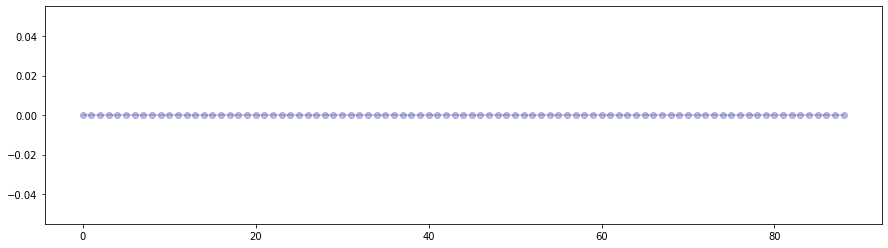

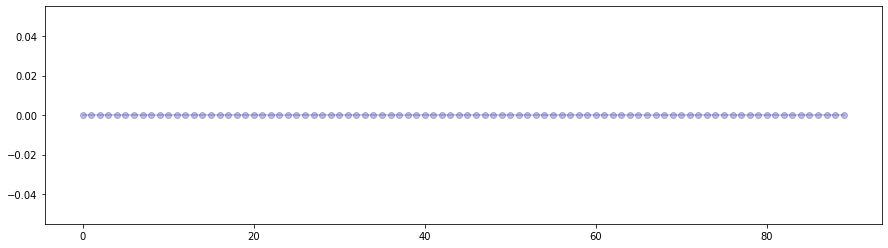

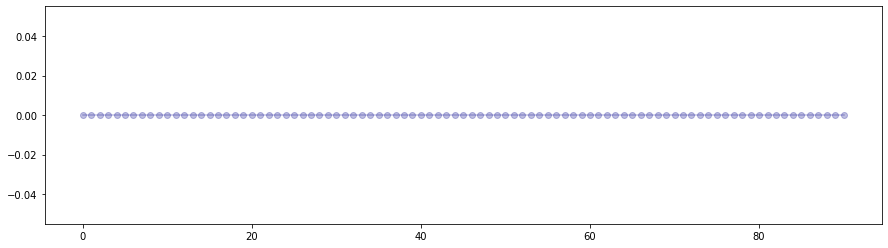

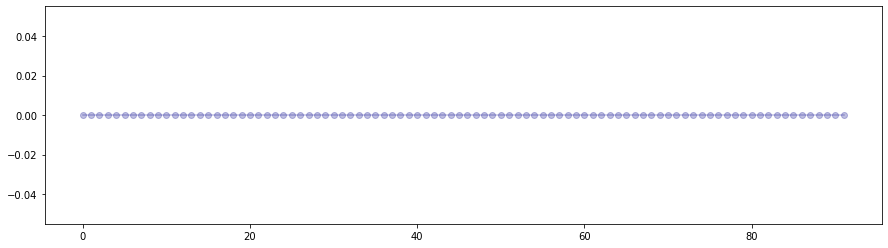

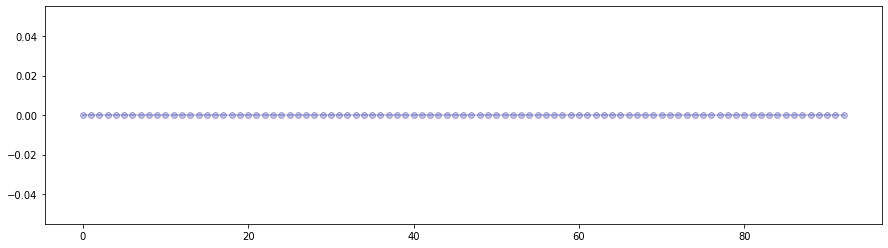

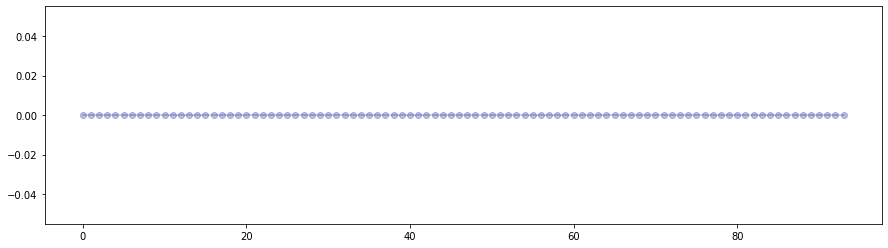

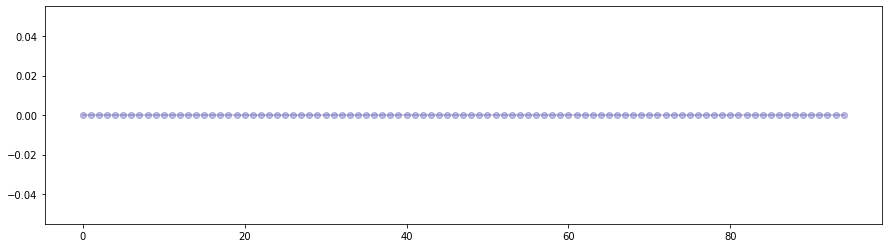

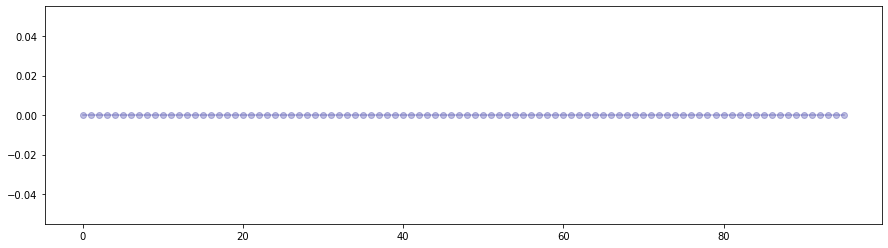

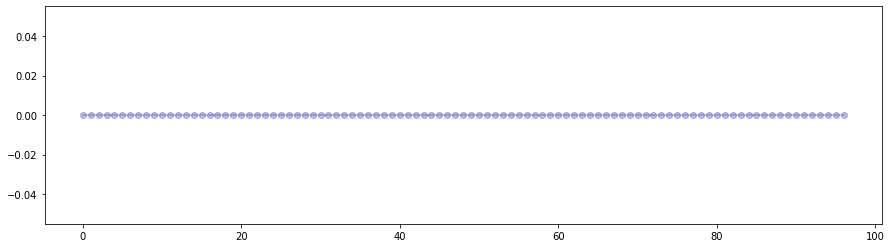

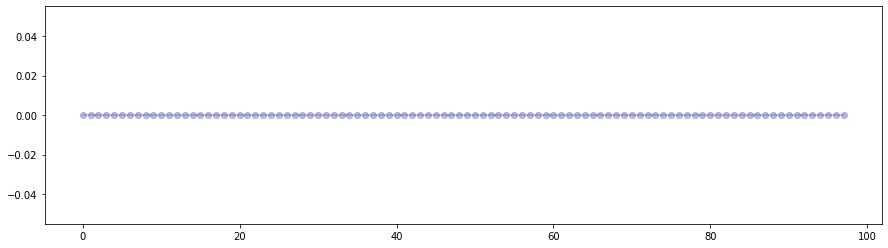

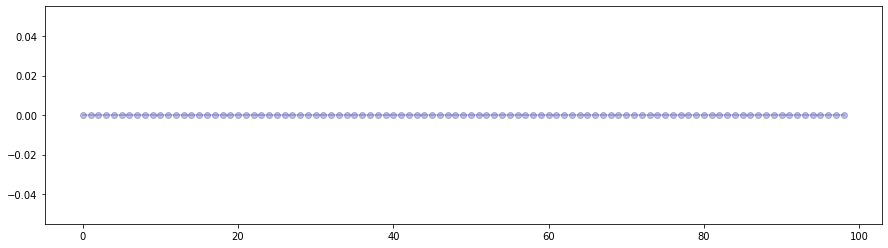

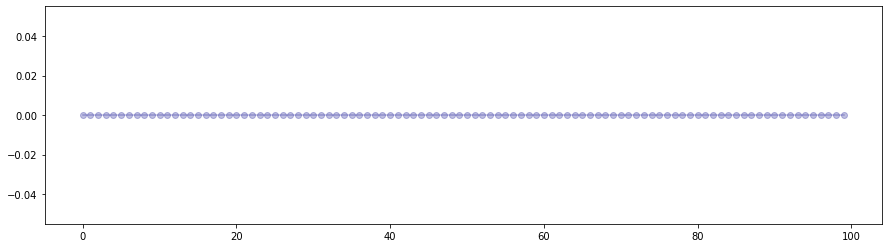

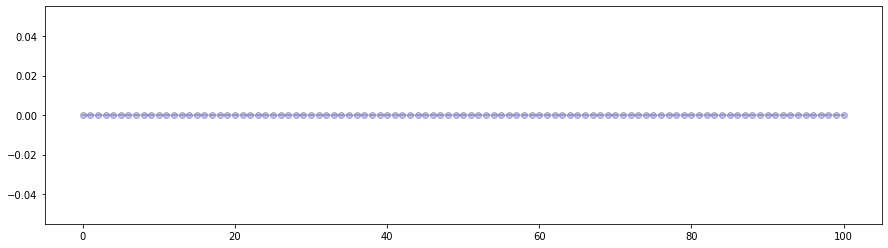

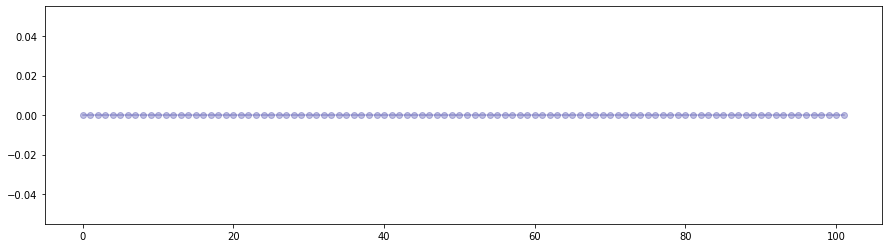

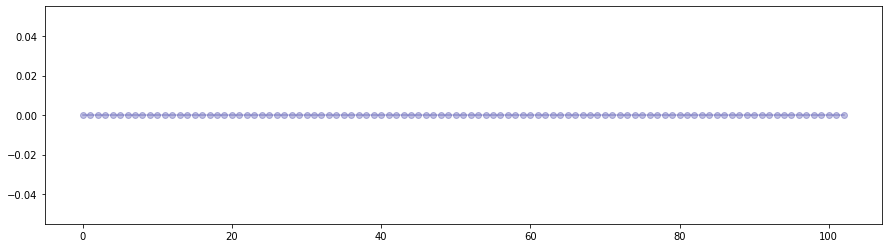

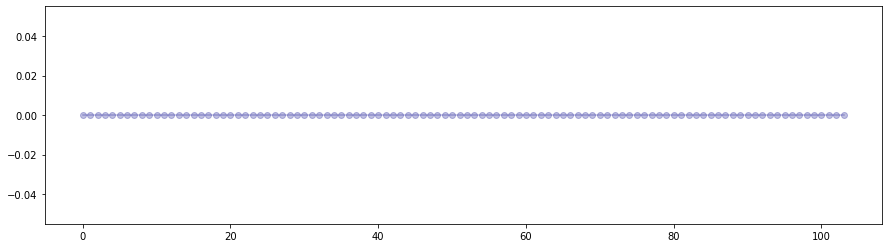

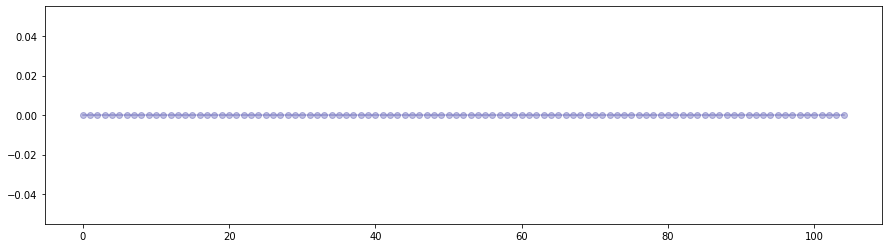

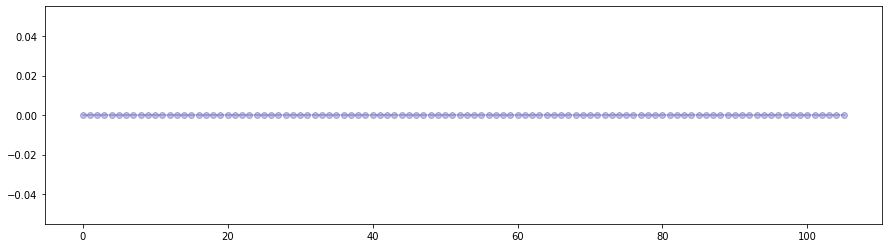

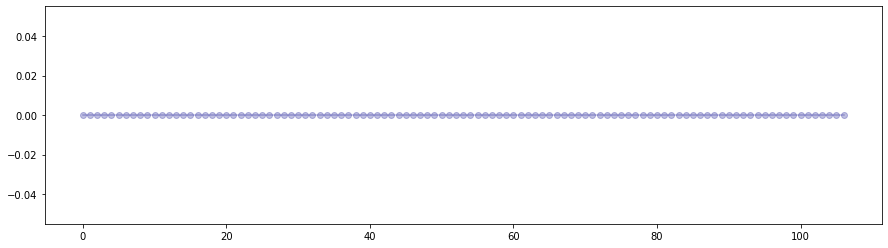

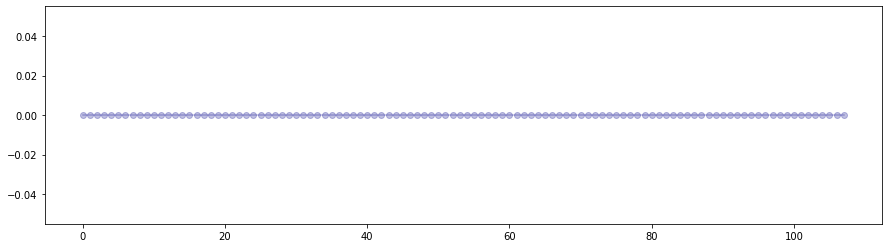

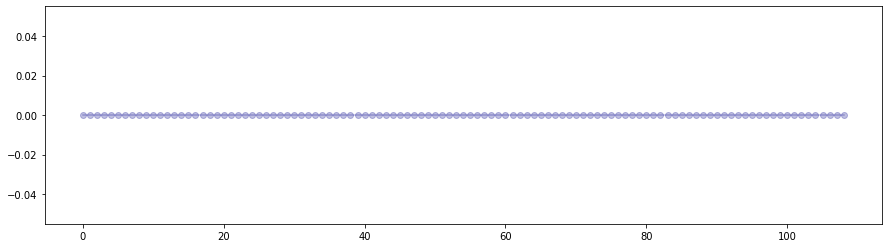

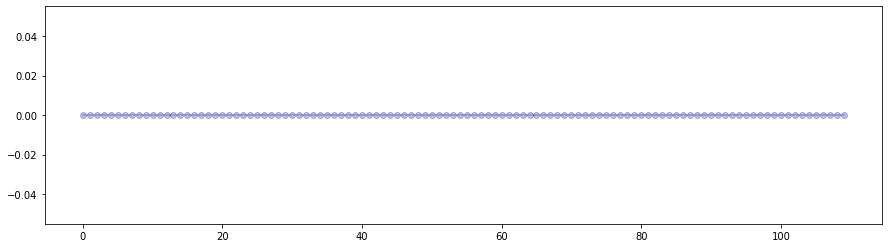

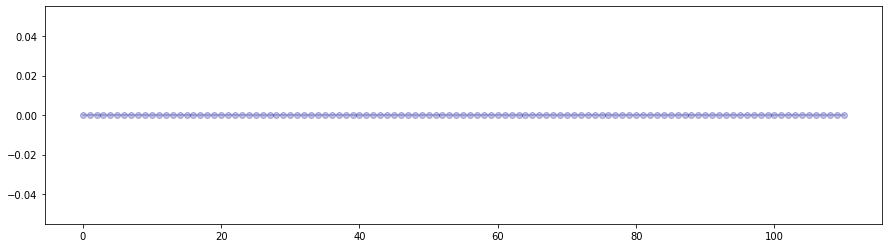

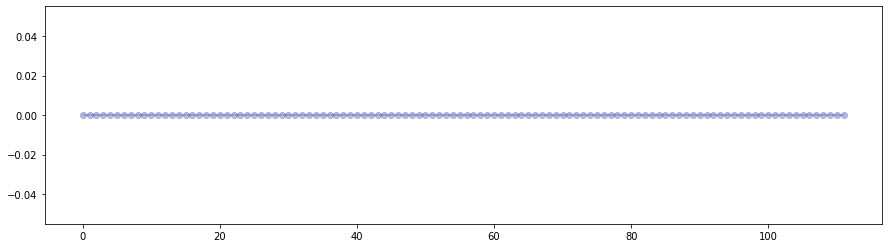

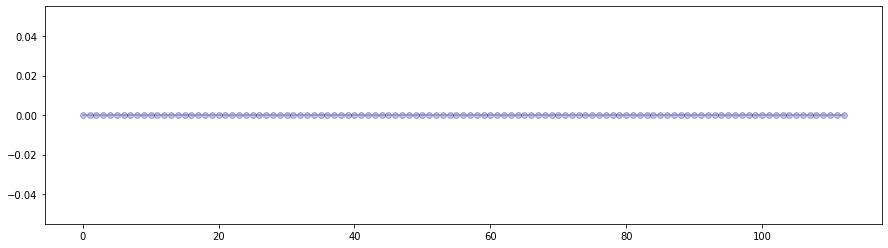

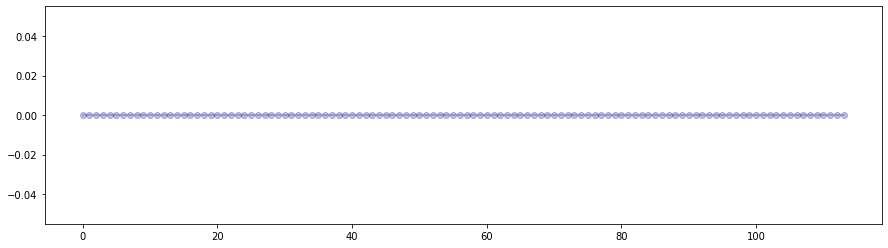

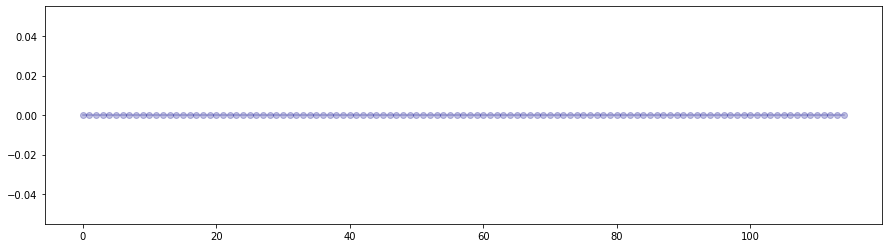

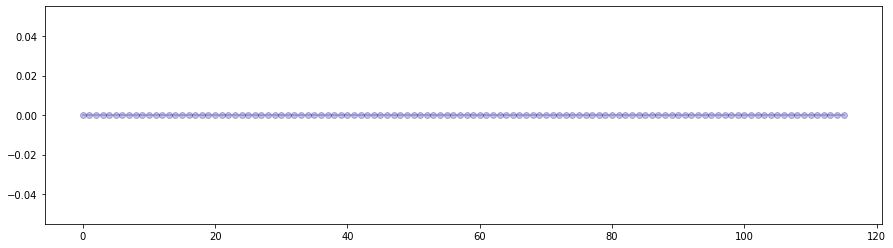

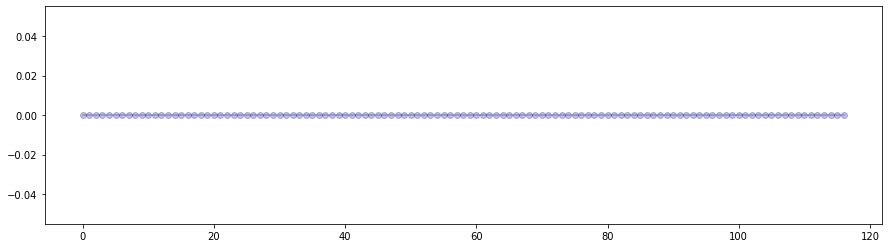

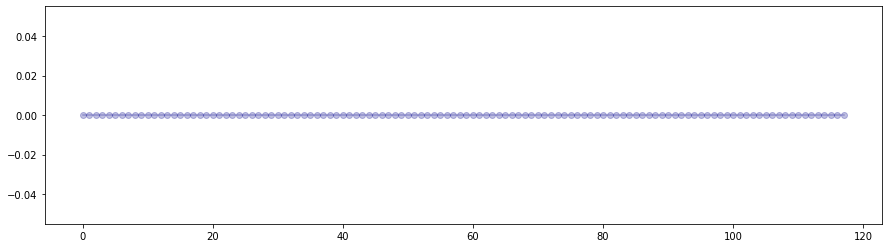

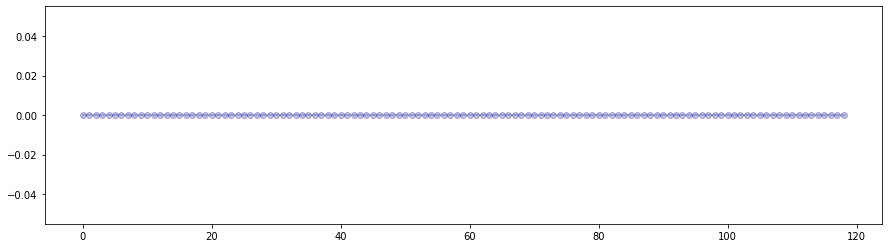

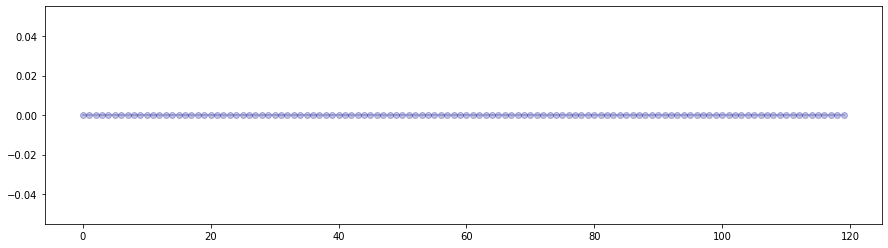

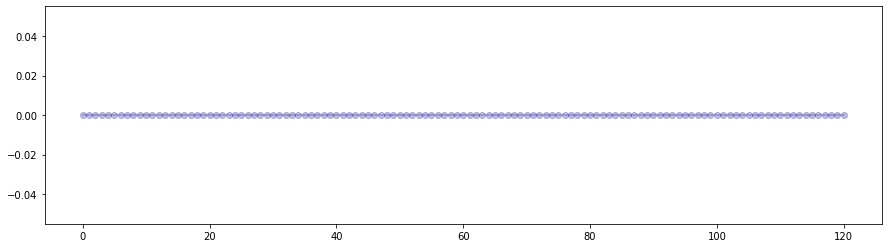

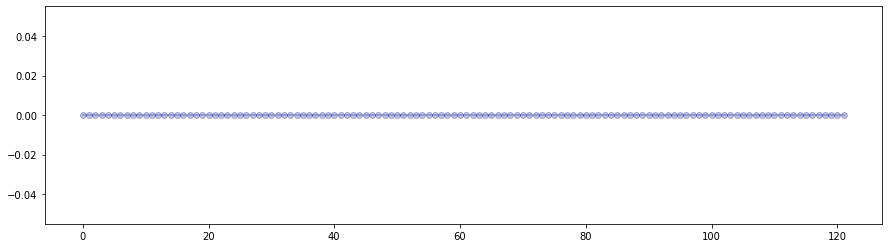

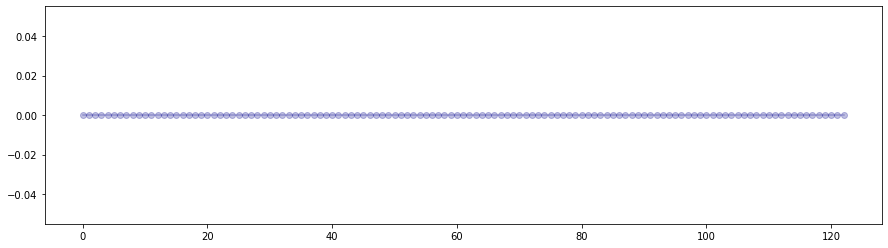

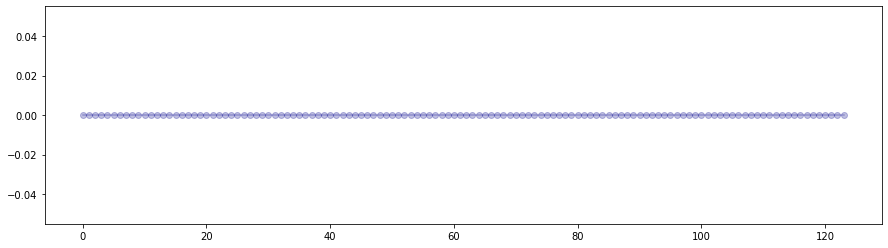

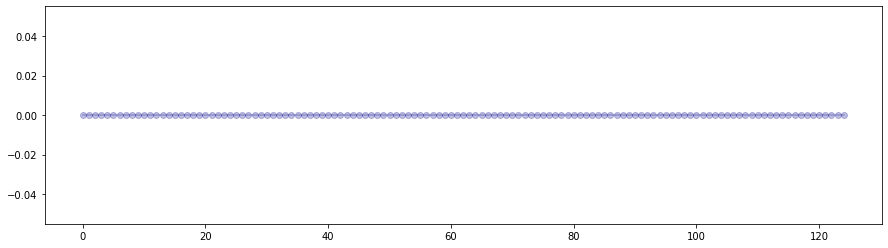

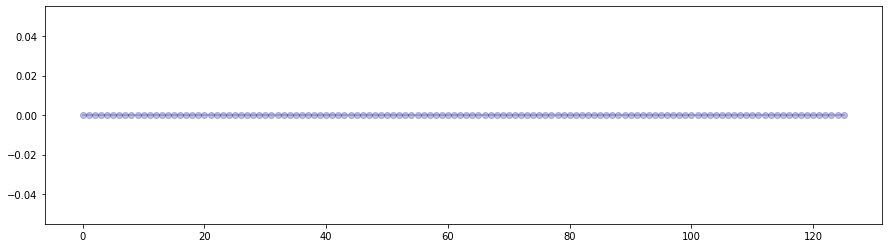

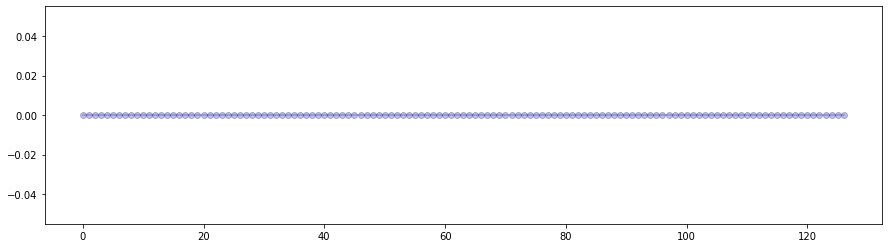

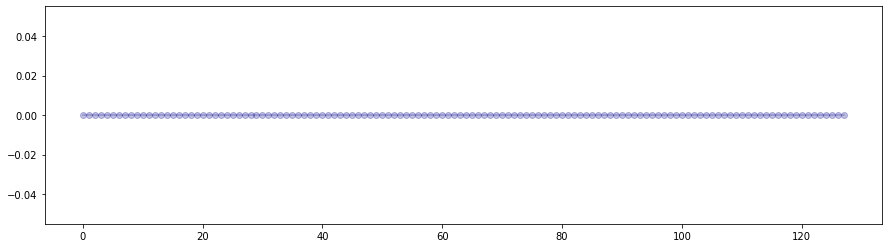

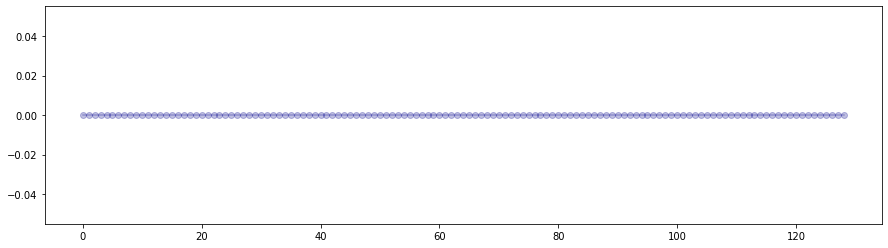

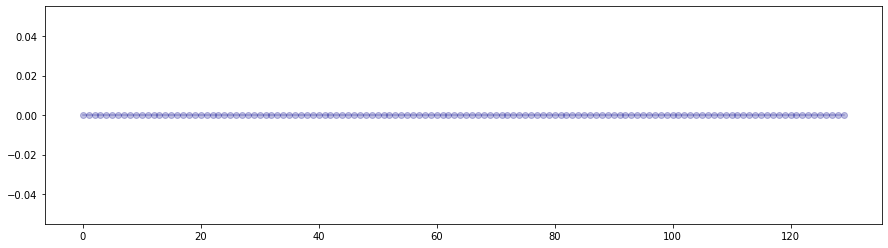

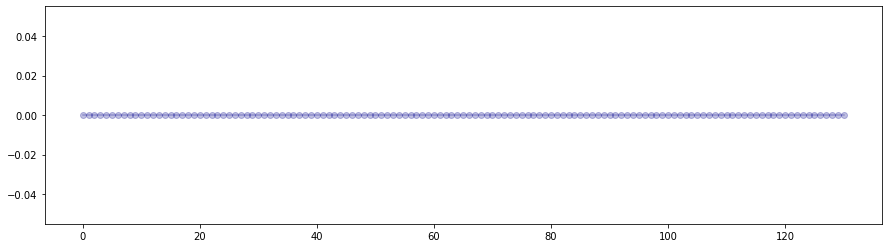

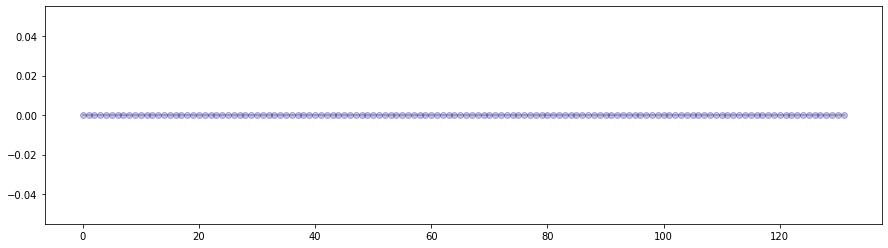

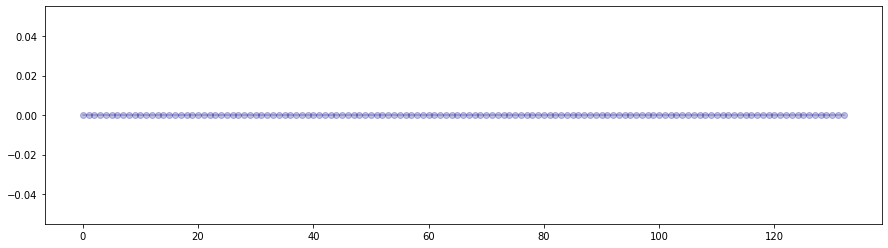

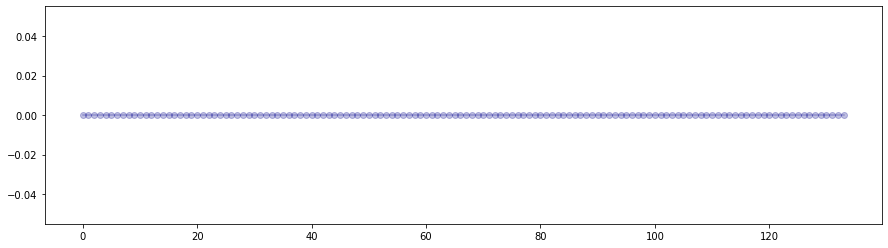

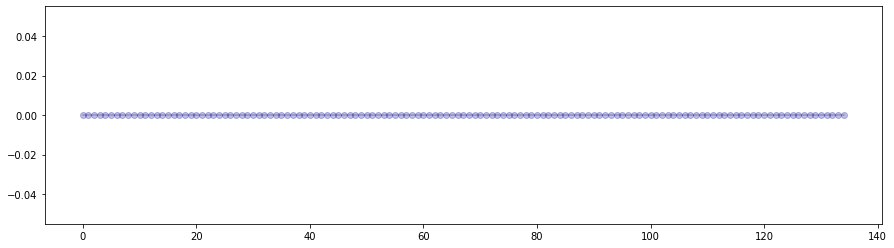

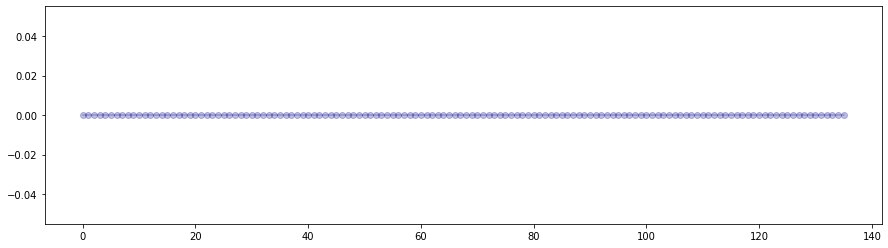

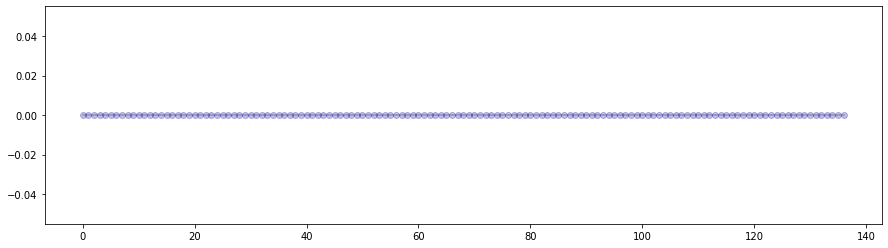

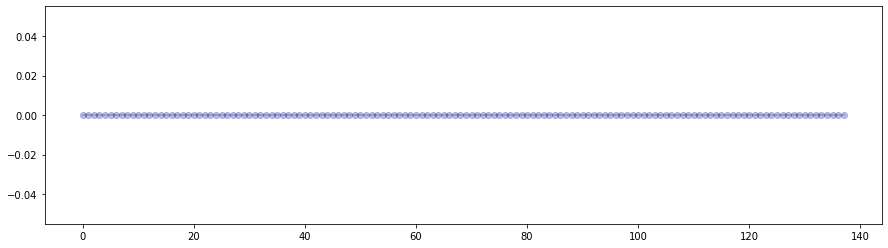

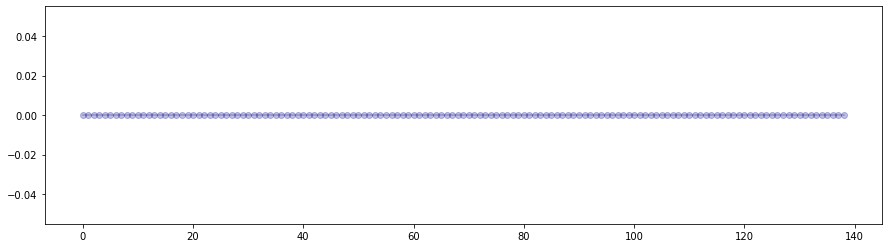

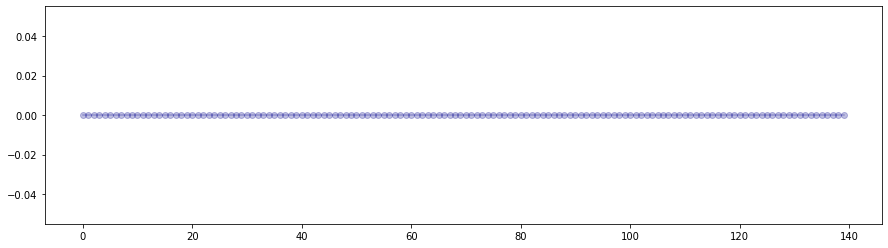

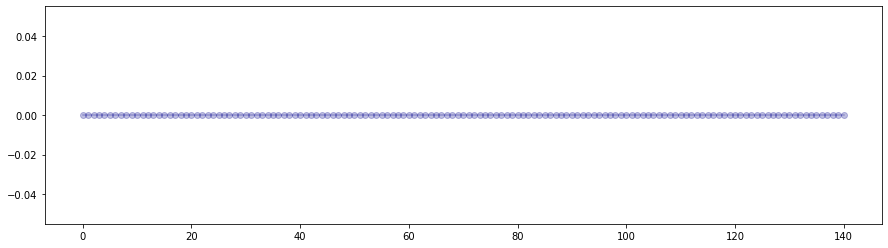

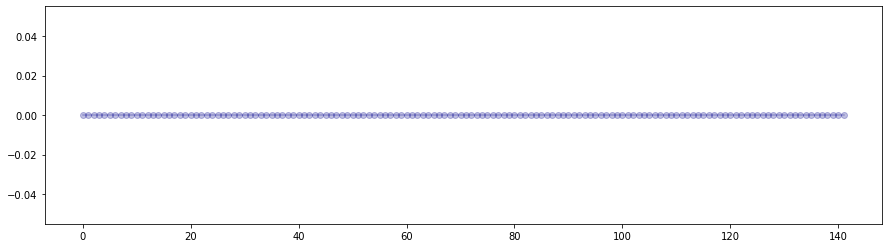

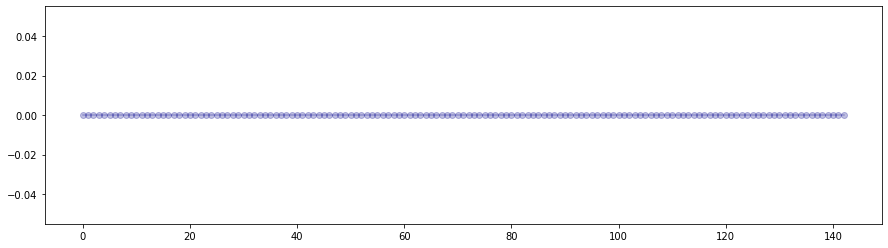

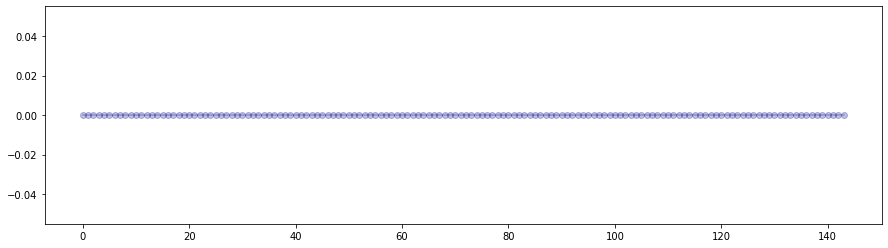

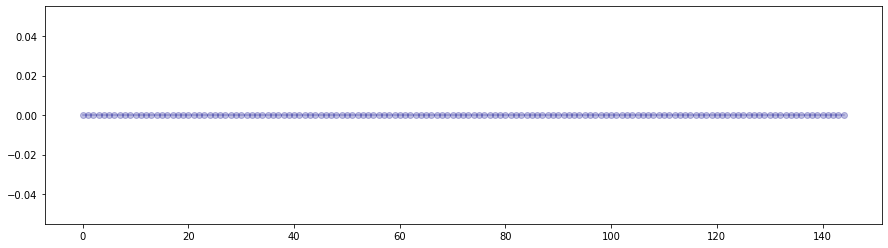

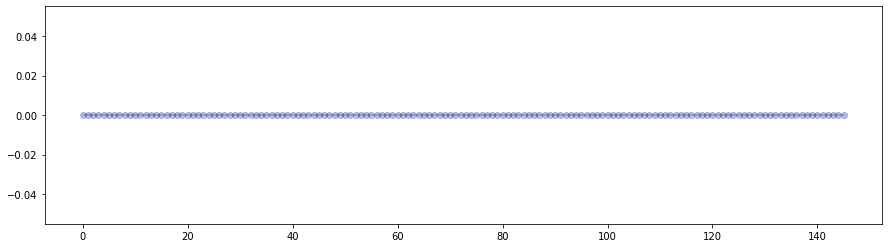

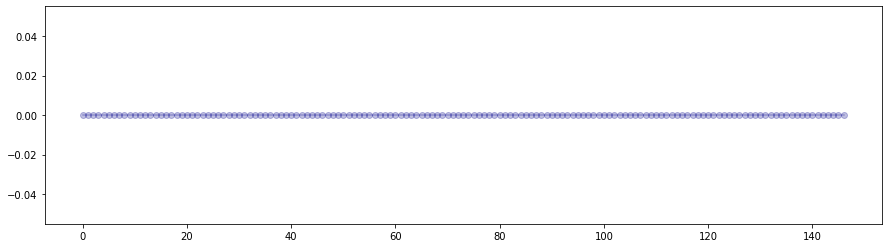

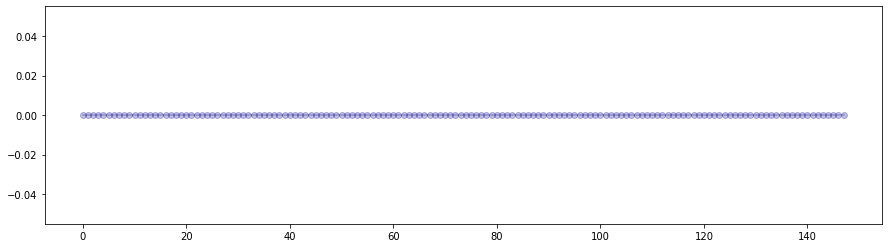

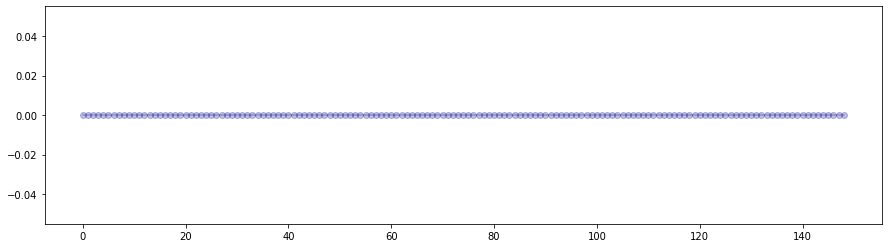

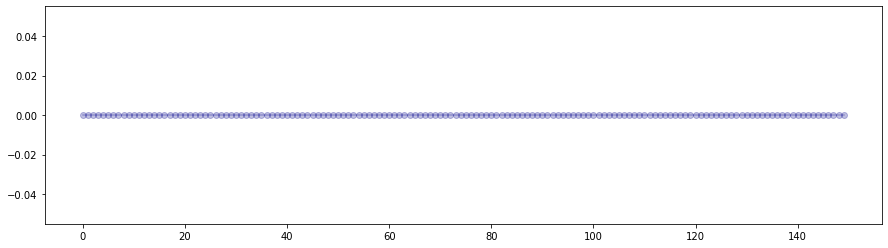

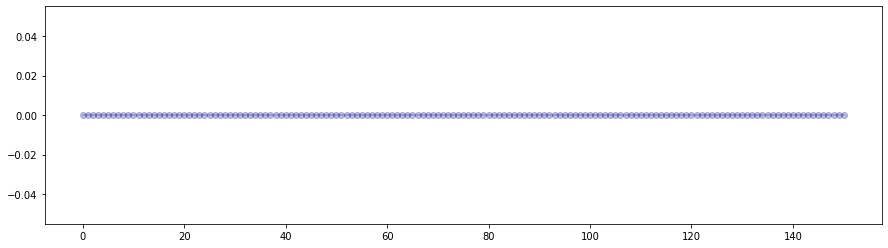

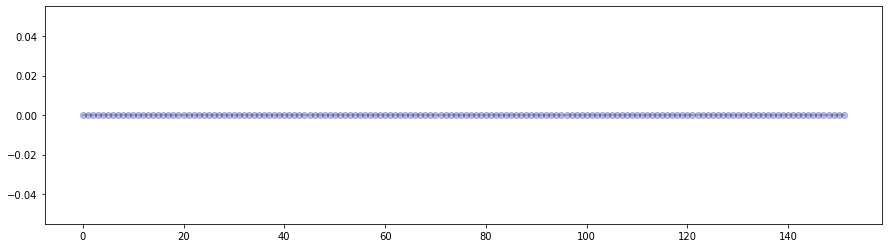

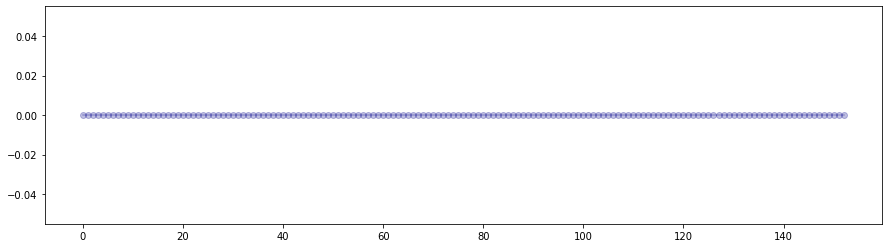

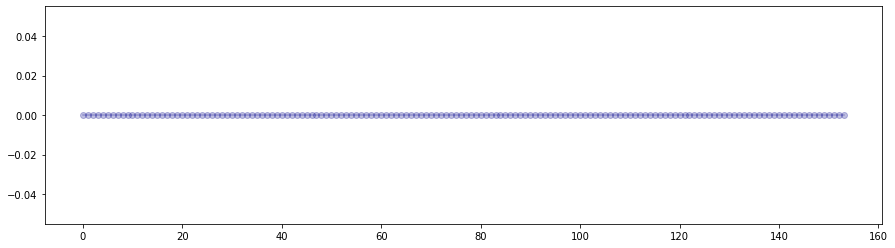

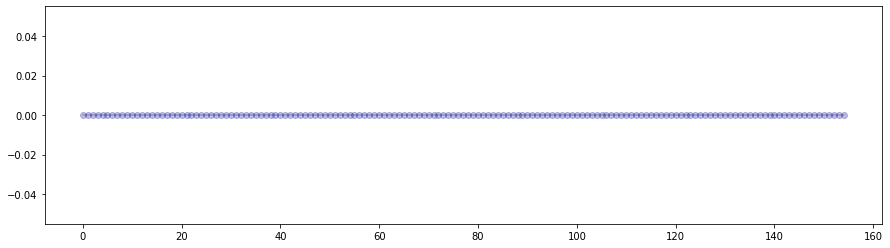

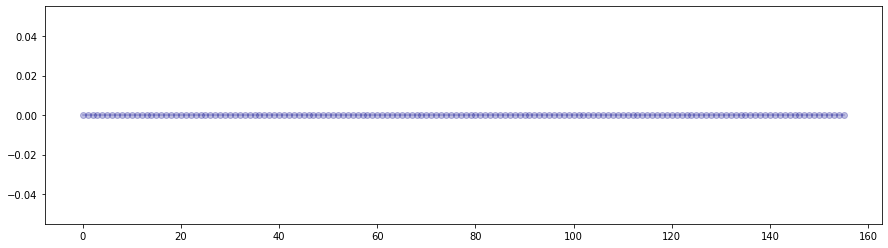

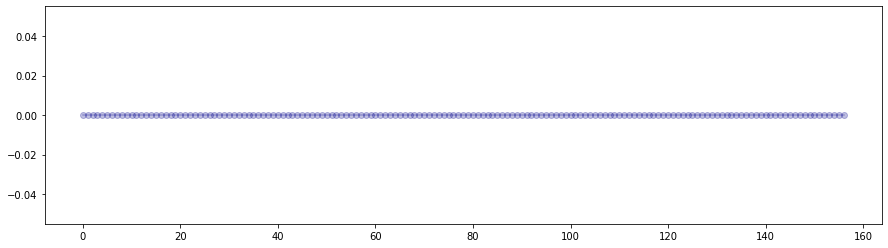

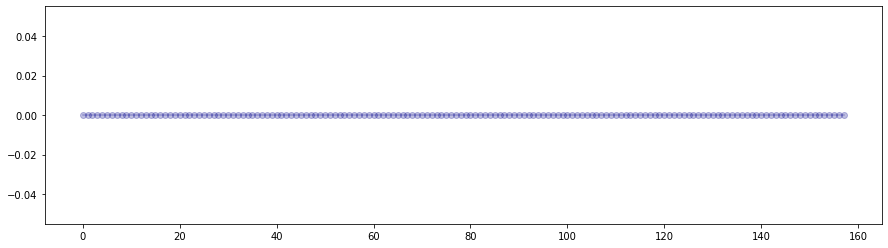

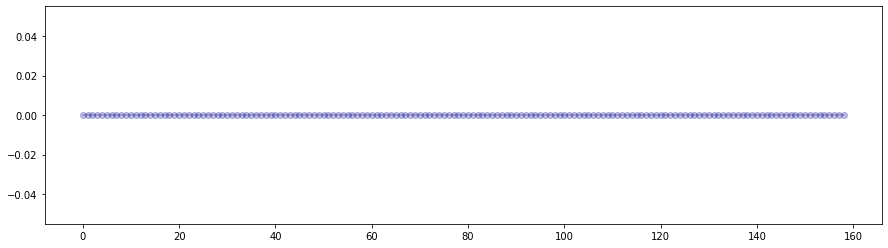

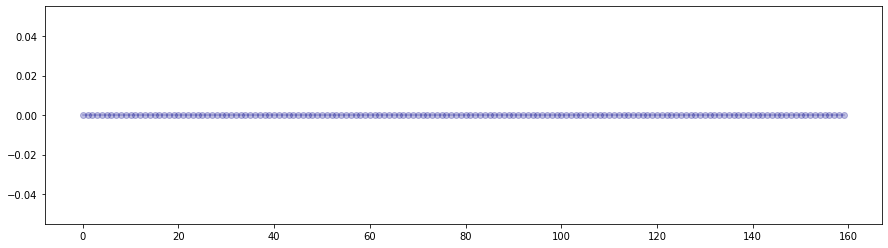

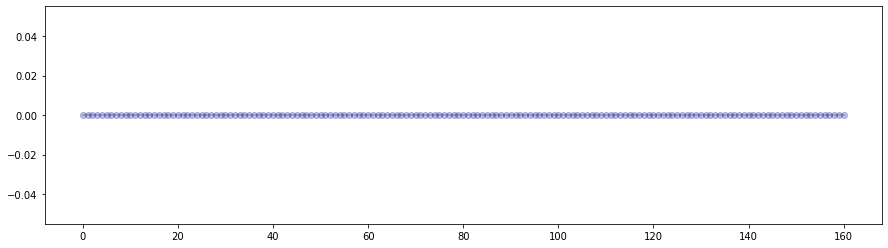

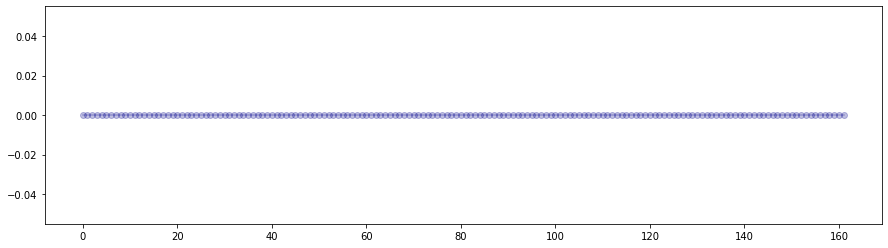

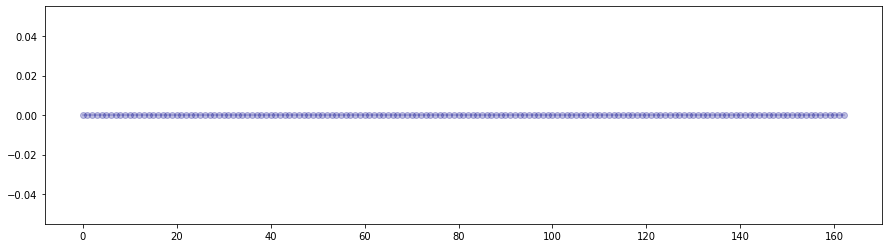

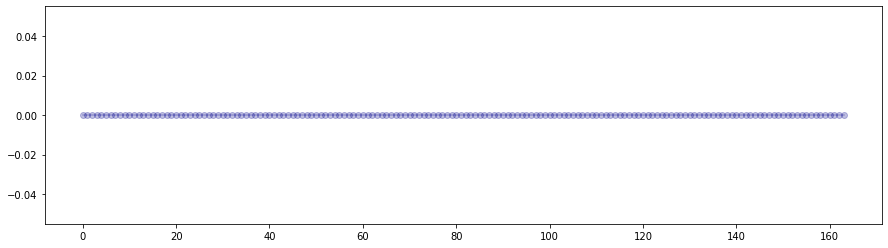

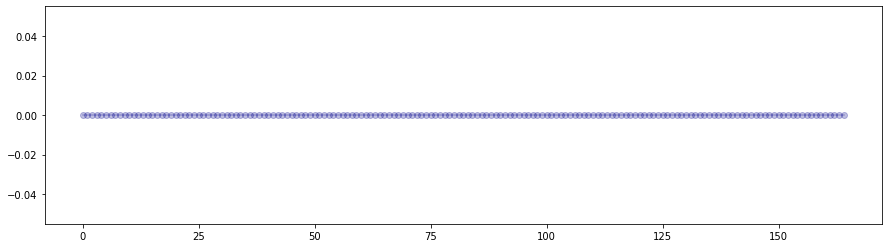

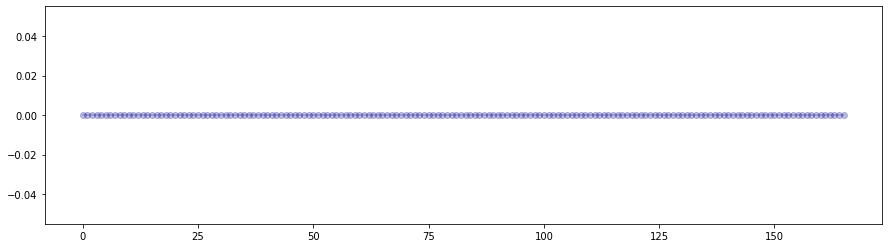

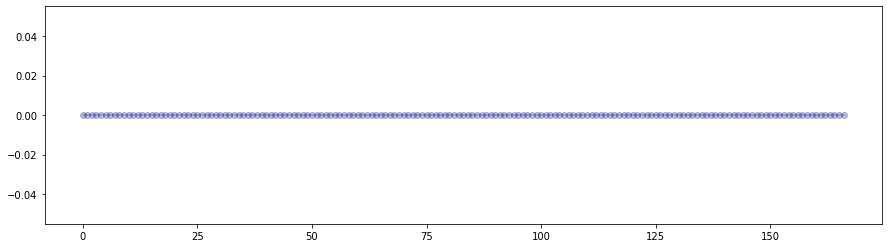

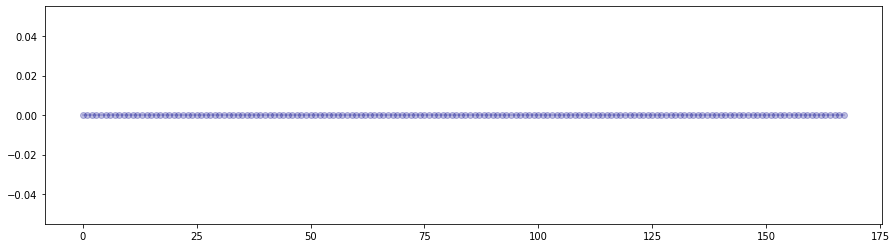

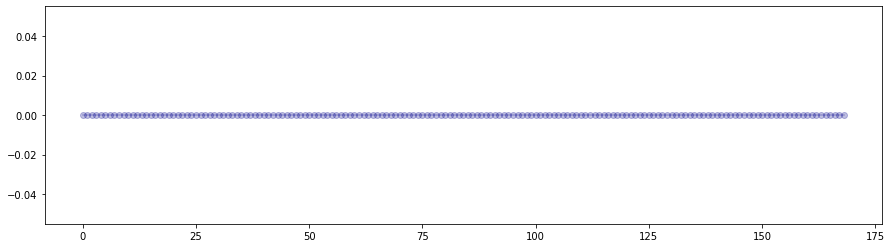

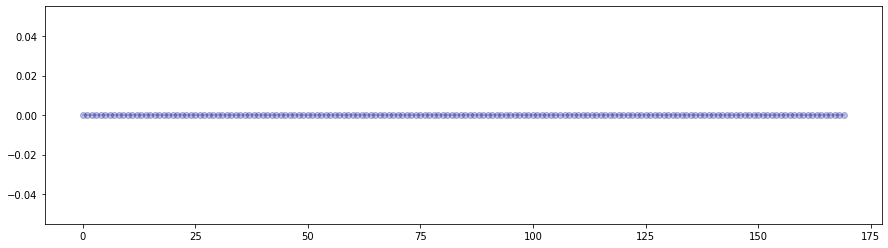

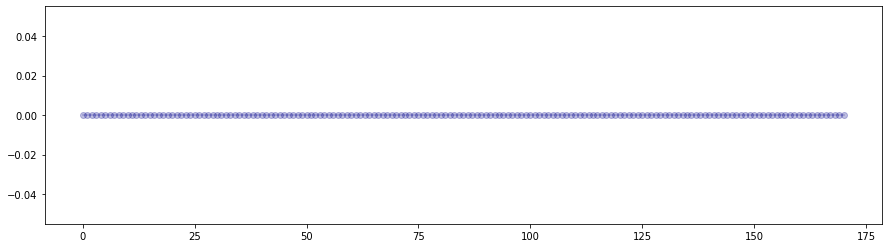

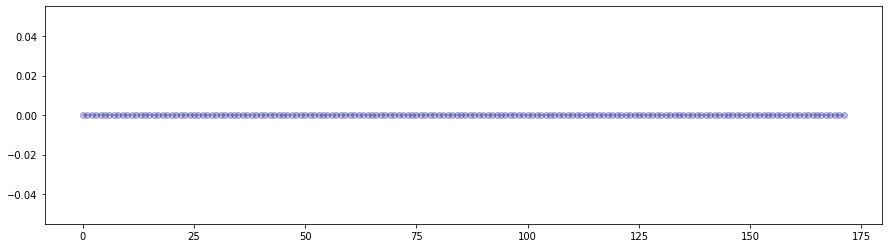

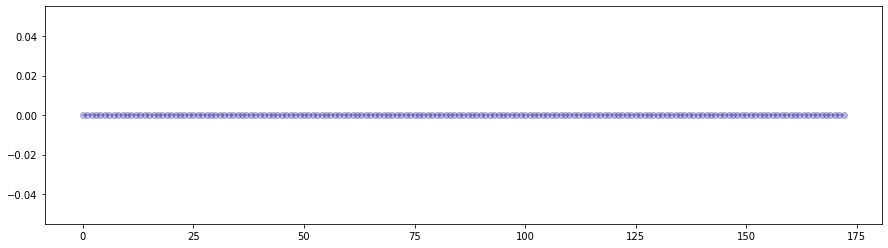

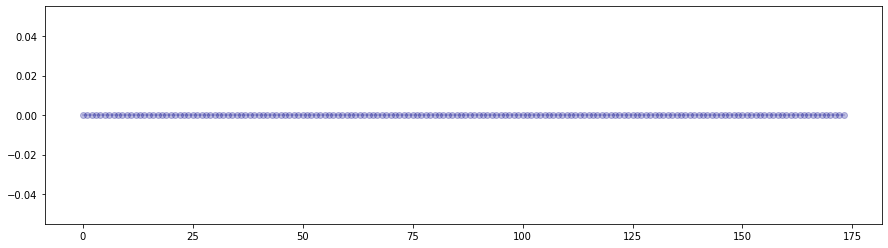

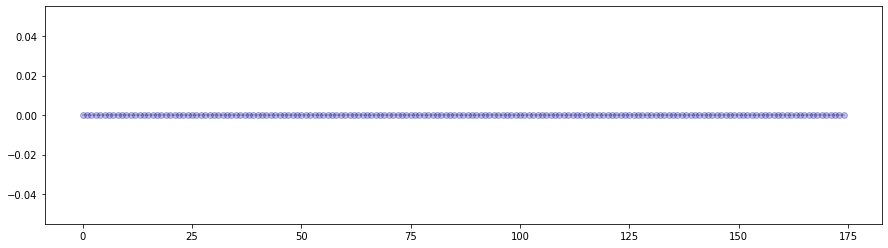

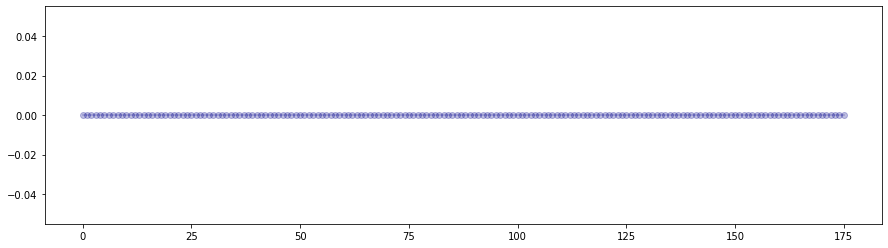

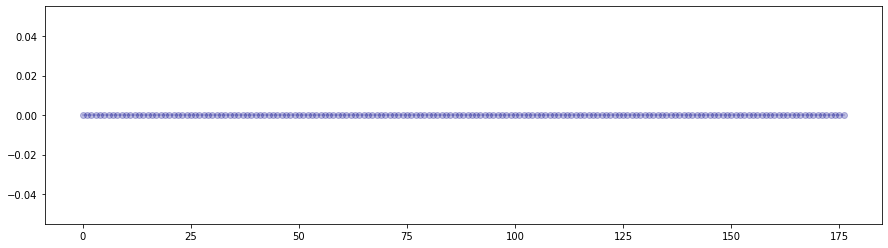

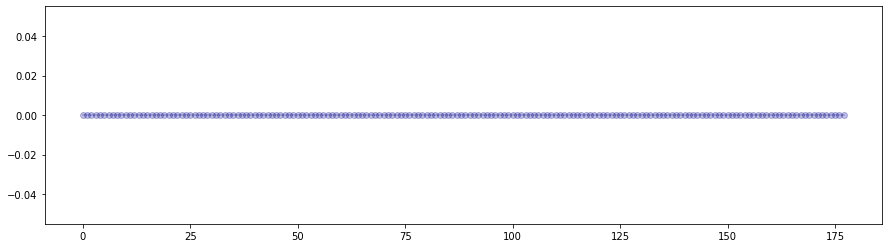

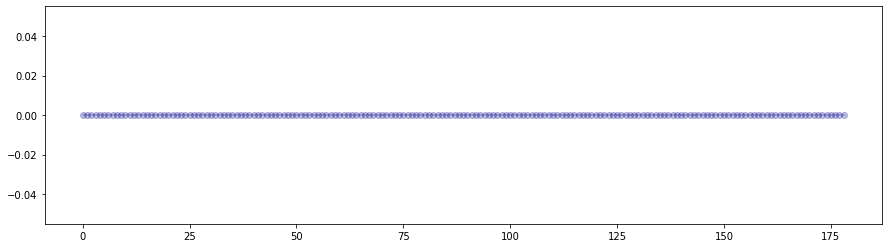

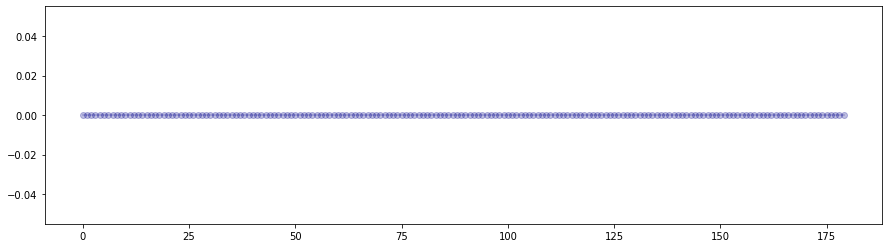

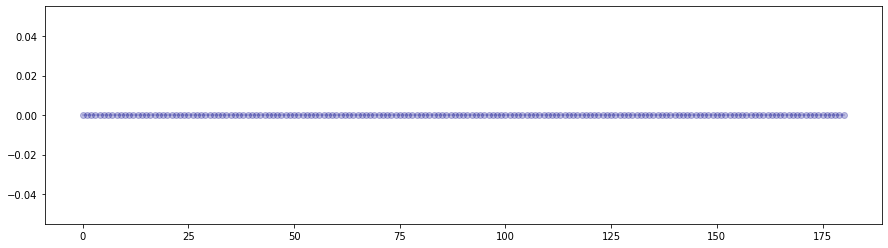

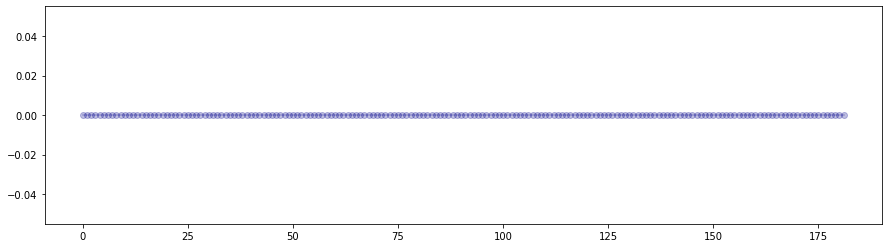

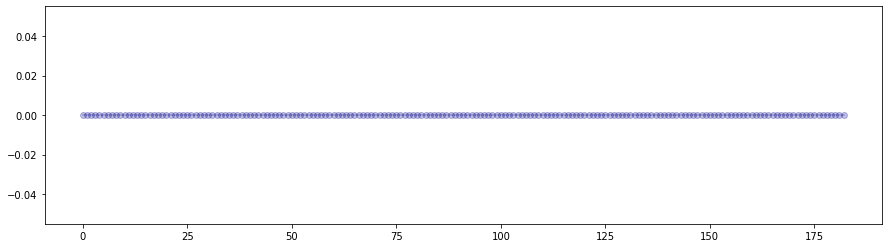

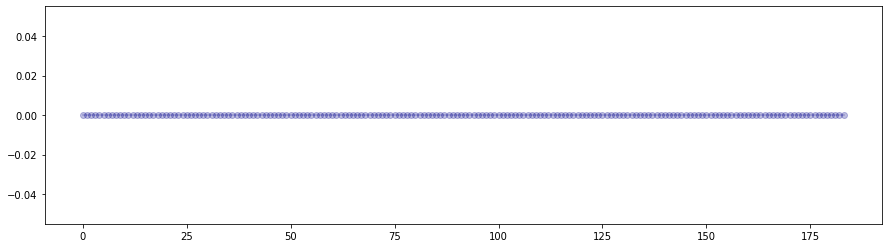

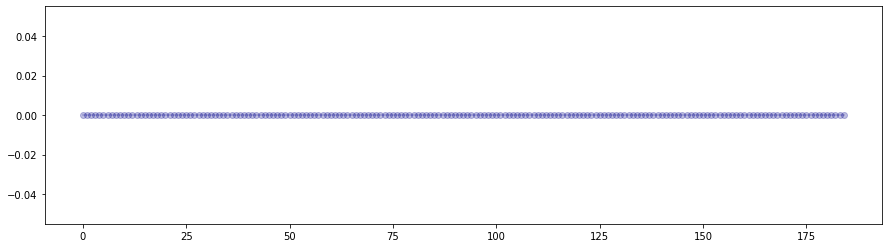

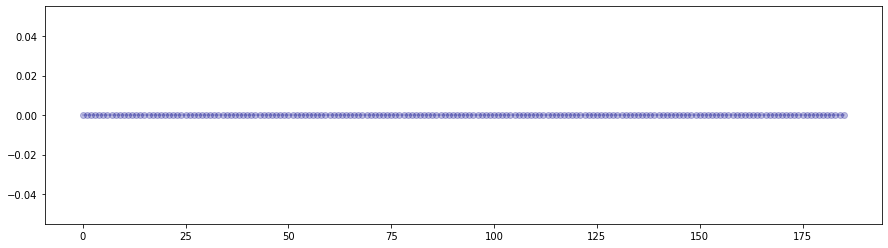

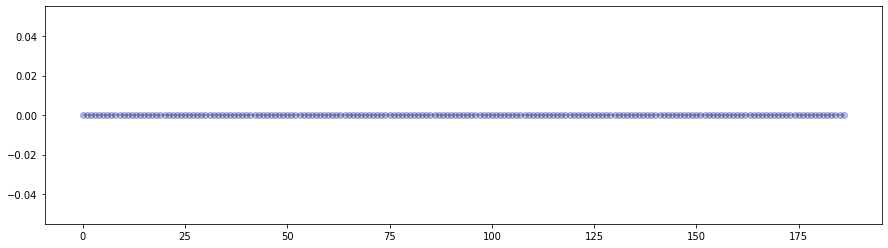

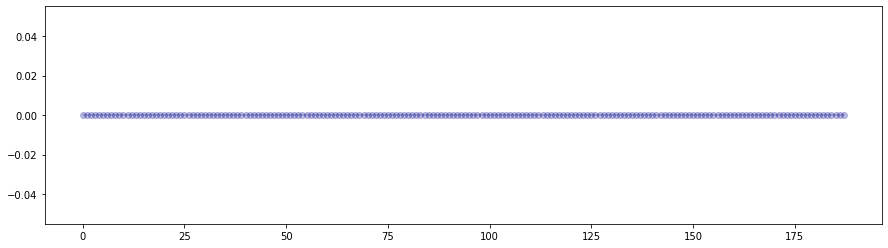

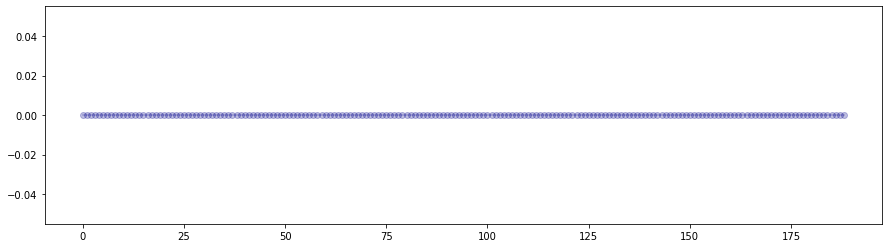

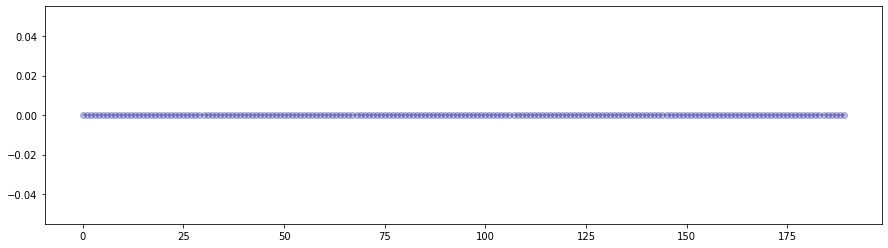

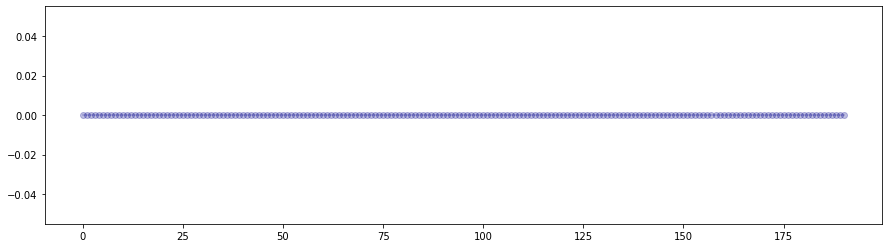

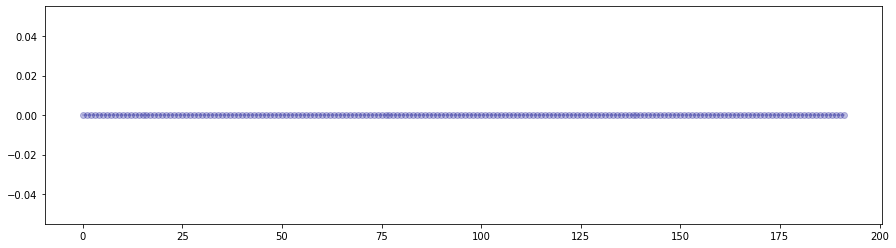

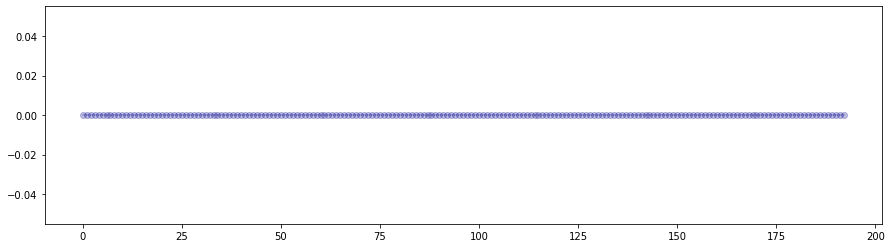

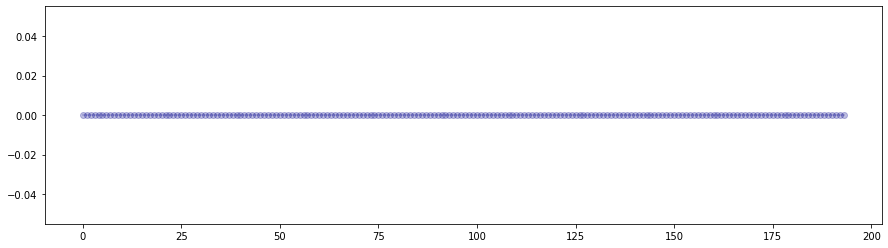

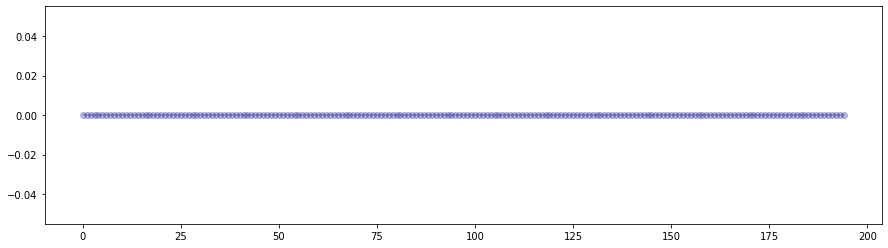

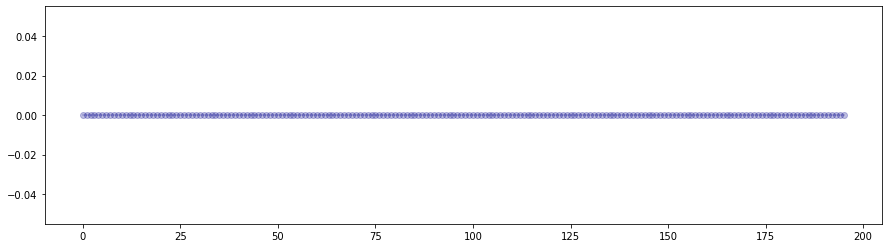

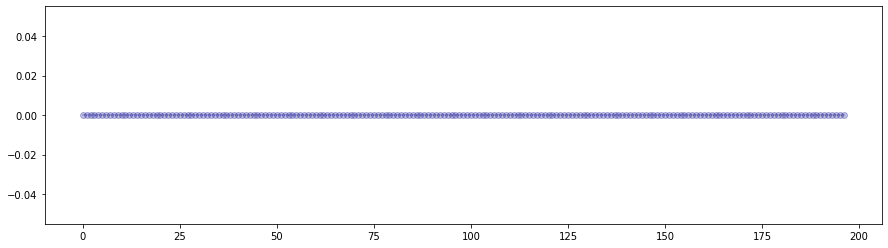

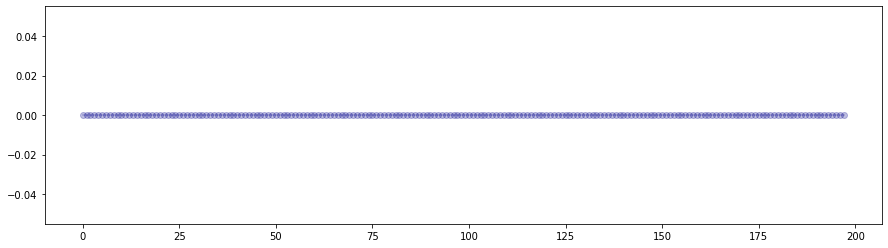

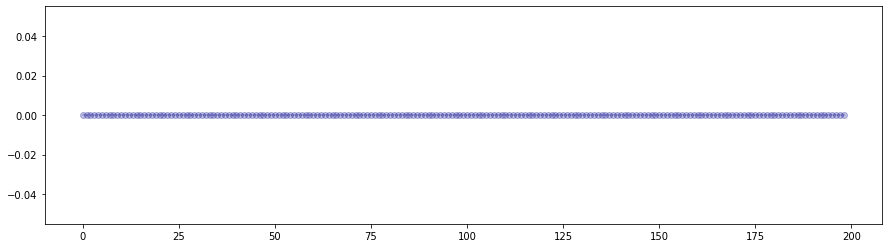

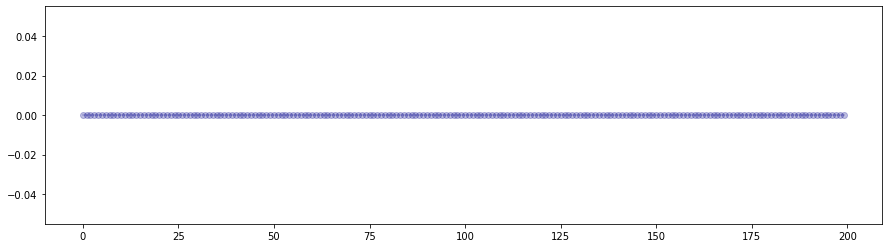

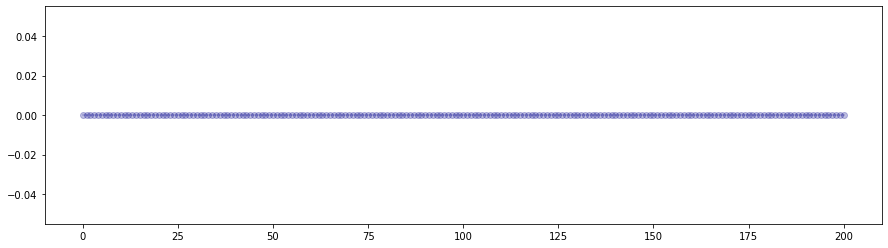

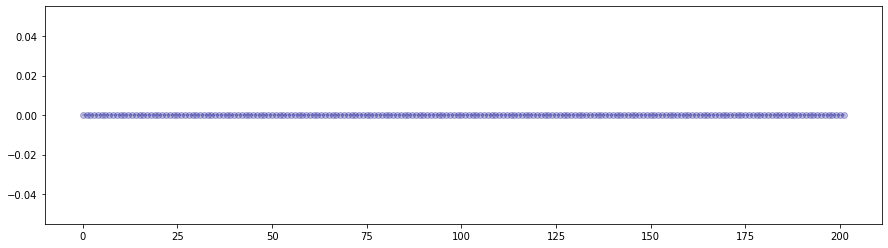

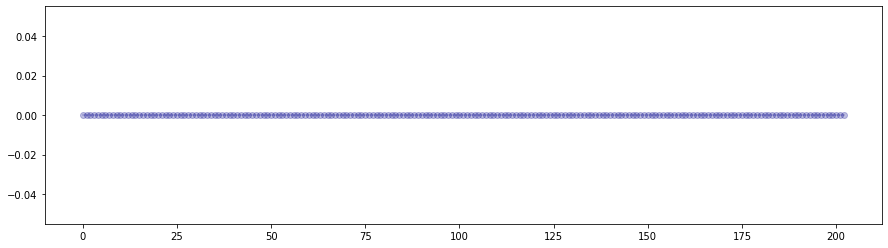

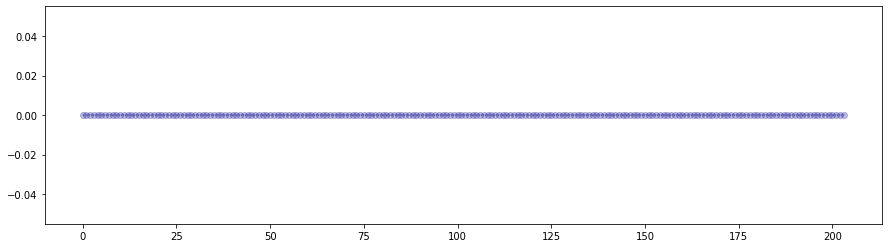

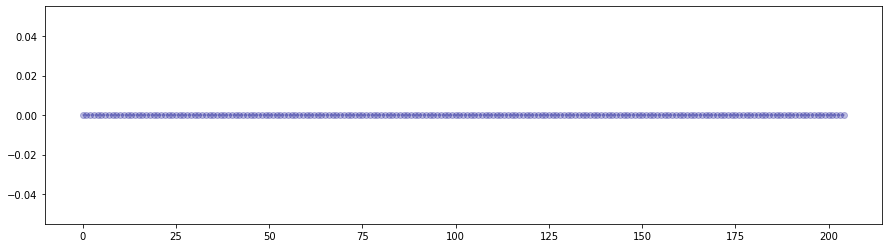

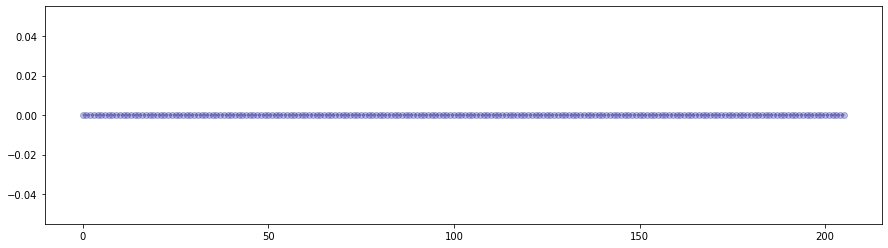

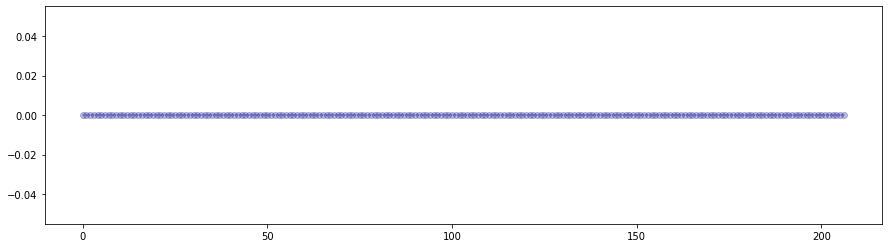

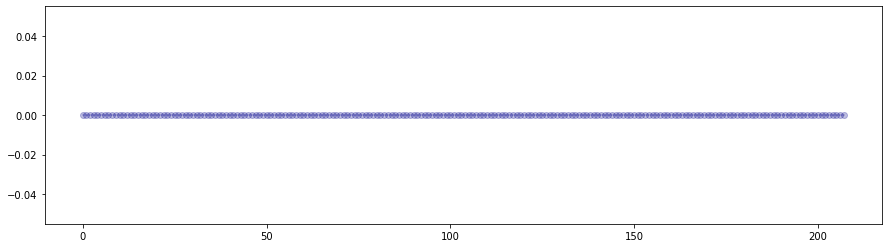

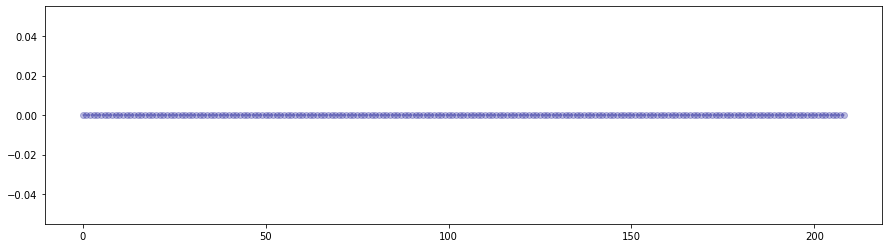

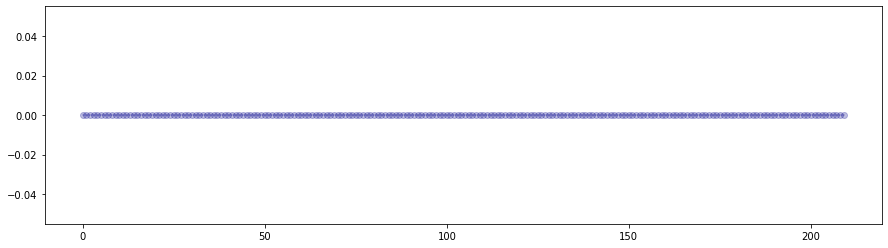

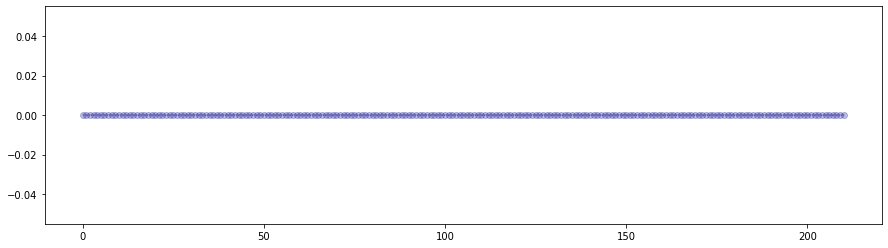

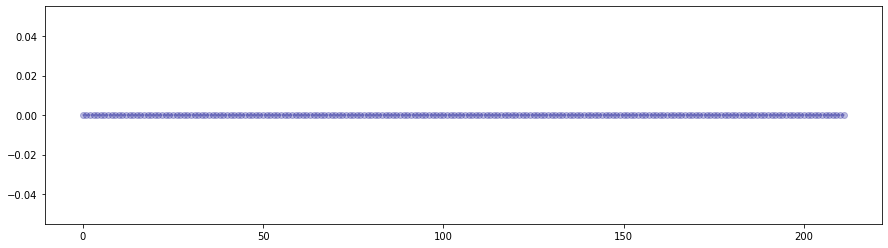

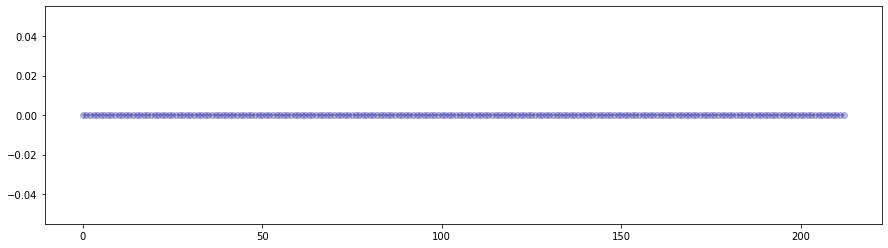

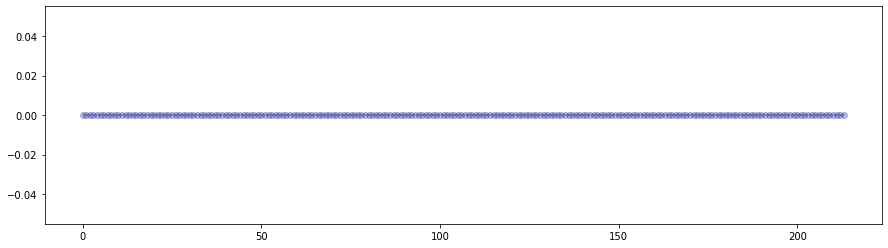

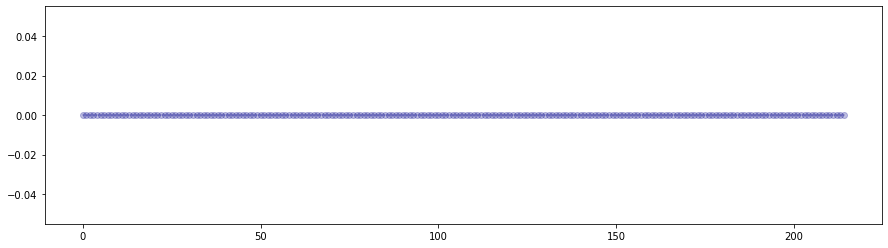

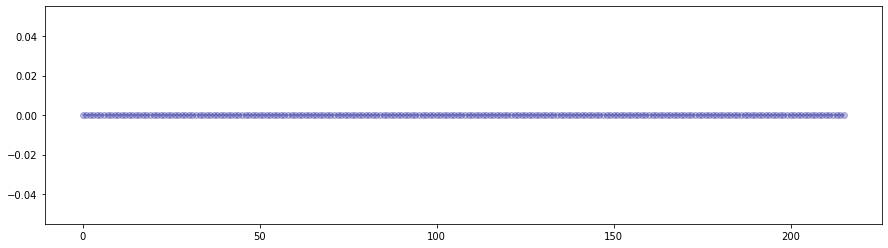

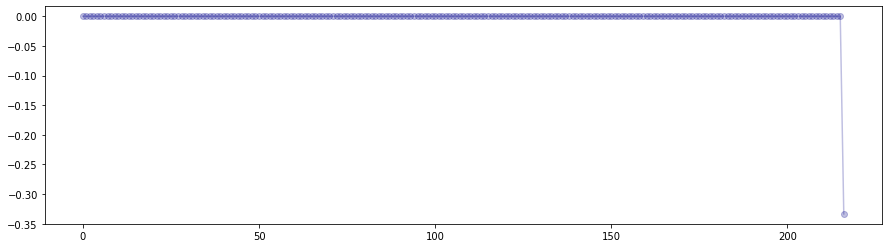

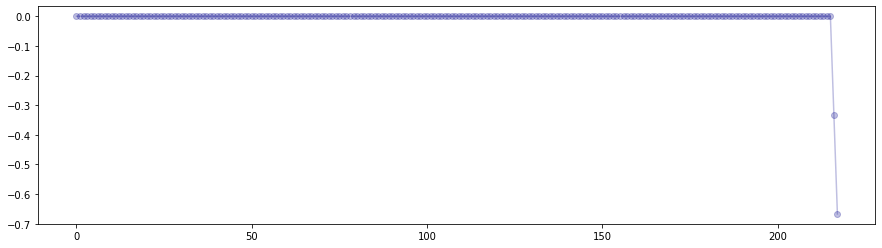

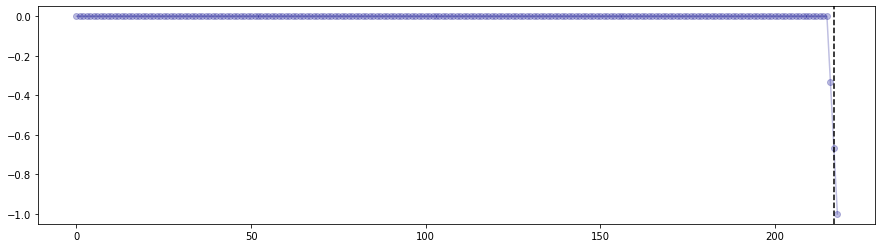

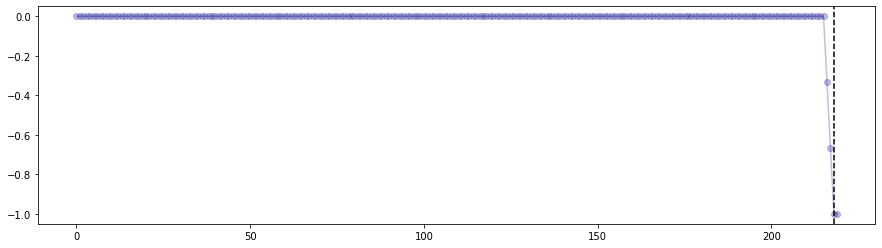

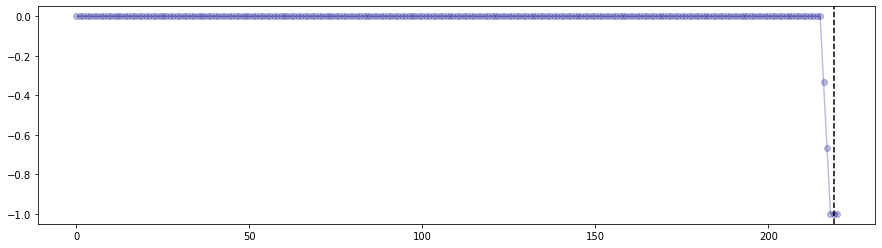

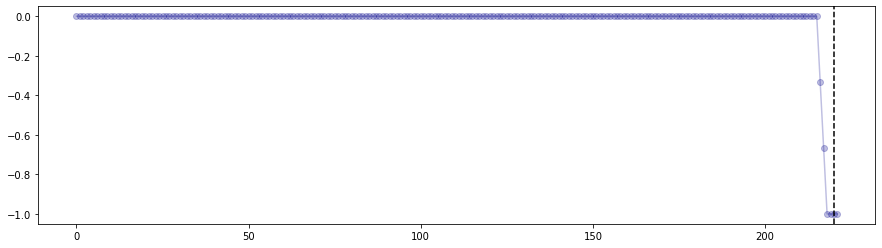

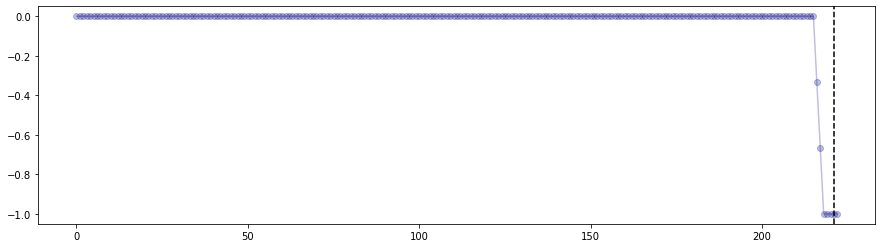

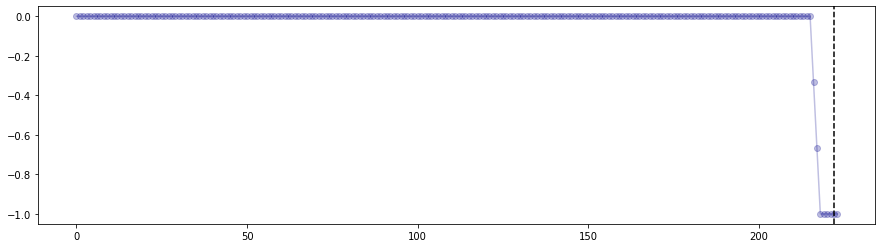

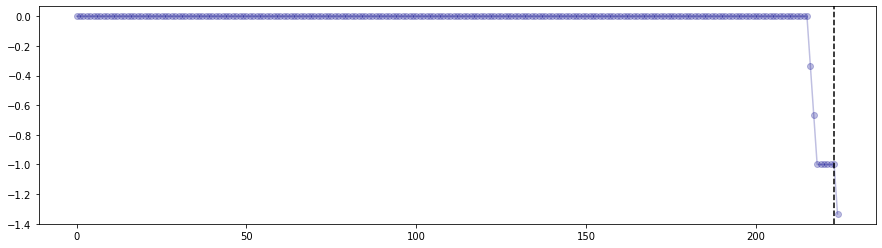

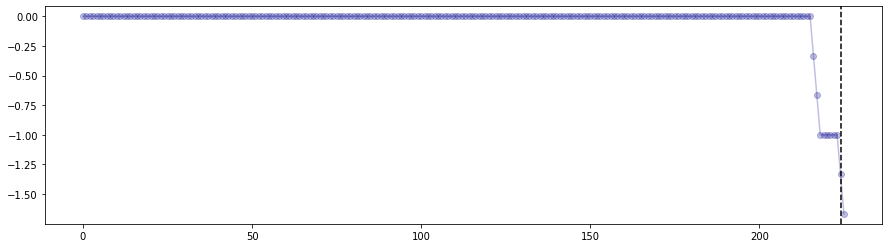

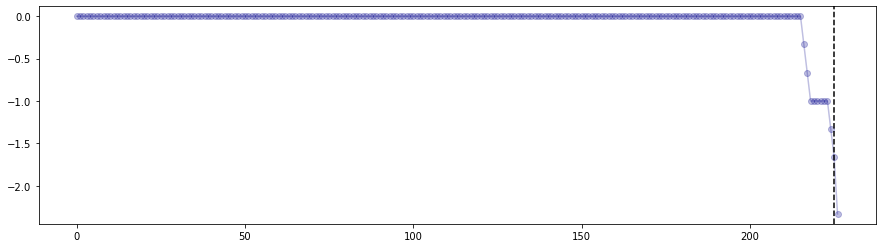

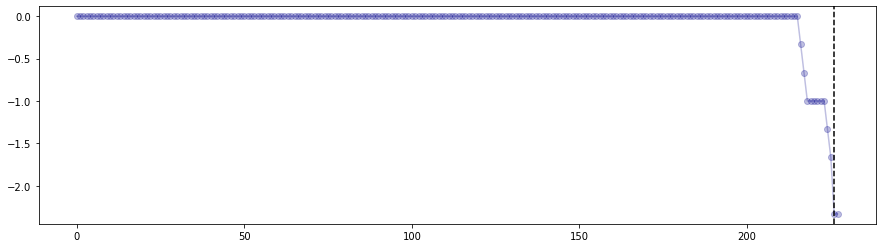

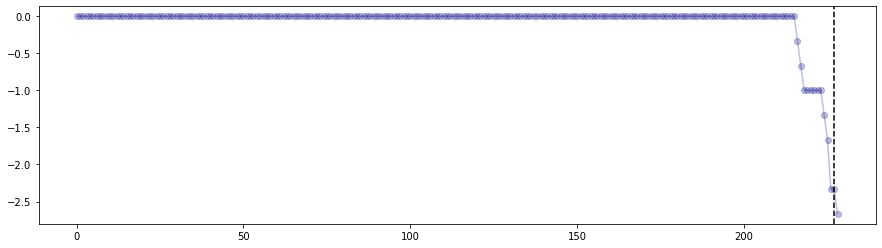

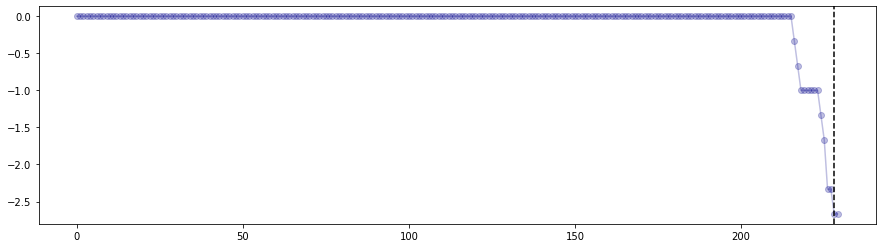

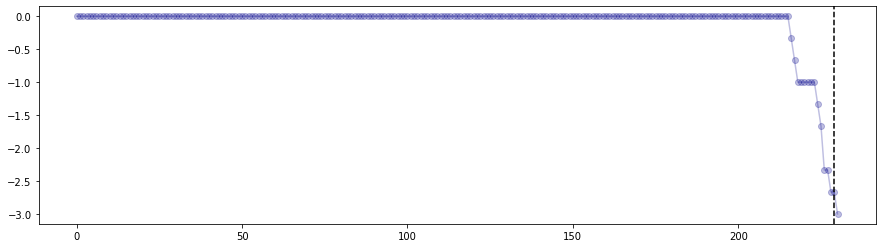

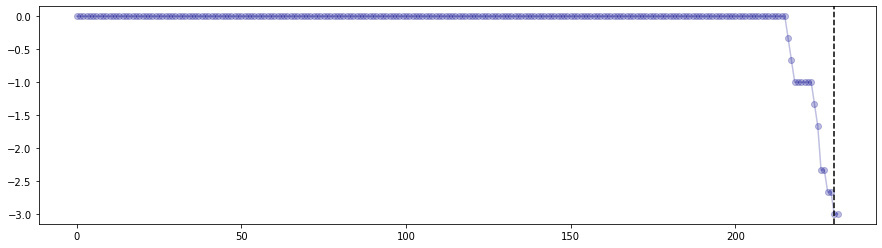

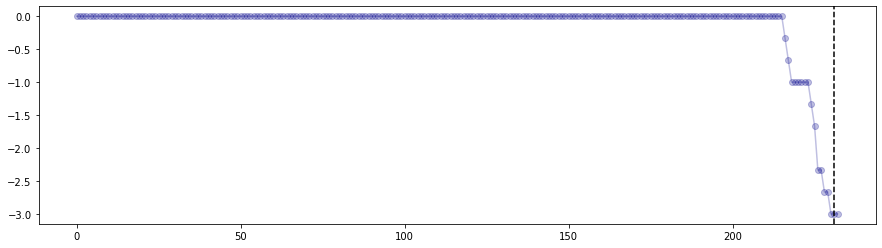

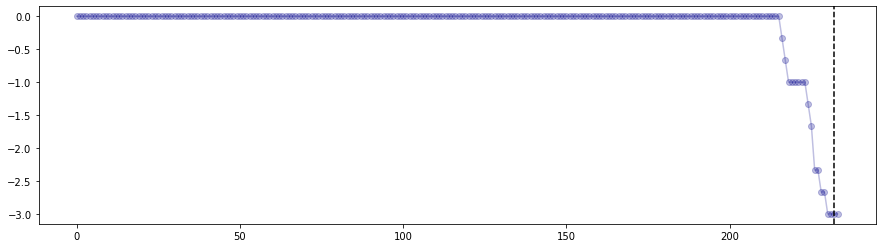

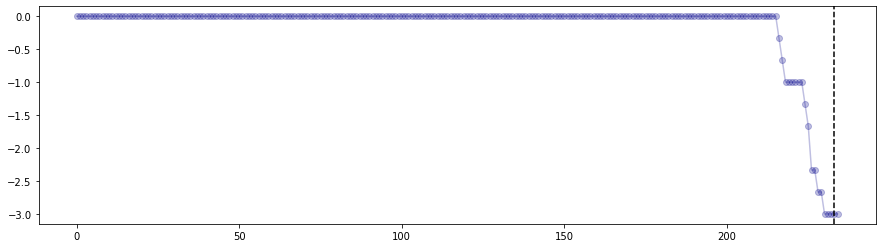

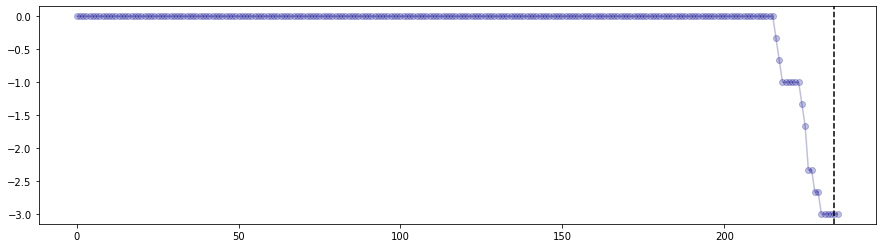

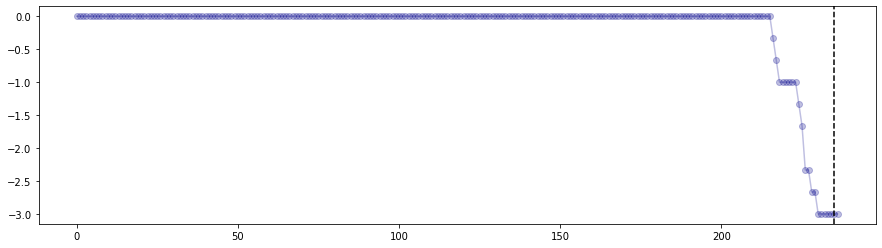

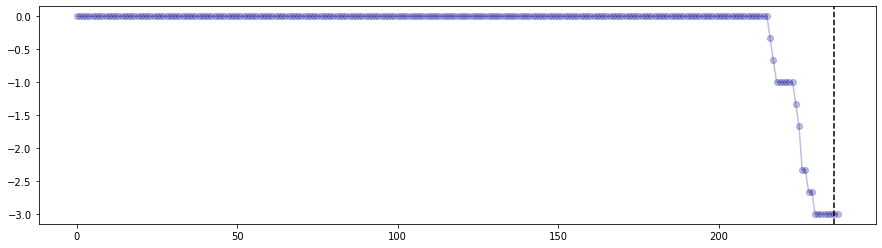

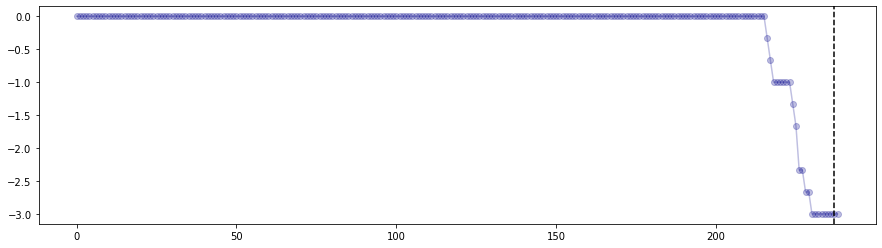

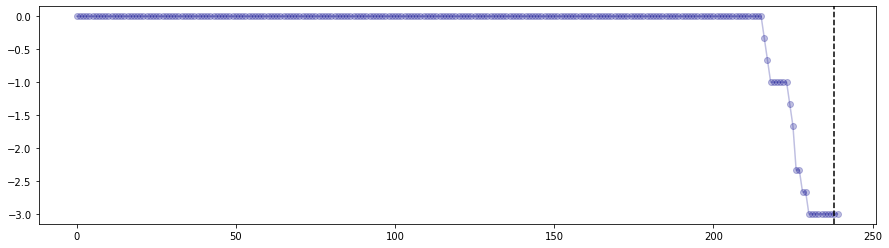

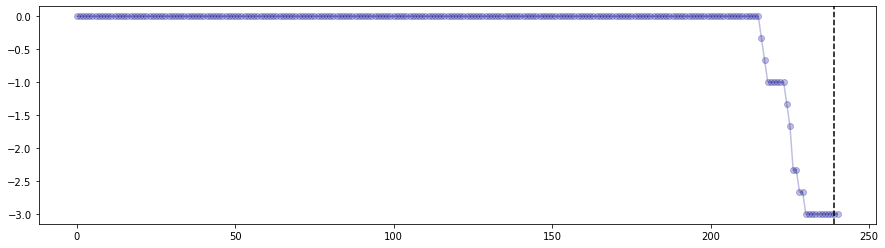

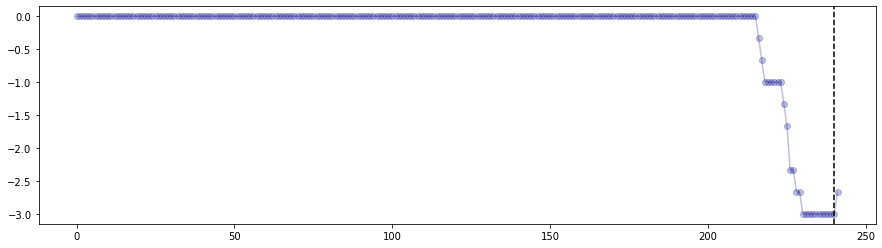

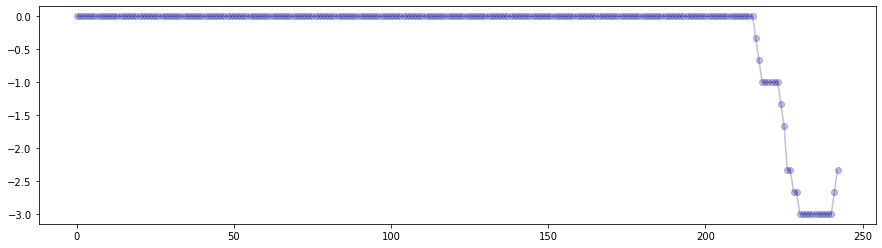

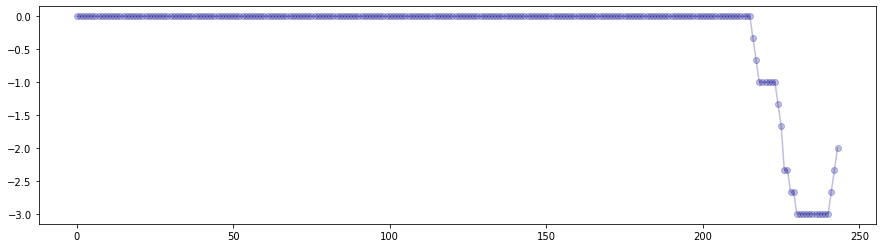

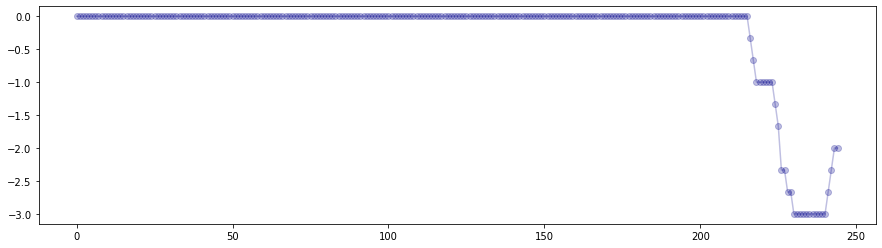

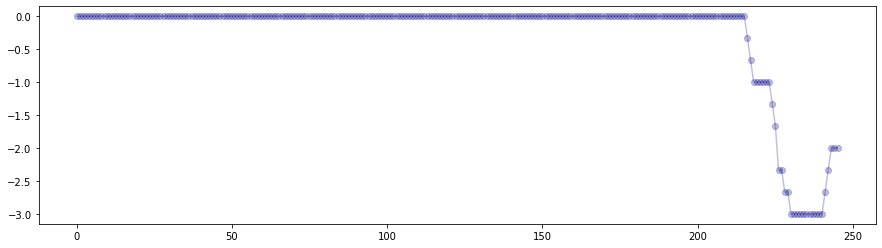

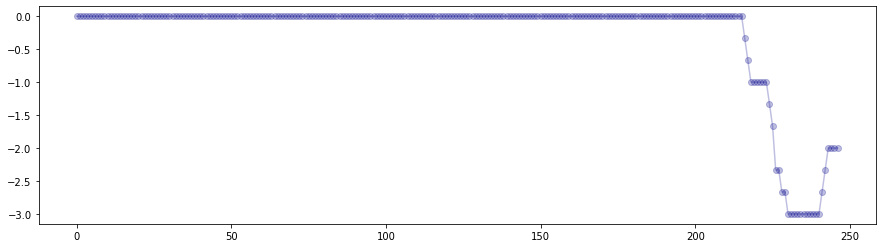

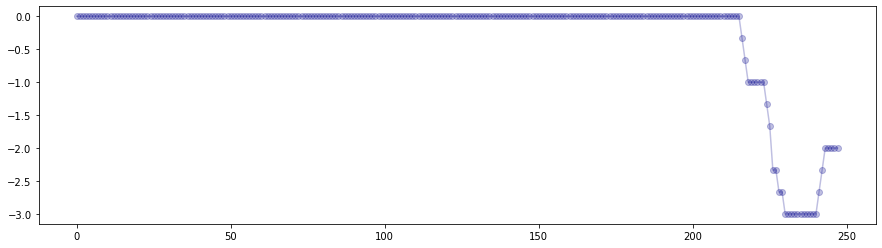

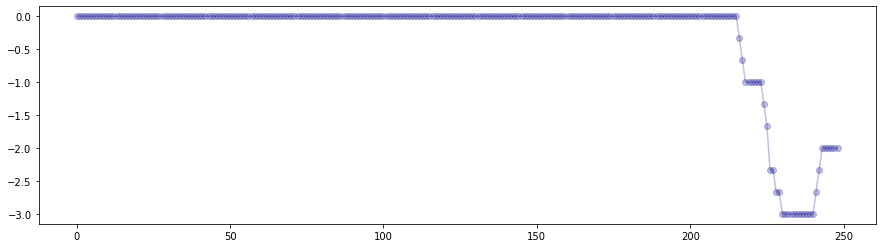

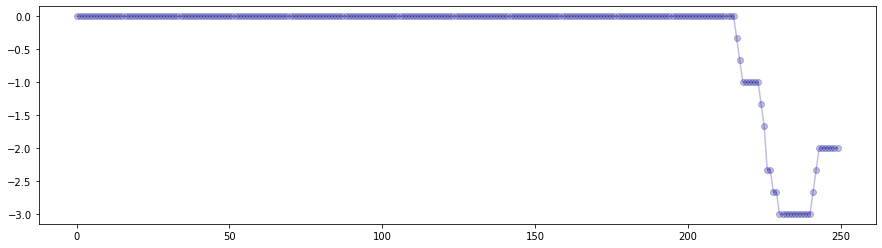

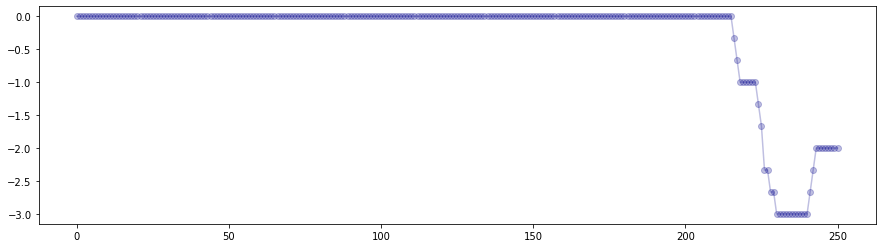

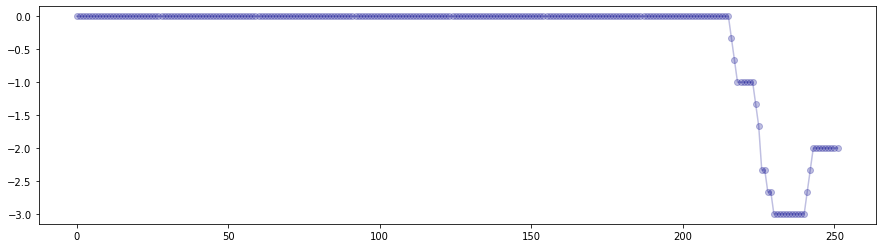

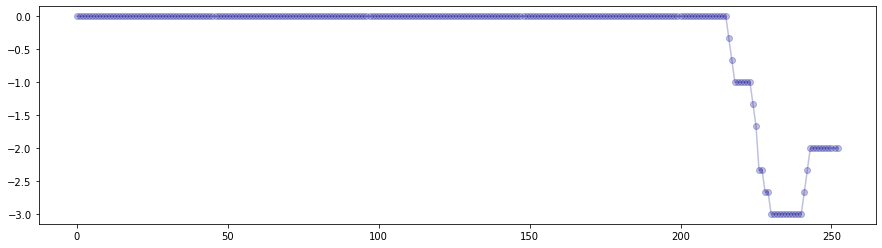

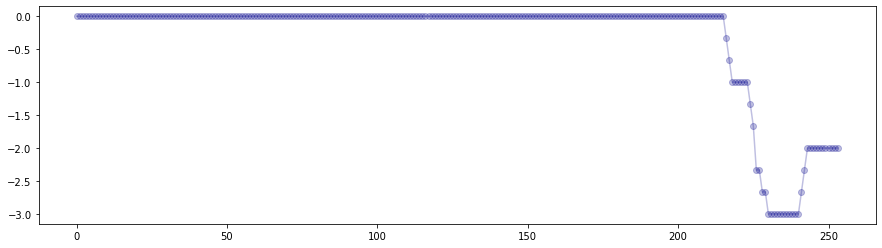

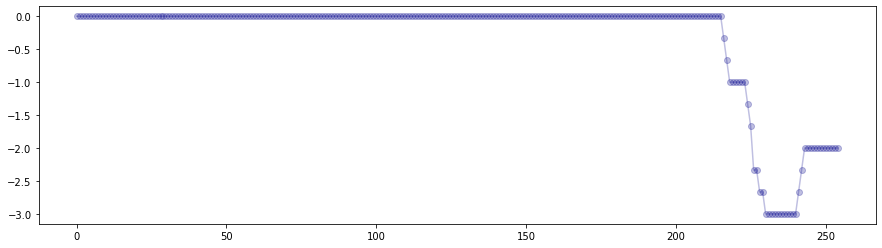

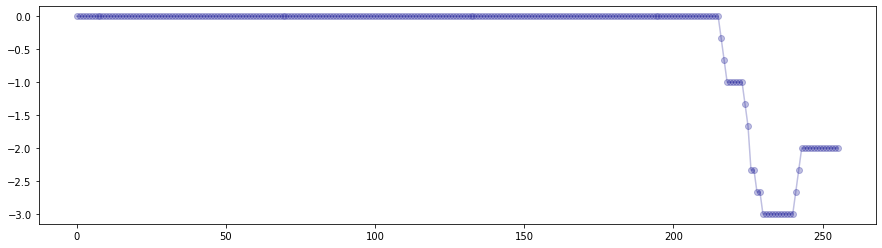

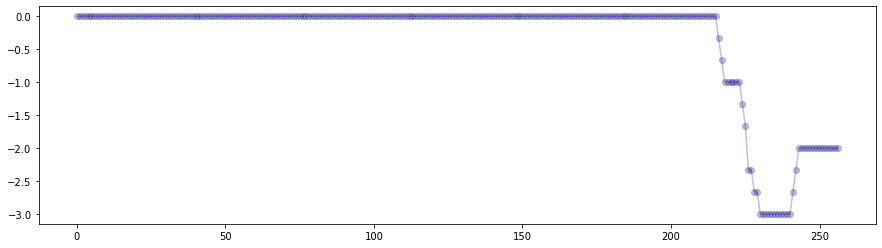

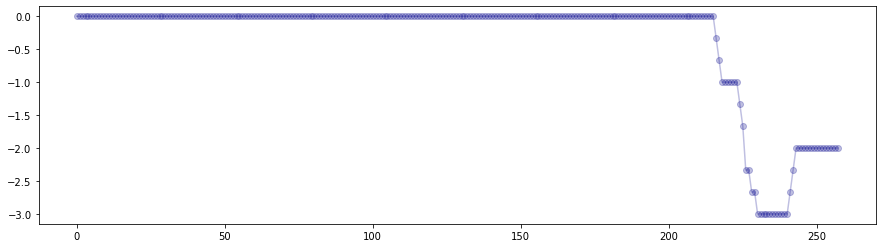

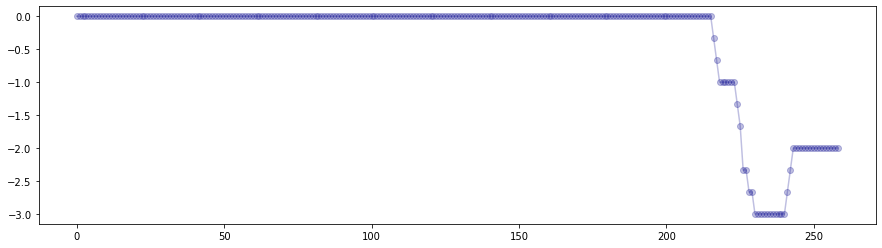

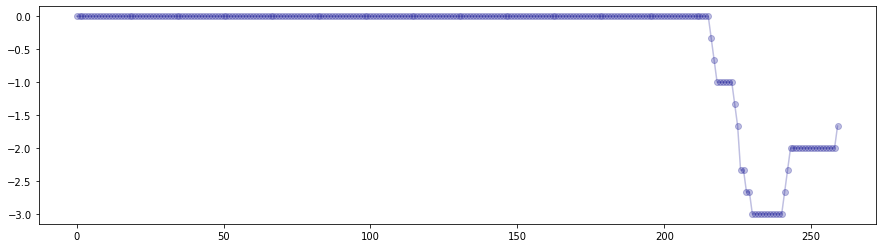

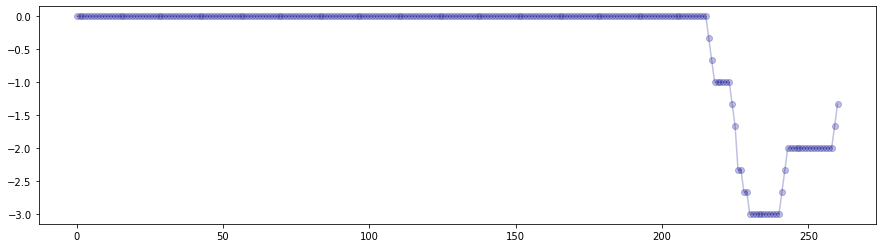

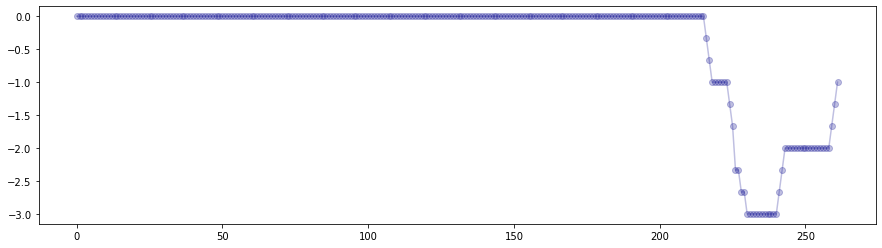

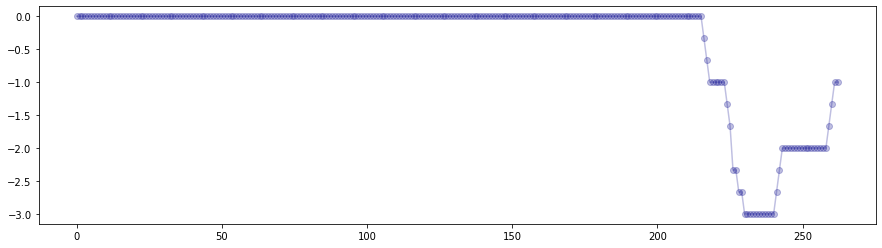

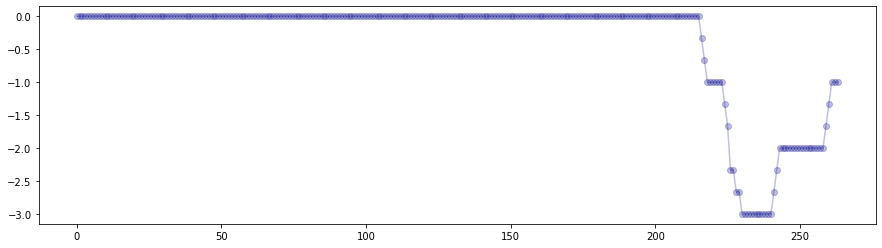

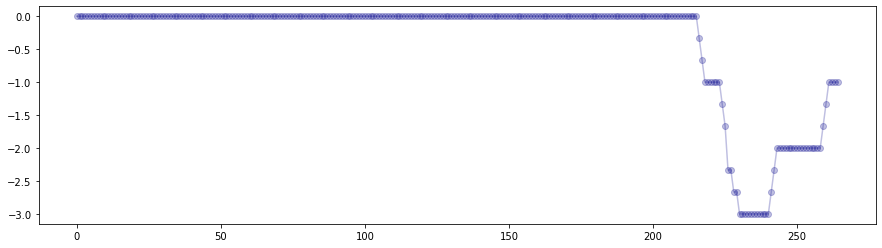

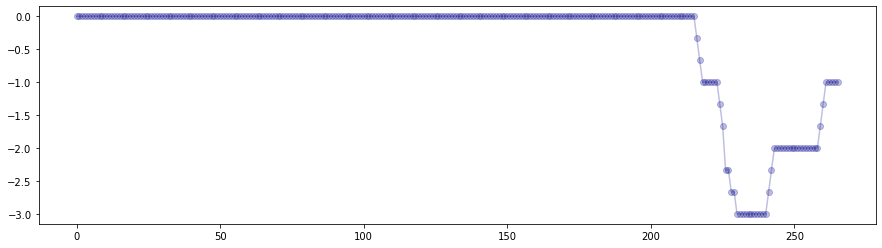

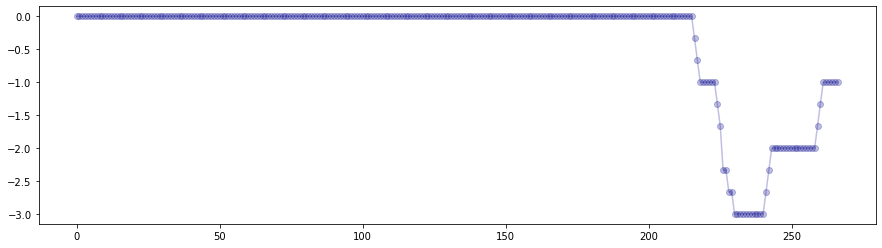

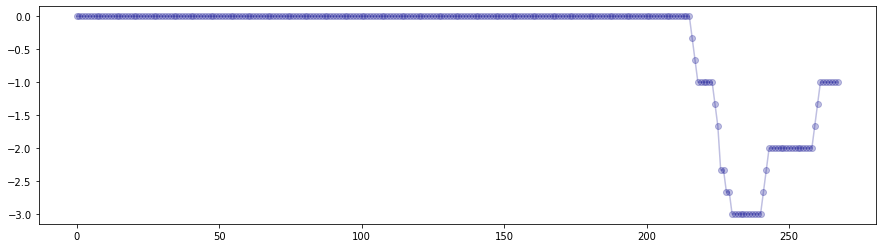

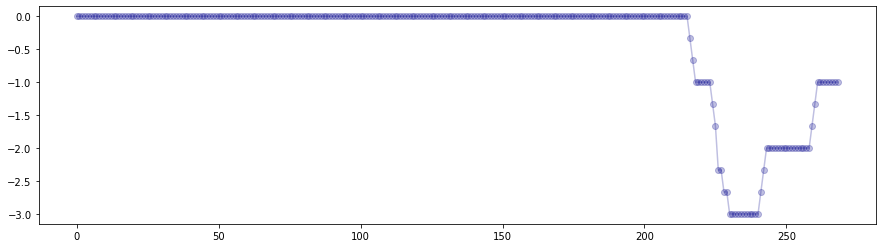

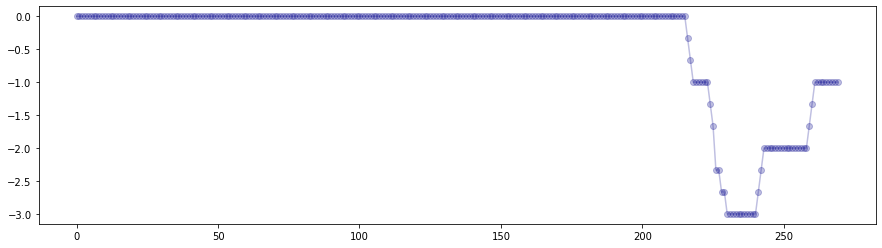

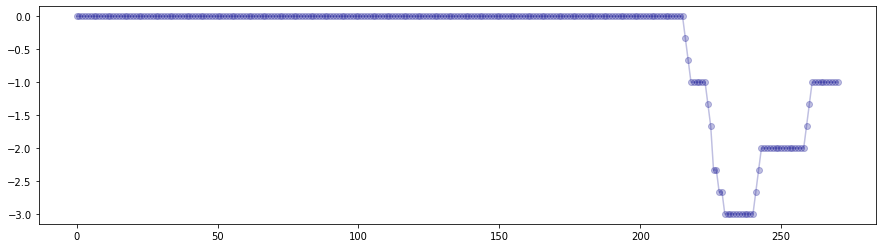

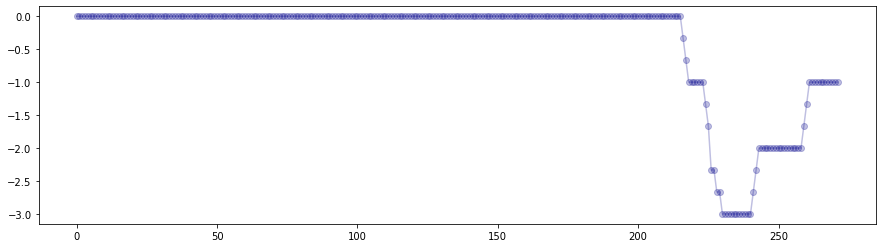

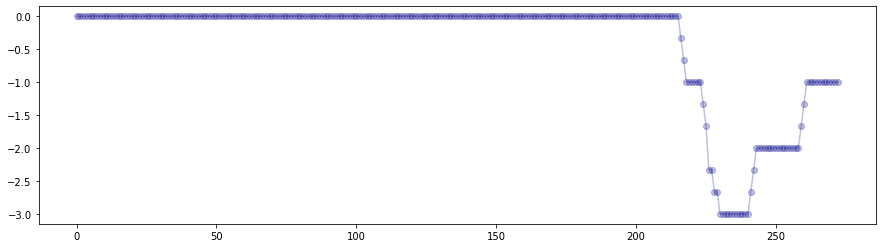

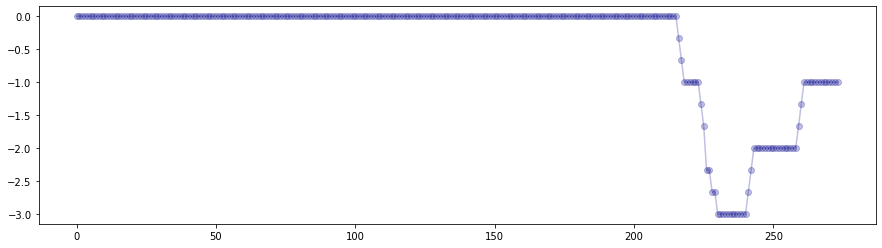

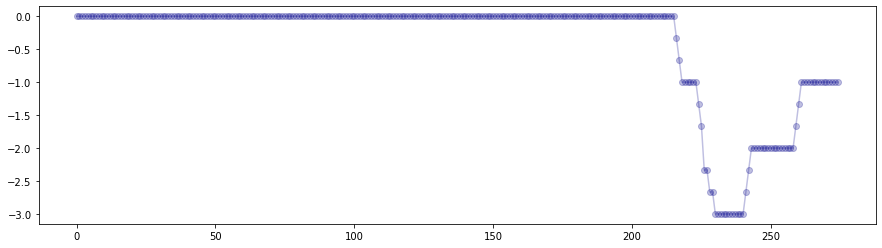

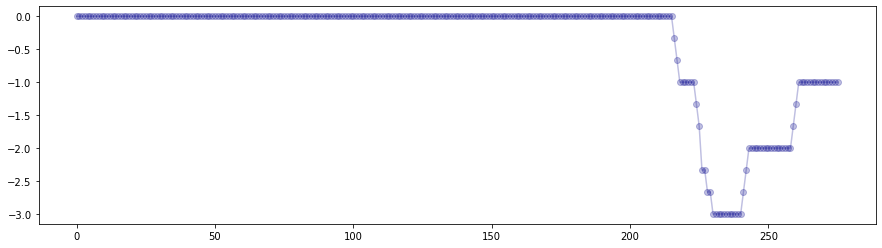

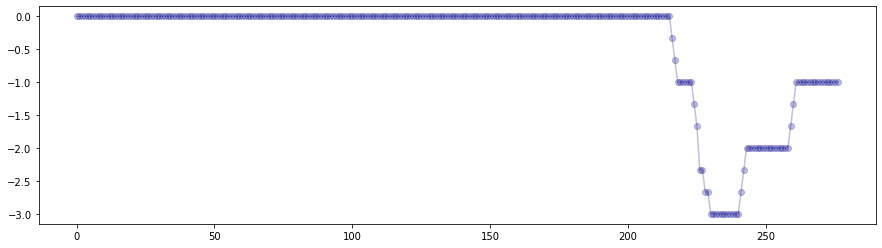

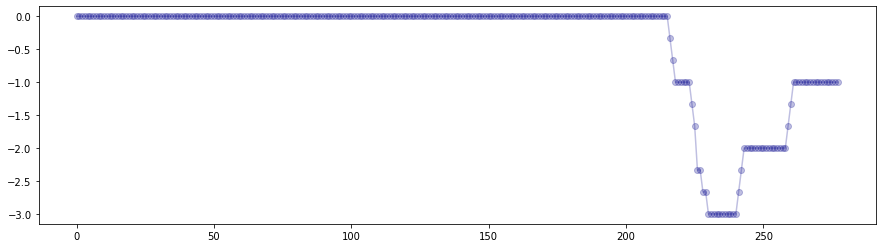

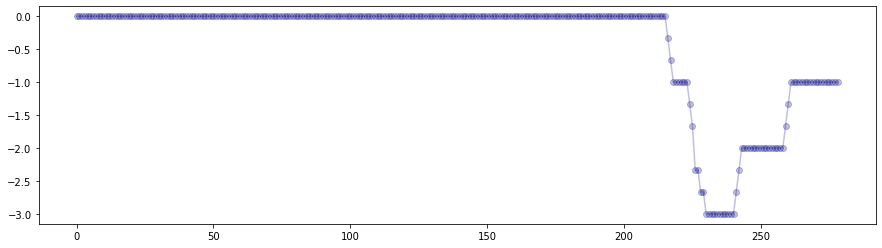

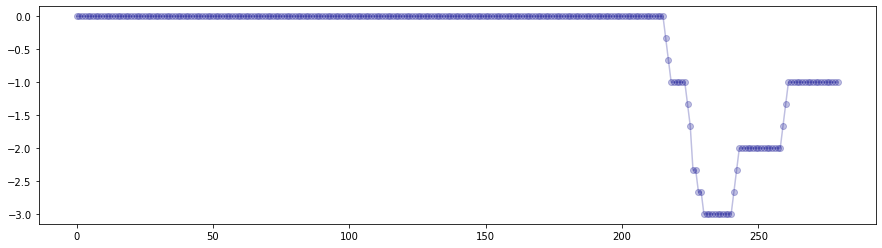

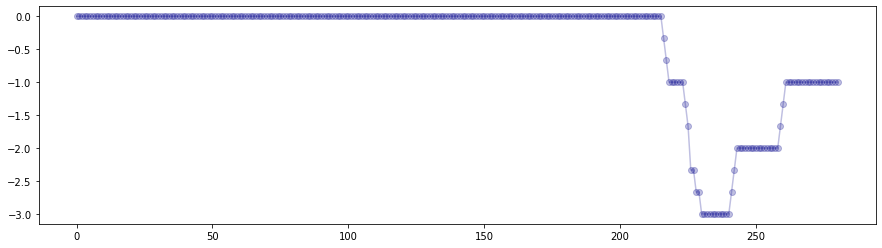

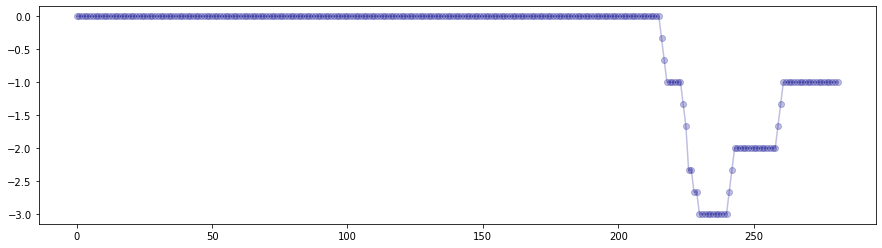

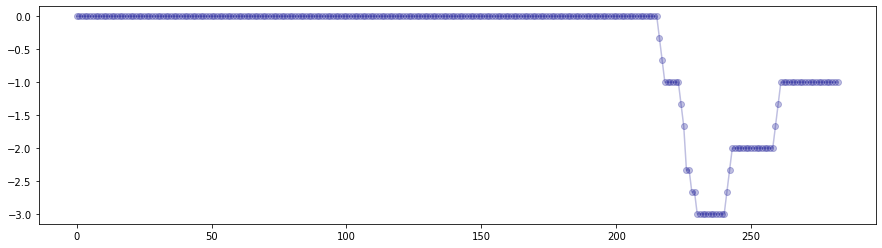

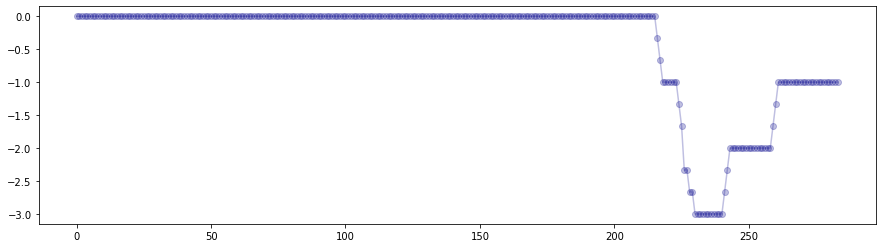

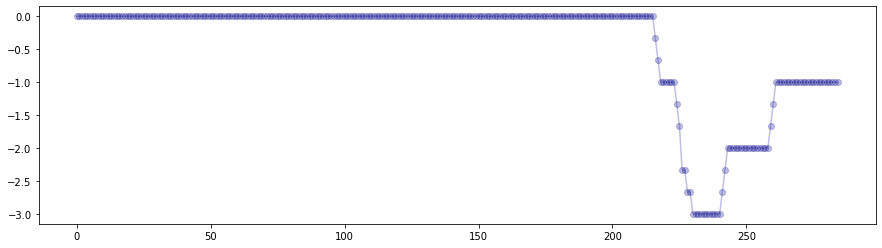

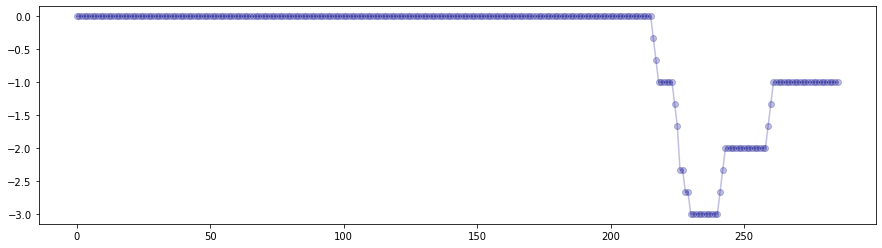

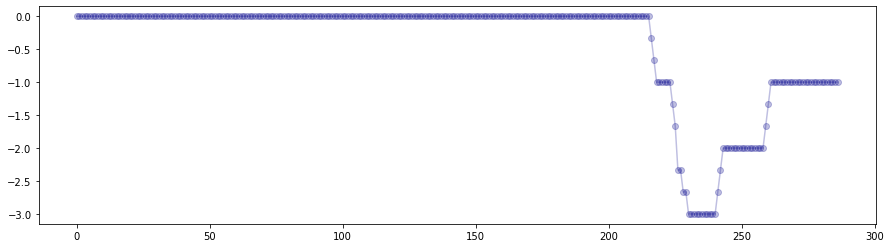

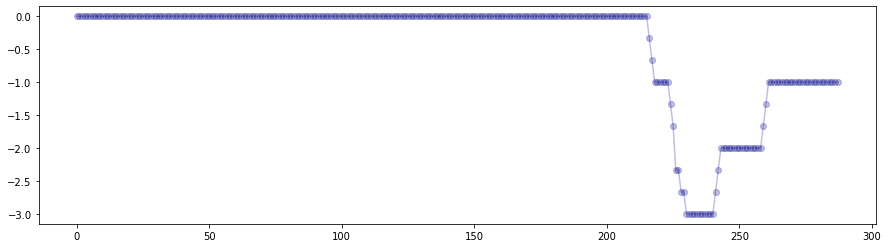

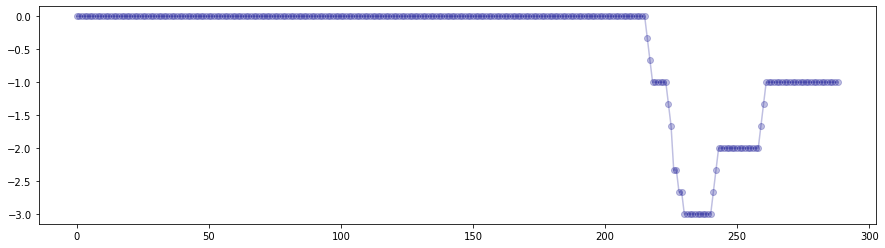

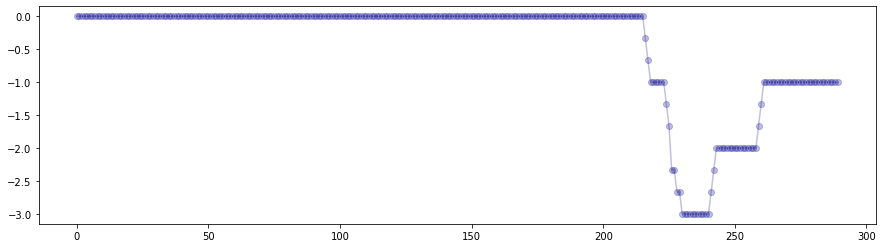

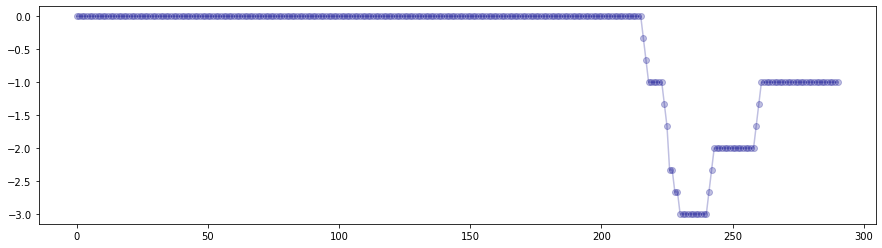

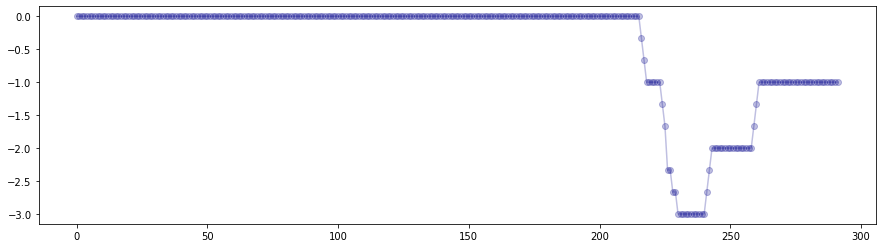

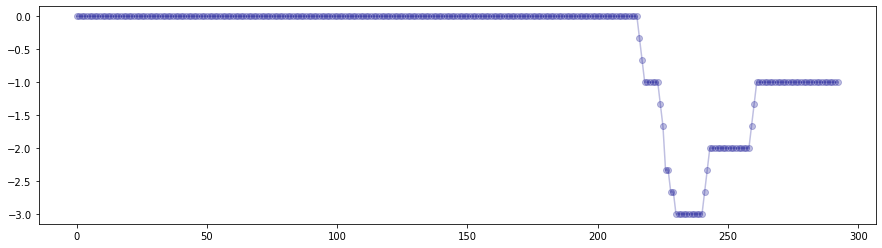

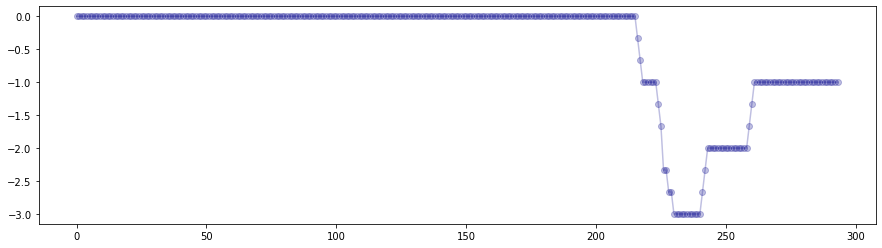

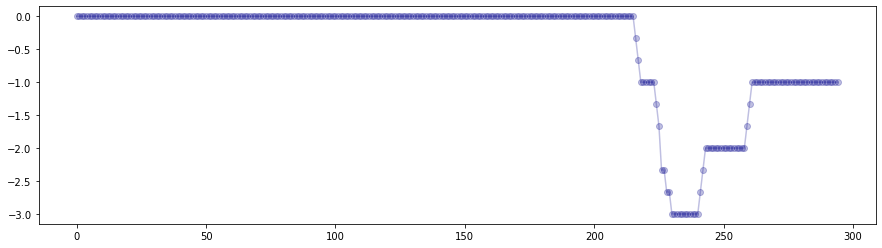

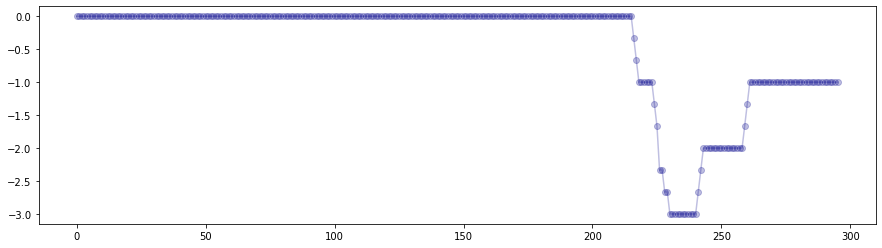

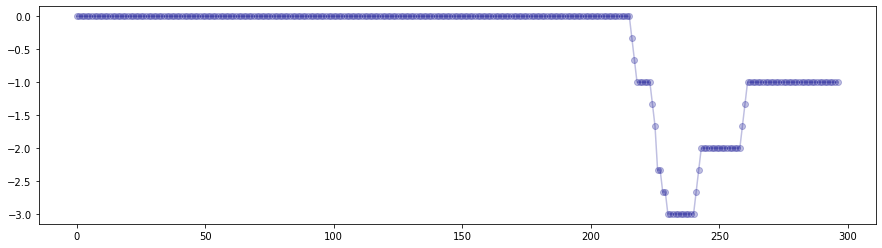

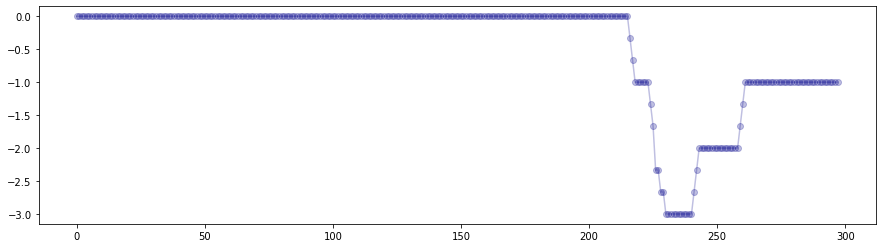

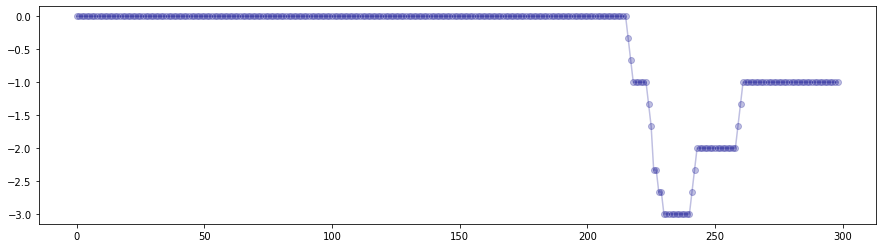

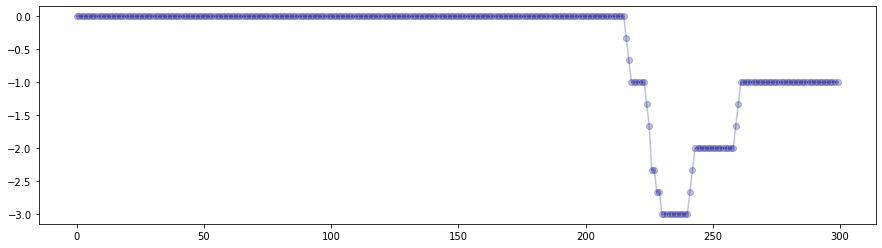

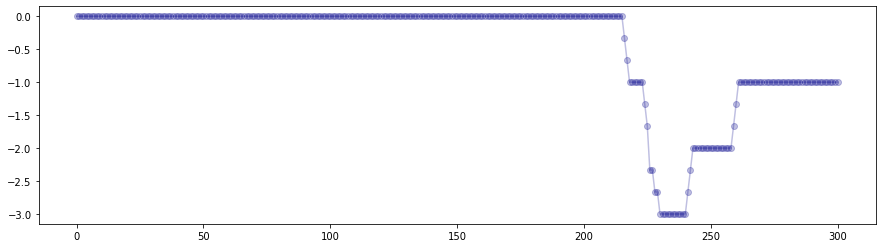

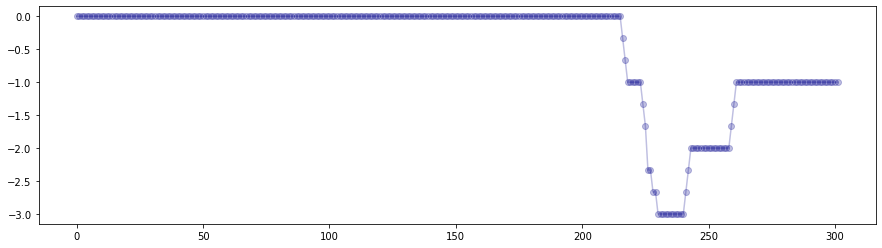

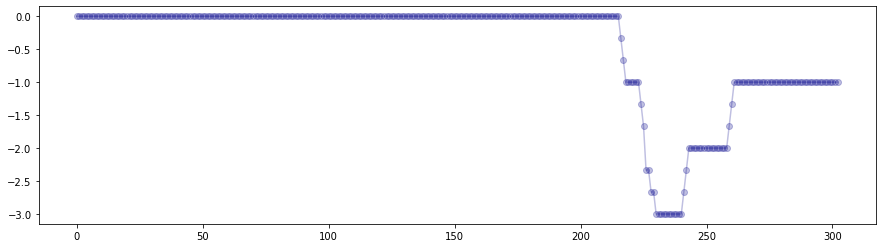

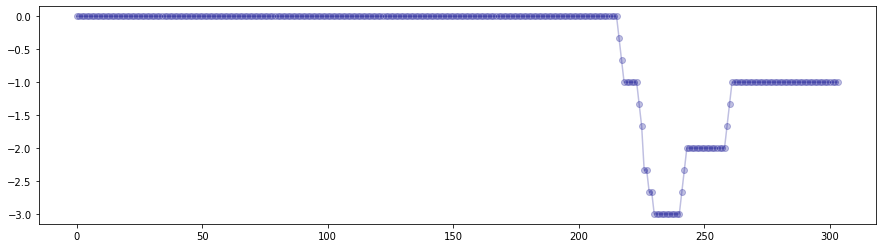

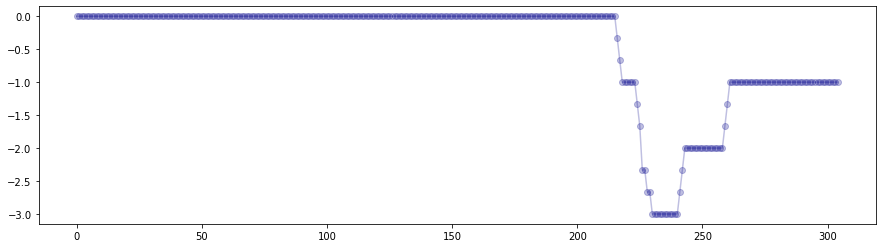

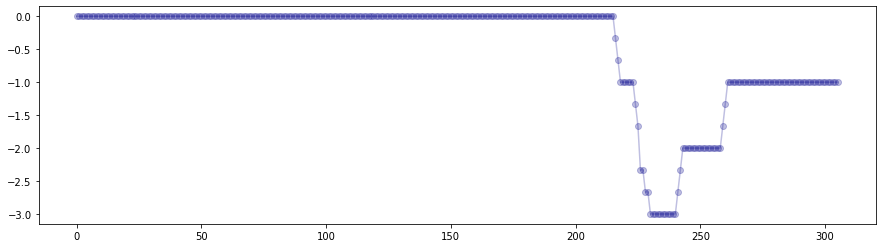

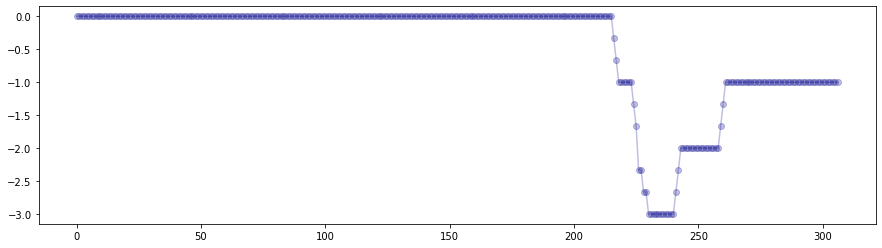

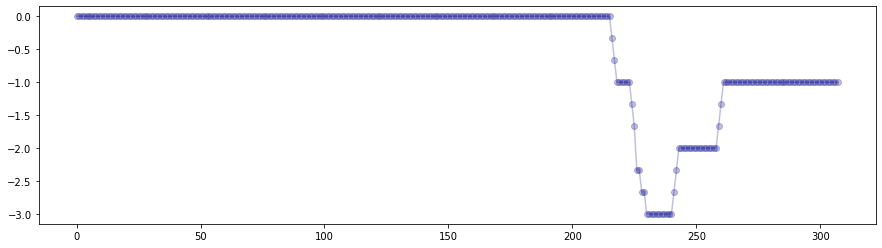

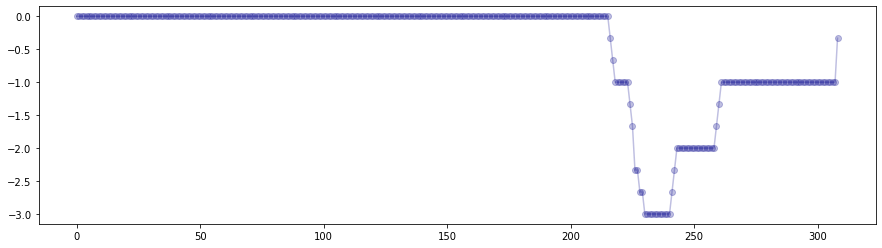

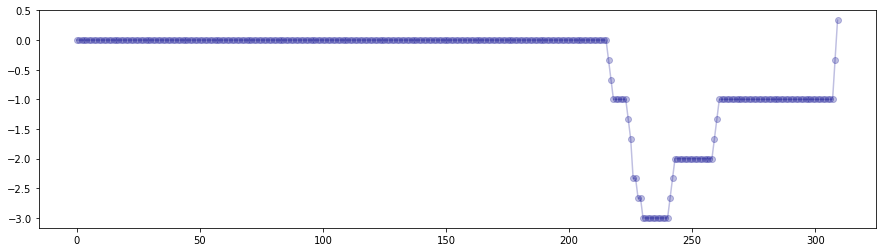

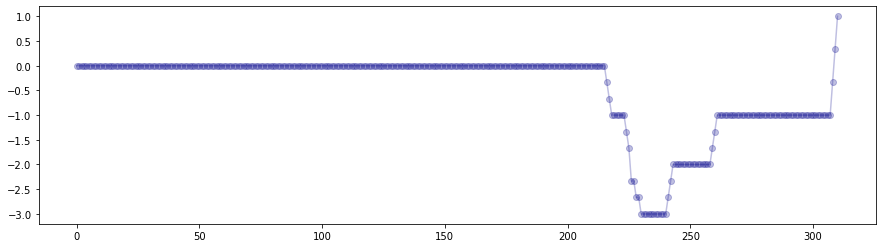

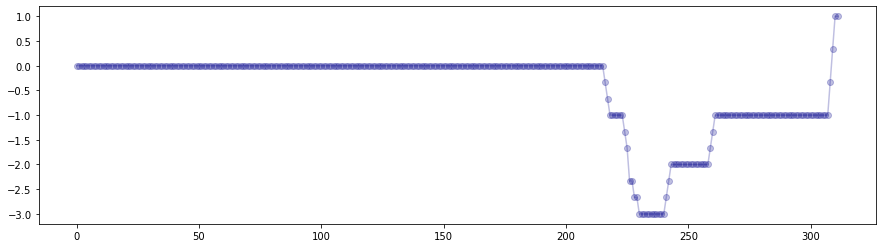

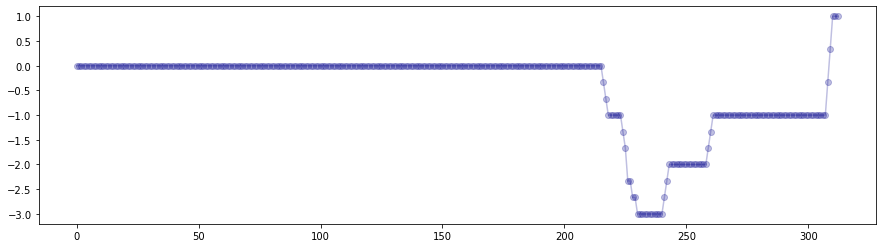

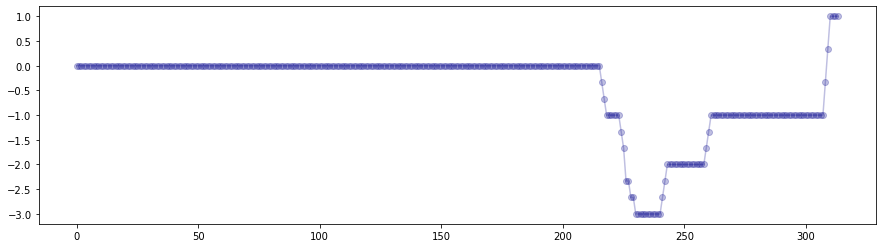

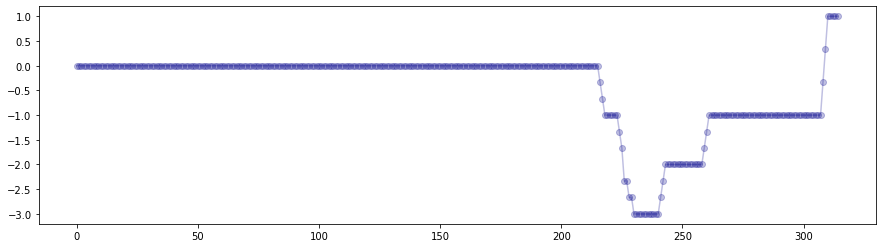

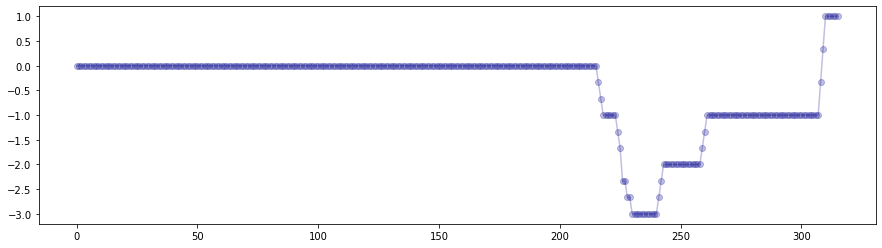

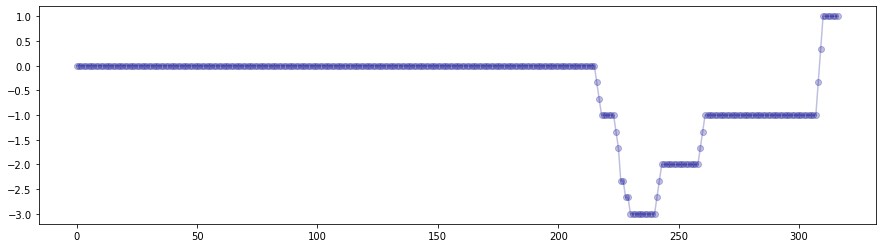

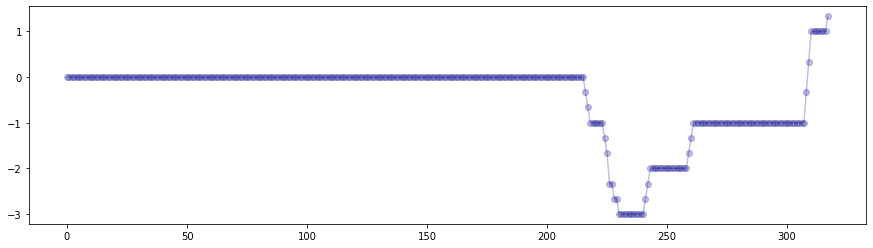

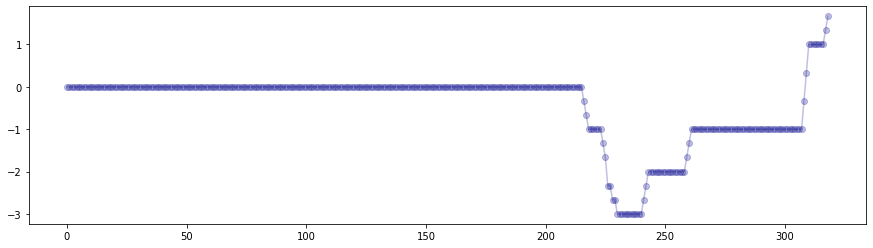

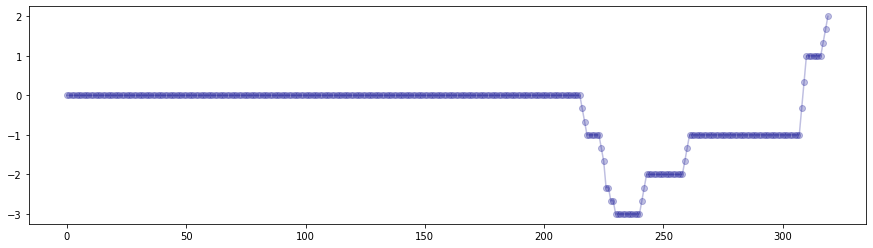

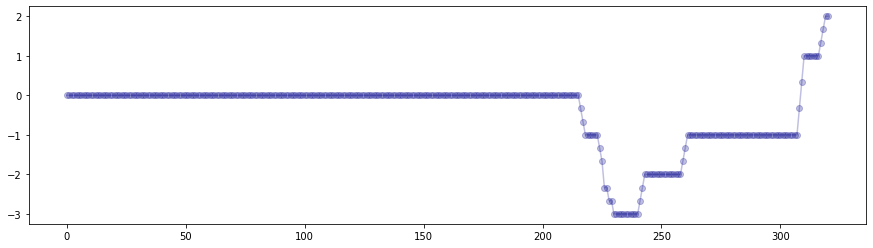

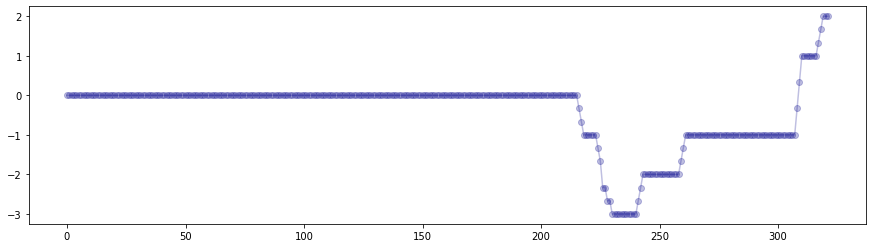

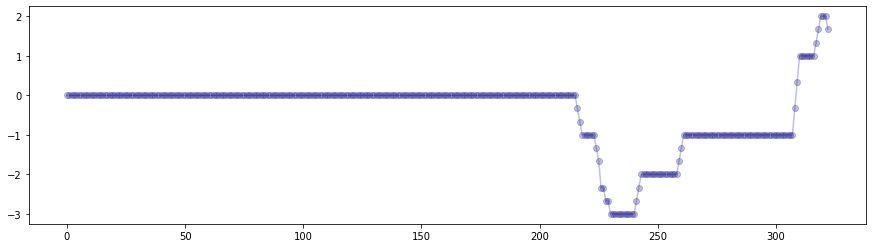

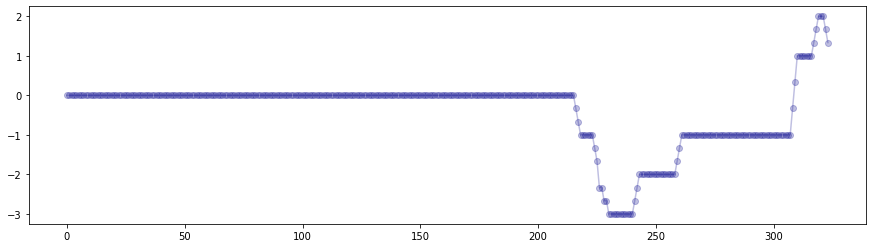

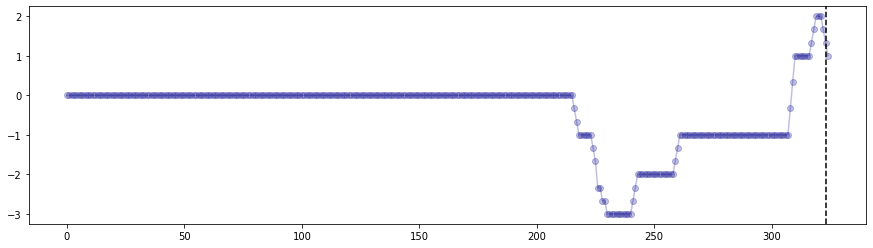

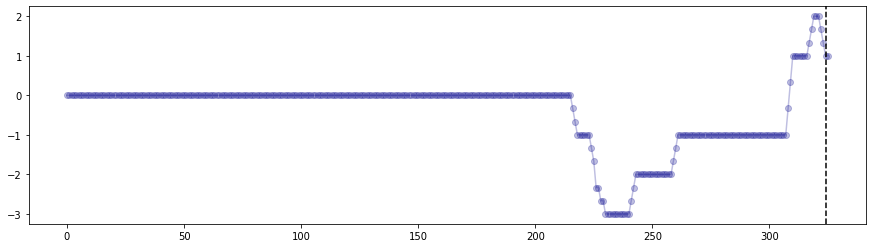

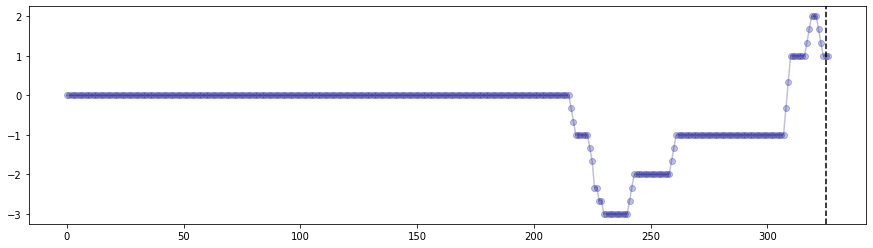

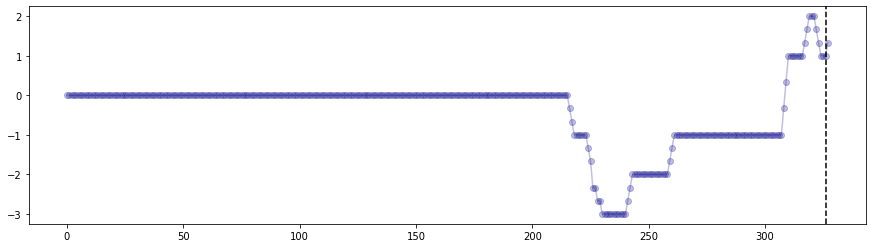

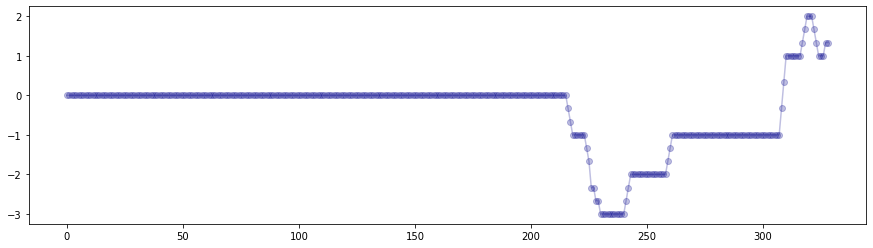

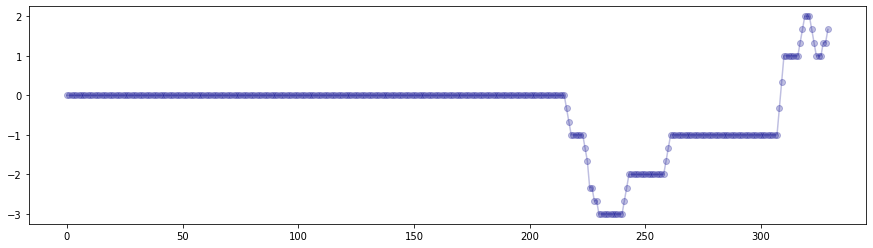

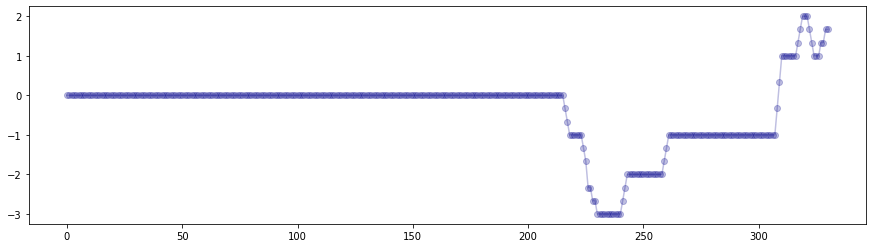

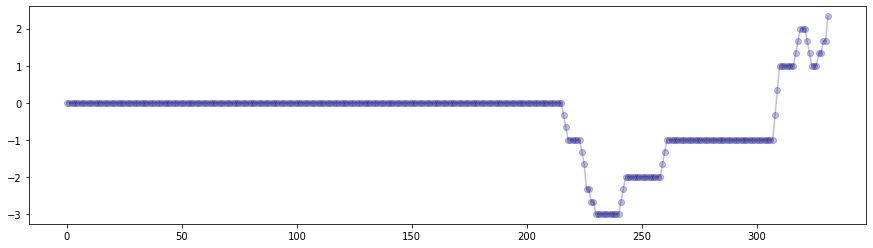

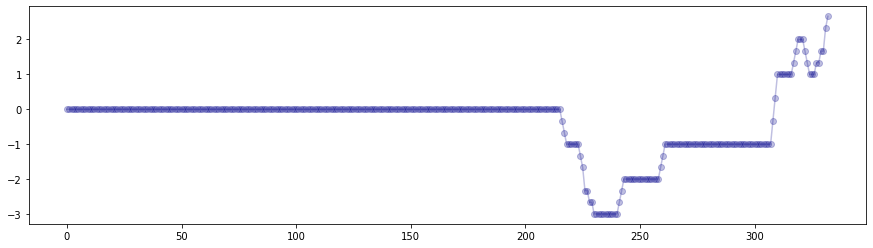

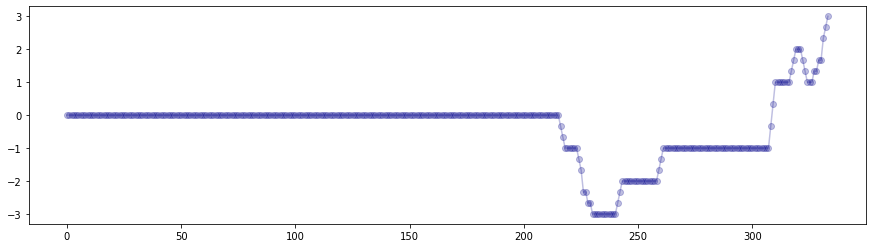

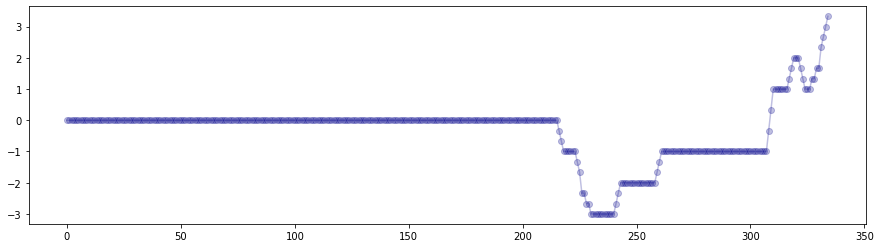

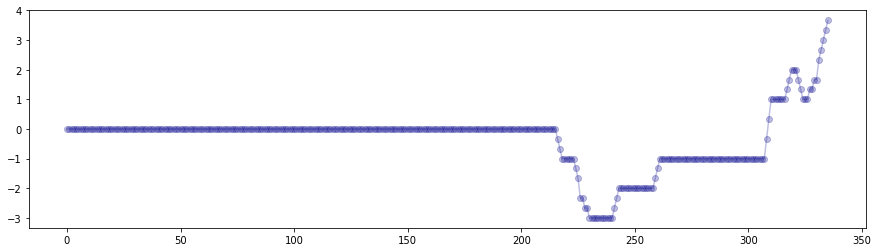

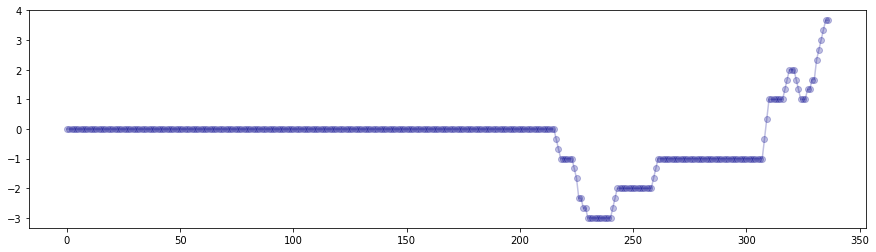

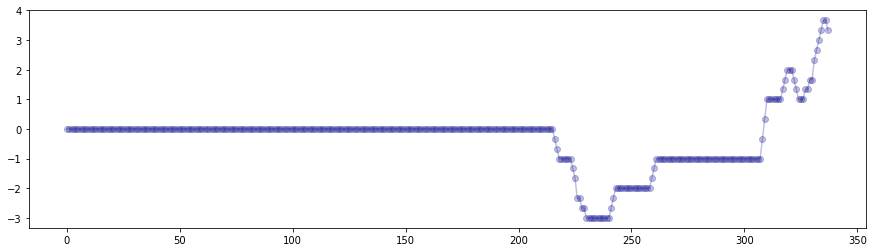

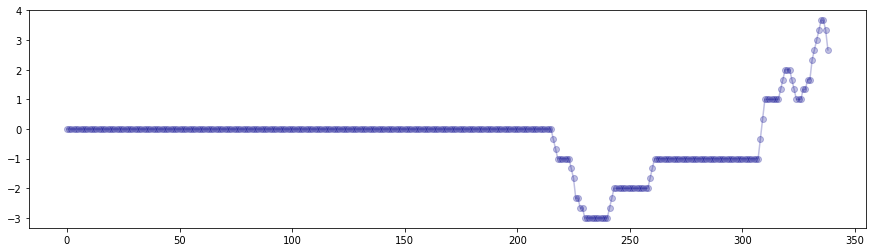

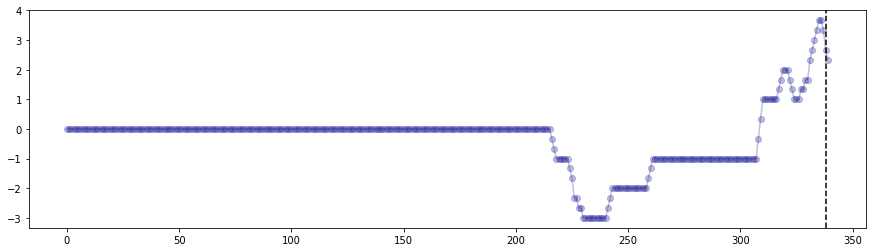

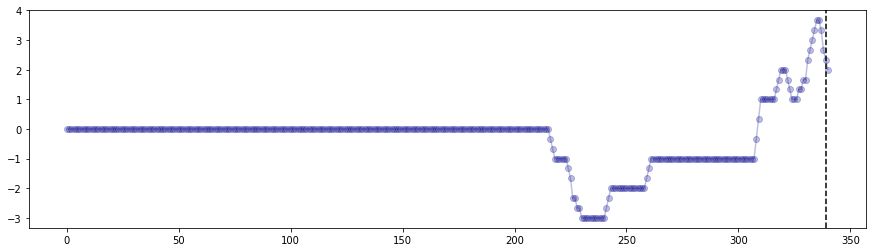

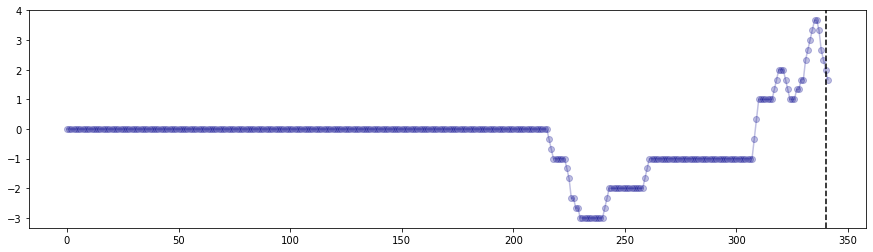

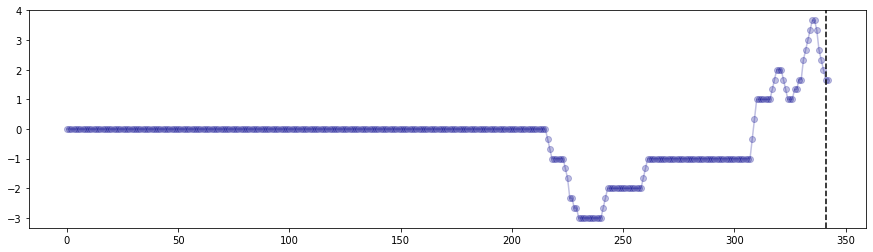

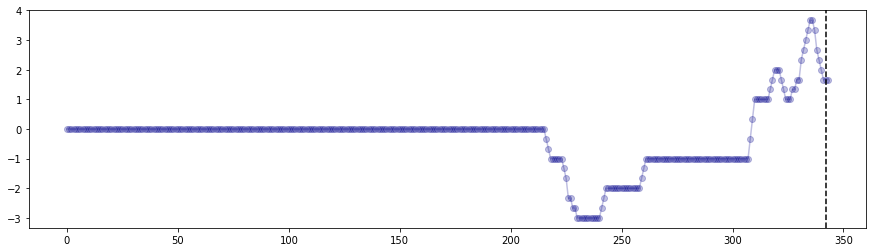

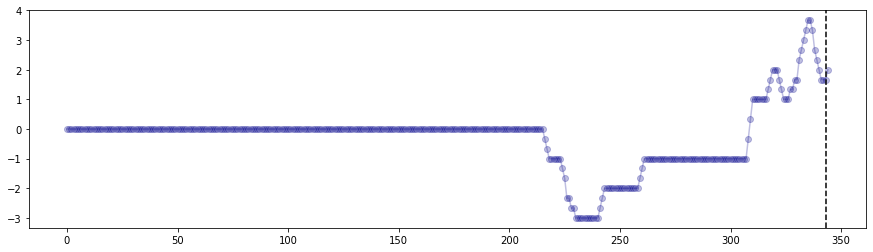

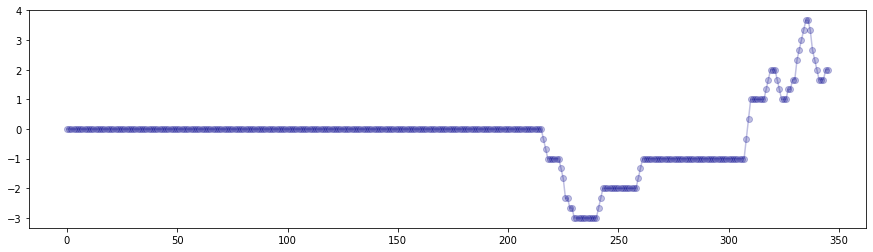

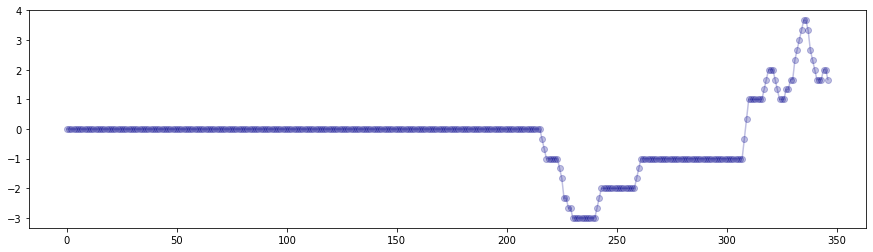

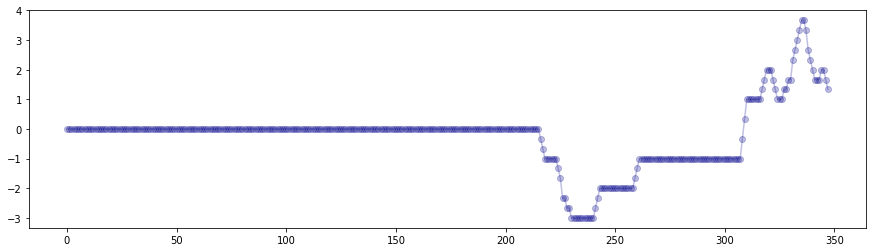

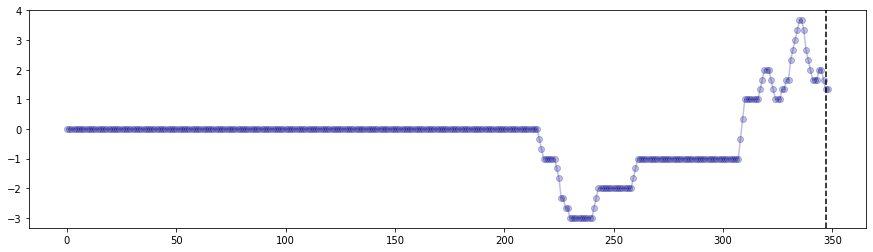

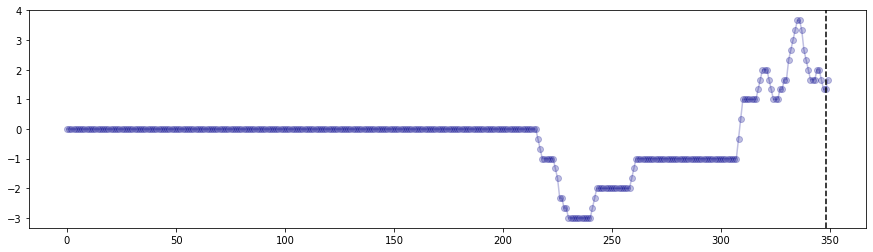

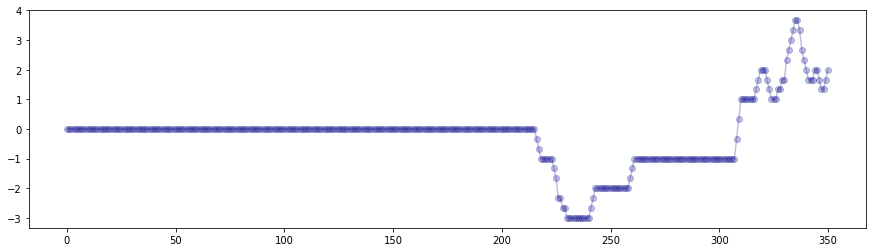

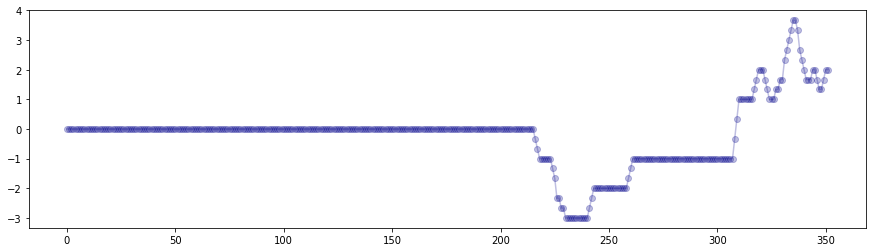

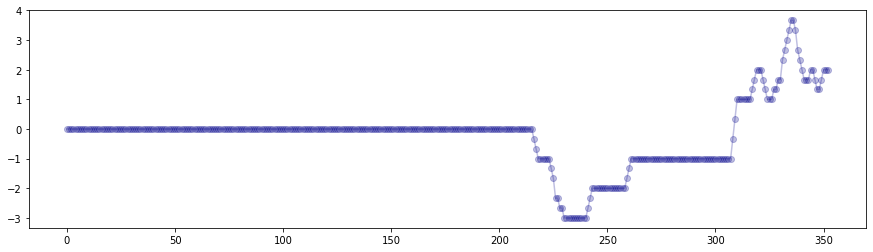

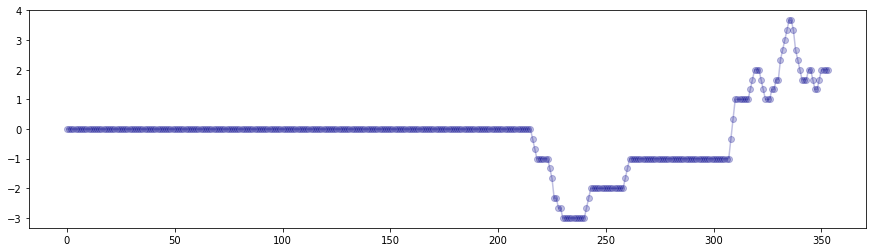

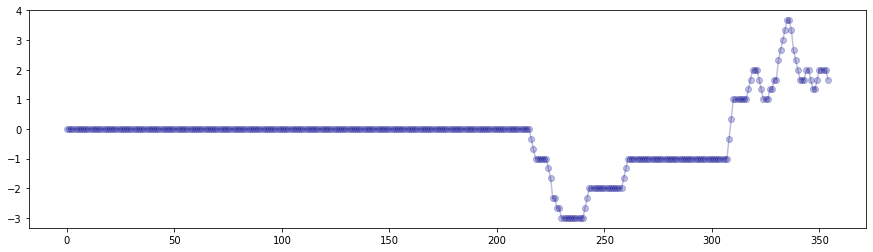

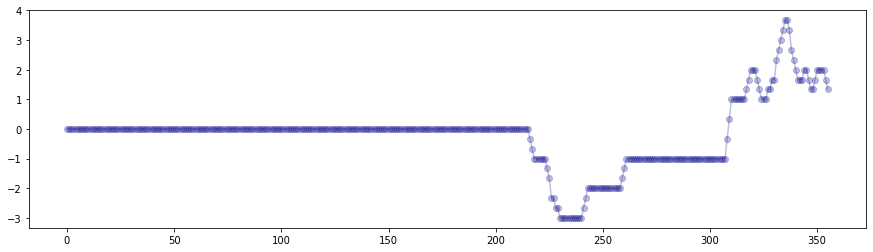

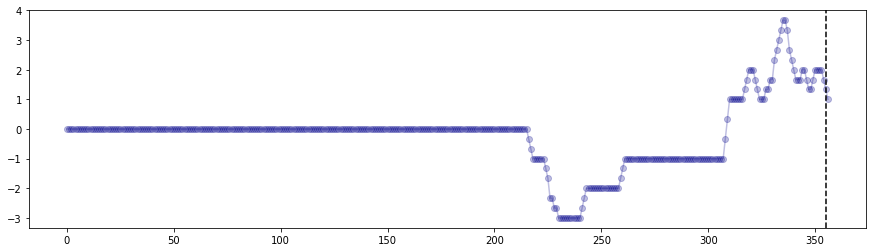

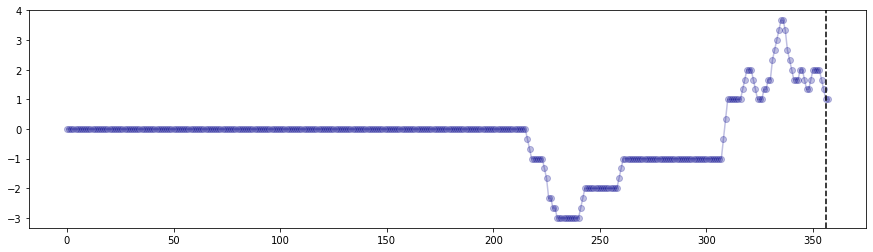

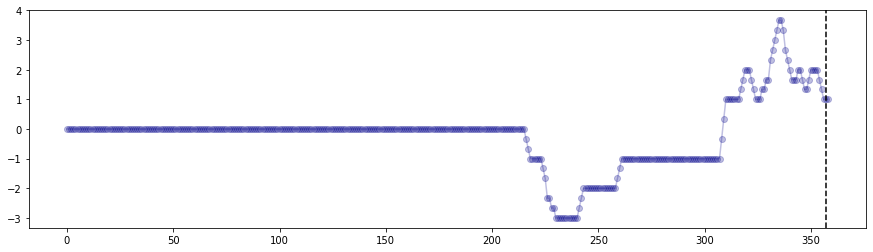

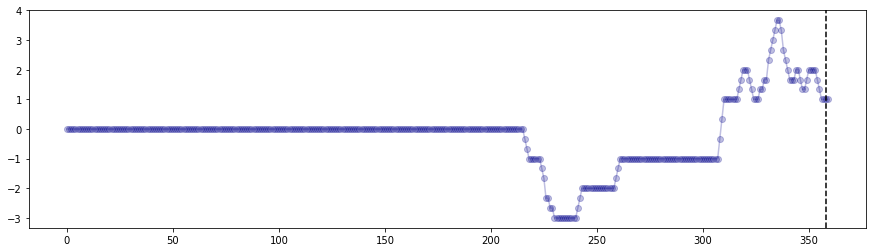

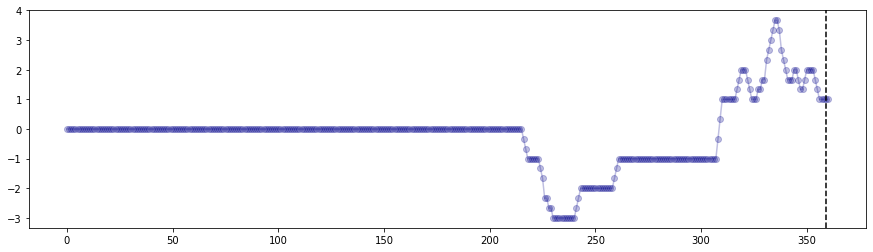

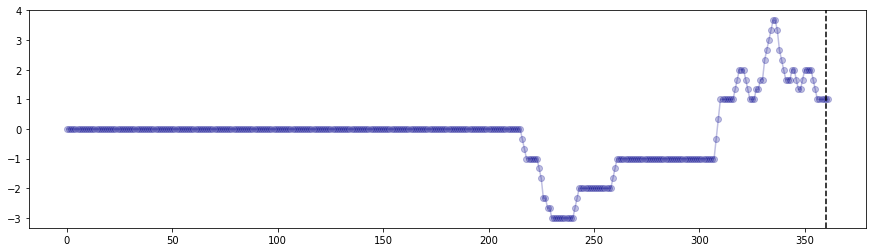

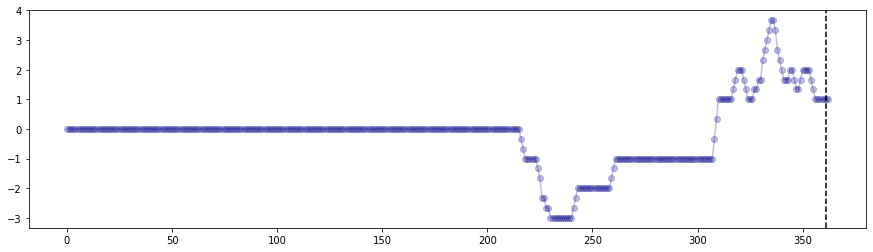

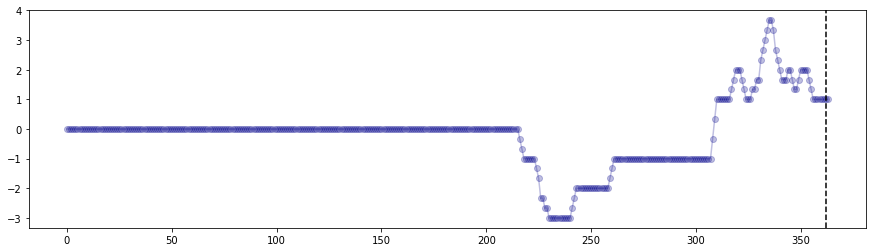

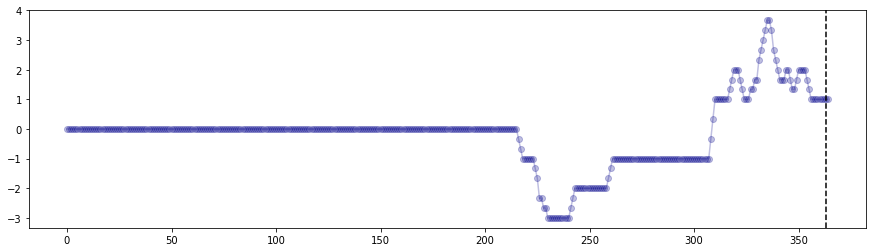

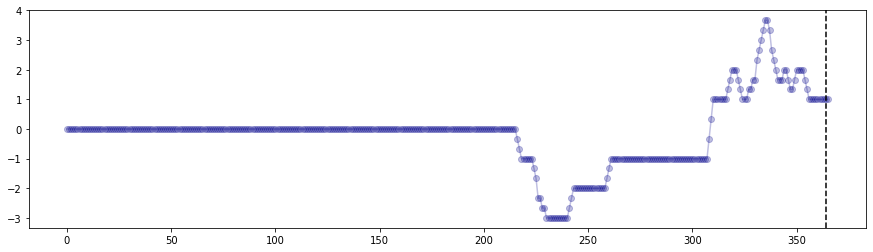

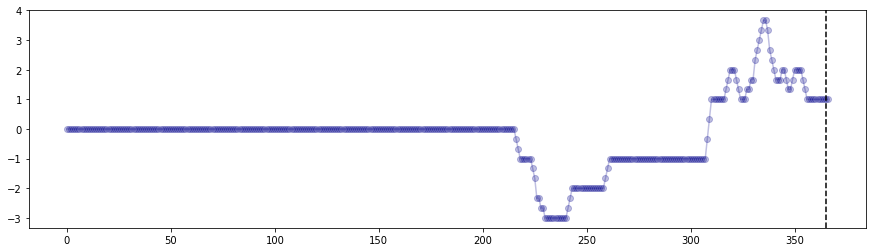

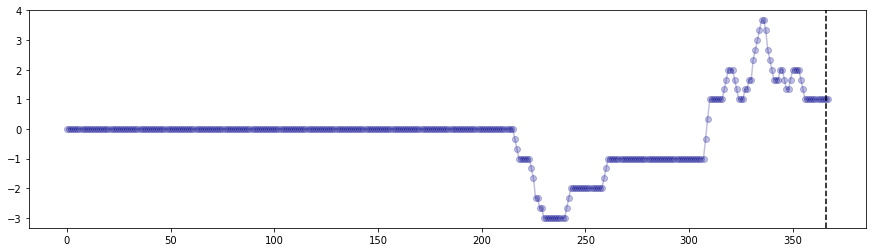

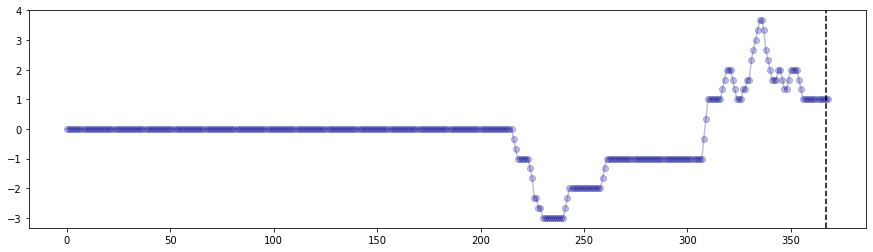

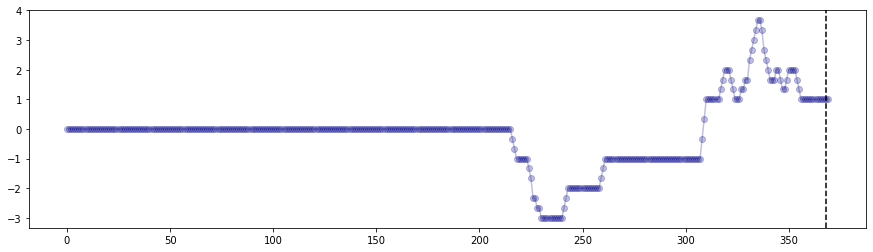

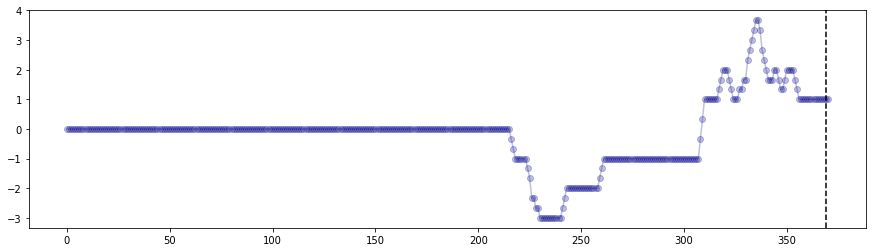

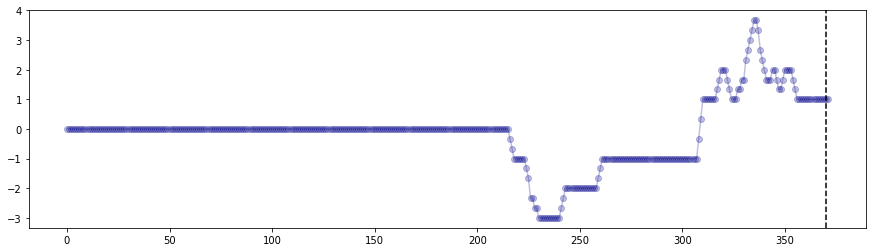

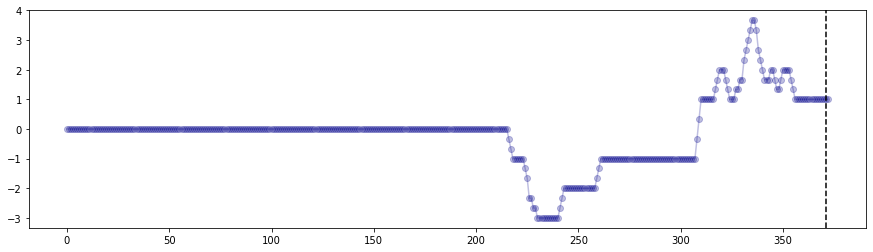

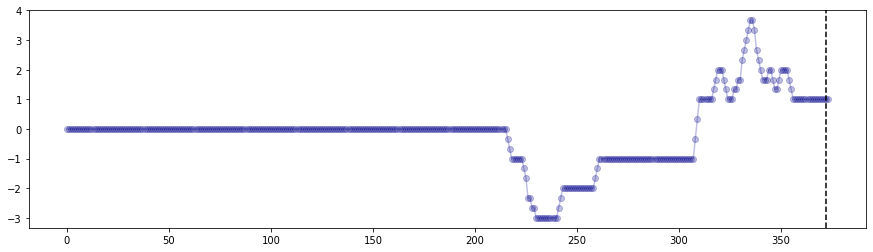

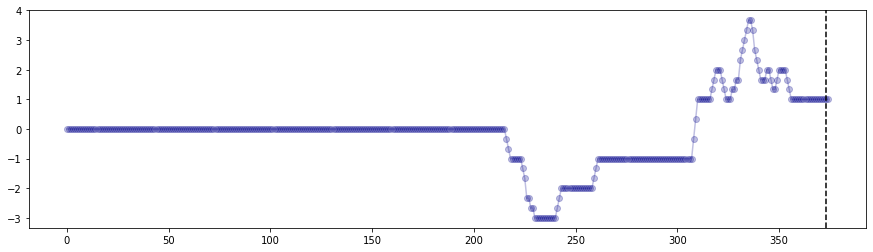

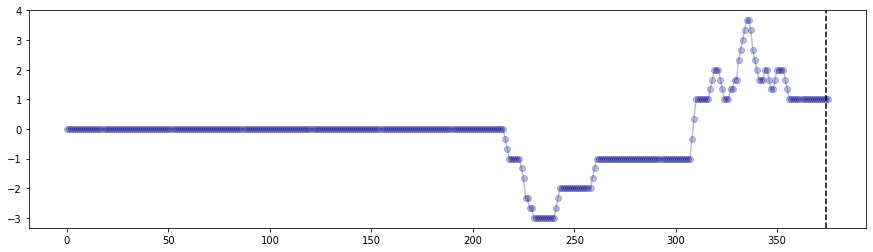

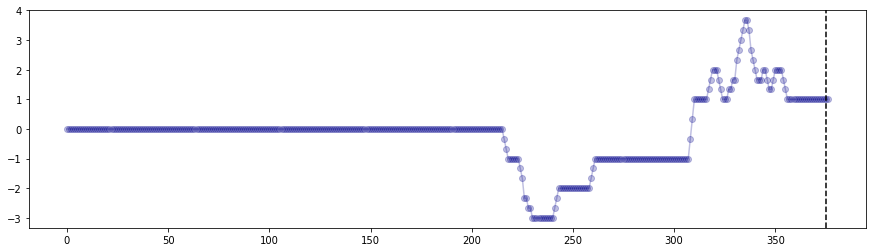

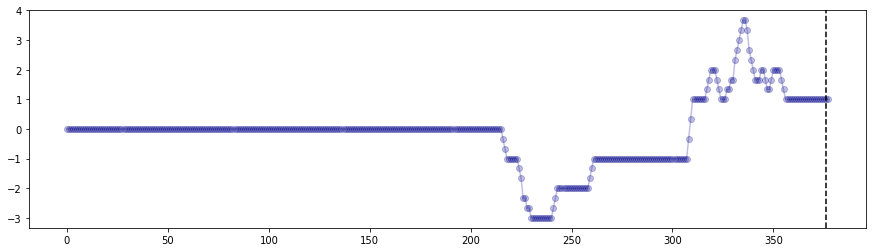

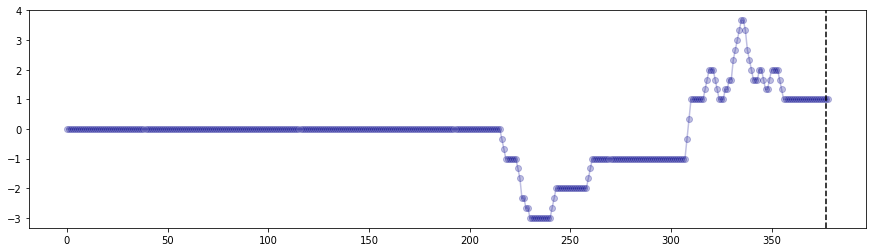

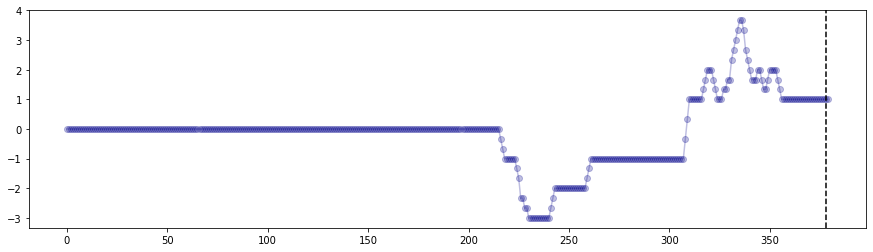

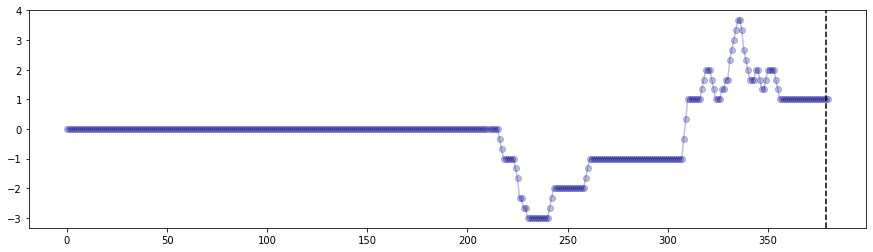

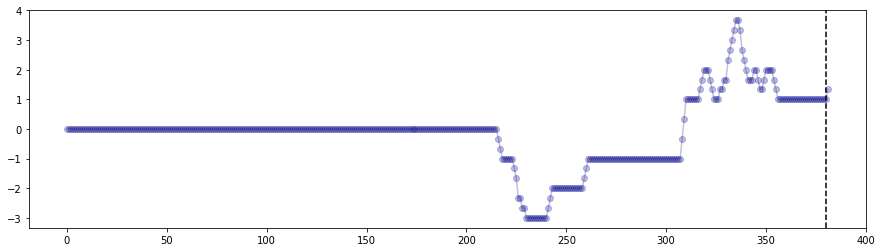

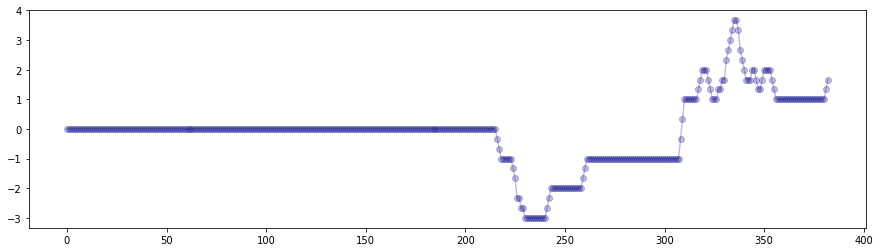

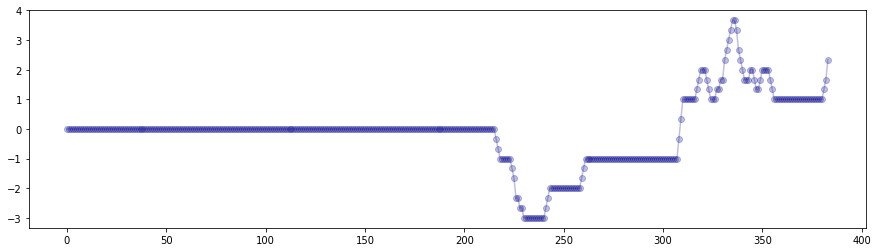

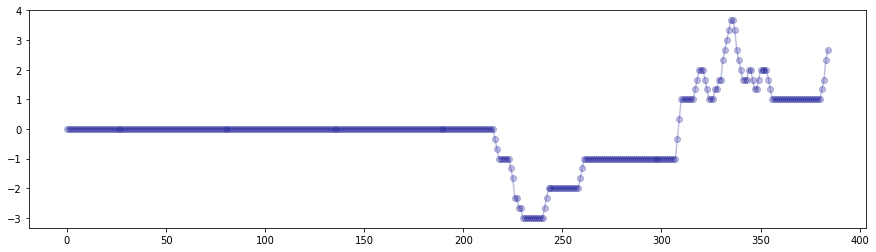

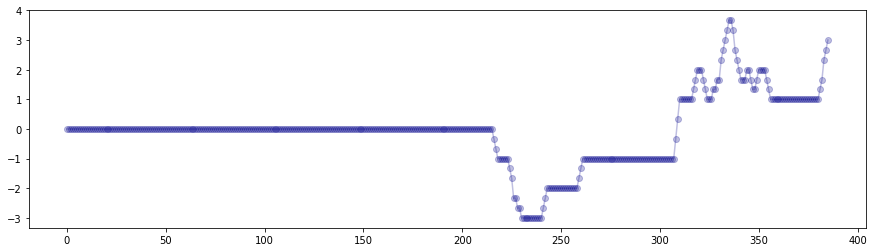

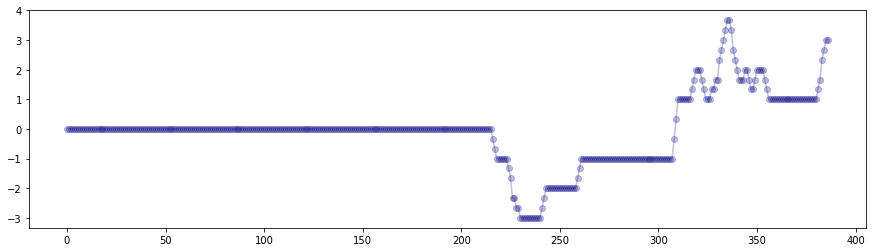

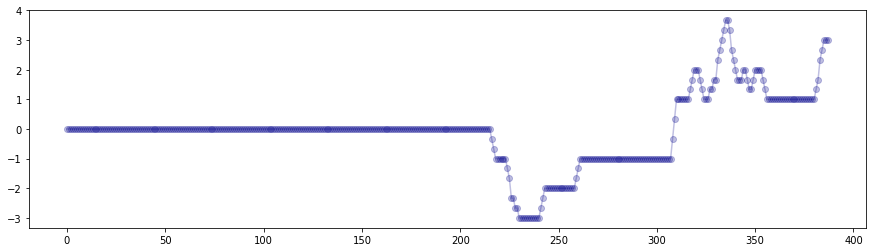

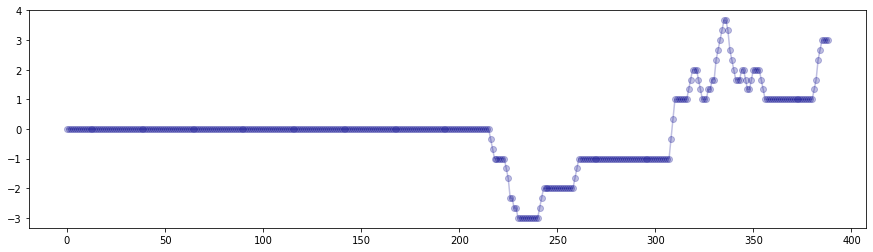

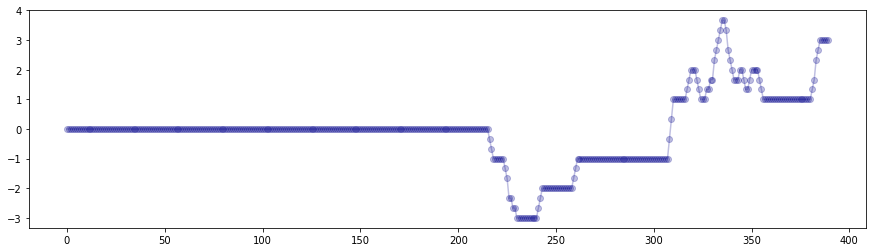

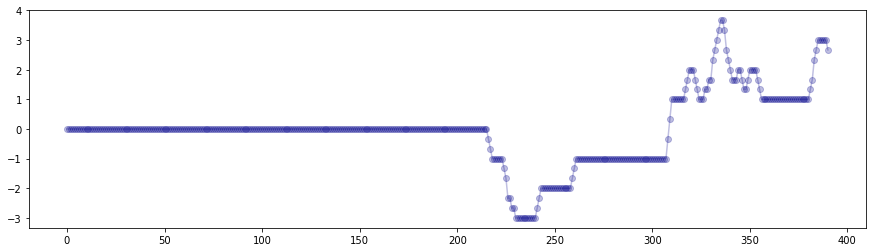

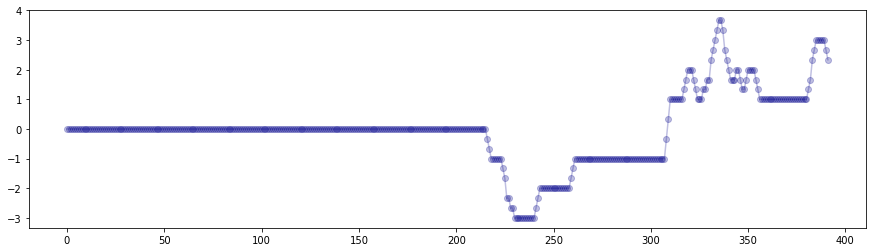

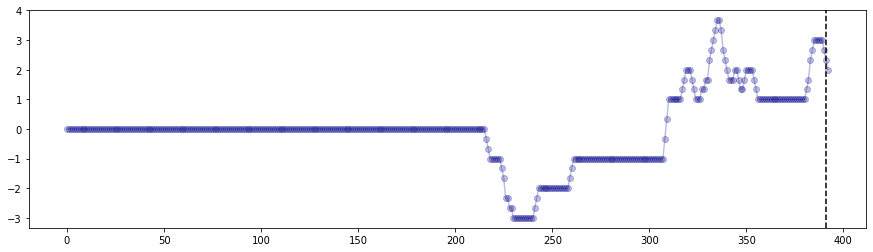

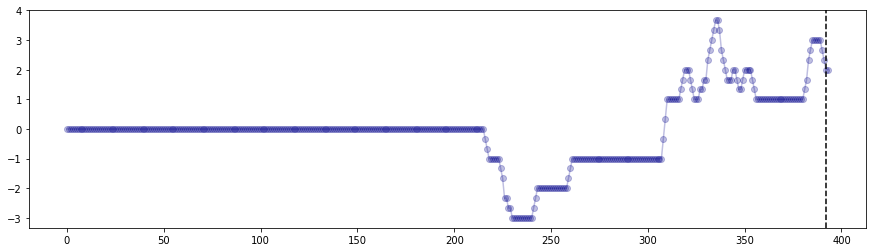

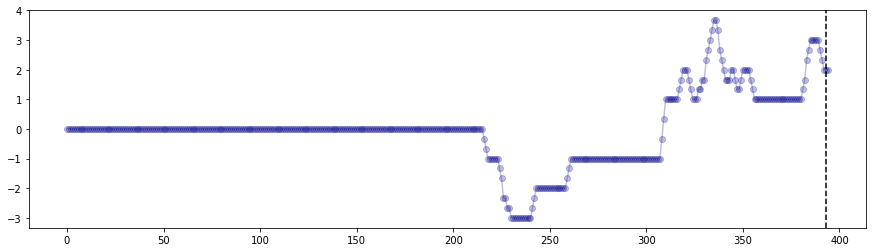

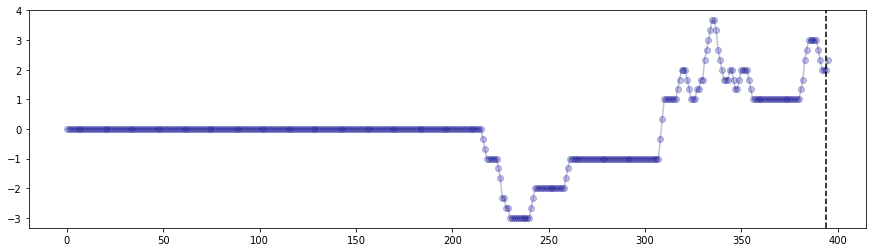

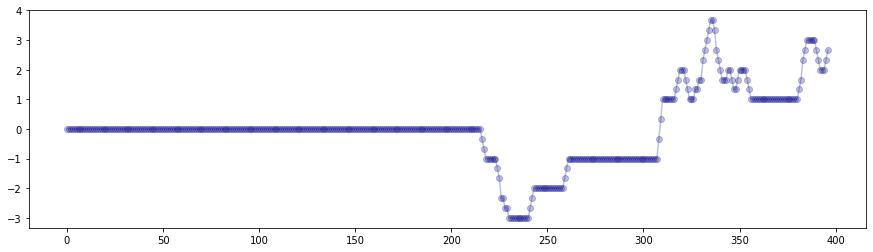

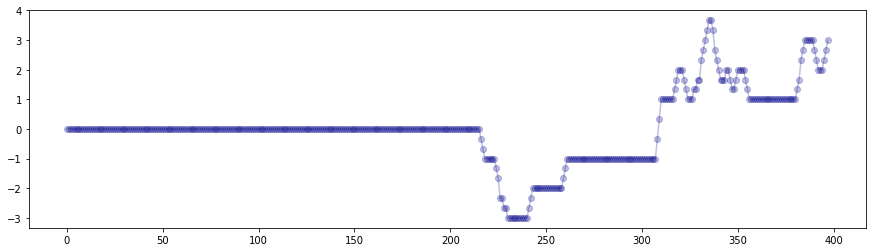

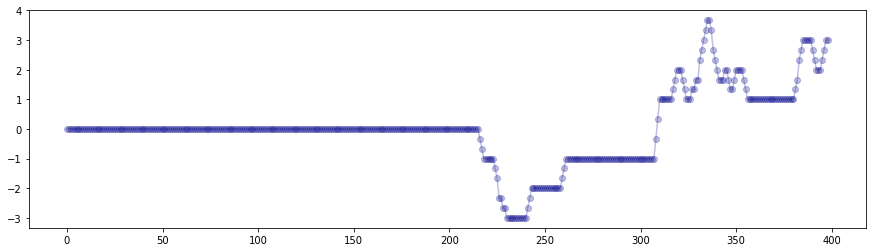

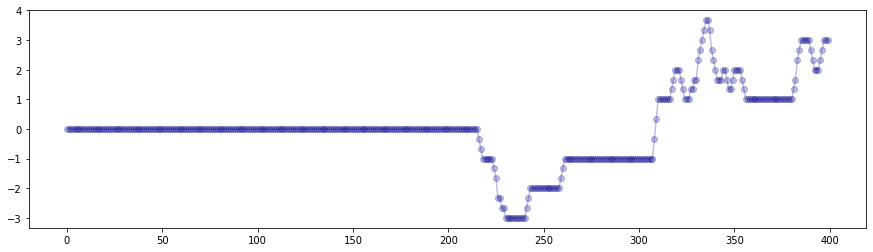

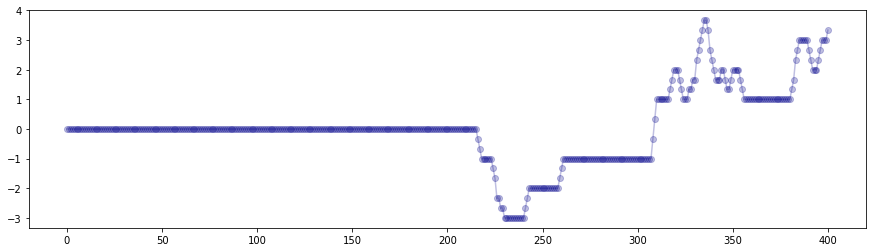

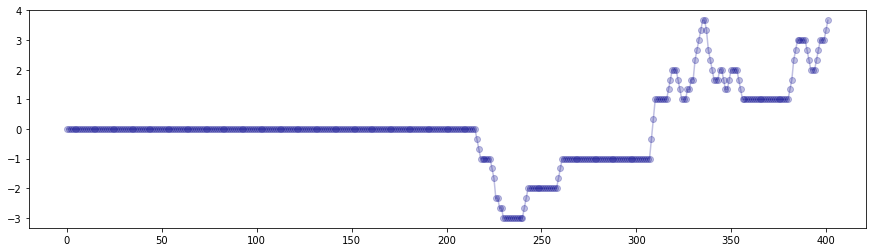

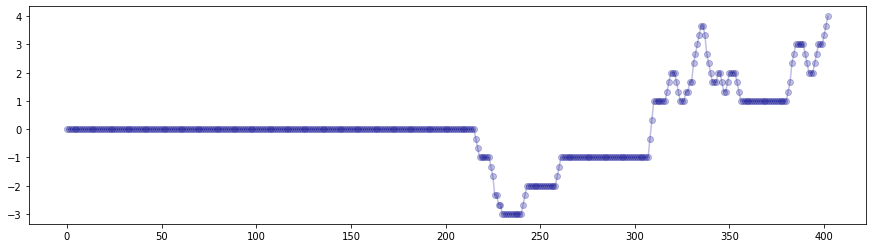

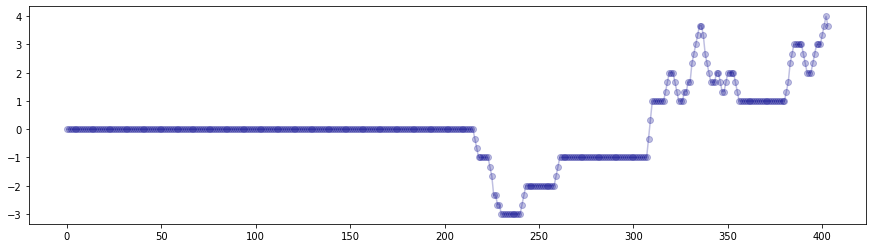

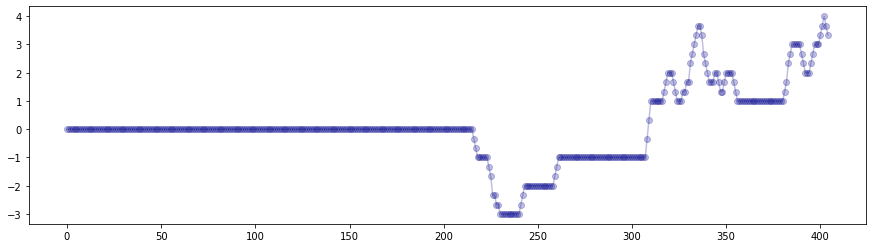

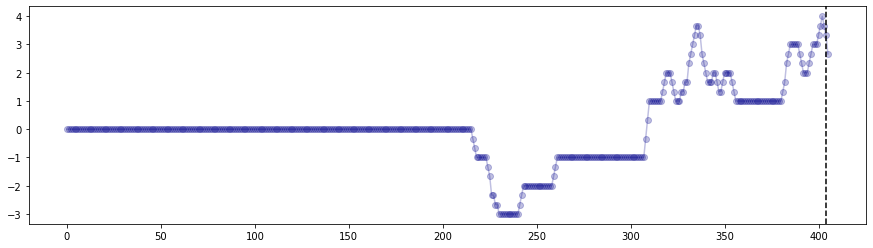

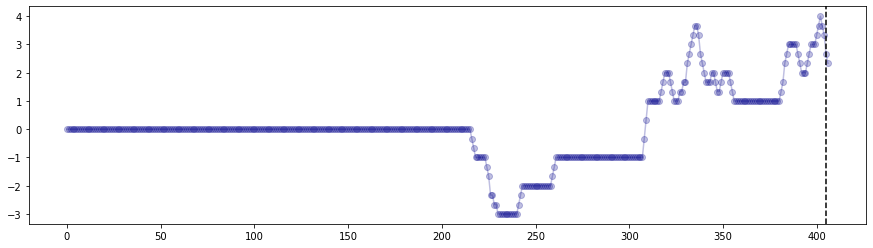

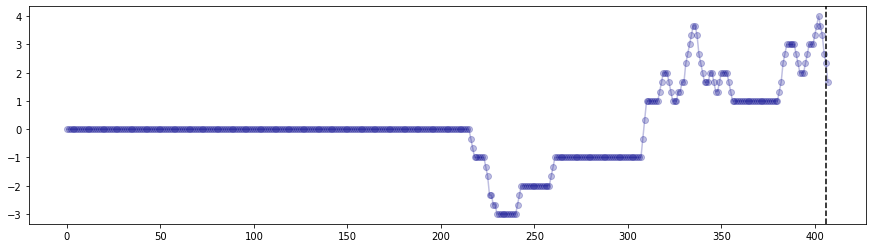

In [79]:
vec_rule_2_decline = nrt.apply_rule_two(vec_static_smooth, min_zone=-1, operator='<=')
#vec_rule_2_incline = apply_rule_two(yest, min_zone=1, operator='>=')

for i in np.arange(0, len(vec_rule_1_decline)):
    if i > 3:
    
        vec_smooth = vec_static_smooth[0:i]
        vec_rule = vec_rule_1_decline[0:i]
        
        alarm = False
        if vec_rule[-2] >= 1:
            alarm = True
            
        fig = plt.figure(figsize=(15, 4))
        plt.plot(vec_smooth, color='darkblue', marker='o', alpha=0.25)
        
        if alarm: 
            plt.axvline(i - 2, color='black', linestyle='dashed')
        
        plt.show()
        plt.close()

#fig = plt.figure(figsize=(15, 4))
#plt.plot(vec_static_smooth, color='darkblue', marker='o', alpha=0.25)
#plt.plot(thresh_dec, color='red', marker='o', alpha=0.25)
#plt.show()